In [1]:
import unittest
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from random import randint
from tqdm import tqdm
from scipy.stats import entropy
import math
from collections import Counter
import pandas as pd
import hashlib
import array, random
import math
from classgroup import *
from classgroup_helper import *
import time
import json
from scipy.stats import chisquare
from matplotlib.colors import ListedColormap

In [2]:
## this code is taken from here: https://github.com/coinstudent2048/bquadform

# Miscellaneous utilities for bquadform.py
#
# Use this code only for prototyping

# integer square root (floor)
# reference: Algorithm 1.7.1 (p.38) of Cohen -
# "A Course in Computational Algebraic Number theory" (GTM 138)
def isqrt(n):
    if not isinstance(n, int):
        raise TypeError("input is not integer")
    if n < 0:
        raise ValueError("input is negative")
    if n == 0:
        return 0
    # [Initialize]
    x = 1 << (n.bit_length() + 2 >> 1)
    while True:
        # [Newtonian step]
        y = (x + n // x) >> 1
        # [Finished?]
        if y >= x:
            return x
        x = y

# # integer square root (ceiling)
# def isqrt_ceil(n):
#     if n == 0:
#         return 0
#     else:
#         return 1 + isqrt(n - 1)

# Euclidean division: always ensures that
# 0 <= r < |b| regardless of sign of divisor
def divmod_euclid(a, b):
    q, r = divmod(a, b)   # divmod uses floor division
    if r < 0:
        q += 1
        r -= b
    return (q, r)

# extended Euclidean algorithm (assumes a >= 0 & b >= 0)
# reference: Algorithm 1.3.6 (p.16) of Cohen -
# "A Course in Computational Algebraic Number theory" (GTM 138)
def ext_euclid(a, b, u=1, v1=0):
    # [Initialize]
    d = a
    # v to be computed in ext_euclid_front()
    if b == 0:
        return (u, d)
    v3 = b
    # [Finished?]
    while v3 != 0:
        # [Euclidean step]
        q, t3 = divmod(d, v3)
        t1 = u - q * v1
        u = v1
        d = v3
        v1 = t1
        v3 = t3
    # [Finished?] cont. moved to ext_euclid_front()
    return (u, d)

# extended partial Euclidean algorithm
# reference: Sub-algorithm PARTEUCL(a, b) (p. 248) of Cohen -
# "A Course in Computational Algebraic Number theory" (GTM 138)
def part_euclid(d, v3, v, v2, L):
    # [Initialize]
    z = 0
    # [Finished?]
    while abs(v3) > L:
        # [Euclidean step]
        q, t3 = divmod_euclid(d, v3)
        t2 = v - q * v2
        v = v2
        d = v3
        v2 = t2
        v3 = t3
        z += 1
    # [Finished?] cont. moved to part_euclid_front()
    return (v, d, v2, v3, z)

# most significant digit of a, and the value of b in same place
# in base M (assumes a >= b, a >= 0, and b >= 0)
def same_msd(a, b, M):
    while a >= M:
        a //= M
        b //= M
    return a, b

# Lehmer extended (assumes a >= b, a >= 0, and b >= 0)
# reference: Algorithm 1.3.7 (p. 17) of Cohen -
# "A Course in Computational Algebraic Number theory" (GTM 138)
def lehmer(a, b, M):
    # [Initialize]
    u = 1
    v1 = 0
    # [Finished?]
    while b >= M:
        a_hat, b_hat = same_msd(a, b, M)
        A = 1
        B = 0
        C = 0
        D = 1
        # [Test quotient]
        while not (b_hat + C == 0 or b_hat + D == 0):
            q = (a_hat + A) // (b_hat + C)
            if q != ((a_hat + B) // (b_hat + D)):
                break
            # [Euclidean step]
            T = A - q * C
            A = C
            C = T
            T = B - q * D
            B = D
            D = T
            T = a_hat - q * b_hat
            a_hat = b_hat
            b_hat = T
        # [Multi-precision step]
        if B == 0:
            q, t = divmod(a, b)
            a = b
            b = t
            t = u - q * v1
            u = v1
            v1 = t
        else:
            t = A * a + B * b
            r = C * a + D * b
            a = t
            b = r
            t = A * u + B * v1
            r = C * u + D * v1
            u = t
            v1 = r
    return a, b, u, v1

# "frontend" for extended Euclidean algorithm
def ext_euclid_front(a, b, use_lehmer=True, M=(1 << 32)):
    # init: the algorithms assume that a >= 0 & b >= 0
    orig_a = a
    orig_b = b
    if orig_a < 0:
        a = -a
    if orig_b < 0:
        b = -b
    # execute algorithms
    if use_lehmer and a < b:
        at = a
        bt = b
        b, a, u, v1 = lehmer(b, a, M)
        u, d = ext_euclid(b, a, u, v1)
        v = u
        u = (d - bt * v) // at   # [Finished?] cont. of Euclid Extended
    elif use_lehmer:
        at = a
        bt = b
        a, b, u, v1 = lehmer(a, b, M)
        u, d = ext_euclid(a, b, u, v1)
        v = (d - at * u) // bt   # [Finished?] cont. of Euclid Extended
    else:
        u, d = ext_euclid(a, b)
        v = (d - a * u) // b   # [Finished?] cont. of Euclid Extended
    # final: check sign of orig a & b
    if orig_a < 0:
        a = -a
        u = -u
    if b < 0:
        b = -b
        v = -v
    return (u, v, d)

# "frontend" for extended partial Euclidean algorithm
def part_euclid_front(d, v3, v, v2, L):   # TODO: use_lehmer=True, M=(1 << 32)
    # execute algorithms
    v, d, v2, v3, z = part_euclid(d, v3, v, v2, L)
    # final: [Finished?] cont. of PARTEUCL
    if z % 2 == 1:
        v2 = -v2
        v3 = -v3
    return (v, d, v2, v3, z)

In [3]:
class BQuadForm:
    def __init__(self, a, b, c=None, disc=None):
        if (c == None and disc == None) or (c != None and disc != None):
            raise AttributeError("invalid arguments")
        if not (isinstance(a, int) and isinstance(b, int)):
            raise TypeError("'a' or 'b' is not integer")
        # optional: check if a < 0 to detect non-positive-definiteness

        if c != None:
            if not isinstance(c, int):
                raise TypeError("'c' is not integer")
            # c is given, so compute discriminant
            disc = b * b - ((a * c) << 2)
            if disc >= 0:
                raise ValueError("non-negative discriminant")

        elif disc != None:
            if not isinstance(disc, int):
                raise TypeError("'disc' is not integer")
            if disc >= 0:
                raise ValueError("non-negative discriminant")
            # disc is given, so compute c
            c, c_test = divmod(b * b - disc, a << 2)   # a is assumed positive
            if c_test != 0:
                raise TypeError("'c' is not integer")

        # optional: check if gcd(a, b, c) != 1 to detect non-primitiveness
        self.a = a
        self.b = b
        self.c = c
        self.disc = disc
        self.L = isqrt(isqrt(abs(disc) >> 2))   # 4th root of |disc/4|
        # only work with reduced forms
        self.__reduction()

    # reduction of positive definite forms
    # reference: Algorithm 5.4.2 (p.243) of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def __reduction(self):
        # [Initialize]: if -a < b <= a goto [Finished?]
        if -self.a < self.b and self.b <= self.a:
            self.__reduction_finished()
            return
        self.__reduction_euclidean()
        self.__reduction_finished()

    # [Euclidean step] in reduction of positive definite forms
    def __reduction_euclidean(self):
        # let b = 2aq + r with 0 <= r < 2a be the Euclidean division of b by 2a
        q, r = divmod_euclid(self.b, self.a << 1)
        # if r > a, set r = r - 2a, q = q + 1 (i.e. we want b = 2aq + r, where -a < r <= a)
        if r > self.a:
            r -= self.a << 1
            q += 1
        # then set c = c - (1/2)(b + r)q, b = r
        self.c -= ((self.b + r) * q) >> 1
        self.b = r

    # [Finished?] in reduction of positive definite forms
    def __reduction_finished(self):
        while not self.isReduced():
            # if a > c set b = -b, exchange a and c and goto [Euclidean step]
            if self.a > self.c:
                self.b = -self.b
                self.a, self.c = self.c, self.a
                self.__reduction_euclidean()
            # otherwise, if a = c and b < 0, set b = -b
            elif self.a == self.c and self.b < 0:
                self.b = -self.b

    # check if the positive definite form is reduced
    # reference: Definition 5.3.2 (p.231) of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def isReduced(self):
        abs_b = abs(self.b)
        # |b| < a < c
        if abs_b < self.a and self.a < self.c:
            return True
        # |b| = a and b >= 0
        if abs_b == self.a and self.b >= 0:
            return True
        # a = c and b >= 0
        if self.a == self.c and self.b >= 0:
            return True
        return False

    # equality
    def __eq__(self, y):
        if isinstance(y, BQuadForm):
            return self.a == y.a and self.b == y.b and self.c == y.c and self.disc == y.disc
        raise TypeError("syntax error")

    # string representation
    def __repr__(self):
        return str((self.a, self.b, self.c)) + " disc: " + str(self.disc)

    # inverse of primitive quadratic form
    # reference: p.250 of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def inverse(self):
        return BQuadForm(self.a, -self.b, self.c)

    # identity element := BQuadForm * BQuadForm.inverse()
    def identity(self):
        return self * self.inverse()

    # composition (NUCOMP algorithm)
    # reference: Algorithm 5.4.9 (p.249) of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def __mul__(self, y):
        if not isinstance(y, BQuadForm):
            raise TypeError("syntax error")
        if self.disc != y.disc:
            raise ValueError("discriminants are different")
        # [Initialize]
        if self.a > y.a:
            a1 = self.a
            b1 = self.b
            c1 = self.c
            a2 = y.a
            b2 = y.b
            c2 = y.c
        else:    # if a1 < a2 exchange f1 and f2
            a1 = y.a
            b1 = y.b
            c1 = y.c
            a2 = self.a
            b2 = self.b
            c2 = self.c
        s = (b1 + b2) >> 1
        n = b2 - s
        # [First Euclidean step]
        u, v ,d = ext_euclid_front(a2, a1)
        if s % d == 0:   # if d|s
            A = -u * n
            d1 = d
            if d != 1:
                a1 //= d1
                a2 //= d1
                s //= d1
        else:   # if not d|s
            # [Second Euclidean step]
            u1, v1, d1 = ext_euclid_front(s, d)
            if d1 > 1:
                a1 //= d1
                a2 //= d1
                s //= d1
                d //= d1
            # [Initialization of reduction]
            l = (-u1 * (u * (c1 % d) + v * (c2 % d))) % d
            A = -u * (n // d) + l * (a1 // d)
        # [Partial reduction]
        A %= a1
        A1 = a1 - A
        if A1 < A:
            A = -A1
        # input sequence: d, v3, v, v2, L = bound
        v, d, v2, v3, z = part_euclid_front(a1, A, 0, 1, self.L)
        # [Special case]
        if z == 0:
            Q1 = a2 * v3
            Q2 = Q1 + n
            f = Q2 // d
            g = (v3 * s + c2) // d
            a3 = d * a2
            # c3 = v3 * f + g * d1   # not required if disc is provided
            b3 = 2 * Q1 + b2
            return BQuadForm(a3, b3, disc = self.disc)
        # [Final computations]
        b = (a2 * d + n * v) // a1
        Q1 = b * v3
        Q2 = Q1 + n
        f = Q2 // d
        e = (s * d + c2 * v) // a1
        Q3 = e * v2
        Q4 = Q3 - s
        g = Q4 // v
        if d1 > 1:
            v2 *= d1
            v *= d1
        a3 = d * b + e * v
        # c3 = v3 * f + g * v2   # not required if disc is provided
        b3 = Q1 + Q2 + d1 * (Q3 + Q4)
        return BQuadForm(a3, b3, disc = self.disc)

    # squaring (NUDUPL algorithm)
    # reference: Algorithm 5.4.8 (p.248) of Cohen -
    # "A Course in Computational Algebraic Number theory" (GTM 138)
    def square(self):
        a = self.a
        b = self.b
        c = self.c
        # [Euclidean step]
        u, _, d1 = ext_euclid_front(b, a)
        A = a // d1
        B = b // d1
        C = (- c * u) % A
        C1 = A - C
        if C1 < C:
            C = -C1
        # [Partial reduction]
        # input sequence: d, v3, v, v2, L = bound
        v, d, v2, v3, z = part_euclid_front(A, C, 0, 1, self.L)
        # [Special case]
        if z == 0:
            g = (B * v3 + c) // d
            a2 = d * d
            # c2 = v3 * v3 + g * d1   # not required if disc is provided
            b2 = b + 2 * d * v3   # simplified
            return BQuadForm(a2, b2, disc = self.disc)
        # [Final computations]
        e = (c * v + B * d) // A
        g = (e * v2 - B) // v
        b2 = e * v2 + v * g
        if d1 > 1:
            b2 *= d1
            v *= d1
            v2 *= d1
        a2 = d * d + e * v
        # c2 = v3 * v3 + g * v2   # not required if disc is provided
        b2 += 2 * d * v3   # simplified
        return BQuadForm(a2, b2, disc = self.disc)

    # exponentiation using Non-Adjacent Form (NAF) of an integer
    # reference: Algorithm 3.1 (p.27) of Sayles -
    # "Improved Arithmetic in the Ideal Class Group of Imaginary Quadratic Number Fields
    # with an Application to Integer Factoring"
    def __pow__(self, y):
        if not (isinstance(y, int) and y >= 0):
            raise TypeError("syntax error")
        c = 0
        T = self
        R = self.identity()
        # note: instead of using counter i for the while loop, I used right-shifting of y instead
        rsh_y = y
        while rsh_y > 0:
            twobit_test = (rsh_y + c) % 4
            if twobit_test == 1:
                R *= T
                c = 0
            elif twobit_test == 3:
                R *= T.inverse()
                c = 1
            T = T.square()
            rsh_y >>= 1
        if c == 1:
            R *= T
        return R

In [4]:
def random_prime(n):
    prime_candidate = 2
    while True:
            prime_candidate = getLowLevelPrime(n)
            if not isMillerRabinPassed(prime_candidate):
                continue
            else:
                break
    return prime_candidate

In [5]:
# Large Prime Generation for RSA
import random
 
# Pre generated primes
first_primes_list = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29,
                     31, 37, 41, 43, 47, 53, 59, 61, 67,
                     71, 73, 79, 83, 89, 97, 101, 103,
                     107, 109, 113, 127, 131, 137, 139,
                     149, 151, 157, 163, 167, 173, 179,
                     181, 191, 193, 197, 199, 211, 223,
                     227, 229, 233, 239, 241, 251, 257,
                     263, 269, 271, 277, 281, 283, 293,
                     307, 311, 313, 317, 331, 337, 347, 349]
 
 
def nBitRandom(n):
    return random.randrange(2**(n-1)+1, 2**n - 1)
 
 
def getLowLevelPrime(n):
    '''Generate a prime candidate divisible 
    by first primes'''
    while True:
        # Obtain a random number
        pc = nBitRandom(n)
 
        # Test divisibility by pre-generated
        # primes
        for divisor in first_primes_list:
            if pc % divisor == 0 and divisor**2 <= pc:
                break
        else:
            return pc
 
 
def isMillerRabinPassed(mrc):
    '''Run 30 iterations of Rabin Miller Primality test'''
    maxDivisionsByTwo = 0
    ec = mrc-1
    while ec % 2 == 0:
        ec >>= 1
        maxDivisionsByTwo += 1
    assert(2**maxDivisionsByTwo * ec == mrc-1)
 
    def trialComposite(round_tester):
        if pow(round_tester, ec, mrc) == 1:
            return False
        for i in range(maxDivisionsByTwo):
            if pow(round_tester, 2**i * ec, mrc) == mrc-1:
                return False
        return True
 
    # Set number of trials here
    numberOfRabinTrials = 30
    for i in range(numberOfRabinTrials):
        round_tester = random.randrange(2, mrc)
        if trialComposite(round_tester):
            return False
    return True

In [6]:
## Useful website for testing purposes: https://mathworld.wolfram.com/ClassNumber.html

In [81]:
## random_prime(bitlength//2)
discriminant = -1*random_prime(8)
#discriminant = -831370543
#discriminant = -967
print("The discriminant is:", discriminant)
rangeA = math.ceil(math.sqrt(-discriminant/3))+2
rangeB = rangeA
print("Range for reduced forms:", rangeA)
cnt = 0 # number of equivalent binary quadratic forms
reducedFormsWithCnt = {}
classGroups = np.zeros((rangeA, 2*rangeB+1))
coefficientsA = []
coefficientsB = []
coefficientsC = []
allCoefficientsA = []
allCoefficientsB = []
seenReducedForms = []
m = hashlib.sha256()
# Discriminant = b^2-4*a*c
for a in tqdm(range(1,rangeA)):
    for b in range(rangeB,-rangeB,-1):
        if (b*b-discriminant)%(4*a) == 0:
            c = (b*b-discriminant)//(4*a)
            if b*b-4*a*c == discriminant:
                myForm = BQuadForm(a,b,c)
                myForm.a=a
                myForm.b=b
                myForm.c=c
                allCoefficientsA.append(a)
                allCoefficientsB.append(b)
                byteArrayToHash = repr(a).encode()+repr(712343217).encode()+repr(b).encode()+repr(712343217).encode()+repr(c).encode()
                myhash = hashlib.sha256(byteArrayToHash).hexdigest()
                if myForm.isReduced() and (myhash not in reducedFormsWithCnt):
                    reducedFormsWithCnt[myhash]=cnt
                    seenReducedForms.append(reducedFormsWithCnt[myhash])
                    #classGroups[a][b+rangeB]=cnt
                    classGroups[a][b]+=1
                    cnt+=1
                    coefficientsA.append(myForm.a)
                    coefficientsB.append(myForm.b)
                    coefficientsC.append(myForm.c)
                    #print(myForm)
                if myForm.isReduced() and (myhash in reducedFormsWithCnt):
                    #classGroups[a][b+rangeB]=reducedFormsWithCnt[myhash]
                    seenReducedForms.append(reducedFormsWithCnt[myhash])
                    #print("Reduced",a,b,c)
                if not myForm.isReduced():
                    myForm._BQuadForm__reduction()
                    byteArrayToHash = repr(myForm.a).encode()+repr(712343217).encode()+repr(myForm.b).encode()+repr(712343217).encode()+repr(myForm.c).encode()
                    myhash = hashlib.sha256(byteArrayToHash).hexdigest()
                    if (myhash not in reducedFormsWithCnt) and myForm.isReduced():
                        reducedFormsWithCnt[myhash]=cnt
                        seenReducedForms.append(reducedFormsWithCnt[myhash])
                        #classGroups[a][b+rangeB]=cnt
                        classGroups[a][b]+=1
                        cnt+=1
                        coefficientsA.append(myForm.a)
                        coefficientsB.append(myForm.b)
                        coefficientsC.append(myForm.c)
                        #print(myForm)
                    else:
                        #classGroups[a][b+rangeB]=reducedFormsWithCnt[myhash]
                        seenReducedForms.append(reducedFormsWithCnt[myhash])
                        #print("Non-reduced",a,b,c)
                
                
                #print(a,b,myForm,myForm.isReduced(),str(hash(tuple(myForm))))
                #print(a,b,b*b-discriminant//(4*a),myForm._BQuadForm__reduction())
                #cnt+=1
print("Number of reduced forms found", cnt)
#print(classGroups)
#print(coefficientsB)

The discriminant is: -139
Range for reduced forms: 9


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 4140.99it/s]

Number of reduced forms found 3


In [9]:
## Cool discriminants
## -2545453607

Number of reduced forms: 12029
Character: 1.3106359428904986


/var/folders/gg/fprt4kn53r70np9bpl1n8kh00000gn/T/ipykernel_25897/725414549.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./Figures/coefficientAdensity.pdf")
/var/folders/gg/fprt4kn53r70np9bpl1n8kh00000gn/T/ipykernel_25897/725414549.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./Figures/coefficientAdensity.pdf")
/Users/seresistvanandras/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


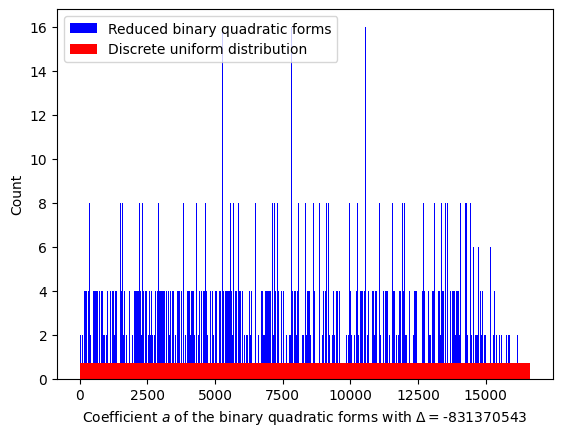

In [114]:
coefficientADensity = Counter(coefficientsA)
#print(coefficientADensity)
key = coefficientADensity.keys()
values = coefficientADensity.values()
print("Number of reduced forms:",sum(values))
print("Character:",(sum(values)*3.1415926)/math.sqrt(-discriminant))

## Distribution of the coefficient "A" in the studied class group of imaginary quadratic field
allCoefficientADensity = Counter(allCoefficientsA)
allKey = allCoefficientADensity.keys()
allValues = allCoefficientADensity.values()

#print(allCoefficientADensity)
## Uniform distribution 
uniformX = [i for i in range(rangeA)]
uniformY = [sum(values)/rangeA for i in range(rangeA)]

#plt.bar(allKey, allValues, width=4, color='red', label='All binary quadratic forms')
plt.bar(key, values, width=4, color='blue', label='Reduced binary quadratic forms')
plt.bar(uniformX, uniformY, width=4, color='red', label='Discrete uniform distribution')
plt.xlabel('Coefficient $a$ of the binary quadratic forms with $\Delta=$'+str(discriminant))
plt.ylabel("Count")
#plt.yscale('log')
#plt.title("The distribution of coefficient $a$ for the discriminant "+str(discriminant))
plt.legend()
plt.savefig("./Figures/coefficientAdensity.pdf")
plt.show()

In [112]:
## Chi-squared test for the coefficient A
numOfIntervals = math.ceil(math.log(rangeA))
lenOfIntervals = rangeA/numOfIntervals
expectedInterval = [uniformY[0]*lenOfIntervals for i in range(numOfIntervals)]
observedInterval = [0]*numOfIntervals
print(lenOfIntervals)
for i in range(numOfIntervals):
    counter = 0
    for k in key:
        if i*lenOfIntervals<k and k<(i+1)*lenOfIntervals:
            counter+=coefficientADensity[k] 
    observedInterval[i] = counter
print("Expected discrete probability distribution for coefficient A", expectedInterval)
print("Observed discrete probability distribution for coefficient A", observedInterval)
chisquare(f_obs=observedInterval, f_exp=expectedInterval)

1665.0
Expected discrete probability distribution for coefficient A [1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9, 1202.9]
Observed discrete probability distribution for coefficient A [1345, 1350, 1288, 1330, 1274, 1372, 1324, 1322, 1174, 250]


Power_divergenceResult(statistic=861.7348906808545, pvalue=1.0832748286251192e-179)

KeyboardInterrupt: 

/Users/seresistvanandras/opt/miniconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/seresistvanandras/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


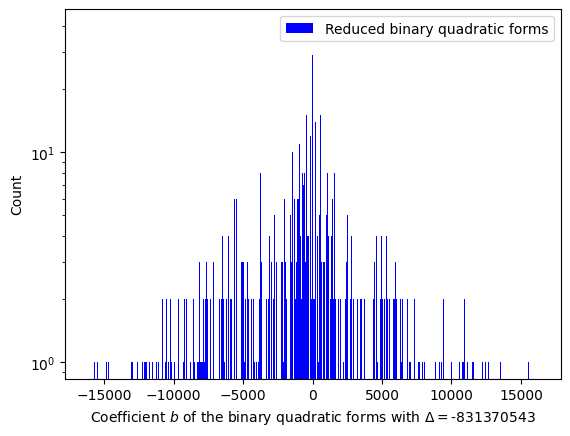

In [113]:
coefficientBDensity = Counter(coefficientsB)
key = coefficientBDensity.keys()
values = coefficientBDensity.values()

allCoefficientBDensity = Counter(allCoefficientsB)
allKey = allCoefficientBDensity.keys()
allValues = allCoefficientBDensity.values()

#plt.bar(allKey, allValues, width=2, color='red', label='All binary quadratic forms')
plt.bar(key, values, width=4, color='blue', label='Reduced binary quadratic forms')
plt.xlabel('Coefficient $b$ of the binary quadratic forms with $\Delta=$'+str(discriminant))
plt.ylabel("Count")
plt.yscale('log')
#plt.title("The distribution of coefficient $b$ for the discriminant "+str(discriminant))
plt.legend()
plt.savefig("./Figures/coefficientBdensity.pdf")
plt.show()

In [109]:
## Chi-squared test for the coefficient B
numOfIntervals = math.ceil(math.log(rangeA))
lenOfIntervals = rangeA/numOfIntervals
observedInterval = [0]*numOfIntervals
for i in range(numOfIntervals):
    counter = 0
    print(i*lenOfIntervals)
    for k in key:
        if i*lenOfIntervals<=k and k<(i+1)*lenOfIntervals:
            counter+=coefficientBDensity[k] 
    observedInterval[i] = counter

expectedInterval = [sum(observedInterval)/numOfIntervals for i in range(numOfIntervals)]
print("Expected discrete probability distribution for coefficient B", expectedInterval)
print("Observed discrete probability distribution for coefficient B", observedInterval)
chisquare(f_obs=observedInterval, f_exp=expectedInterval)

0.0
1665.0
3330.0
4995.0
6660.0
8325.0
9990.0
11655.0
13320.0
14985.0
Expected discrete probability distribution for coefficient B [601.5, 601.5, 601.5, 601.5, 601.5, 601.5, 601.5, 601.5, 601.5, 601.5]
Observed discrete probability distribution for coefficient B [2148, 1100, 816, 655, 452, 343, 252, 144, 72, 33]


Power_divergenceResult(statistic=6173.280964256027, pvalue=0.0)

In [ ]:
coefficientCDensity = Counter(coefficientsC)
key = coefficientCDensity.keys()
values = coefficientCDensity.values()


#allCoefficientCDensity = Counter(allCoefficientsC)
#allKey = allCoefficientCDensity.keys()
#allValues = allCoefficientCDensity.values()

#plt.bar(allKey, allValues, width=2, color='red', label='All binary quadratic forms')
#plt.hist(key)
plt.bar(key, values, width=2, color='blue', label='Reduced binary quadratic forms')
plt.xlabel('Coefficient $c$ of the binary quadratic forms with $\Delta=$'+str(discriminant))
plt.ylabel("Count")
#plt.yscale('log')
plt.xscale('log')
#plt.title("The distribution of coefficient $b$ for the discriminant "+str(discriminant))
plt.legend()
plt.savefig("./Figures/coefficientCdensity.pdf")
plt.show()

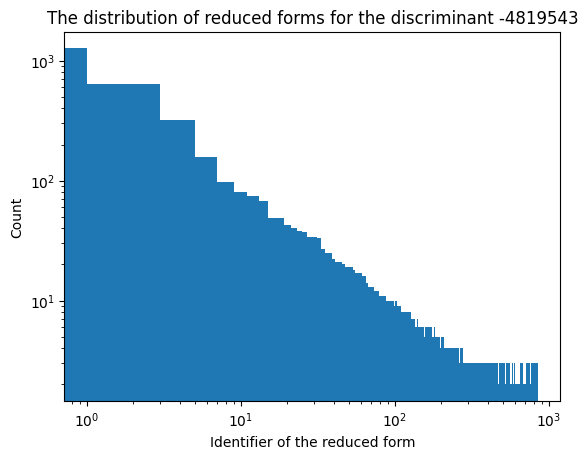

In [12]:
seenReducedFormDensity = Counter(seenReducedForms)
key = seenReducedFormDensity.keys()
values = seenReducedFormDensity.values()

plt.bar(key, values, width=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Identifier of the reduced form')
plt.ylabel("Count")
plt.title("The distribution of reduced forms for the discriminant "+str(discriminant))
plt.savefig("./Figures/reducedFormDist.pdf")
plt.show()

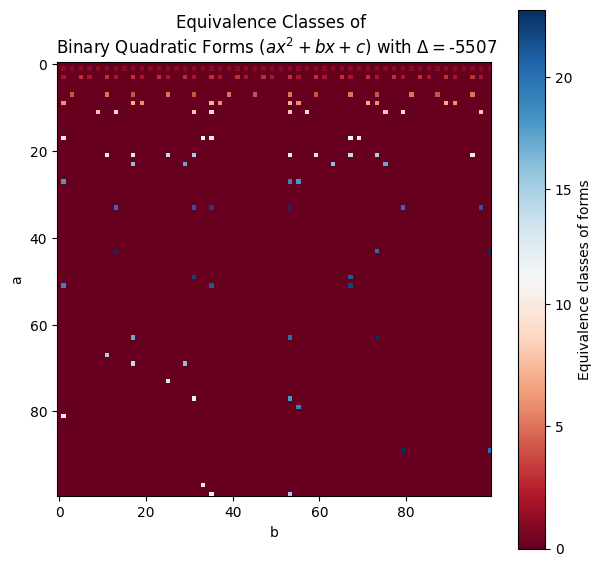

In [5]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111)
ax.set_title("Equivalence Classes of \n Binary Quadratic Forms $(ax^2+bx+c)$ with $\Delta=$"+str(discriminant))
plt.xlabel("b")
plt.ylabel("a")
norm = mcolors.TwoSlopeNorm(vmin=classGroups.min(), vmax = classGroups.max(), vcenter=classGroups.max()//2)
plt.imshow(classGroups,cmap=plt.cm.RdBu, norm=norm)
ax.set_aspect('equal')
cbar = plt.colorbar(orientation='vertical')
cbar.set_label('Equivalence classes of forms')
plt.savefig("./Figures/existingFormsWithDiscriminant.pdf")

[-200.    0.  200.  400.  600.  800. 1000. 1200. 1400. 1600. 1800.]
[Text(-200.0, 0, '−200'), Text(0.0, 0, '0'), Text(200.0, 0, '200'), Text(400.0, 0, '400'), Text(600.0, 0, '600'), Text(800.0, 0, '800'), Text(1000.0, 0, '1000'), Text(1200.0, 0, '1200'), Text(1400.0, 0, '1400'), Text(1600.0, 0, '1600'), Text(1800.0, 0, '1800')]


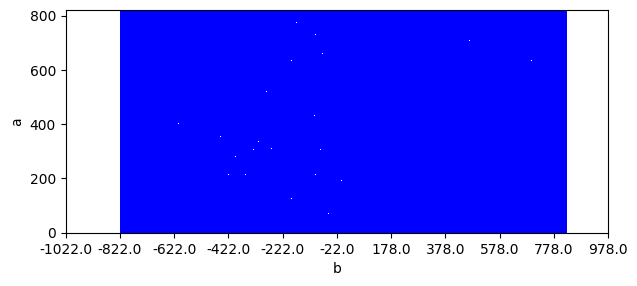

In [70]:
#classGroups = classGroups.transpose()
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
#ax.set_title("Equivalence Classes of \n Binary Quadratic Forms $(ax^2+bx+c)$ with $\Delta=$"+str(discriminant))
plt.xlabel("b")
plt.ylabel("a")
cmapmine = ListedColormap(['b', 'w'], N=2)
#norm = mcolors.TwoSlopeNorm(vmin=classGroups.min(), vmax = classGroups.max(), vcenter=classGroups.min())
plt.imshow(classGroups,cmap=cmapmine, vmin=0, vmax=1, interpolation='none')
#ax.set_aspect('equal')
plt.gca().invert_yaxis()
#cbar = plt.colorbar(orientation='vertical')
#cbar.set_label('Equivalence classes of forms')
# ytikcs
locs,labels = plt.xticks()
print(locs)
print(labels)
plt.xticks(locs, map(lambda x: x-classGroups.shape[0], locs))
plt.savefig("./Figures/coefficientAandBheatmap.pdf")

In [41]:
print(classGroups.shape[0])
print(classGroups.min(),classGroups.max())

20
0.0 1.0


In [13]:
## Orbit of a quadratic binary form by multiplying with a SL(Z,2) matrix

In [14]:
## Visualizing the class group operation via visualizing repeated squaring

In [11]:
def modular_sqrt(a, p):

    def legendre_symbol(a, p):
        """ Compute the Legendre symbol a|p using
            Euler's criterion. p is a prime, a is
            relatively prime to p (if p divides
            a, then a|p = 0)
            Returns 1 if a has a square root modulo
            p, -1 otherwise.
        """
        ls = pow(a, (p - 1) // 2, p)
        return -1 if ls == p - 1 else ls

    """ Find a quadratic residue (mod p) of 'a'. p
        must be an odd prime.
        Solve the congruence of the form:
            x^2 = a (mod p)
        And returns x. Note that p - x is also a root.
        0 is returned is no square root exists for
        these a and p.
        The Tonelli-Shanks algorithm is used (except
        for some simple cases in which the solution
        is known from an identity). This algorithm
        runs in polynomial time (unless the
        generalized Riemann hypothesis is false).
    """
    # Simple cases
    #
    if legendre_symbol(a, p) != 1:
        return 0
    elif a == 0:
        return 0
    elif p == 2:
        return p
    elif p % 4 == 3:
        return pow(a, (p + 1) // 4, p)

    # Partition p-1 to s * 2^e for an odd s (i.e.
    # reduce all the powers of 2 from p-1)
    #
    s = p - 1
    e = 0
    while s % 2 == 0:
        s //= 2
        e += 1

    # Find some 'n' with a legendre symbol n|p = -1.
    # Shouldn't take long.
    #
    n = 2
    while legendre_symbol(n, p) != -1:
        n += 1

    # Here be dragons!
    # Read the paper "Square roots from 1; 24, 51,
    # 10 to Dan Shanks" by Ezra Brown for more
    # information
    #

    # x is a guess of the square root that gets better
    # with each iteration.
    # b is the "fudge factor" - by how much we're off
    # with the guess. The invariant x^2 = ab (mod p)
    # is maintained throughout the loop.
    # g is used for successive powers of n to update
    # both a and b
    # r is the exponent - decreases with each update
    #
    x = pow(a, (s + 1) // 2, p)
    b = pow(a, s, p)
    g = pow(n, s, p)
    r = e

    while True:
        t = b
        m = 0
        for m in range(r):
            if t == 1:
                break
            t = pow(t, 2, p)

        if m == 0:
            return x

        gs = pow(g, 2 ** (r - m - 1), p)
        g = (gs * gs) % p
        x = (x * gs) % p
        b = (b * g) % p
        r = m

In [43]:
# Utility function to do modular exponentiation. 
# It returns (x^y) % p.
def power(x, y, p) :
 
    res = 1 # Initialize result 
    x = x % p # Update x if it is more 
              # than or equal to p 
 
    while (y > 0): 
         
        # If y is odd, multiply x with result 
        if (y & 1):
            res = (res * x) % p 
 
        # y must be even now 
        y = y >> 1 # y = y/2 
        x = (x * x) % p 
 
    return res 
 
# Returns true if square root of n under
# modulo p exists. Assumption: p is of the
# form 4*i + 3 where i >= 1 
def squareRoot(n, p): 
 
    if (p % 4 != 3) : 
        print( "Invalid Input" )
        return
 
 
    # Try "+(n^((p + 1)/4))" 
    n = n % p 
    x = power(n, (p + 1) // 4, p) 
    if ((x * x) % p == n): 
        return
 
    # Try "-(n ^ ((p + 1)/4))" 
    x = p - x 
    if ((x * x) % p == n): 
        return

In [47]:
## This algorithm was suggested by Benjamin Wesolowski and implemented by Giacomo Pope
## Room for improvement: only generates class group elements of the form (p,b,c) for some prime
## Hence, not a surjective mapping to the class group. 
def random_ClassGroupElement(discriminant,a): #a should be a random prime
    D_mod_a = discriminant % a
    b = modular_sqrt(D_mod_a, a)
    #print("first",discriminant,a,b,(b*b-discriminant) / (4*a))
    if b == 0:
        return (0,0)
    ##if discriminant % 4 == 0:
    ##    b = crt([b, 2], [(a, 1), (2, 2)], 4*a)
    c = int((b*b-discriminant) / (4*a))
    #print("second",discriminant,a,b,c)
    if ((b*b-discriminant)%(4*a)) != 0 or c == 0 or b*b-4*a*c!=discriminant:
        return (0,0)
    sign = randint(0,1)
    if sign:
        return  (a, b)
    return  (a, -b)

In [93]:
howManyTimes = 3

bitLengths = [2**i for i in range(7,11)]
#bitLengths = [2**32,2**64,2**128,2**256,2**512,2**1024,2**2048]
#bitLengths = [8,16,32,64]
outcnt = 0
print(bitLengths)
#myDiscriminants = [63667,3885941359]
#myDiscriminants = [139,49199,3947233063,10791920648485500539,242232373444710045946623441980676108967]

for bitLength in bitLengths:
##for bitLength in bitLengths:    
    myDiscriminant = random_prime(bitLength)
    ##myDiscriminant = myDiscriminants[outcnt]
    print(math.log(myDiscriminant,2),myDiscriminant)
    # Start timer
    start_time = time.time()
    
    cnt = 0
    attempts = 0
    # The hashing algorithm by Benjamin&Giacomo
    while cnt!=howManyTimes:
        attempts+=1
        p = random_prime(bitLength//2-1)
        (a,b) = random_ClassGroupElement(-myDiscriminant,p)
        print(attempts, myDiscriminant,p,a,b)
        if (a,b)!=(0,0):
            cnt+=1
            print(cnt,a%4,BQuadForm(a,b,disc=-myDiscriminant))

    # End timer
    end_time = time.time()
    outcnt+=1
    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print("Elapsed time for sampling 1 random class group element with a "+str(math.log(bitLength,2))+"-bit discriminant: ", elapsed_time/howManyTimes, " made with "+str(attempts)+" attempts.") 


[128, 256, 512, 1024]
127.50965929439788 242232373444710045946623441980676108967
1 242232373444710045946623441980676108967 7557901125287254037 0 0
2 242232373444710045946623441980676108967 5564476832312763523 0 0
3 242232373444710045946623441980676108967 6470644361579193259 0 0
4 242232373444710045946623441980676108967 8224505195548517417 0 0
5 242232373444710045946623441980676108967 5521612293562815599 0 0
6 242232373444710045946623441980676108967 4684531621036705649 0 0
7 242232373444710045946623441980676108967 5641816642899110659 0 0
8 242232373444710045946623441980676108967 7539511023038666999 0 0
9 242232373444710045946623441980676108967 8213219039733325643 0 0
10 242232373444710045946623441980676108967 7141461758851293959 0 0
11 242232373444710045946623441980676108967 6064898756629275781 0 0
12 242232373444710045946623441980676108967 7776455070096375749 0 0
13 242232373444710045946623441980676108967 8067442376752015417 0 0
14 242232373444710045946623441980676108967 51111242825351

170 242232373444710045946623441980676108967 6828308262033024187 0 0
171 242232373444710045946623441980676108967 6155475610477218713 0 0
172 242232373444710045946623441980676108967 8036683842754599217 0 0
173 242232373444710045946623441980676108967 4957822076910216763 0 0
174 242232373444710045946623441980676108967 6120133917857999239 0 0
175 242232373444710045946623441980676108967 5303389205588146331 0 0
176 242232373444710045946623441980676108967 8575445316868935437 0 0
177 242232373444710045946623441980676108967 6294844145034384937 0 0
178 242232373444710045946623441980676108967 8958947329261339043 0 0
179 242232373444710045946623441980676108967 8264709736482931007 0 0
180 242232373444710045946623441980676108967 9034967731740201067 0 0
181 242232373444710045946623441980676108967 7415301582143485259 0 0
182 242232373444710045946623441980676108967 8683195235303845063 0 0
183 242232373444710045946623441980676108967 6223338258174702937 0 0
184 242232373444710045946623441980676108967 6871

345 242232373444710045946623441980676108967 6577431140806230413 0 0
346 242232373444710045946623441980676108967 7212041741019873377 0 0
347 242232373444710045946623441980676108967 7276063592135713553 0 0
348 242232373444710045946623441980676108967 7216669611080990597 0 0
349 242232373444710045946623441980676108967 5933853563913854731 0 0
350 242232373444710045946623441980676108967 6753450691262618999 0 0
351 242232373444710045946623441980676108967 5854390577633203037 0 0
352 242232373444710045946623441980676108967 5815134640156318817 0 0
353 242232373444710045946623441980676108967 5726380940366574127 0 0
354 242232373444710045946623441980676108967 5759251744085922727 0 0
355 242232373444710045946623441980676108967 6477510756158790853 0 0
356 242232373444710045946623441980676108967 7828811648726025533 0 0
357 242232373444710045946623441980676108967 8803799791975828097 0 0
358 242232373444710045946623441980676108967 8591825485530117331 0 0
359 242232373444710045946623441980676108967 8987

508 242232373444710045946623441980676108967 7991003079036722837 0 0
509 242232373444710045946623441980676108967 5697823343218180871 0 0
510 242232373444710045946623441980676108967 8342186982738581939 0 0
511 242232373444710045946623441980676108967 7046353027851428387 0 0
512 242232373444710045946623441980676108967 7406862509410479823 0 0
513 242232373444710045946623441980676108967 5421769614810062959 0 0
514 242232373444710045946623441980676108967 8638390065511433641 0 0
515 242232373444710045946623441980676108967 7672804597104356207 0 0
516 242232373444710045946623441980676108967 4903425819946411279 0 0
517 242232373444710045946623441980676108967 7823111668994511437 0 0
518 242232373444710045946623441980676108967 8770788322073706979 0 0
519 242232373444710045946623441980676108967 7338403985146196629 0 0
520 242232373444710045946623441980676108967 5660452264277025769 0 0
521 242232373444710045946623441980676108967 5413950914449056481 0 0
522 242232373444710045946623441980676108967 4656

686 242232373444710045946623441980676108967 7843491687250359013 0 0
687 242232373444710045946623441980676108967 8307627181429454969 0 0
688 242232373444710045946623441980676108967 7288273861085734717 0 0
689 242232373444710045946623441980676108967 7648624463863328207 0 0
690 242232373444710045946623441980676108967 8144517657935998903 0 0
691 242232373444710045946623441980676108967 6164734541098205911 0 0
692 242232373444710045946623441980676108967 6198805051582573921 0 0
693 242232373444710045946623441980676108967 7735203944808256369 0 0
694 242232373444710045946623441980676108967 4915349039080706003 0 0
695 242232373444710045946623441980676108967 7044163704491137781 0 0
696 242232373444710045946623441980676108967 5524280534252547029 0 0
697 242232373444710045946623441980676108967 5130204792124110469 0 0
698 242232373444710045946623441980676108967 8025664899514346977 0 0
699 242232373444710045946623441980676108967 9127727873103304807 0 0
700 242232373444710045946623441980676108967 8253

860 242232373444710045946623441980676108967 7924655837467341131 0 0
861 242232373444710045946623441980676108967 6899565040742788709 0 0
862 242232373444710045946623441980676108967 6396449843481730427 0 0
863 242232373444710045946623441980676108967 4817320213737546253 0 0
864 242232373444710045946623441980676108967 4753499281127131319 0 0
865 242232373444710045946623441980676108967 5533639462975348601 0 0
866 242232373444710045946623441980676108967 8258862434334115759 0 0
867 242232373444710045946623441980676108967 5226746961211840093 0 0
868 242232373444710045946623441980676108967 7113794730019644019 0 0
869 242232373444710045946623441980676108967 6150008207311709387 0 0
870 242232373444710045946623441980676108967 6027833807232905527 0 0
871 242232373444710045946623441980676108967 6860139886937553431 0 0
872 242232373444710045946623441980676108967 8521024257327262907 0 0
873 242232373444710045946623441980676108967 7338509536320306263 0 0
874 242232373444710045946623441980676108967 5264

1039 242232373444710045946623441980676108967 8433164827899085657 0 0
1040 242232373444710045946623441980676108967 9079055188142237801 0 0
1041 242232373444710045946623441980676108967 7382165582884157797 0 0
1042 242232373444710045946623441980676108967 7231176361797980083 0 0
1043 242232373444710045946623441980676108967 5471448672005238991 0 0
1044 242232373444710045946623441980676108967 7933059052364517781 0 0
1045 242232373444710045946623441980676108967 8302610082359053673 0 0
1046 242232373444710045946623441980676108967 7256987551414819583 0 0
1047 242232373444710045946623441980676108967 5894857639567597793 0 0
1048 242232373444710045946623441980676108967 5573572987104905329 0 0
1049 242232373444710045946623441980676108967 7261640965330004423 0 0
1050 242232373444710045946623441980676108967 4816526218124292767 0 0
1051 242232373444710045946623441980676108967 6114948828589567157 0 0
1052 242232373444710045946623441980676108967 5434405225477972453 0 0
1053 24223237344471004594662344198

1216 242232373444710045946623441980676108967 7359763221113355553 0 0
1217 242232373444710045946623441980676108967 6251467874135215003 0 0
1218 242232373444710045946623441980676108967 4649484346588903891 0 0
1219 242232373444710045946623441980676108967 7626793868691112133 0 0
1220 242232373444710045946623441980676108967 9015258842330809049 0 0
1221 242232373444710045946623441980676108967 6021017733291821063 0 0
1222 242232373444710045946623441980676108967 5991531355242345929 0 0
1223 242232373444710045946623441980676108967 7003028251931998639 0 0
1224 242232373444710045946623441980676108967 5639355167887888939 0 0
1225 242232373444710045946623441980676108967 5085025486076311003 0 0
1226 242232373444710045946623441980676108967 5278692143241419239 0 0
1227 242232373444710045946623441980676108967 9050704901261450981 0 0
1228 242232373444710045946623441980676108967 5819340147099458171 0 0
1229 242232373444710045946623441980676108967 5083526294175900437 0 0
1230 24223237344471004594662344198

1401 242232373444710045946623441980676108967 5198680767484417901 0 0
1402 242232373444710045946623441980676108967 4759970109907764559 0 0
1403 242232373444710045946623441980676108967 5192502379255717961 0 0
1404 242232373444710045946623441980676108967 4764305829964866529 0 0
1405 242232373444710045946623441980676108967 7404982507275168301 0 0
1406 242232373444710045946623441980676108967 5426486819533746623 0 0
1407 242232373444710045946623441980676108967 6091929311584178053 0 0
1408 242232373444710045946623441980676108967 8622557291891505307 0 0
1409 242232373444710045946623441980676108967 6887407417028497703 0 0
1410 242232373444710045946623441980676108967 7333588327313867933 0 0
1411 242232373444710045946623441980676108967 6987873464892715391 0 0
1412 242232373444710045946623441980676108967 7436026175638325953 0 0
1413 242232373444710045946623441980676108967 8388982866679850003 0 0
1414 242232373444710045946623441980676108967 5001998235377297249 0 0
1415 24223237344471004594662344198

1583 242232373444710045946623441980676108967 8220384760938771899 0 0
1584 242232373444710045946623441980676108967 6569279047544456143 0 0
1585 242232373444710045946623441980676108967 5063479230613506011 0 0
1586 242232373444710045946623441980676108967 4990013362904863061 0 0
1587 242232373444710045946623441980676108967 5362656356659605719 0 0
1588 242232373444710045946623441980676108967 5112507855446758807 0 0
1589 242232373444710045946623441980676108967 8703234186186733397 0 0
1590 242232373444710045946623441980676108967 4712676125560642513 0 0
1591 242232373444710045946623441980676108967 7982524470943651787 0 0
1592 242232373444710045946623441980676108967 9021821720586258781 0 0
1593 242232373444710045946623441980676108967 4614044419251261619 0 0
1594 242232373444710045946623441980676108967 7833429574916561389 0 0
1595 242232373444710045946623441980676108967 8890169953740626669 0 0
1596 242232373444710045946623441980676108967 7597045231335517781 0 0
1597 24223237344471004594662344198

1768 242232373444710045946623441980676108967 7601211898479220183 0 0
1769 242232373444710045946623441980676108967 4613054472917915891 0 0
1770 242232373444710045946623441980676108967 5828547722353495261 0 0
1771 242232373444710045946623441980676108967 8744068772268023891 0 0
1772 242232373444710045946623441980676108967 5438857787303661733 0 0
1773 242232373444710045946623441980676108967 6541631834388635329 0 0
1774 242232373444710045946623441980676108967 5515019035242079087 0 0
1775 242232373444710045946623441980676108967 5517887738444539537 0 0
1776 242232373444710045946623441980676108967 7465290769768045237 0 0
1777 242232373444710045946623441980676108967 6848070526394108461 0 0
1778 242232373444710045946623441980676108967 5755220147004574049 0 0
1779 242232373444710045946623441980676108967 6791377671930658459 0 0
1780 242232373444710045946623441980676108967 8997172237702296563 0 0
1781 242232373444710045946623441980676108967 6171713109618599099 0 0
1782 24223237344471004594662344198

1946 242232373444710045946623441980676108967 7268593692338610277 0 0
1947 242232373444710045946623441980676108967 9142259015807692769 0 0
1948 242232373444710045946623441980676108967 9135771685065799933 0 0
1949 242232373444710045946623441980676108967 5950537658279031533 0 0
1950 242232373444710045946623441980676108967 7579371205910466077 0 0
1951 242232373444710045946623441980676108967 7015835041794147703 0 0
1952 242232373444710045946623441980676108967 7938716201943116129 0 0
1953 242232373444710045946623441980676108967 8796860713203831371 0 0
1954 242232373444710045946623441980676108967 7136310523558129651 0 0
1955 242232373444710045946623441980676108967 7194125261507381809 0 0
1956 242232373444710045946623441980676108967 6052417855682729107 0 0
1957 242232373444710045946623441980676108967 5002832727933034409 0 0
1958 242232373444710045946623441980676108967 5100291197841963229 0 0
1959 242232373444710045946623441980676108967 8951343812891377993 0 0
1960 24223237344471004594662344198

2131 242232373444710045946623441980676108967 8952061114285872559 0 0
2132 242232373444710045946623441980676108967 7103960975203289371 0 0
2133 242232373444710045946623441980676108967 6219645516560384971 0 0
2134 242232373444710045946623441980676108967 8560813478963356459 0 0
2135 242232373444710045946623441980676108967 8590252326370259707 0 0
2136 242232373444710045946623441980676108967 6258232465242230633 0 0
2137 242232373444710045946623441980676108967 5574297077418363353 0 0
2138 242232373444710045946623441980676108967 8143364302027584121 0 0
2139 242232373444710045946623441980676108967 8844750265719141017 0 0
2140 242232373444710045946623441980676108967 4776935199419900273 0 0
2141 242232373444710045946623441980676108967 7269421835529552817 0 0
2142 242232373444710045946623441980676108967 6774581223830853683 0 0
2143 242232373444710045946623441980676108967 6273796956038046287 0 0
2144 242232373444710045946623441980676108967 8609677076584096973 0 0
2145 24223237344471004594662344198

2313 242232373444710045946623441980676108967 9179954993389414471 0 0
2314 242232373444710045946623441980676108967 8380233957605732423 0 0
2315 242232373444710045946623441980676108967 8322081069904822487 0 0
2316 242232373444710045946623441980676108967 6944108038378805429 0 0
2317 242232373444710045946623441980676108967 7067499110576114851 0 0
2318 242232373444710045946623441980676108967 8985804203647830049 0 0
2319 242232373444710045946623441980676108967 5640793527982173007 0 0
2320 242232373444710045946623441980676108967 6003682368112930867 0 0
2321 242232373444710045946623441980676108967 7524528548359524551 0 0
2322 242232373444710045946623441980676108967 6985891429920433141 0 0
2323 242232373444710045946623441980676108967 8024930006421021019 0 0
2324 242232373444710045946623441980676108967 5222289318277232161 0 0
2325 242232373444710045946623441980676108967 5428745404796787487 0 0
2326 242232373444710045946623441980676108967 8907539414398875763 0 0
2327 24223237344471004594662344198

2531 242232373444710045946623441980676108967 6785779923045493351 0 0
2532 242232373444710045946623441980676108967 8442946718518403821 0 0
2533 242232373444710045946623441980676108967 5776161974648801189 0 0
2534 242232373444710045946623441980676108967 7450090106677201699 0 0
2535 242232373444710045946623441980676108967 5546523810630686677 0 0
2536 242232373444710045946623441980676108967 8048648449191449329 0 0
2537 242232373444710045946623441980676108967 6630571322820095303 0 0
2538 242232373444710045946623441980676108967 8406020033794867829 0 0
2539 242232373444710045946623441980676108967 6400689975279632471 0 0
2540 242232373444710045946623441980676108967 4665006352537071071 0 0
2541 242232373444710045946623441980676108967 7285255261175640719 0 0
2542 242232373444710045946623441980676108967 7219075034701324787 0 0
2543 242232373444710045946623441980676108967 7898286060586830973 0 0
2544 242232373444710045946623441980676108967 7135716100639055219 0 0
2545 24223237344471004594662344198

2725 242232373444710045946623441980676108967 7455653050498290593 0 0
2726 242232373444710045946623441980676108967 8133447120227957453 0 0
2727 242232373444710045946623441980676108967 6139312459256926211 0 0
2728 242232373444710045946623441980676108967 4952187595620907423 0 0
2729 242232373444710045946623441980676108967 9058213378289584199 0 0
2730 242232373444710045946623441980676108967 5315658994313735959 0 0
2731 242232373444710045946623441980676108967 6035628253579273523 0 0
2732 242232373444710045946623441980676108967 5554048078127395183 0 0
2733 242232373444710045946623441980676108967 9212009487328873171 0 0
2734 242232373444710045946623441980676108967 7878134036225991089 0 0
2735 242232373444710045946623441980676108967 8659369871162265869 0 0
2736 242232373444710045946623441980676108967 8820848040133591541 0 0
2737 242232373444710045946623441980676108967 8534544125534487253 0 0
2738 242232373444710045946623441980676108967 8911050909703998941 0 0
2739 24223237344471004594662344198

2906 242232373444710045946623441980676108967 8111554629067927787 0 0
2907 242232373444710045946623441980676108967 4615988308481162387 0 0
2908 242232373444710045946623441980676108967 7643941923443869403 0 0
2909 242232373444710045946623441980676108967 8822173234822960541 0 0
2910 242232373444710045946623441980676108967 4863983812382259701 0 0
2911 242232373444710045946623441980676108967 6949817214764116529 0 0
2912 242232373444710045946623441980676108967 8610378244969185869 0 0
2913 242232373444710045946623441980676108967 6952416380256504139 0 0
2914 242232373444710045946623441980676108967 9002898017812964857 0 0
2915 242232373444710045946623441980676108967 8673598479470066843 0 0
2916 242232373444710045946623441980676108967 5193117061395679597 0 0
2917 242232373444710045946623441980676108967 6003122601164458501 0 0
2918 242232373444710045946623441980676108967 8873436213664430113 0 0
2919 242232373444710045946623441980676108967 6378912140776788029 0 0
2920 24223237344471004594662344198

3083 242232373444710045946623441980676108967 5052237027061378009 0 0
3084 242232373444710045946623441980676108967 5145479052613810283 0 0
3085 242232373444710045946623441980676108967 7433587619245307837 0 0
3086 242232373444710045946623441980676108967 5266574903674206893 0 0
3087 242232373444710045946623441980676108967 8959089898734524389 0 0
3088 242232373444710045946623441980676108967 7077187364508735457 0 0
3089 242232373444710045946623441980676108967 8527638972895756433 0 0
3090 242232373444710045946623441980676108967 8198795513194040609 0 0
3091 242232373444710045946623441980676108967 5894781000883668211 0 0
3092 242232373444710045946623441980676108967 9130509229093857901 0 0
3093 242232373444710045946623441980676108967 5831795403620899771 0 0
3094 242232373444710045946623441980676108967 8015797278222674653 0 0
3095 242232373444710045946623441980676108967 8102299040628042919 0 0
3096 242232373444710045946623441980676108967 4718885317575803057 0 0
3097 24223237344471004594662344198

78 61460699912900193983569415638729732364143661928447697839432398391158161259141 152821326218458822864833805749196634801 0 0
79 61460699912900193983569415638729732364143661928447697839432398391158161259141 109380822202101784364514980906162971243 0 0
80 61460699912900193983569415638729732364143661928447697839432398391158161259141 143417911179968030939006019864601349269 0 0
81 61460699912900193983569415638729732364143661928447697839432398391158161259141 90239731522405733903479059624145192193 0 0
82 61460699912900193983569415638729732364143661928447697839432398391158161259141 128763603686355333880409671636733566949 0 0
83 61460699912900193983569415638729732364143661928447697839432398391158161259141 128669548292283886726513086462528607291 0 0
84 61460699912900193983569415638729732364143661928447697839432398391158161259141 118433924372530767840057177992030855383 0 0
85 61460699912900193983569415638729732364143661928447697839432398391158161259141 142950511613114271564193874222272886459 0 0
8

168 61460699912900193983569415638729732364143661928447697839432398391158161259141 121143980609341524420636144348690401611 0 0
169 61460699912900193983569415638729732364143661928447697839432398391158161259141 166605190964454746006356438629393224081 0 0
170 61460699912900193983569415638729732364143661928447697839432398391158161259141 157632457671176066790709504340092571633 0 0
171 61460699912900193983569415638729732364143661928447697839432398391158161259141 147797908356249656322570575257092545357 0 0
172 61460699912900193983569415638729732364143661928447697839432398391158161259141 150562377094373103999825456077046941483 0 0
173 61460699912900193983569415638729732364143661928447697839432398391158161259141 169264020754451567603807235649240928287 0 0
174 61460699912900193983569415638729732364143661928447697839432398391158161259141 102421438113495851990468753565343444801 0 0
175 61460699912900193983569415638729732364143661928447697839432398391158161259141 930332516612872877116562751797040640

250 61460699912900193983569415638729732364143661928447697839432398391158161259141 94587257900011123749572976153446667199 0 0
251 61460699912900193983569415638729732364143661928447697839432398391158161259141 126311596922675064773370121053195585373 0 0
252 61460699912900193983569415638729732364143661928447697839432398391158161259141 166602726253079461462334500539748385347 0 0
253 61460699912900193983569415638729732364143661928447697839432398391158161259141 147093269504803567332646313433386567099 0 0
254 61460699912900193983569415638729732364143661928447697839432398391158161259141 93813085805774535003960889430626160909 0 0
255 61460699912900193983569415638729732364143661928447697839432398391158161259141 124778177079188240884304985552347036741 0 0
256 61460699912900193983569415638729732364143661928447697839432398391158161259141 154469789328915805591306178191168259167 0 0
257 61460699912900193983569415638729732364143661928447697839432398391158161259141 12328464004384421665566019720998019232

330 61460699912900193983569415638729732364143661928447697839432398391158161259141 104898547186093994088366682779065763973 0 0
331 61460699912900193983569415638729732364143661928447697839432398391158161259141 146048741554374114226793168337309400853 0 0
332 61460699912900193983569415638729732364143661928447697839432398391158161259141 85540365808349809025536098794385659761 0 0
333 61460699912900193983569415638729732364143661928447697839432398391158161259141 97737467252397811669573391988537244589 0 0
334 61460699912900193983569415638729732364143661928447697839432398391158161259141 132038556173839306093640702447423885959 0 0
335 61460699912900193983569415638729732364143661928447697839432398391158161259141 125344314875209198737032524415519960393 0 0
336 61460699912900193983569415638729732364143661928447697839432398391158161259141 87897111008130223030658911797314039881 0 0
337 61460699912900193983569415638729732364143661928447697839432398391158161259141 106083938342968837116219936468183274811

417 61460699912900193983569415638729732364143661928447697839432398391158161259141 157957108675250679088491265211206095629 0 0
418 61460699912900193983569415638729732364143661928447697839432398391158161259141 124072549627326769954294702836857305879 0 0
419 61460699912900193983569415638729732364143661928447697839432398391158161259141 108433549113721054308427667484724760003 0 0
420 61460699912900193983569415638729732364143661928447697839432398391158161259141 160912570165305193754018637867793582273 0 0
421 61460699912900193983569415638729732364143661928447697839432398391158161259141 86556860648094015739236562738043076493 0 0
422 61460699912900193983569415638729732364143661928447697839432398391158161259141 131117997413147276582902885944245245447 0 0
423 61460699912900193983569415638729732364143661928447697839432398391158161259141 166405520621682912668330939599346588923 0 0
424 61460699912900193983569415638729732364143661928447697839432398391158161259141 1614278739912844210145725951980684883

508 61460699912900193983569415638729732364143661928447697839432398391158161259141 131379897100615924818648295555295456513 0 0
509 61460699912900193983569415638729732364143661928447697839432398391158161259141 97402877067027333282475456640338980857 0 0
510 61460699912900193983569415638729732364143661928447697839432398391158161259141 124522585347670086631354432069633591327 0 0
511 61460699912900193983569415638729732364143661928447697839432398391158161259141 86733551598141495161356947809435968453 0 0
512 61460699912900193983569415638729732364143661928447697839432398391158161259141 95251646732771289207048235835434386779 0 0
513 61460699912900193983569415638729732364143661928447697839432398391158161259141 160493491946570465210527564374156553469 0 0
514 61460699912900193983569415638729732364143661928447697839432398391158161259141 123300313055750080238357964605994393203 0 0
515 61460699912900193983569415638729732364143661928447697839432398391158161259141 138372231211818818902855368703169419243

575 61460699912900193983569415638729732364143661928447697839432398391158161259141 140080129836560109633339759830706481081 0 0
576 61460699912900193983569415638729732364143661928447697839432398391158161259141 98249410098267502080772294411502146297 0 0
577 61460699912900193983569415638729732364143661928447697839432398391158161259141 110727043533674568591663783604303916747 0 0
578 61460699912900193983569415638729732364143661928447697839432398391158161259141 111704075408660557578244263460977632953 0 0
579 61460699912900193983569415638729732364143661928447697839432398391158161259141 149510473210185264055451552584121956069 0 0
580 61460699912900193983569415638729732364143661928447697839432398391158161259141 100599822811511927610730927222311068467 0 0
581 61460699912900193983569415638729732364143661928447697839432398391158161259141 169048117066344726001149128780539579853 0 0
582 61460699912900193983569415638729732364143661928447697839432398391158161259141 9269799259815309561986066099745069842

646 61460699912900193983569415638729732364143661928447697839432398391158161259141 98287822839410597705953245517247921921 0 0
647 61460699912900193983569415638729732364143661928447697839432398391158161259141 169230568860712912529709769722418523717 0 0
648 61460699912900193983569415638729732364143661928447697839432398391158161259141 125122898044543226415126151854449044201 0 0
649 61460699912900193983569415638729732364143661928447697839432398391158161259141 147309002493375667594541827461220243433 0 0
650 61460699912900193983569415638729732364143661928447697839432398391158161259141 96811804378770457804029717467766328993 0 0
651 61460699912900193983569415638729732364143661928447697839432398391158161259141 94352071102933328465310035269707836843 0 0
652 61460699912900193983569415638729732364143661928447697839432398391158161259141 160432336691414290268533882284882772549 0 0
653 61460699912900193983569415638729732364143661928447697839432398391158161259141 163273897101949607788250296576873465457

714 61460699912900193983569415638729732364143661928447697839432398391158161259141 108272295066846222828785143725295647457 0 0
715 61460699912900193983569415638729732364143661928447697839432398391158161259141 108627760432742203473199301948263945337 0 0
716 61460699912900193983569415638729732364143661928447697839432398391158161259141 110517360676645487300296641433837810211 0 0
717 61460699912900193983569415638729732364143661928447697839432398391158161259141 159577284734769955718218656489031760699 0 0
718 61460699912900193983569415638729732364143661928447697839432398391158161259141 164598301841380155069377544172957229653 0 0
719 61460699912900193983569415638729732364143661928447697839432398391158161259141 146005674314511768260913223069372887769 0 0
720 61460699912900193983569415638729732364143661928447697839432398391158161259141 85166199555909290910854922688875296459 0 0
721 61460699912900193983569415638729732364143661928447697839432398391158161259141 1262441614744368291658634799191992483

793 61460699912900193983569415638729732364143661928447697839432398391158161259141 100658630075944146473930161820537212201 0 0
794 61460699912900193983569415638729732364143661928447697839432398391158161259141 130833095786559150629990351859610853713 0 0
795 61460699912900193983569415638729732364143661928447697839432398391158161259141 106945052391991589956667489988960299833 0 0
796 61460699912900193983569415638729732364143661928447697839432398391158161259141 96459205600984140864821965629179541851 0 0
797 61460699912900193983569415638729732364143661928447697839432398391158161259141 158487284950723989025158184401852453481 0 0
798 61460699912900193983569415638729732364143661928447697839432398391158161259141 127263343854248038360195809965688769967 0 0
799 61460699912900193983569415638729732364143661928447697839432398391158161259141 121939187389793810776519226635538094037 0 0
800 61460699912900193983569415638729732364143661928447697839432398391158161259141 1600458612324203824022523473426869783

890 61460699912900193983569415638729732364143661928447697839432398391158161259141 157216714664431631491795284629150710073 0 0
891 61460699912900193983569415638729732364143661928447697839432398391158161259141 145505604531639930463976920221280722851 0 0
892 61460699912900193983569415638729732364143661928447697839432398391158161259141 138842665879272812524573071836221445309 0 0
893 61460699912900193983569415638729732364143661928447697839432398391158161259141 161184712718306882309095246261940907343 0 0
894 61460699912900193983569415638729732364143661928447697839432398391158161259141 91662919969334495985840327197987581553 0 0
895 61460699912900193983569415638729732364143661928447697839432398391158161259141 157500213545823927143186967178850058349 0 0
896 61460699912900193983569415638729732364143661928447697839432398391158161259141 143137261425174900132944564470407921889 0 0
897 61460699912900193983569415638729732364143661928447697839432398391158161259141 1470632379252099957869859525293718471

969 61460699912900193983569415638729732364143661928447697839432398391158161259141 126204062442795393952022218286643177217 0 0
970 61460699912900193983569415638729732364143661928447697839432398391158161259141 151529690341258881289300331924685326851 0 0
971 61460699912900193983569415638729732364143661928447697839432398391158161259141 169509759323144289772791712153894288753 0 0
972 61460699912900193983569415638729732364143661928447697839432398391158161259141 131059188653826742616423774117233528553 0 0
973 61460699912900193983569415638729732364143661928447697839432398391158161259141 105909750673956431591227258163962873943 0 0
974 61460699912900193983569415638729732364143661928447697839432398391158161259141 109238337782136826160570990622776300537 0 0
975 61460699912900193983569415638729732364143661928447697839432398391158161259141 158612463297566459201976037477814406307 0 0
976 61460699912900193983569415638729732364143661928447697839432398391158161259141 120415328320626835753341825170530866

1043 61460699912900193983569415638729732364143661928447697839432398391158161259141 158282205847800505833452198413821542969 0 0
1044 61460699912900193983569415638729732364143661928447697839432398391158161259141 109387528910413613230938208677514122731 0 0
1045 61460699912900193983569415638729732364143661928447697839432398391158161259141 132962226351112129267620850493435253809 0 0
1046 61460699912900193983569415638729732364143661928447697839432398391158161259141 97265934386601167247983868035626393721 0 0
1047 61460699912900193983569415638729732364143661928447697839432398391158161259141 105438686012166202339549705988486724221 0 0
1048 61460699912900193983569415638729732364143661928447697839432398391158161259141 138315243265821525911269546822259569951 0 0
1049 61460699912900193983569415638729732364143661928447697839432398391158161259141 91374679533134267533767319057927294739 0 0
1050 61460699912900193983569415638729732364143661928447697839432398391158161259141 851873826668438265110447924594

1108 61460699912900193983569415638729732364143661928447697839432398391158161259141 168036964722900996309716759348542867523 0 0
1109 61460699912900193983569415638729732364143661928447697839432398391158161259141 117162011902993585567150727701857759083 0 0
1110 61460699912900193983569415638729732364143661928447697839432398391158161259141 144632454162859147609053655007621471471 0 0
1111 61460699912900193983569415638729732364143661928447697839432398391158161259141 140192583813938793305682052580808656041 0 0
1112 61460699912900193983569415638729732364143661928447697839432398391158161259141 99272642424673371352034637708710235377 0 0
1113 61460699912900193983569415638729732364143661928447697839432398391158161259141 153262051329527949929839911968764179467 0 0
1114 61460699912900193983569415638729732364143661928447697839432398391158161259141 118057603037471266017999828980939145869 0 0
1115 61460699912900193983569415638729732364143661928447697839432398391158161259141 14386579164215876467074887407

1175 61460699912900193983569415638729732364143661928447697839432398391158161259141 102504098717498608774557009527467632523 0 0
1176 61460699912900193983569415638729732364143661928447697839432398391158161259141 138758851068988417116978370798999689907 0 0
1177 61460699912900193983569415638729732364143661928447697839432398391158161259141 151533254482766861804287146765290156359 0 0
1178 61460699912900193983569415638729732364143661928447697839432398391158161259141 122556308117253510764615438837153897531 0 0
1179 61460699912900193983569415638729732364143661928447697839432398391158161259141 112324381784810609450712130795163372293 0 0
1180 61460699912900193983569415638729732364143661928447697839432398391158161259141 110112914470053105473873800913730104503 0 0
1181 61460699912900193983569415638729732364143661928447697839432398391158161259141 93767559211730606176929888262293372127 0 0
1182 61460699912900193983569415638729732364143661928447697839432398391158161259141 10341395599989818573658791737

1271 61460699912900193983569415638729732364143661928447697839432398391158161259141 153068064554738455698418867389210476347 0 0
1272 61460699912900193983569415638729732364143661928447697839432398391158161259141 136721351126548515751868410230828051749 0 0
1273 61460699912900193983569415638729732364143661928447697839432398391158161259141 165225869792205996707989485391303806287 0 0
1274 61460699912900193983569415638729732364143661928447697839432398391158161259141 137592192087716022585936395549592070067 0 0
1275 61460699912900193983569415638729732364143661928447697839432398391158161259141 148217361009951050112780164919274657423 0 0
1276 61460699912900193983569415638729732364143661928447697839432398391158161259141 129696310485970790991839192266596032491 0 0
1277 61460699912900193983569415638729732364143661928447697839432398391158161259141 160632162352997106794125753835349442063 0 0
1278 61460699912900193983569415638729732364143661928447697839432398391158161259141 1023890772647302223555915923

1343 61460699912900193983569415638729732364143661928447697839432398391158161259141 139439946676915196273986247581497342011 0 0
1344 61460699912900193983569415638729732364143661928447697839432398391158161259141 100684946200522977459547740826130327197 0 0
1345 61460699912900193983569415638729732364143661928447697839432398391158161259141 169144395486359058529232501288398039921 0 0
1346 61460699912900193983569415638729732364143661928447697839432398391158161259141 97664556692407731769839833881357420633 0 0
1347 61460699912900193983569415638729732364143661928447697839432398391158161259141 143811434576958049251384797962462568827 0 0
1348 61460699912900193983569415638729732364143661928447697839432398391158161259141 151660475922327892098701796654598492097 0 0
1349 61460699912900193983569415638729732364143661928447697839432398391158161259141 118953196206072341109437717479015823951 0 0
1350 61460699912900193983569415638729732364143661928447697839432398391158161259141 13137225523118962693067114857

1422 61460699912900193983569415638729732364143661928447697839432398391158161259141 105751674796209968463715858133581272161 0 0
1423 61460699912900193983569415638729732364143661928447697839432398391158161259141 95290305346303211461851157289805296041 0 0
1424 61460699912900193983569415638729732364143661928447697839432398391158161259141 92029622406278251839471929185317138761 0 0
1425 61460699912900193983569415638729732364143661928447697839432398391158161259141 129816669786067329787514133759495198773 0 0
1426 61460699912900193983569415638729732364143661928447697839432398391158161259141 93749098696531050473179416686065075553 0 0
1427 61460699912900193983569415638729732364143661928447697839432398391158161259141 154550176892225287171955102879653846787 0 0
1428 61460699912900193983569415638729732364143661928447697839432398391158161259141 113477624503957180977387092175416292007 0 0
1429 61460699912900193983569415638729732364143661928447697839432398391158161259141 1307669287273020661657508396854

1491 61460699912900193983569415638729732364143661928447697839432398391158161259141 169010265955680323759719723085921701159 0 0
1492 61460699912900193983569415638729732364143661928447697839432398391158161259141 170011333607768438759196458061343490527 0 0
1493 61460699912900193983569415638729732364143661928447697839432398391158161259141 144651671639955598224155447141136080329 0 0
1494 61460699912900193983569415638729732364143661928447697839432398391158161259141 85313906055046017660136787008085717267 0 0
1495 61460699912900193983569415638729732364143661928447697839432398391158161259141 140087418054081669798382832173516088359 0 0
1496 61460699912900193983569415638729732364143661928447697839432398391158161259141 133858360411933786678037018323137626797 0 0
1497 61460699912900193983569415638729732364143661928447697839432398391158161259141 155082928400153840172559713410906658449 0 0
1498 61460699912900193983569415638729732364143661928447697839432398391158161259141 11802406904568037712000624846

1558 61460699912900193983569415638729732364143661928447697839432398391158161259141 135221683163630747132893978172152621321 0 0
1559 61460699912900193983569415638729732364143661928447697839432398391158161259141 90945811784642653166167106097997021151 0 0
1560 61460699912900193983569415638729732364143661928447697839432398391158161259141 85508808188484202075337885275909169251 0 0
1561 61460699912900193983569415638729732364143661928447697839432398391158161259141 163777098052427501739898820628186407717 0 0
1562 61460699912900193983569415638729732364143661928447697839432398391158161259141 154935186163722850827163685361173820817 0 0
1563 61460699912900193983569415638729732364143661928447697839432398391158161259141 130302383891636908932548294968953677941 0 0
1564 61460699912900193983569415638729732364143661928447697839432398391158161259141 127912443797999040863512991328825976667 0 0
1565 61460699912900193983569415638729732364143661928447697839432398391158161259141 121750510166597605500089858061

1653 61460699912900193983569415638729732364143661928447697839432398391158161259141 148548657703951322961441771661347754577 0 0
1654 61460699912900193983569415638729732364143661928447697839432398391158161259141 88104877622438494843463252614859945939 0 0
1655 61460699912900193983569415638729732364143661928447697839432398391158161259141 128113281353803869325644036945348640997 0 0
1656 61460699912900193983569415638729732364143661928447697839432398391158161259141 152203093990022573844550310087557836233 0 0
1657 61460699912900193983569415638729732364143661928447697839432398391158161259141 165723209217254796332269952391096168481 0 0
1658 61460699912900193983569415638729732364143661928447697839432398391158161259141 106372693603469372461023247875541772131 0 0
1659 61460699912900193983569415638729732364143661928447697839432398391158161259141 145681884816415784989325688744175163479 0 0
1660 61460699912900193983569415638729732364143661928447697839432398391158161259141 15553499052138626183705261400

1733 61460699912900193983569415638729732364143661928447697839432398391158161259141 106422729858892833895213323407474186597 0 0
1734 61460699912900193983569415638729732364143661928447697839432398391158161259141 127325792412165993296971100732885754283 0 0
1735 61460699912900193983569415638729732364143661928447697839432398391158161259141 154021697804140935129430749090398791421 0 0
1736 61460699912900193983569415638729732364143661928447697839432398391158161259141 149833578434161180801158812514738181981 0 0
1737 61460699912900193983569415638729732364143661928447697839432398391158161259141 162792252172700300261909366577131331877 0 0
1738 61460699912900193983569415638729732364143661928447697839432398391158161259141 169422508531850863266032721810743997577 0 0
1739 61460699912900193983569415638729732364143661928447697839432398391158161259141 143889187444992123181444259386880983057 0 0
1740 61460699912900193983569415638729732364143661928447697839432398391158161259141 9847503751330168377232692181

1825 61460699912900193983569415638729732364143661928447697839432398391158161259141 106942617203754155654798198517358990591 0 0
1826 61460699912900193983569415638729732364143661928447697839432398391158161259141 120737952238124360800704818176637262409 0 0
1827 61460699912900193983569415638729732364143661928447697839432398391158161259141 126384369587104335707840640144120187493 0 0
1828 61460699912900193983569415638729732364143661928447697839432398391158161259141 126805061880035333754525117322441361939 0 0
1829 61460699912900193983569415638729732364143661928447697839432398391158161259141 112760089808698477557893537647562206343 0 0
1830 61460699912900193983569415638729732364143661928447697839432398391158161259141 149692353711691834706223911415499911377 0 0
1831 61460699912900193983569415638729732364143661928447697839432398391158161259141 105239710318174148116947758551681088411 0 0
1832 61460699912900193983569415638729732364143661928447697839432398391158161259141 1692869008777605984488601782

1891 61460699912900193983569415638729732364143661928447697839432398391158161259141 86357619569245253301140632698930444643 0 0
1892 61460699912900193983569415638729732364143661928447697839432398391158161259141 139373030259408819982719639097047199961 0 0
1893 61460699912900193983569415638729732364143661928447697839432398391158161259141 158885427010949461947757758272167910819 0 0
1894 61460699912900193983569415638729732364143661928447697839432398391158161259141 131043006674613657253958253258781604627 0 0
1895 61460699912900193983569415638729732364143661928447697839432398391158161259141 130567474337751554996584545808602478867 0 0
1896 61460699912900193983569415638729732364143661928447697839432398391158161259141 169855853021965068733395094074132616979 0 0
1897 61460699912900193983569415638729732364143661928447697839432398391158161259141 150227470593341909701663085143272928363 0 0
1898 61460699912900193983569415638729732364143661928447697839432398391158161259141 10625242562940976847241538663

1960 61460699912900193983569415638729732364143661928447697839432398391158161259141 107829500977245419364924015086599675339 0 0
1961 61460699912900193983569415638729732364143661928447697839432398391158161259141 136111015573182002520958937344328712149 0 0
1962 61460699912900193983569415638729732364143661928447697839432398391158161259141 89463982718548082443962040777681288979 0 0
1963 61460699912900193983569415638729732364143661928447697839432398391158161259141 155604009828803738573576509394749592719 0 0
1964 61460699912900193983569415638729732364143661928447697839432398391158161259141 159386750968139639237416746050465056807 0 0
1965 61460699912900193983569415638729732364143661928447697839432398391158161259141 131817434694901370907085079413985382197 0 0
1966 61460699912900193983569415638729732364143661928447697839432398391158161259141 92880547220339252259951073927937093351 0 0
1967 61460699912900193983569415638729732364143661928447697839432398391158161259141 101674105154721125575904551758

2025 61460699912900193983569415638729732364143661928447697839432398391158161259141 100146969764411918254433184283909732871 0 0
2026 61460699912900193983569415638729732364143661928447697839432398391158161259141 104220183822494601094410729068673653449 0 0
2027 61460699912900193983569415638729732364143661928447697839432398391158161259141 144492258834385936491278347509606538661 0 0
2028 61460699912900193983569415638729732364143661928447697839432398391158161259141 105961699163399311671137157980525079629 0 0
2029 61460699912900193983569415638729732364143661928447697839432398391158161259141 153302379991054761234798364548706289279 0 0
2030 61460699912900193983569415638729732364143661928447697839432398391158161259141 115257150145078486671563894322162037681 0 0
2031 61460699912900193983569415638729732364143661928447697839432398391158161259141 106191843816803627062717043489069276723 0 0
2032 61460699912900193983569415638729732364143661928447697839432398391158161259141 1357276618671148125292501506

2095 61460699912900193983569415638729732364143661928447697839432398391158161259141 167932639414104715820552487638736466529 0 0
2096 61460699912900193983569415638729732364143661928447697839432398391158161259141 92448873802585236939389050173684554867 0 0
2097 61460699912900193983569415638729732364143661928447697839432398391158161259141 166535962787675105440022695160652407719 0 0
2098 61460699912900193983569415638729732364143661928447697839432398391158161259141 108426723424158343075734304509242477143 0 0
2099 61460699912900193983569415638729732364143661928447697839432398391158161259141 158104619482450329105545648027936773493 0 0
2100 61460699912900193983569415638729732364143661928447697839432398391158161259141 110714169777138617089683712643564929987 0 0
2101 61460699912900193983569415638729732364143661928447697839432398391158161259141 145917985708174774198830608007640468267 0 0
2102 61460699912900193983569415638729732364143661928447697839432398391158161259141 11595427233973359594233145952

2186 61460699912900193983569415638729732364143661928447697839432398391158161259141 133008408927951771723081300949320625451 0 0
2187 61460699912900193983569415638729732364143661928447697839432398391158161259141 103315627371223219981171009570485813869 0 0
2188 61460699912900193983569415638729732364143661928447697839432398391158161259141 156850066378087185789275979928251465607 0 0
2189 61460699912900193983569415638729732364143661928447697839432398391158161259141 98135710322921533599563796313104226727 0 0
2190 61460699912900193983569415638729732364143661928447697839432398391158161259141 142864809767003745648855902734454167847 0 0
2191 61460699912900193983569415638729732364143661928447697839432398391158161259141 155558849571097706852206321812822848071 0 0
2192 61460699912900193983569415638729732364143661928447697839432398391158161259141 156410577679325111233771774001157168487 0 0
2193 61460699912900193983569415638729732364143661928447697839432398391158161259141 13746374618802722057910188540

2276 61460699912900193983569415638729732364143661928447697839432398391158161259141 159924226838309416138049341154872704449 0 0
2277 61460699912900193983569415638729732364143661928447697839432398391158161259141 163662710562768453688694339373624997487 0 0
2278 61460699912900193983569415638729732364143661928447697839432398391158161259141 157618427132721554499764741420659349849 0 0
2279 61460699912900193983569415638729732364143661928447697839432398391158161259141 118882058375698232585985385868587841753 0 0
2280 61460699912900193983569415638729732364143661928447697839432398391158161259141 99920714133845519963646779598774187783 0 0
2281 61460699912900193983569415638729732364143661928447697839432398391158161259141 115670945224445824265697313963158337507 0 0
2282 61460699912900193983569415638729732364143661928447697839432398391158161259141 108347440872991874678293343168522977247 0 0
2283 61460699912900193983569415638729732364143661928447697839432398391158161259141 14222496126537979865446743530

2360 61460699912900193983569415638729732364143661928447697839432398391158161259141 113067379051864128678420493420231903753 0 0
2361 61460699912900193983569415638729732364143661928447697839432398391158161259141 88520186756129951465024328815149317103 0 0
2362 61460699912900193983569415638729732364143661928447697839432398391158161259141 108450432950206540582606518115301340481 0 0
2363 61460699912900193983569415638729732364143661928447697839432398391158161259141 160423933500022742585421911492058249911 0 0
2364 61460699912900193983569415638729732364143661928447697839432398391158161259141 122561734477704168771098362494914500307 0 0
2365 61460699912900193983569415638729732364143661928447697839432398391158161259141 93753047488657908357797454195256409693 0 0
2366 61460699912900193983569415638729732364143661928447697839432398391158161259141 154955074038559249183462121739739734439 0 0
2367 61460699912900193983569415638729732364143661928447697839432398391158161259141 133948879310281852288969954313

2452 61460699912900193983569415638729732364143661928447697839432398391158161259141 95844191383455324298530341661876628391 0 0
2453 61460699912900193983569415638729732364143661928447697839432398391158161259141 148418916468728122772856198175466662679 0 0
2454 61460699912900193983569415638729732364143661928447697839432398391158161259141 85879000285196013558552458470582438397 0 0
2455 61460699912900193983569415638729732364143661928447697839432398391158161259141 168318457405804020248959114269335824387 0 0
2456 61460699912900193983569415638729732364143661928447697839432398391158161259141 145200067022305639855232309980670587571 0 0
2457 61460699912900193983569415638729732364143661928447697839432398391158161259141 143445908385828738701551984475324578729 0 0
2458 61460699912900193983569415638729732364143661928447697839432398391158161259141 95598063275624922411707364359010353761 0 0
2459 61460699912900193983569415638729732364143661928447697839432398391158161259141 1505579049259005044113181929110

2540 61460699912900193983569415638729732364143661928447697839432398391158161259141 123670563258855594364654716818586962663 0 0
2541 61460699912900193983569415638729732364143661928447697839432398391158161259141 101717667610597406571061612246854221437 0 0
2542 61460699912900193983569415638729732364143661928447697839432398391158161259141 89641361599050086383273703051340251581 0 0
2543 61460699912900193983569415638729732364143661928447697839432398391158161259141 120352178547365220928997728705977613031 0 0
2544 61460699912900193983569415638729732364143661928447697839432398391158161259141 158952669338082351600603237761138685479 0 0
2545 61460699912900193983569415638729732364143661928447697839432398391158161259141 139457930060497243678471236116073270731 0 0
2546 61460699912900193983569415638729732364143661928447697839432398391158161259141 126875518264347260071143837112401785423 0 0
2547 61460699912900193983569415638729732364143661928447697839432398391158161259141 11801032081609161139405028125

2613 61460699912900193983569415638729732364143661928447697839432398391158161259141 156216727940119471724537410385453725393 0 0
2614 61460699912900193983569415638729732364143661928447697839432398391158161259141 127668303589832932084020565482881440459 0 0
2615 61460699912900193983569415638729732364143661928447697839432398391158161259141 167248320401657816976427841001675268453 0 0
2616 61460699912900193983569415638729732364143661928447697839432398391158161259141 155917399814978982133008648939323060437 0 0
2617 61460699912900193983569415638729732364143661928447697839432398391158161259141 99563677696525164058218590690449228321 0 0
2618 61460699912900193983569415638729732364143661928447697839432398391158161259141 91223693599407726032199609725039127731 0 0
2619 61460699912900193983569415638729732364143661928447697839432398391158161259141 150743600726986346262592148671673874893 0 0
2620 61460699912900193983569415638729732364143661928447697839432398391158161259141 168173451203961615123964906393

2697 61460699912900193983569415638729732364143661928447697839432398391158161259141 121924765255332600767890854613056671903 0 0
2698 61460699912900193983569415638729732364143661928447697839432398391158161259141 164302958651801894816207861378794005607 0 0
2699 61460699912900193983569415638729732364143661928447697839432398391158161259141 157116980512094175673809681860055593563 0 0
2700 61460699912900193983569415638729732364143661928447697839432398391158161259141 107199423545532628258528556043694448309 0 0
2701 61460699912900193983569415638729732364143661928447697839432398391158161259141 114613743659896399991710401904666004447 0 0
2702 61460699912900193983569415638729732364143661928447697839432398391158161259141 168788203836692602763394964619588248897 0 0
2703 61460699912900193983569415638729732364143661928447697839432398391158161259141 128451075681568220068706089531536353531 0 0
2704 61460699912900193983569415638729732364143661928447697839432398391158161259141 1513528684402177756243394848

2792 61460699912900193983569415638729732364143661928447697839432398391158161259141 157506933923859518617219252373311514597 0 0
2793 61460699912900193983569415638729732364143661928447697839432398391158161259141 128138151210202215213826871827860090001 0 0
2794 61460699912900193983569415638729732364143661928447697839432398391158161259141 147069823566313478888542691659030370437 0 0
2795 61460699912900193983569415638729732364143661928447697839432398391158161259141 89753058707670792503352086118638199719 0 0
2796 61460699912900193983569415638729732364143661928447697839432398391158161259141 135240863915581541093211080922806510713 0 0
2797 61460699912900193983569415638729732364143661928447697839432398391158161259141 108247451036326617668929301858051053229 0 0
2798 61460699912900193983569415638729732364143661928447697839432398391158161259141 114300277862648493551698827458041263601 0 0
2799 61460699912900193983569415638729732364143661928447697839432398391158161259141 15478034066070157050616408740

2864 61460699912900193983569415638729732364143661928447697839432398391158161259141 88863230834992207499624125827169203991 0 0
2865 61460699912900193983569415638729732364143661928447697839432398391158161259141 108923816627877738860508361228430300533 0 0
2866 61460699912900193983569415638729732364143661928447697839432398391158161259141 163164638571282623709693349221200446031 0 0
2867 61460699912900193983569415638729732364143661928447697839432398391158161259141 135815520033656672850484342295659981331 0 0
2868 61460699912900193983569415638729732364143661928447697839432398391158161259141 169308104672626935358897581098440152557 0 0
2869 61460699912900193983569415638729732364143661928447697839432398391158161259141 97052915197856765703309243437284030987 0 0
2870 61460699912900193983569415638729732364143661928447697839432398391158161259141 120181420493499591336522202028310972001 0 0
2871 61460699912900193983569415638729732364143661928447697839432398391158161259141 151986417102696855289754383251

2952 61460699912900193983569415638729732364143661928447697839432398391158161259141 105951386865860112708678179529202120949 0 0
2953 61460699912900193983569415638729732364143661928447697839432398391158161259141 112223474462967183330506073329384629159 0 0
2954 61460699912900193983569415638729732364143661928447697839432398391158161259141 161526921980976215117667977481372497231 0 0
2955 61460699912900193983569415638729732364143661928447697839432398391158161259141 95784182851507586284474401579582756667 0 0
2956 61460699912900193983569415638729732364143661928447697839432398391158161259141 128125955565979179246494024614836005203 0 0
2957 61460699912900193983569415638729732364143661928447697839432398391158161259141 131713827462103232761385287072248248521 0 0
2958 61460699912900193983569415638729732364143661928447697839432398391158161259141 126843424241549102447590084160301887911 0 0
2959 61460699912900193983569415638729732364143661928447697839432398391158161259141 14987185160898050651581705427

3043 61460699912900193983569415638729732364143661928447697839432398391158161259141 103701880005832138387880597885184630649 0 0
3044 61460699912900193983569415638729732364143661928447697839432398391158161259141 120702868201776232595039049495060451229 0 0
3045 61460699912900193983569415638729732364143661928447697839432398391158161259141 130079434267364405930239298041673375779 0 0
3046 61460699912900193983569415638729732364143661928447697839432398391158161259141 126040387870247212119881545637612038849 0 0
3047 61460699912900193983569415638729732364143661928447697839432398391158161259141 167131176100278503896085356919377948391 0 0
3048 61460699912900193983569415638729732364143661928447697839432398391158161259141 163144122271880865907015938574652971811 0 0
3049 61460699912900193983569415638729732364143661928447697839432398391158161259141 147700072894472445969932791764647596979 0 0
3050 61460699912900193983569415638729732364143661928447697839432398391158161259141 1088201970032013852140212889

3112 61460699912900193983569415638729732364143661928447697839432398391158161259141 97317198825583226917826145135755703823 0 0
3113 61460699912900193983569415638729732364143661928447697839432398391158161259141 104116617758407333280815163188187481809 0 0
3114 61460699912900193983569415638729732364143661928447697839432398391158161259141 125944074862285668052793387286998629153 0 0
3115 61460699912900193983569415638729732364143661928447697839432398391158161259141 136154177489045937805925759391880587673 0 0
3116 61460699912900193983569415638729732364143661928447697839432398391158161259141 129958106950112723156106740607312341663 0 0
3117 61460699912900193983569415638729732364143661928447697839432398391158161259141 167761095190348634389756943082966566231 0 0
3118 61460699912900193983569415638729732364143661928447697839432398391158161259141 107935109902145134043600936865117263167 0 0
3119 61460699912900193983569415638729732364143661928447697839432398391158161259141 16284102522116553770612345560

3194 61460699912900193983569415638729732364143661928447697839432398391158161259141 167987650045057743441680781005600848081 0 0
3195 61460699912900193983569415638729732364143661928447697839432398391158161259141 90825385668428203852568326755395429351 0 0
3196 61460699912900193983569415638729732364143661928447697839432398391158161259141 158911830779393450082175078108520863859 0 0
3197 61460699912900193983569415638729732364143661928447697839432398391158161259141 156257959573970399813999874729050037913 0 0
3198 61460699912900193983569415638729732364143661928447697839432398391158161259141 165262814840345809613424083624458903771 0 0
3199 61460699912900193983569415638729732364143661928447697839432398391158161259141 166428880995223125536984948888318706913 0 0
3200 61460699912900193983569415638729732364143661928447697839432398391158161259141 164966752970649734981811947054932089713 0 0
3201 61460699912900193983569415638729732364143661928447697839432398391158161259141 14509326282742992877462250123

3282 61460699912900193983569415638729732364143661928447697839432398391158161259141 89510395023633698084765544194791564891 0 0
3283 61460699912900193983569415638729732364143661928447697839432398391158161259141 128886759011762978801823867801568743167 0 0
3284 61460699912900193983569415638729732364143661928447697839432398391158161259141 93525628175089458364367918281309785473 0 0
3285 61460699912900193983569415638729732364143661928447697839432398391158161259141 113357244880241459255167509298883216537 0 0
3286 61460699912900193983569415638729732364143661928447697839432398391158161259141 159773009340737025422573082343262789491 0 0
3287 61460699912900193983569415638729732364143661928447697839432398391158161259141 149624111376671054994929543344441079117 0 0
3288 61460699912900193983569415638729732364143661928447697839432398391158161259141 104730609916667903222248291437308459609 0 0
3289 61460699912900193983569415638729732364143661928447697839432398391158161259141 107563675896901545612951251416

3372 61460699912900193983569415638729732364143661928447697839432398391158161259141 165135721860316110002688622333175751877 0 0
3373 61460699912900193983569415638729732364143661928447697839432398391158161259141 142339672139822444086631562994981551787 0 0
3374 61460699912900193983569415638729732364143661928447697839432398391158161259141 157679573262461936498409558141832547173 0 0
3375 61460699912900193983569415638729732364143661928447697839432398391158161259141 162645316985802216672757854083634309181 0 0
3376 61460699912900193983569415638729732364143661928447697839432398391158161259141 126900120894956184815999984980810610741 0 0
3377 61460699912900193983569415638729732364143661928447697839432398391158161259141 147642117820705288978732803808000205291 0 0
3378 61460699912900193983569415638729732364143661928447697839432398391158161259141 132800240121787275754694757386420887993 0 0
3379 61460699912900193983569415638729732364143661928447697839432398391158161259141 8528648542910952218077194072

3465 61460699912900193983569415638729732364143661928447697839432398391158161259141 103958417487147789995986182052395240907 0 0
3466 61460699912900193983569415638729732364143661928447697839432398391158161259141 167794143778661797710746377992645864103 0 0
3467 61460699912900193983569415638729732364143661928447697839432398391158161259141 140363719611412125899372533908768905647 0 0
3468 61460699912900193983569415638729732364143661928447697839432398391158161259141 161223549812228724249375806087936355283 0 0
3469 61460699912900193983569415638729732364143661928447697839432398391158161259141 164467411754899365147537436122571266889 0 0
3470 61460699912900193983569415638729732364143661928447697839432398391158161259141 133790575147266772412376898253567895779 0 0
3471 61460699912900193983569415638729732364143661928447697839432398391158161259141 158925838301513502493000945700546528707 0 0
3472 61460699912900193983569415638729732364143661928447697839432398391158161259141 1506251857478723722236498782

3560 61460699912900193983569415638729732364143661928447697839432398391158161259141 163216149088212947243846928902169561077 0 0
3561 61460699912900193983569415638729732364143661928447697839432398391158161259141 133126300538675448149879968959952440209 0 0
3562 61460699912900193983569415638729732364143661928447697839432398391158161259141 115417119424301594964433581640122667961 0 0
3563 61460699912900193983569415638729732364143661928447697839432398391158161259141 93833203050222947558333138959870788791 0 0
3564 61460699912900193983569415638729732364143661928447697839432398391158161259141 142047118073937458415309728378300819267 0 0
3565 61460699912900193983569415638729732364143661928447697839432398391158161259141 88685195493912974835577159336901339219 0 0
3566 61460699912900193983569415638729732364143661928447697839432398391158161259141 96008672106343592227572084433917110993 0 0
3567 61460699912900193983569415638729732364143661928447697839432398391158161259141 1072223377560664740761339479474

3638 61460699912900193983569415638729732364143661928447697839432398391158161259141 99035229946655513893220904987137789189 0 0
3639 61460699912900193983569415638729732364143661928447697839432398391158161259141 90269190874887447765397154518235451101 0 0
3640 61460699912900193983569415638729732364143661928447697839432398391158161259141 134004950349757323105384998127553048373 0 0
3641 61460699912900193983569415638729732364143661928447697839432398391158161259141 87798819543571646097205550099828659441 0 0
3642 61460699912900193983569415638729732364143661928447697839432398391158161259141 99200787315668252989989432318904283743 0 0
3643 61460699912900193983569415638729732364143661928447697839432398391158161259141 136876086928359479677663000832628006791 0 0
3644 61460699912900193983569415638729732364143661928447697839432398391158161259141 97120333533325892907829039630493762191 0 0
3645 61460699912900193983569415638729732364143661928447697839432398391158161259141 123102317150326283824096441201499

3728 61460699912900193983569415638729732364143661928447697839432398391158161259141 165219839987033646184315062497478930791 0 0
3729 61460699912900193983569415638729732364143661928447697839432398391158161259141 147663096556680552033517585821231397561 0 0
3730 61460699912900193983569415638729732364143661928447697839432398391158161259141 165594374402149831298748830015118153917 0 0
3731 61460699912900193983569415638729732364143661928447697839432398391158161259141 132160780294854943357975319747352500809 0 0
3732 61460699912900193983569415638729732364143661928447697839432398391158161259141 111625523173885724535951510781209602431 0 0
3733 61460699912900193983569415638729732364143661928447697839432398391158161259141 136424028689512530417572552707231945909 0 0
3734 61460699912900193983569415638729732364143661928447697839432398391158161259141 117996934279450180973645408683478390843 0 0
3735 61460699912900193983569415638729732364143661928447697839432398391158161259141 1213507152589921086070656413

3817 61460699912900193983569415638729732364143661928447697839432398391158161259141 156674512895737543589953369942800844261 0 0
3818 61460699912900193983569415638729732364143661928447697839432398391158161259141 143450585931048432471404795325239579923 0 0
3819 61460699912900193983569415638729732364143661928447697839432398391158161259141 89615311361736131367667166253038192411 0 0
3820 61460699912900193983569415638729732364143661928447697839432398391158161259141 90053588831113896592657255563165702929 0 0
3821 61460699912900193983569415638729732364143661928447697839432398391158161259141 165358299693231156473491308567429407023 0 0
3822 61460699912900193983569415638729732364143661928447697839432398391158161259141 148858077396269353337534623177243731649 0 0
3823 61460699912900193983569415638729732364143661928447697839432398391158161259141 140434484816630802592024718058803240779 0 0
3824 61460699912900193983569415638729732364143661928447697839432398391158161259141 138320073753045560460707689330

3906 61460699912900193983569415638729732364143661928447697839432398391158161259141 103609527661400541712930255449253956977 0 0
3907 61460699912900193983569415638729732364143661928447697839432398391158161259141 131648476573535633350017349380142182689 0 0
3908 61460699912900193983569415638729732364143661928447697839432398391158161259141 146838160370309185656618975903502448557 0 0
3909 61460699912900193983569415638729732364143661928447697839432398391158161259141 166307943944020897055321292764669162791 0 0
3910 61460699912900193983569415638729732364143661928447697839432398391158161259141 141530088177107257103013699280007818957 0 0
3911 61460699912900193983569415638729732364143661928447697839432398391158161259141 122241089251549946794771526637150825157 0 0
3912 61460699912900193983569415638729732364143661928447697839432398391158161259141 85169921384546199823712097768323531959 0 0
3913 61460699912900193983569415638729732364143661928447697839432398391158161259141 12729391008413461259981582051

3975 61460699912900193983569415638729732364143661928447697839432398391158161259141 159399073049798369689024336087694125769 0 0
3976 61460699912900193983569415638729732364143661928447697839432398391158161259141 107527089363859127547697029097313492701 0 0
3977 61460699912900193983569415638729732364143661928447697839432398391158161259141 92585113028723165360117105786033423003 0 0
3978 61460699912900193983569415638729732364143661928447697839432398391158161259141 89976009054035681802066016662840539873 0 0
3979 61460699912900193983569415638729732364143661928447697839432398391158161259141 95721330782928789290616359684160327617 0 0
3980 61460699912900193983569415638729732364143661928447697839432398391158161259141 89052081986220682439920850281597825141 0 0
3981 61460699912900193983569415638729732364143661928447697839432398391158161259141 92826363701055922797090930028297975199 0 0
3982 61460699912900193983569415638729732364143661928447697839432398391158161259141 102641286560545255326015427133396

4042 61460699912900193983569415638729732364143661928447697839432398391158161259141 151944022592902947703726000783235076437 0 0
4043 61460699912900193983569415638729732364143661928447697839432398391158161259141 104967695078937097247057193523704419723 0 0
4044 61460699912900193983569415638729732364143661928447697839432398391158161259141 126739302632319981099505184168780267879 0 0
4045 61460699912900193983569415638729732364143661928447697839432398391158161259141 123997923732814694298361887580448720399 0 0
4046 61460699912900193983569415638729732364143661928447697839432398391158161259141 157140443596771428262862949101797206601 0 0
4047 61460699912900193983569415638729732364143661928447697839432398391158161259141 91806910260956272264195491360204736303 0 0
4048 61460699912900193983569415638729732364143661928447697839432398391158161259141 88528767109106534727003635742875024903 0 0
4049 61460699912900193983569415638729732364143661928447697839432398391158161259141 133700798492554804773812217669

4142 61460699912900193983569415638729732364143661928447697839432398391158161259141 133980088014055792595617643453545764121 0 0
4143 61460699912900193983569415638729732364143661928447697839432398391158161259141 112121555698737780971501000709335586427 0 0
4144 61460699912900193983569415638729732364143661928447697839432398391158161259141 164985831355955923804975053205763141713 0 0
4145 61460699912900193983569415638729732364143661928447697839432398391158161259141 156077912957310724258812241438790568829 0 0
4146 61460699912900193983569415638729732364143661928447697839432398391158161259141 97860778257047119182911453920624181191 0 0
4147 61460699912900193983569415638729732364143661928447697839432398391158161259141 155200386890783184689766018263565267463 0 0
4148 61460699912900193983569415638729732364143661928447697839432398391158161259141 105573590501294277823292821049636720449 0 0
4149 61460699912900193983569415638729732364143661928447697839432398391158161259141 11068775402493368445853353789

4217 61460699912900193983569415638729732364143661928447697839432398391158161259141 132717818369154183411321157624865929657 0 0
4218 61460699912900193983569415638729732364143661928447697839432398391158161259141 114378953824294031941085875618453998001 0 0
4219 61460699912900193983569415638729732364143661928447697839432398391158161259141 102842315218369382744193272344611933497 0 0
4220 61460699912900193983569415638729732364143661928447697839432398391158161259141 143516394511358865761966671408434238307 0 0
4221 61460699912900193983569415638729732364143661928447697839432398391158161259141 135905642804119818439301447829782802919 0 0
4222 61460699912900193983569415638729732364143661928447697839432398391158161259141 92800501562982865178485958772967346413 0 0
4223 61460699912900193983569415638729732364143661928447697839432398391158161259141 89930109075889940614644628007008156993 0 0
4224 61460699912900193983569415638729732364143661928447697839432398391158161259141 134863496193951220765399269544

4309 61460699912900193983569415638729732364143661928447697839432398391158161259141 114793389873142173403934745261078530651 0 0
4310 61460699912900193983569415638729732364143661928447697839432398391158161259141 144299441576299952637019296523101966193 0 0
4311 61460699912900193983569415638729732364143661928447697839432398391158161259141 115754759638680195587351717467919058763 0 0
4312 61460699912900193983569415638729732364143661928447697839432398391158161259141 136305277716532753268949372606814680319 0 0
4313 61460699912900193983569415638729732364143661928447697839432398391158161259141 139204313053052101554919110026344412669 0 0
4314 61460699912900193983569415638729732364143661928447697839432398391158161259141 92230946655287264584343124503546700517 0 0
4315 61460699912900193983569415638729732364143661928447697839432398391158161259141 116058203355451882067318264273685674659 0 0
4316 61460699912900193983569415638729732364143661928447697839432398391158161259141 15809939343290589230631999045

4375 61460699912900193983569415638729732364143661928447697839432398391158161259141 123540394554333572713302974283165585203 0 0
4376 61460699912900193983569415638729732364143661928447697839432398391158161259141 139704861713584276882042652688483370313 0 0
4377 61460699912900193983569415638729732364143661928447697839432398391158161259141 151962110690236655647923369946596464579 0 0
4378 61460699912900193983569415638729732364143661928447697839432398391158161259141 115113909114891028436095206745550377363 0 0
4379 61460699912900193983569415638729732364143661928447697839432398391158161259141 128116544327603781904729355230991116579 0 0
4380 61460699912900193983569415638729732364143661928447697839432398391158161259141 97483458057440108164264694608495279297 0 0
4381 61460699912900193983569415638729732364143661928447697839432398391158161259141 96322701278997872038270799838105196597 0 0
4382 61460699912900193983569415638729732364143661928447697839432398391158161259141 141986911958146045350644176698

4450 61460699912900193983569415638729732364143661928447697839432398391158161259141 121568879825365548672526459161808174633 0 0
4451 61460699912900193983569415638729732364143661928447697839432398391158161259141 161478709174223510275018878726734413721 0 0
4452 61460699912900193983569415638729732364143661928447697839432398391158161259141 166797829212100841291691160640970494113 0 0
4453 61460699912900193983569415638729732364143661928447697839432398391158161259141 157602953173889033943258717596436907319 0 0
4454 61460699912900193983569415638729732364143661928447697839432398391158161259141 125789121432711871021949812507860126113 0 0
4455 61460699912900193983569415638729732364143661928447697839432398391158161259141 119759811861545887493420036569232510401 0 0
4456 61460699912900193983569415638729732364143661928447697839432398391158161259141 102553413557755146248801820603317918837 0 0
4457 61460699912900193983569415638729732364143661928447697839432398391158161259141 1293567259309694846828693313

4532 61460699912900193983569415638729732364143661928447697839432398391158161259141 102037928636281587004487559271698735343 0 0
4533 61460699912900193983569415638729732364143661928447697839432398391158161259141 132798128664309560901689631118320796817 0 0
4534 61460699912900193983569415638729732364143661928447697839432398391158161259141 168445504227404024020317594459364191193 0 0
4535 61460699912900193983569415638729732364143661928447697839432398391158161259141 102745742143576188117228004032924654271 0 0
4536 61460699912900193983569415638729732364143661928447697839432398391158161259141 160947569429474888744076046426618146839 0 0
4537 61460699912900193983569415638729732364143661928447697839432398391158161259141 159091747027362868878003156562617522509 0 0
4538 61460699912900193983569415638729732364143661928447697839432398391158161259141 135916828427098586454577630426593738991 0 0
4539 61460699912900193983569415638729732364143661928447697839432398391158161259141 1058039096675852559577648384

4616 61460699912900193983569415638729732364143661928447697839432398391158161259141 147042581593026462897130511704582625273 0 0
4617 61460699912900193983569415638729732364143661928447697839432398391158161259141 96901703888919681067076889018145763747 0 0
4618 61460699912900193983569415638729732364143661928447697839432398391158161259141 88265826153669205630404281322229174433 0 0
4619 61460699912900193983569415638729732364143661928447697839432398391158161259141 156976317870934067037520096705310642177 0 0
4620 61460699912900193983569415638729732364143661928447697839432398391158161259141 153110479124420738645103949418314434377 0 0
4621 61460699912900193983569415638729732364143661928447697839432398391158161259141 108334420874377350608828686506571489669 0 0
4622 61460699912900193983569415638729732364143661928447697839432398391158161259141 100277909802667001973194426886974915329 0 0
4623 61460699912900193983569415638729732364143661928447697839432398391158161259141 121740507351574080781317336846

4715 61460699912900193983569415638729732364143661928447697839432398391158161259141 97920315580002755206067758745242226783 0 0
4716 61460699912900193983569415638729732364143661928447697839432398391158161259141 138077238817419294639039970372009772747 0 0
4717 61460699912900193983569415638729732364143661928447697839432398391158161259141 138529097781867746650489361320383034727 0 0
4718 61460699912900193983569415638729732364143661928447697839432398391158161259141 131161496482219561794376142048133980449 0 0
4719 61460699912900193983569415638729732364143661928447697839432398391158161259141 104480631970145550309384776101484706899 0 0
4720 61460699912900193983569415638729732364143661928447697839432398391158161259141 153399388350896866402967774862282018113 0 0
4721 61460699912900193983569415638729732364143661928447697839432398391158161259141 134112970289430378578667230240965165787 0 0
4722 61460699912900193983569415638729732364143661928447697839432398391158161259141 16612160406949308320630969197

4784 61460699912900193983569415638729732364143661928447697839432398391158161259141 127050130790351450969974320139085188559 0 0
4785 61460699912900193983569415638729732364143661928447697839432398391158161259141 117321574630504297213510971302359585393 0 0
4786 61460699912900193983569415638729732364143661928447697839432398391158161259141 94430961796195729331900006590125095843 0 0
4787 61460699912900193983569415638729732364143661928447697839432398391158161259141 129957596916243831204355471423749958447 0 0
4788 61460699912900193983569415638729732364143661928447697839432398391158161259141 116903946800243815421581971151785577027 0 0
4789 61460699912900193983569415638729732364143661928447697839432398391158161259141 158541563342231999283558036029338764169 0 0
4790 61460699912900193983569415638729732364143661928447697839432398391158161259141 98086771932342829667466219689873517127 0 0
4791 61460699912900193983569415638729732364143661928447697839432398391158161259141 167346294701338648026697584123

4857 61460699912900193983569415638729732364143661928447697839432398391158161259141 146282078089891869391851888567744847699 0 0
4858 61460699912900193983569415638729732364143661928447697839432398391158161259141 133146114001999097323862510331002620843 0 0
4859 61460699912900193983569415638729732364143661928447697839432398391158161259141 121514759517625405653627923155290660187 0 0
4860 61460699912900193983569415638729732364143661928447697839432398391158161259141 164352393405490430101232714307294819089 0 0
4861 61460699912900193983569415638729732364143661928447697839432398391158161259141 100269394882305057290985259400046334393 0 0
4862 61460699912900193983569415638729732364143661928447697839432398391158161259141 102933819205658798727087715106978178113 0 0
4863 61460699912900193983569415638729732364143661928447697839432398391158161259141 161939715307459253838403580145277285871 0 0
4864 61460699912900193983569415638729732364143661928447697839432398391158161259141 1313926482561431735697504185

4934 61460699912900193983569415638729732364143661928447697839432398391158161259141 156380502019560043088057648390677195729 0 0
4935 61460699912900193983569415638729732364143661928447697839432398391158161259141 118592715049505257647783049214171308123 0 0
4936 61460699912900193983569415638729732364143661928447697839432398391158161259141 107493673386631089085191203471287743757 0 0
4937 61460699912900193983569415638729732364143661928447697839432398391158161259141 87823783984153857723398094699599389783 0 0
4938 61460699912900193983569415638729732364143661928447697839432398391158161259141 133226151445959721449152291930945947553 0 0
4939 61460699912900193983569415638729732364143661928447697839432398391158161259141 145108733290735530262630598373156134543 0 0
4940 61460699912900193983569415638729732364143661928447697839432398391158161259141 156862092199091913724248974334444411419 0 0
4941 61460699912900193983569415638729732364143661928447697839432398391158161259141 13931608094952851238387910494

5000 61460699912900193983569415638729732364143661928447697839432398391158161259141 108381914491423806785174686287213714701 0 0
5001 61460699912900193983569415638729732364143661928447697839432398391158161259141 87075768422806191984991051211368447199 0 0
5002 61460699912900193983569415638729732364143661928447697839432398391158161259141 120718664665506084147804819830872968449 0 0
5003 61460699912900193983569415638729732364143661928447697839432398391158161259141 92924822268568889091648483605519474567 0 0
5004 61460699912900193983569415638729732364143661928447697839432398391158161259141 170028032745452805648838113768399094537 0 0
5005 61460699912900193983569415638729732364143661928447697839432398391158161259141 130611633193393645841966770173694112393 0 0
5006 61460699912900193983569415638729732364143661928447697839432398391158161259141 101486166343999170538426353217721304677 0 0
5007 61460699912900193983569415638729732364143661928447697839432398391158161259141 132914503102154366729491538219

5091 61460699912900193983569415638729732364143661928447697839432398391158161259141 97082696691371422253317387944297502873 0 0
5092 61460699912900193983569415638729732364143661928447697839432398391158161259141 161452017808932146016603600866959378951 0 0
5093 61460699912900193983569415638729732364143661928447697839432398391158161259141 140898502737707474785530539888056031333 0 0
5094 61460699912900193983569415638729732364143661928447697839432398391158161259141 138299798753662239022465901027982237689 0 0
5095 61460699912900193983569415638729732364143661928447697839432398391158161259141 127057781215168824359540805401896701667 0 0
5096 61460699912900193983569415638729732364143661928447697839432398391158161259141 104875745948799072706038563029687787459 0 0
5097 61460699912900193983569415638729732364143661928447697839432398391158161259141 107780115042392601121879551467859484841 0 0
5098 61460699912900193983569415638729732364143661928447697839432398391158161259141 10337766857984723175156595251

5185 61460699912900193983569415638729732364143661928447697839432398391158161259141 129554533818050755097978016133583445037 0 0
5186 61460699912900193983569415638729732364143661928447697839432398391158161259141 148708188101259860171436808485021495667 0 0
5187 61460699912900193983569415638729732364143661928447697839432398391158161259141 122487683565442740558251865639755271833 0 0
5188 61460699912900193983569415638729732364143661928447697839432398391158161259141 121738353867028397305472024793955659581 0 0
5189 61460699912900193983569415638729732364143661928447697839432398391158161259141 148032809973899377239107803832088532297 0 0
5190 61460699912900193983569415638729732364143661928447697839432398391158161259141 117922714842559673652888520042614848413 0 0
5191 61460699912900193983569415638729732364143661928447697839432398391158161259141 142889126924135123167251659626472296397 0 0
5192 61460699912900193983569415638729732364143661928447697839432398391158161259141 1078613598572717124598823625

5277 61460699912900193983569415638729732364143661928447697839432398391158161259141 141562217075843920382685052719460585777 0 0
5278 61460699912900193983569415638729732364143661928447697839432398391158161259141 155939153090887744375884615847924558387 0 0
5279 61460699912900193983569415638729732364143661928447697839432398391158161259141 98235746631030678994257583909625359529 0 0
5280 61460699912900193983569415638729732364143661928447697839432398391158161259141 129364210514789851358468634230975920787 0 0
5281 61460699912900193983569415638729732364143661928447697839432398391158161259141 111251557923587026597821740707854338941 0 0
5282 61460699912900193983569415638729732364143661928447697839432398391158161259141 128803161962420770104113396604342468683 0 0
5283 61460699912900193983569415638729732364143661928447697839432398391158161259141 143250648832926865033554870741638250011 0 0
5284 61460699912900193983569415638729732364143661928447697839432398391158161259141 14349286559427977848465931704

5373 61460699912900193983569415638729732364143661928447697839432398391158161259141 163342693552559801081986812958445036617 0 0
5374 61460699912900193983569415638729732364143661928447697839432398391158161259141 141285302111953099132539740546137799059 0 0
5375 61460699912900193983569415638729732364143661928447697839432398391158161259141 124052444646335199401508224169933991691 0 0
5376 61460699912900193983569415638729732364143661928447697839432398391158161259141 164691848184186584701744771417994209379 0 0
5377 61460699912900193983569415638729732364143661928447697839432398391158161259141 125172660704904894594967649612292504917 0 0
5378 61460699912900193983569415638729732364143661928447697839432398391158161259141 156008052152125196989255065752547398521 0 0
5379 61460699912900193983569415638729732364143661928447697839432398391158161259141 147446583371936353626946726857910051301 0 0
5380 61460699912900193983569415638729732364143661928447697839432398391158161259141 1627937288471543935090741820

5466 61460699912900193983569415638729732364143661928447697839432398391158161259141 168453846155567943984700804435286572927 0 0
5467 61460699912900193983569415638729732364143661928447697839432398391158161259141 103385328479911312940499896413618036697 0 0
5468 61460699912900193983569415638729732364143661928447697839432398391158161259141 105157732682649822665556713354503525199 0 0
5469 61460699912900193983569415638729732364143661928447697839432398391158161259141 125003246852574122567129469618844930813 0 0
5470 61460699912900193983569415638729732364143661928447697839432398391158161259141 162660932746327254455104197004676021543 0 0
5471 61460699912900193983569415638729732364143661928447697839432398391158161259141 102190949715557303671277903476976230949 0 0
5472 61460699912900193983569415638729732364143661928447697839432398391158161259141 127066677518512583010050193147721568051 0 0
5473 61460699912900193983569415638729732364143661928447697839432398391158161259141 1641051789566301065028992117

5537 61460699912900193983569415638729732364143661928447697839432398391158161259141 118715874478728438192719094903673962313 0 0
5538 61460699912900193983569415638729732364143661928447697839432398391158161259141 120523858852221413943014721343301503417 0 0
5539 61460699912900193983569415638729732364143661928447697839432398391158161259141 118910670622791074190693384783403474691 0 0
5540 61460699912900193983569415638729732364143661928447697839432398391158161259141 102868598075128406661788891545997856503 0 0
5541 61460699912900193983569415638729732364143661928447697839432398391158161259141 168957722882955490121710903027371726961 0 0
5542 61460699912900193983569415638729732364143661928447697839432398391158161259141 170032877249750576704016086630209494231 0 0
5543 61460699912900193983569415638729732364143661928447697839432398391158161259141 105929339409090520421376211698466592903 0 0
5544 61460699912900193983569415638729732364143661928447697839432398391158161259141 1162719437765132603250228511

5636 61460699912900193983569415638729732364143661928447697839432398391158161259141 119457279759836155604853942230185688321 0 0
5637 61460699912900193983569415638729732364143661928447697839432398391158161259141 119691341849738919696555715314497553217 0 0
5638 61460699912900193983569415638729732364143661928447697839432398391158161259141 120416029019469836080319913157195579831 0 0
5639 61460699912900193983569415638729732364143661928447697839432398391158161259141 96288430747688620508786151511180401553 0 0
5640 61460699912900193983569415638729732364143661928447697839432398391158161259141 103088849318115613569807021626155646221 0 0
5641 61460699912900193983569415638729732364143661928447697839432398391158161259141 100720376876488357239812550477967331407 0 0
5642 61460699912900193983569415638729732364143661928447697839432398391158161259141 123167820590182133536373236857116515801 0 0
5643 61460699912900193983569415638729732364143661928447697839432398391158161259141 13569326584456250126042754908

5728 61460699912900193983569415638729732364143661928447697839432398391158161259141 149113835584399013159850557394891846383 0 0
5729 61460699912900193983569415638729732364143661928447697839432398391158161259141 155456174738679590288082474482238251561 0 0
5730 61460699912900193983569415638729732364143661928447697839432398391158161259141 154600100246688419228080279755389598107 0 0
5731 61460699912900193983569415638729732364143661928447697839432398391158161259141 157170366466914681024621248975638739041 0 0
5732 61460699912900193983569415638729732364143661928447697839432398391158161259141 141066686540199364026208242410854253429 0 0
5733 61460699912900193983569415638729732364143661928447697839432398391158161259141 100617407154501301263457899266195235257 0 0
5734 61460699912900193983569415638729732364143661928447697839432398391158161259141 85695249608211898144566530452318672193 0 0
5735 61460699912900193983569415638729732364143661928447697839432398391158161259141 16107861311901874255070994981

5800 61460699912900193983569415638729732364143661928447697839432398391158161259141 163052805797786354625462916340417236931 0 0
5801 61460699912900193983569415638729732364143661928447697839432398391158161259141 92260264872735734298858875323437295073 0 0
5802 61460699912900193983569415638729732364143661928447697839432398391158161259141 128149098594733047356973873306198115451 0 0
5803 61460699912900193983569415638729732364143661928447697839432398391158161259141 124712957545905013047842463449080649371 0 0
5804 61460699912900193983569415638729732364143661928447697839432398391158161259141 163889100668161474443213558548230607987 0 0
5805 61460699912900193983569415638729732364143661928447697839432398391158161259141 142318499572240123933663813780805398847 0 0
5806 61460699912900193983569415638729732364143661928447697839432398391158161259141 147630137941939549863085787632082386907 0 0
5807 61460699912900193983569415638729732364143661928447697839432398391158161259141 12647054410260979447310642651

5873 61460699912900193983569415638729732364143661928447697839432398391158161259141 164460105927050250932674122049954329541 0 0
5874 61460699912900193983569415638729732364143661928447697839432398391158161259141 90812450541951847723091557755286817033 0 0
5875 61460699912900193983569415638729732364143661928447697839432398391158161259141 141293431865495740202769491183158801283 0 0
5876 61460699912900193983569415638729732364143661928447697839432398391158161259141 148415300397118493608417522725198007727 0 0
5877 61460699912900193983569415638729732364143661928447697839432398391158161259141 102681366574457692706143802333528788819 0 0
5878 61460699912900193983569415638729732364143661928447697839432398391158161259141 155283112897434381085477563680581539461 0 0
5879 61460699912900193983569415638729732364143661928447697839432398391158161259141 155959316018678575276108731753259657097 0 0
5880 61460699912900193983569415638729732364143661928447697839432398391158161259141 92262370449561338420222307026

5966 61460699912900193983569415638729732364143661928447697839432398391158161259141 116636205710077877964936733868542041427 0 0
5967 61460699912900193983569415638729732364143661928447697839432398391158161259141 142018359334726255766207705832666748879 0 0
5968 61460699912900193983569415638729732364143661928447697839432398391158161259141 158488787379739847487146512648080024479 0 0
5969 61460699912900193983569415638729732364143661928447697839432398391158161259141 143090774048350847749543168338492972053 0 0
5970 61460699912900193983569415638729732364143661928447697839432398391158161259141 163888643046092517131948032503278824369 0 0
5971 61460699912900193983569415638729732364143661928447697839432398391158161259141 122947377409250040577435717822925788217 0 0
5972 61460699912900193983569415638729732364143661928447697839432398391158161259141 89124835325877686751940928125030157347 0 0
5973 61460699912900193983569415638729732364143661928447697839432398391158161259141 12978989028415133337023322327

6056 61460699912900193983569415638729732364143661928447697839432398391158161259141 157751221497808987606510207830097625881 0 0
6057 61460699912900193983569415638729732364143661928447697839432398391158161259141 111819703499280652491718143289009469189 0 0
6058 61460699912900193983569415638729732364143661928447697839432398391158161259141 118813949299013175958302672330121274651 0 0
6059 61460699912900193983569415638729732364143661928447697839432398391158161259141 145692816209606280725088997575925549969 0 0
6060 61460699912900193983569415638729732364143661928447697839432398391158161259141 148105346508811468239144969485077183963 0 0
6061 61460699912900193983569415638729732364143661928447697839432398391158161259141 89103422836973414525801124014773477657 0 0
6062 61460699912900193983569415638729732364143661928447697839432398391158161259141 136470701782346383383271755816866082287 0 0
6063 61460699912900193983569415638729732364143661928447697839432398391158161259141 14964071338634466113634790674

6143 61460699912900193983569415638729732364143661928447697839432398391158161259141 116336850399477274781418121628107302611 0 0
6144 61460699912900193983569415638729732364143661928447697839432398391158161259141 153846603059151160818781512447310169677 0 0
6145 61460699912900193983569415638729732364143661928447697839432398391158161259141 138611569101264287521541479015846686443 0 0
6146 61460699912900193983569415638729732364143661928447697839432398391158161259141 86015134350493515900513750441137365241 0 0
6147 61460699912900193983569415638729732364143661928447697839432398391158161259141 141576666731743472591010901086881009143 0 0
6148 61460699912900193983569415638729732364143661928447697839432398391158161259141 143276131784727273908274258043937608879 0 0
6149 61460699912900193983569415638729732364143661928447697839432398391158161259141 152513759576521555737029212338754312337 0 0
6150 61460699912900193983569415638729732364143661928447697839432398391158161259141 96219119017540840569367936794

6210 61460699912900193983569415638729732364143661928447697839432398391158161259141 126869547219668398392627384451684365077 0 0
6211 61460699912900193983569415638729732364143661928447697839432398391158161259141 89439700939860819893526812765681601391 0 0
6212 61460699912900193983569415638729732364143661928447697839432398391158161259141 112884330929619756242175568996224876289 0 0
6213 61460699912900193983569415638729732364143661928447697839432398391158161259141 85565647519637120454479333050024698863 0 0
6214 61460699912900193983569415638729732364143661928447697839432398391158161259141 138415137548790568476405903886801863799 0 0
6215 61460699912900193983569415638729732364143661928447697839432398391158161259141 150095598694045973828262891003395259097 0 0
6216 61460699912900193983569415638729732364143661928447697839432398391158161259141 159395862649151010258930650119530686771 0 0
6217 61460699912900193983569415638729732364143661928447697839432398391158161259141 111960078272231095334659824812

6275 61460699912900193983569415638729732364143661928447697839432398391158161259141 128383618654551270815739614115455996477 0 0
6276 61460699912900193983569415638729732364143661928447697839432398391158161259141 116370995487051184610446319442331650467 0 0
6277 61460699912900193983569415638729732364143661928447697839432398391158161259141 96068895751959538429122712802669520137 0 0
6278 61460699912900193983569415638729732364143661928447697839432398391158161259141 166580037537201608186847508608443611607 0 0
6279 61460699912900193983569415638729732364143661928447697839432398391158161259141 144920997991752187055161241882633456267 0 0
6280 61460699912900193983569415638729732364143661928447697839432398391158161259141 88474349223869592049856196891958079101 0 0
6281 61460699912900193983569415638729732364143661928447697839432398391158161259141 116470909385163898779006228690204483887 0 0
6282 61460699912900193983569415638729732364143661928447697839432398391158161259141 101271869099075984285848290356

6369 61460699912900193983569415638729732364143661928447697839432398391158161259141 103713787104427219790684100230798099879 0 0
6370 61460699912900193983569415638729732364143661928447697839432398391158161259141 99069631829108092870086928269178388117 0 0
6371 61460699912900193983569415638729732364143661928447697839432398391158161259141 90569965090739076279052214284233112757 0 0
6372 61460699912900193983569415638729732364143661928447697839432398391158161259141 154454804255440693051024199825698120397 0 0
6373 61460699912900193983569415638729732364143661928447697839432398391158161259141 134126833789941752021667900333280470557 0 0
6374 61460699912900193983569415638729732364143661928447697839432398391158161259141 152721389811556166413027948596523776203 0 0
6375 61460699912900193983569415638729732364143661928447697839432398391158161259141 95649592403098733882499490651377514273 0 0
6376 61460699912900193983569415638729732364143661928447697839432398391158161259141 9116914618213876595570501242149

6450 61460699912900193983569415638729732364143661928447697839432398391158161259141 90880568864201957287462477650726704119 0 0
6451 61460699912900193983569415638729732364143661928447697839432398391158161259141 109212733102204783886053923888239815681 0 0
6452 61460699912900193983569415638729732364143661928447697839432398391158161259141 124477101811713629393391797120240534791 0 0
6453 61460699912900193983569415638729732364143661928447697839432398391158161259141 154142638707223171466648971359817348489 0 0
6454 61460699912900193983569415638729732364143661928447697839432398391158161259141 85648842334829245944163695297272641183 0 0
6455 61460699912900193983569415638729732364143661928447697839432398391158161259141 104041887775269675768274225081856145397 0 0
6456 61460699912900193983569415638729732364143661928447697839432398391158161259141 139519473379855035650775578860559244809 0 0
6457 61460699912900193983569415638729732364143661928447697839432398391158161259141 167679954156996963467826706933

6519 61460699912900193983569415638729732364143661928447697839432398391158161259141 130015934295050205507008582431621709749 0 0
6520 61460699912900193983569415638729732364143661928447697839432398391158161259141 152601227222788633637832733481495294777 0 0
6521 61460699912900193983569415638729732364143661928447697839432398391158161259141 86009306137722531578392519864878282551 0 0
6522 61460699912900193983569415638729732364143661928447697839432398391158161259141 161369820134880584218277866500525404353 0 0
6523 61460699912900193983569415638729732364143661928447697839432398391158161259141 160387741475779978869116447623098138839 0 0
6524 61460699912900193983569415638729732364143661928447697839432398391158161259141 141831896217649615646422480082955149417 0 0
6525 61460699912900193983569415638729732364143661928447697839432398391158161259141 114203479528288139472628838253169246441 0 0
6526 61460699912900193983569415638729732364143661928447697839432398391158161259141 86070880352249193969900493071

6589 61460699912900193983569415638729732364143661928447697839432398391158161259141 123373920923160939170713970962898751317 0 0
6590 61460699912900193983569415638729732364143661928447697839432398391158161259141 139640403738634018296856469512800743881 0 0
6591 61460699912900193983569415638729732364143661928447697839432398391158161259141 100815094924748156803930374099081774467 0 0
6592 61460699912900193983569415638729732364143661928447697839432398391158161259141 108423913677460687367186413015334070103 0 0
6593 61460699912900193983569415638729732364143661928447697839432398391158161259141 108908006518191348825387967598423136383 0 0
6594 61460699912900193983569415638729732364143661928447697839432398391158161259141 96602609683370887519815561462790754689 0 0
6595 61460699912900193983569415638729732364143661928447697839432398391158161259141 122605809953115071508602759750897399069 0 0
6596 61460699912900193983569415638729732364143661928447697839432398391158161259141 10168341029867958118062804094

6683 61460699912900193983569415638729732364143661928447697839432398391158161259141 104322993824074443353818803729295522193 0 0
6684 61460699912900193983569415638729732364143661928447697839432398391158161259141 113810265632496711758311586031053793859 0 0
6685 61460699912900193983569415638729732364143661928447697839432398391158161259141 164204696247951223918910852363011615397 0 0
6686 61460699912900193983569415638729732364143661928447697839432398391158161259141 147449181909640690062043776502258589347 0 0
6687 61460699912900193983569415638729732364143661928447697839432398391158161259141 129519104200817695937380154950789922171 0 0
6688 61460699912900193983569415638729732364143661928447697839432398391158161259141 167917060340434030733926034425620987731 0 0
6689 61460699912900193983569415638729732364143661928447697839432398391158161259141 164360991659391796571972689695254279873 0 0
6690 61460699912900193983569415638729732364143661928447697839432398391158161259141 1044103109513643962921148739

6755 61460699912900193983569415638729732364143661928447697839432398391158161259141 137706013396992888674275108331632790573 0 0
6756 61460699912900193983569415638729732364143661928447697839432398391158161259141 133233772662170689781362638848574874979 0 0
6757 61460699912900193983569415638729732364143661928447697839432398391158161259141 152114918235759441825023245887754256761 0 0
6758 61460699912900193983569415638729732364143661928447697839432398391158161259141 111566676760124758261227345904936974503 0 0
6759 61460699912900193983569415638729732364143661928447697839432398391158161259141 146782221689002085233746199525101764669 0 0
6760 61460699912900193983569415638729732364143661928447697839432398391158161259141 102663901887435952477125735654113364251 0 0
6761 61460699912900193983569415638729732364143661928447697839432398391158161259141 122192484514306739012451979070045891551 0 0
6762 61460699912900193983569415638729732364143661928447697839432398391158161259141 8552766187981890475349877956

6828 61460699912900193983569415638729732364143661928447697839432398391158161259141 146047527352939820548757284359209178127 0 0
6829 61460699912900193983569415638729732364143661928447697839432398391158161259141 89648621677861054180738250243259033967 0 0
6830 61460699912900193983569415638729732364143661928447697839432398391158161259141 118560286334106077305895727073282073807 0 0
6831 61460699912900193983569415638729732364143661928447697839432398391158161259141 138114641427939553692972692425492628093 0 0
6832 61460699912900193983569415638729732364143661928447697839432398391158161259141 167424323392035978246664314569548439807 0 0
6833 61460699912900193983569415638729732364143661928447697839432398391158161259141 103188968277148117465156940135292663773 0 0
6834 61460699912900193983569415638729732364143661928447697839432398391158161259141 91543393481246416041457665056408912929 0 0
6835 61460699912900193983569415638729732364143661928447697839432398391158161259141 100457468497932398225954341259

6926 61460699912900193983569415638729732364143661928447697839432398391158161259141 169741289160250414065991203022119128807 0 0
6927 61460699912900193983569415638729732364143661928447697839432398391158161259141 89945667062515122134112677078574813949 0 0
6928 61460699912900193983569415638729732364143661928447697839432398391158161259141 129088231293485370238557834358000731559 0 0
6929 61460699912900193983569415638729732364143661928447697839432398391158161259141 127201439537121510763284759198352432631 0 0
6930 61460699912900193983569415638729732364143661928447697839432398391158161259141 127567972371792678855600615031159565147 0 0
6931 61460699912900193983569415638729732364143661928447697839432398391158161259141 112892166335166402107475265818463784977 0 0
6932 61460699912900193983569415638729732364143661928447697839432398391158161259141 103803667384711733651778034847704982309 0 0
6933 61460699912900193983569415638729732364143661928447697839432398391158161259141 16381928173307203924644250544

6992 61460699912900193983569415638729732364143661928447697839432398391158161259141 151631492646814120692082076114568479297 0 0
6993 61460699912900193983569415638729732364143661928447697839432398391158161259141 86963462059682695827918076026575810363 0 0
6994 61460699912900193983569415638729732364143661928447697839432398391158161259141 123952668733660894478438088316672147867 0 0
6995 61460699912900193983569415638729732364143661928447697839432398391158161259141 157202961630684887408699415621798665711 0 0
6996 61460699912900193983569415638729732364143661928447697839432398391158161259141 107879830095515807806834728634150471267 0 0
6997 61460699912900193983569415638729732364143661928447697839432398391158161259141 86676318343664884853122138689054793697 0 0
6998 61460699912900193983569415638729732364143661928447697839432398391158161259141 143778636160375104627337665115421791729 0 0
6999 61460699912900193983569415638729732364143661928447697839432398391158161259141 894058933032687548278037311236

7087 61460699912900193983569415638729732364143661928447697839432398391158161259141 98568695807506141534008275669620258397 0 0
7088 61460699912900193983569415638729732364143661928447697839432398391158161259141 119695434110881625670908304614048516861 0 0
7089 61460699912900193983569415638729732364143661928447697839432398391158161259141 124089499977590949776080682086077435443 0 0
7090 61460699912900193983569415638729732364143661928447697839432398391158161259141 101386561742978560986605511990659343797 0 0
7091 61460699912900193983569415638729732364143661928447697839432398391158161259141 124011178246187262028107410143036336973 0 0
7092 61460699912900193983569415638729732364143661928447697839432398391158161259141 130618015278351432642279649530493919791 0 0
7093 61460699912900193983569415638729732364143661928447697839432398391158161259141 136872862816925264563007109861589301143 0 0
7094 61460699912900193983569415638729732364143661928447697839432398391158161259141 11537174768070397008408658132

7157 61460699912900193983569415638729732364143661928447697839432398391158161259141 122150635824206490336891061071363849521 0 0
7158 61460699912900193983569415638729732364143661928447697839432398391158161259141 109331107499143544755874705568913925531 0 0
7159 61460699912900193983569415638729732364143661928447697839432398391158161259141 121138994682087477230175770451221639423 0 0
7160 61460699912900193983569415638729732364143661928447697839432398391158161259141 137476058896178264104488805792802796553 0 0
7161 61460699912900193983569415638729732364143661928447697839432398391158161259141 166206590246887671789203855370969167707 0 0
7162 61460699912900193983569415638729732364143661928447697839432398391158161259141 159013075128498880741920607216076166763 0 0
7163 61460699912900193983569415638729732364143661928447697839432398391158161259141 163513149930099688461276959993289322301 0 0
7164 61460699912900193983569415638729732364143661928447697839432398391158161259141 1392780076341946515203738861

7237 61460699912900193983569415638729732364143661928447697839432398391158161259141 129827465382823763763619012551075497671 0 0
7238 61460699912900193983569415638729732364143661928447697839432398391158161259141 101175537566852214306826965309274741177 0 0
7239 61460699912900193983569415638729732364143661928447697839432398391158161259141 135352997317394798463561554472082525319 0 0
7240 61460699912900193983569415638729732364143661928447697839432398391158161259141 146439462441528586660636818195311771113 0 0
7241 61460699912900193983569415638729732364143661928447697839432398391158161259141 89758645733425154570670065715746130209 0 0
7242 61460699912900193983569415638729732364143661928447697839432398391158161259141 108653013854620109824408908137132665103 0 0
7243 61460699912900193983569415638729732364143661928447697839432398391158161259141 132570587301507432788818303795178675857 0 0
7244 61460699912900193983569415638729732364143661928447697839432398391158161259141 14232596375881743579414609941

7333 61460699912900193983569415638729732364143661928447697839432398391158161259141 145462442297365481689066595696707878293 0 0
7334 61460699912900193983569415638729732364143661928447697839432398391158161259141 143323322879818348418363419337334440311 0 0
7335 61460699912900193983569415638729732364143661928447697839432398391158161259141 96145431696614616628391763140157177481 0 0
7336 61460699912900193983569415638729732364143661928447697839432398391158161259141 101616495046764555108263321522647427317 0 0
7337 61460699912900193983569415638729732364143661928447697839432398391158161259141 144059428495957067777251726615865799299 0 0
7338 61460699912900193983569415638729732364143661928447697839432398391158161259141 149721242766590168649576434573922860567 0 0
7339 61460699912900193983569415638729732364143661928447697839432398391158161259141 100489642015524741274475752880106244051 0 0
7340 61460699912900193983569415638729732364143661928447697839432398391158161259141 12714933977331796668021935807

7403 61460699912900193983569415638729732364143661928447697839432398391158161259141 169680445911281087502181907937506061529 0 0
7404 61460699912900193983569415638729732364143661928447697839432398391158161259141 170139659354692881515097719676044747309 0 0
7405 61460699912900193983569415638729732364143661928447697839432398391158161259141 129986676379703215121255456501635052021 0 0
7406 61460699912900193983569415638729732364143661928447697839432398391158161259141 153687995450971166820561394595441689301 0 0
7407 61460699912900193983569415638729732364143661928447697839432398391158161259141 168017190864809983047419341359105479921 0 0
7408 61460699912900193983569415638729732364143661928447697839432398391158161259141 162495322727549840460932976417039177613 0 0
7409 61460699912900193983569415638729732364143661928447697839432398391158161259141 163910218954906334135377491370385284313 0 0
7410 61460699912900193983569415638729732364143661928447697839432398391158161259141 1442816151369566557028942956

7497 61460699912900193983569415638729732364143661928447697839432398391158161259141 137507969711109870017241288857110239473 0 0
7498 61460699912900193983569415638729732364143661928447697839432398391158161259141 106687380975860686391999652112700729513 0 0
7499 61460699912900193983569415638729732364143661928447697839432398391158161259141 139384021615827099627925464174181593079 0 0
7500 61460699912900193983569415638729732364143661928447697839432398391158161259141 159424326281166729866647817663597901149 0 0
7501 61460699912900193983569415638729732364143661928447697839432398391158161259141 111205258065235779762570882891034635983 0 0
7502 61460699912900193983569415638729732364143661928447697839432398391158161259141 88012862902282923866131060417779352133 0 0
7503 61460699912900193983569415638729732364143661928447697839432398391158161259141 92413560596532481563291027411565484593 0 0
7504 61460699912900193983569415638729732364143661928447697839432398391158161259141 132195387954080300699178128407

7592 61460699912900193983569415638729732364143661928447697839432398391158161259141 85144701344405877430398812360406418067 0 0
7593 61460699912900193983569415638729732364143661928447697839432398391158161259141 123618404162284277780090511025091309981 0 0
7594 61460699912900193983569415638729732364143661928447697839432398391158161259141 86829766654907694486492687190707520667 0 0
7595 61460699912900193983569415638729732364143661928447697839432398391158161259141 97274082918710380245044798668938874007 0 0
7596 61460699912900193983569415638729732364143661928447697839432398391158161259141 125935305615835461944861654579673423277 0 0
7597 61460699912900193983569415638729732364143661928447697839432398391158161259141 126792193627872251527070220361271473987 0 0
7598 61460699912900193983569415638729732364143661928447697839432398391158161259141 104526048276679205180063294098975590509 0 0
7599 61460699912900193983569415638729732364143661928447697839432398391158161259141 1356651251130380982293715931377

7658 61460699912900193983569415638729732364143661928447697839432398391158161259141 102941373700311323027454311722104501667 0 0
7659 61460699912900193983569415638729732364143661928447697839432398391158161259141 93381718553159421428511676849126616593 0 0
7660 61460699912900193983569415638729732364143661928447697839432398391158161259141 160688155298318668754705451793571603273 0 0
7661 61460699912900193983569415638729732364143661928447697839432398391158161259141 96018711050230824748218229515913290511 0 0
7662 61460699912900193983569415638729732364143661928447697839432398391158161259141 89127593913678263519325360736637321833 0 0
7663 61460699912900193983569415638729732364143661928447697839432398391158161259141 88023209790851691440485637606030730739 0 0
7664 61460699912900193983569415638729732364143661928447697839432398391158161259141 132594648472908305836386952616216094499 0 0
7665 61460699912900193983569415638729732364143661928447697839432398391158161259141 10243159284304088355780624643474

7753 61460699912900193983569415638729732364143661928447697839432398391158161259141 90284677840747320869328197475568587619 0 0
7754 61460699912900193983569415638729732364143661928447697839432398391158161259141 161406833298747981658698303815728813177 0 0
7755 61460699912900193983569415638729732364143661928447697839432398391158161259141 156176231139629619432440516873447097179 0 0
7756 61460699912900193983569415638729732364143661928447697839432398391158161259141 131405798894526225565972245337919050429 0 0
7757 61460699912900193983569415638729732364143661928447697839432398391158161259141 150723044909906277869463925577981464537 0 0
7758 61460699912900193983569415638729732364143661928447697839432398391158161259141 116965053412096099291265084741350778759 0 0
7759 61460699912900193983569415638729732364143661928447697839432398391158161259141 107481840291189626289730528936048171379 0 0
7760 61460699912900193983569415638729732364143661928447697839432398391158161259141 12310624355898368968293114023

7838 61460699912900193983569415638729732364143661928447697839432398391158161259141 159776226856456276652755262231117852701 0 0
7839 61460699912900193983569415638729732364143661928447697839432398391158161259141 162495297637321097683423541488572428831 0 0
7840 61460699912900193983569415638729732364143661928447697839432398391158161259141 157449120209984838242966276545665915913 0 0
7841 61460699912900193983569415638729732364143661928447697839432398391158161259141 119471341853050043968425328223685427867 0 0
7842 61460699912900193983569415638729732364143661928447697839432398391158161259141 116880060109038240503096004191425325419 0 0
7843 61460699912900193983569415638729732364143661928447697839432398391158161259141 162919243168780776000693725794354720219 0 0
7844 61460699912900193983569415638729732364143661928447697839432398391158161259141 143431973350030837499155746142054479931 0 0
7845 61460699912900193983569415638729732364143661928447697839432398391158161259141 8611262778112183797371769847

7922 61460699912900193983569415638729732364143661928447697839432398391158161259141 143212929929071974530079629374232835257 0 0
7923 61460699912900193983569415638729732364143661928447697839432398391158161259141 113493316564951288588641144827727461293 0 0
7924 61460699912900193983569415638729732364143661928447697839432398391158161259141 107262542931418334409712260701514977647 0 0
7925 61460699912900193983569415638729732364143661928447697839432398391158161259141 167632253300200131548036390753359451357 0 0
7926 61460699912900193983569415638729732364143661928447697839432398391158161259141 139619489723973265639259907689852052761 0 0
7927 61460699912900193983569415638729732364143661928447697839432398391158161259141 155741424445162467724993459619636192233 0 0
7928 61460699912900193983569415638729732364143661928447697839432398391158161259141 128463356426106248069396670150855696677 0 0
7929 61460699912900193983569415638729732364143661928447697839432398391158161259141 1068316634119147859643346543

8017 61460699912900193983569415638729732364143661928447697839432398391158161259141 158648552483223997159151865477177586957 0 0
8018 61460699912900193983569415638729732364143661928447697839432398391158161259141 137542456440241009727883276943698260603 0 0
8019 61460699912900193983569415638729732364143661928447697839432398391158161259141 95704465281861823791802808827782844177 0 0
8020 61460699912900193983569415638729732364143661928447697839432398391158161259141 122869520159473972576155214230539780027 0 0
8021 61460699912900193983569415638729732364143661928447697839432398391158161259141 143657890132084179811064427331660663853 0 0
8022 61460699912900193983569415638729732364143661928447697839432398391158161259141 95291971991059455859596054995318476283 0 0
8023 61460699912900193983569415638729732364143661928447697839432398391158161259141 95291524062975986302234315230320559827 0 0
8024 61460699912900193983569415638729732364143661928447697839432398391158161259141 1166001732622732618206449790314

8108 61460699912900193983569415638729732364143661928447697839432398391158161259141 120150064931845267995769008785725095329 0 0
8109 61460699912900193983569415638729732364143661928447697839432398391158161259141 100608905195138680298820405261864261293 0 0
8110 61460699912900193983569415638729732364143661928447697839432398391158161259141 86965119387226588834144966865222840239 0 0
8111 61460699912900193983569415638729732364143661928447697839432398391158161259141 88222849651226718848162736036821692111 0 0
8112 61460699912900193983569415638729732364143661928447697839432398391158161259141 138823523417041919158715344163640355271 0 0
8113 61460699912900193983569415638729732364143661928447697839432398391158161259141 150161446455357821416532167998995724077 0 0
8114 61460699912900193983569415638729732364143661928447697839432398391158161259141 88854445214244408703163610834406822349 0 0
8115 61460699912900193983569415638729732364143661928447697839432398391158161259141 1034314001627924323106985661611

8180 61460699912900193983569415638729732364143661928447697839432398391158161259141 107210941969059647935598020398841869247 0 0
8181 61460699912900193983569415638729732364143661928447697839432398391158161259141 99661809081201633562827743400811673719 0 0
8182 61460699912900193983569415638729732364143661928447697839432398391158161259141 138526931628877247379592817002235892619 0 0
8183 61460699912900193983569415638729732364143661928447697839432398391158161259141 135930005269988331150575923871669854733 0 0
8184 61460699912900193983569415638729732364143661928447697839432398391158161259141 101364290287850815897356159059237352949 0 0
8185 61460699912900193983569415638729732364143661928447697839432398391158161259141 87809354439473085711047465614130573671 0 0
8186 61460699912900193983569415638729732364143661928447697839432398391158161259141 97361971949084328533725874803136189159 0 0
8187 61460699912900193983569415638729732364143661928447697839432398391158161259141 1532444799376370620892033784729

8272 61460699912900193983569415638729732364143661928447697839432398391158161259141 128642177334624399743890433600206780499 0 0
8273 61460699912900193983569415638729732364143661928447697839432398391158161259141 120124810524381557574685581208592040643 0 0
8274 61460699912900193983569415638729732364143661928447697839432398391158161259141 157244776148025824444733961333694177317 0 0
8275 61460699912900193983569415638729732364143661928447697839432398391158161259141 125109699933673645205685042894390186067 0 0
8276 61460699912900193983569415638729732364143661928447697839432398391158161259141 104052376258869030652558246073261095159 0 0
8277 61460699912900193983569415638729732364143661928447697839432398391158161259141 130718679558235686113225650340061886177 0 0
8278 61460699912900193983569415638729732364143661928447697839432398391158161259141 167661450996822265298279055926596205561 0 0
8279 61460699912900193983569415638729732364143661928447697839432398391158161259141 1571934740517683052539574452

8363 61460699912900193983569415638729732364143661928447697839432398391158161259141 127673924199465385049163323464600548629 0 0
8364 61460699912900193983569415638729732364143661928447697839432398391158161259141 124132378368585148026035536508090526631 0 0
8365 61460699912900193983569415638729732364143661928447697839432398391158161259141 167112819946919192069729772706729052017 0 0
8366 61460699912900193983569415638729732364143661928447697839432398391158161259141 139251904940961778888773429009953436169 0 0
8367 61460699912900193983569415638729732364143661928447697839432398391158161259141 92625346384822838694967714874361570457 0 0
8368 61460699912900193983569415638729732364143661928447697839432398391158161259141 150058319448523403769365162618407831999 0 0
8369 61460699912900193983569415638729732364143661928447697839432398391158161259141 93467164631939549251838477477539779919 0 0
8370 61460699912900193983569415638729732364143661928447697839432398391158161259141 115554671496878265056588378898

8435 61460699912900193983569415638729732364143661928447697839432398391158161259141 146414390856314003621801533234030938457 0 0
8436 61460699912900193983569415638729732364143661928447697839432398391158161259141 107038366782636050705785580678319481649 0 0
8437 61460699912900193983569415638729732364143661928447697839432398391158161259141 140579672185641449036752449050934466339 0 0
8438 61460699912900193983569415638729732364143661928447697839432398391158161259141 86986655748688701740087053664102991619 0 0
8439 61460699912900193983569415638729732364143661928447697839432398391158161259141 148339115631279344788484170405634828123 0 0
8440 61460699912900193983569415638729732364143661928447697839432398391158161259141 129708585375837092446952114024585977189 0 0
8441 61460699912900193983569415638729732364143661928447697839432398391158161259141 166532883756118499104749724562163874529 0 0
8442 61460699912900193983569415638729732364143661928447697839432398391158161259141 12925533423127095581415219976

8505 61460699912900193983569415638729732364143661928447697839432398391158161259141 164232558751297074345624201981040455443 0 0
8506 61460699912900193983569415638729732364143661928447697839432398391158161259141 162932250029611413713649104916195912391 0 0
8507 61460699912900193983569415638729732364143661928447697839432398391158161259141 89914693538549993102434745720661618581 0 0
8508 61460699912900193983569415638729732364143661928447697839432398391158161259141 94104668071804328952319695128946205663 0 0
8509 61460699912900193983569415638729732364143661928447697839432398391158161259141 104670043136295326555146511302575845737 0 0
8510 61460699912900193983569415638729732364143661928447697839432398391158161259141 144607529132182032022411463654620624289 0 0
8511 61460699912900193983569415638729732364143661928447697839432398391158161259141 147877043853249321727441299057438639043 0 0
8512 61460699912900193983569415638729732364143661928447697839432398391158161259141 139603789514724035299047838429

8577 61460699912900193983569415638729732364143661928447697839432398391158161259141 158559698141999120374542890505278232593 0 0
8578 61460699912900193983569415638729732364143661928447697839432398391158161259141 119213059644196837742945381237863259759 0 0
8579 61460699912900193983569415638729732364143661928447697839432398391158161259141 114050738835574005112183006303062459107 0 0
8580 61460699912900193983569415638729732364143661928447697839432398391158161259141 152894263796684569870722100245869186107 0 0
8581 61460699912900193983569415638729732364143661928447697839432398391158161259141 145850089926450060966262603584319855879 0 0
8582 61460699912900193983569415638729732364143661928447697839432398391158161259141 121978450473877166289126190309756407697 0 0
8583 61460699912900193983569415638729732364143661928447697839432398391158161259141 152080191362408016810753250399219769137 0 0
8584 61460699912900193983569415638729732364143661928447697839432398391158161259141 1271460397996282366039840834

8645 61460699912900193983569415638729732364143661928447697839432398391158161259141 106527655098581975850780967834740568589 0 0
8646 61460699912900193983569415638729732364143661928447697839432398391158161259141 92871629083908540726494277265050427459 0 0
8647 61460699912900193983569415638729732364143661928447697839432398391158161259141 131890235308976930099121178235653293023 0 0
8648 61460699912900193983569415638729732364143661928447697839432398391158161259141 94643217968273435108577636592020527419 0 0
8649 61460699912900193983569415638729732364143661928447697839432398391158161259141 91343128457780675394717720269129737951 0 0
8650 61460699912900193983569415638729732364143661928447697839432398391158161259141 141981700387382967825390922378613474821 0 0
8651 61460699912900193983569415638729732364143661928447697839432398391158161259141 104755737123587309272123293917756716039 0 0
8652 61460699912900193983569415638729732364143661928447697839432398391158161259141 1697269994403151034876979947778

8716 61460699912900193983569415638729732364143661928447697839432398391158161259141 120229933832061369857238282518606859391 0 0
8717 61460699912900193983569415638729732364143661928447697839432398391158161259141 103313236827356410094347154375170436093 0 0
8718 61460699912900193983569415638729732364143661928447697839432398391158161259141 120770372121995228694716886946846949183 0 0
8719 61460699912900193983569415638729732364143661928447697839432398391158161259141 116685082163380730181996314892117229099 0 0
8720 61460699912900193983569415638729732364143661928447697839432398391158161259141 124067061650007679386050757588751602841 0 0
8721 61460699912900193983569415638729732364143661928447697839432398391158161259141 160364816770432804244958907845843361657 0 0
8722 61460699912900193983569415638729732364143661928447697839432398391158161259141 165040269320653944502136823305699068939 0 0
8723 61460699912900193983569415638729732364143661928447697839432398391158161259141 1231977552193104577829665035

8790 61460699912900193983569415638729732364143661928447697839432398391158161259141 116119361790932478620107838948054265977 0 0
8791 61460699912900193983569415638729732364143661928447697839432398391158161259141 87289232901115372264652003291645154199 0 0
8792 61460699912900193983569415638729732364143661928447697839432398391158161259141 134681524058675296592423720655658399621 0 0
8793 61460699912900193983569415638729732364143661928447697839432398391158161259141 128861360025074361138054002041834493111 0 0
8794 61460699912900193983569415638729732364143661928447697839432398391158161259141 169857283699154802209880540977877204733 0 0
8795 61460699912900193983569415638729732364143661928447697839432398391158161259141 96818270820890921365507602524905242707 0 0
8796 61460699912900193983569415638729732364143661928447697839432398391158161259141 111842615957221901297513909235563727089 0 0
8797 61460699912900193983569415638729732364143661928447697839432398391158161259141 884896832868530690649554452794

8864 61460699912900193983569415638729732364143661928447697839432398391158161259141 163228900341342723312728786651066458453 0 0
8865 61460699912900193983569415638729732364143661928447697839432398391158161259141 150776582764369463340827712500766040147 0 0
8866 61460699912900193983569415638729732364143661928447697839432398391158161259141 90269634699713403041809910831707578407 0 0
8867 61460699912900193983569415638729732364143661928447697839432398391158161259141 112552962527096423789885829583517564237 0 0
8868 61460699912900193983569415638729732364143661928447697839432398391158161259141 105302731217553711037525697757517624609 0 0
8869 61460699912900193983569415638729732364143661928447697839432398391158161259141 155294188806611113867581647129567310401 0 0
8870 61460699912900193983569415638729732364143661928447697839432398391158161259141 127489138582226841194484837184020086987 0 0
8871 61460699912900193983569415638729732364143661928447697839432398391158161259141 11688877327219455447466264966

8935 61460699912900193983569415638729732364143661928447697839432398391158161259141 165336128252478790129060495839205661537 0 0
8936 61460699912900193983569415638729732364143661928447697839432398391158161259141 106302466502113690626282372918595400927 0 0
8937 61460699912900193983569415638729732364143661928447697839432398391158161259141 142908180142866751168608331899616584719 0 0
8938 61460699912900193983569415638729732364143661928447697839432398391158161259141 100242810710787839675813131285711714591 0 0
8939 61460699912900193983569415638729732364143661928447697839432398391158161259141 155808280641832816421500619832946547321 0 0
8940 61460699912900193983569415638729732364143661928447697839432398391158161259141 94828876396133098971946229528212758251 0 0
8941 61460699912900193983569415638729732364143661928447697839432398391158161259141 100512766038092415550024435506859389007 0 0
8942 61460699912900193983569415638729732364143661928447697839432398391158161259141 10853838057486626448643336140

9002 61460699912900193983569415638729732364143661928447697839432398391158161259141 154541900852860083612919348077532892909 0 0
9003 61460699912900193983569415638729732364143661928447697839432398391158161259141 91573381791023328742660451020925210587 0 0
9004 61460699912900193983569415638729732364143661928447697839432398391158161259141 143028728002538861294332594980826816067 0 0
9005 61460699912900193983569415638729732364143661928447697839432398391158161259141 134707325266542340717668853672302239323 0 0
9006 61460699912900193983569415638729732364143661928447697839432398391158161259141 120013186105741218090666050703210807137 0 0
9007 61460699912900193983569415638729732364143661928447697839432398391158161259141 163190756696025832995315969836898899993 0 0
9008 61460699912900193983569415638729732364143661928447697839432398391158161259141 147262294812495485738137656807208286947 0 0
9009 61460699912900193983569415638729732364143661928447697839432398391158161259141 12368616328222382492671975692

9075 61460699912900193983569415638729732364143661928447697839432398391158161259141 120765853603068282698444482869602013077 0 0
9076 61460699912900193983569415638729732364143661928447697839432398391158161259141 139051723159062082276608232976065327961 0 0
9077 61460699912900193983569415638729732364143661928447697839432398391158161259141 146866111482228351820437626555456235629 0 0
9078 61460699912900193983569415638729732364143661928447697839432398391158161259141 130863258078536410125490031363495140877 0 0
9079 61460699912900193983569415638729732364143661928447697839432398391158161259141 164479363258640765517305383055156622067 0 0
9080 61460699912900193983569415638729732364143661928447697839432398391158161259141 103186952021840334036750977032209957173 0 0
9081 61460699912900193983569415638729732364143661928447697839432398391158161259141 116769244018177252231504894470312432269 0 0
9082 61460699912900193983569415638729732364143661928447697839432398391158161259141 1556878661105809533291699384

9146 61460699912900193983569415638729732364143661928447697839432398391158161259141 165414168095185896902818557870814819091 0 0
9147 61460699912900193983569415638729732364143661928447697839432398391158161259141 102340492439138242996119410077006084547 0 0
9148 61460699912900193983569415638729732364143661928447697839432398391158161259141 105259641676897312704777272809871742929 0 0
9149 61460699912900193983569415638729732364143661928447697839432398391158161259141 90274020460965918435203405553477111473 0 0
9150 61460699912900193983569415638729732364143661928447697839432398391158161259141 86685707800304740903782865517688002423 0 0
9151 61460699912900193983569415638729732364143661928447697839432398391158161259141 130289912431186562349044977449523439903 0 0
9152 61460699912900193983569415638729732364143661928447697839432398391158161259141 143370516218485311137673290062777313129 0 0
9153 61460699912900193983569415638729732364143661928447697839432398391158161259141 128344028651196568093097877867

9231 61460699912900193983569415638729732364143661928447697839432398391158161259141 145016124909409493226823313836813236433 0 0
9232 61460699912900193983569415638729732364143661928447697839432398391158161259141 138347745522285964465289382538175369249 0 0
9233 61460699912900193983569415638729732364143661928447697839432398391158161259141 122422000857637718498888117401187327311 0 0
9234 61460699912900193983569415638729732364143661928447697839432398391158161259141 124153889844196145602512287492438090989 0 0
9235 61460699912900193983569415638729732364143661928447697839432398391158161259141 152855079386916341408076747206147748971 0 0
9236 61460699912900193983569415638729732364143661928447697839432398391158161259141 98943906228539512810706378174515750901 0 0
9237 61460699912900193983569415638729732364143661928447697839432398391158161259141 158893958038515656029310090822981562541 0 0
9238 61460699912900193983569415638729732364143661928447697839432398391158161259141 11470636111366152145101428057

9312 61460699912900193983569415638729732364143661928447697839432398391158161259141 128295197676718201729666294248468813199 0 0
9313 61460699912900193983569415638729732364143661928447697839432398391158161259141 119912743080643156082755587159768073067 0 0
9314 61460699912900193983569415638729732364143661928447697839432398391158161259141 87263581078684555527180378475659461819 0 0
9315 61460699912900193983569415638729732364143661928447697839432398391158161259141 159931980206803308438039211526947965803 0 0
9316 61460699912900193983569415638729732364143661928447697839432398391158161259141 133135962788992800860478607807638023689 0 0
9317 61460699912900193983569415638729732364143661928447697839432398391158161259141 137059418045961802558435966831629586567 0 0
9318 61460699912900193983569415638729732364143661928447697839432398391158161259141 166913813528634712277363053883841076921 0 0
9319 61460699912900193983569415638729732364143661928447697839432398391158161259141 14437844444991085184796502820

9379 61460699912900193983569415638729732364143661928447697839432398391158161259141 101434862548370945847286466037409078363 0 0
9380 61460699912900193983569415638729732364143661928447697839432398391158161259141 162442044601201424870535471424699052561 0 0
9381 61460699912900193983569415638729732364143661928447697839432398391158161259141 127836214645552015092262367839950819353 0 0
9382 61460699912900193983569415638729732364143661928447697839432398391158161259141 115785251762281403954622277034842981487 0 0
9383 61460699912900193983569415638729732364143661928447697839432398391158161259141 105356416094457524501807363995995774499 0 0
9384 61460699912900193983569415638729732364143661928447697839432398391158161259141 121944961580804885816562275946998329147 0 0
9385 61460699912900193983569415638729732364143661928447697839432398391158161259141 101127230555682000792883929843017904047 0 0
9386 61460699912900193983569415638729732364143661928447697839432398391158161259141 1310705402028824381999342806

9455 61460699912900193983569415638729732364143661928447697839432398391158161259141 97894367549823327489287086353130089511 0 0
9456 61460699912900193983569415638729732364143661928447697839432398391158161259141 103747423799407401012528931806323824577 0 0
9457 61460699912900193983569415638729732364143661928447697839432398391158161259141 148779789275323446528202130459451707647 0 0
9458 61460699912900193983569415638729732364143661928447697839432398391158161259141 168421002526719242179510719425367339599 0 0
9459 61460699912900193983569415638729732364143661928447697839432398391158161259141 87484917253459653377148129522737940461 0 0
9460 61460699912900193983569415638729732364143661928447697839432398391158161259141 121274121560730569464107209152786014979 0 0
9461 61460699912900193983569415638729732364143661928447697839432398391158161259141 124648832547586690401568802409697256263 0 0
9462 61460699912900193983569415638729732364143661928447697839432398391158161259141 153818153093277487160065682923

9528 61460699912900193983569415638729732364143661928447697839432398391158161259141 133079444635926650524830312143675349509 0 0
9529 61460699912900193983569415638729732364143661928447697839432398391158161259141 157024114811139704047716885558104131369 0 0
9530 61460699912900193983569415638729732364143661928447697839432398391158161259141 141174808729635077882195383932610818001 0 0
9531 61460699912900193983569415638729732364143661928447697839432398391158161259141 109811738860189545820486910645285456551 0 0
9532 61460699912900193983569415638729732364143661928447697839432398391158161259141 123708106218582164967721048677223219949 0 0
9533 61460699912900193983569415638729732364143661928447697839432398391158161259141 104929674697921799844991976265061400003 0 0
9534 61460699912900193983569415638729732364143661928447697839432398391158161259141 97747871835376861282184395772567033843 0 0
9535 61460699912900193983569415638729732364143661928447697839432398391158161259141 12502538993469045734350977730

9597 61460699912900193983569415638729732364143661928447697839432398391158161259141 103844435606216708062450408735695355787 0 0
9598 61460699912900193983569415638729732364143661928447697839432398391158161259141 96497933095306317416882045668316696369 0 0
9599 61460699912900193983569415638729732364143661928447697839432398391158161259141 100365718235885231071636380346561355189 0 0
9600 61460699912900193983569415638729732364143661928447697839432398391158161259141 159442293599068429266112438443052872457 0 0
9601 61460699912900193983569415638729732364143661928447697839432398391158161259141 169431332434332445137628413369085397987 0 0
9602 61460699912900193983569415638729732364143661928447697839432398391158161259141 140294564124334477342665978190616467423 0 0
9603 61460699912900193983569415638729732364143661928447697839432398391158161259141 163370764379536738701574003289732525309 0 0
9604 61460699912900193983569415638729732364143661928447697839432398391158161259141 87549195434779183739973017702

9680 61460699912900193983569415638729732364143661928447697839432398391158161259141 165224776078589732368703861012821711457 0 0
9681 61460699912900193983569415638729732364143661928447697839432398391158161259141 124380333678390470992472083065370668307 0 0
9682 61460699912900193983569415638729732364143661928447697839432398391158161259141 159223995891346234752822453256732052743 0 0
9683 61460699912900193983569415638729732364143661928447697839432398391158161259141 136802391235582005787038206629619801599 0 0
9684 61460699912900193983569415638729732364143661928447697839432398391158161259141 137340212254140664325232422005777877759 0 0
9685 61460699912900193983569415638729732364143661928447697839432398391158161259141 109534773077401972952884215878574496001 0 0
9686 61460699912900193983569415638729732364143661928447697839432398391158161259141 120052876501520546196475828090494307069 0 0
9687 61460699912900193983569415638729732364143661928447697839432398391158161259141 1182627989938988825522242057

9752 61460699912900193983569415638729732364143661928447697839432398391158161259141 104028822614182046126018043133735812137 0 0
9753 61460699912900193983569415638729732364143661928447697839432398391158161259141 146667318234062419253945973435341031437 0 0
9754 61460699912900193983569415638729732364143661928447697839432398391158161259141 127434169641637119633313137007798484341 0 0
9755 61460699912900193983569415638729732364143661928447697839432398391158161259141 119231815308154281270301985418708190051 0 0
9756 61460699912900193983569415638729732364143661928447697839432398391158161259141 113933528540021052245680914877132045169 0 0
9757 61460699912900193983569415638729732364143661928447697839432398391158161259141 108842850386927668752711570747239616109 0 0
9758 61460699912900193983569415638729732364143661928447697839432398391158161259141 168369714905155066199383420796249724793 0 0
9759 61460699912900193983569415638729732364143661928447697839432398391158161259141 1302672725424104126583237235

9823 61460699912900193983569415638729732364143661928447697839432398391158161259141 89230828620319091111172771884138197637 0 0
9824 61460699912900193983569415638729732364143661928447697839432398391158161259141 135861011016052688367256445102632462871 0 0
9825 61460699912900193983569415638729732364143661928447697839432398391158161259141 154568851280839893036192417270980930011 0 0
9826 61460699912900193983569415638729732364143661928447697839432398391158161259141 162191302158808805814921986917600426801 0 0
9827 61460699912900193983569415638729732364143661928447697839432398391158161259141 111068285794278375778551683885077978307 0 0
9828 61460699912900193983569415638729732364143661928447697839432398391158161259141 164657031324233618583712826622831686009 0 0
9829 61460699912900193983569415638729732364143661928447697839432398391158161259141 128036496024301521708404684141349796351 0 0
9830 61460699912900193983569415638729732364143661928447697839432398391158161259141 12398851101157760874968819229

9910 61460699912900193983569415638729732364143661928447697839432398391158161259141 136607474851903879999818202362022028191 0 0
9911 61460699912900193983569415638729732364143661928447697839432398391158161259141 145513484983859084555861527655743561889 0 0
9912 61460699912900193983569415638729732364143661928447697839432398391158161259141 123399787365550034152019016092478716981 0 0
9913 61460699912900193983569415638729732364143661928447697839432398391158161259141 141988514582106711207547579467573472759 0 0
9914 61460699912900193983569415638729732364143661928447697839432398391158161259141 168167528861540214779388805643513043583 0 0
9915 61460699912900193983569415638729732364143661928447697839432398391158161259141 124702408948354218057082745724301008337 0 0
9916 61460699912900193983569415638729732364143661928447697839432398391158161259141 163391357692425370916380202450049322301 0 0
9917 61460699912900193983569415638729732364143661928447697839432398391158161259141 9246147955489498247627183322

9985 61460699912900193983569415638729732364143661928447697839432398391158161259141 143150977429445128872346253557613092007 0 0
9986 61460699912900193983569415638729732364143661928447697839432398391158161259141 143267604690936514648899402836404551149 0 0
9987 61460699912900193983569415638729732364143661928447697839432398391158161259141 126437088564557896821793529974259502377 0 0
9988 61460699912900193983569415638729732364143661928447697839432398391158161259141 87748018329469267806633492000147981509 0 0
9989 61460699912900193983569415638729732364143661928447697839432398391158161259141 120221646609301887932542678785711099317 0 0
9990 61460699912900193983569415638729732364143661928447697839432398391158161259141 110050314927764113115547096692522803363 0 0
9991 61460699912900193983569415638729732364143661928447697839432398391158161259141 121883229283325787724629235691557560583 0 0
9992 61460699912900193983569415638729732364143661928447697839432398391158161259141 14881826799786095402951656303

10076 61460699912900193983569415638729732364143661928447697839432398391158161259141 136375604386990875546220902051820078669 0 0
10077 61460699912900193983569415638729732364143661928447697839432398391158161259141 113732267760449304185956663535047966451 0 0
10078 61460699912900193983569415638729732364143661928447697839432398391158161259141 154521117801300397170144107992459500197 0 0
10079 61460699912900193983569415638729732364143661928447697839432398391158161259141 131407748054003112811191599802576677281 0 0
10080 61460699912900193983569415638729732364143661928447697839432398391158161259141 113875866654221661782710906995647259637 0 0
10081 61460699912900193983569415638729732364143661928447697839432398391158161259141 119605926636165044728355072458817655089 0 0
10082 61460699912900193983569415638729732364143661928447697839432398391158161259141 101290432649950152832917063141792030001 0 0
10083 61460699912900193983569415638729732364143661928447697839432398391158161259141 13458670339919121316

10142 61460699912900193983569415638729732364143661928447697839432398391158161259141 104411383944061022199795603956805365819 0 0
10143 61460699912900193983569415638729732364143661928447697839432398391158161259141 112985942773244192833259009148829421057 0 0
10144 61460699912900193983569415638729732364143661928447697839432398391158161259141 138432267055982940640844270223508862321 0 0
10145 61460699912900193983569415638729732364143661928447697839432398391158161259141 118292224827358737048068726942684791877 0 0
10146 61460699912900193983569415638729732364143661928447697839432398391158161259141 116301300466148334542407436018561033707 0 0
10147 61460699912900193983569415638729732364143661928447697839432398391158161259141 139166316944026235801903785087813853443 0 0
10148 61460699912900193983569415638729732364143661928447697839432398391158161259141 139537104584301060019378736735315821733 0 0
10149 61460699912900193983569415638729732364143661928447697839432398391158161259141 14844374163071967479

10231 61460699912900193983569415638729732364143661928447697839432398391158161259141 93223348279212675602152142628354807569 0 0
10232 61460699912900193983569415638729732364143661928447697839432398391158161259141 164191966367465529518513746146405292739 0 0
10233 61460699912900193983569415638729732364143661928447697839432398391158161259141 143934058139299897821729359516067973807 0 0
10234 61460699912900193983569415638729732364143661928447697839432398391158161259141 153297293516356126134471749339174630147 0 0
10235 61460699912900193983569415638729732364143661928447697839432398391158161259141 92887676721426835473767478798602837039 0 0
10236 61460699912900193983569415638729732364143661928447697839432398391158161259141 144594122918582573148904862759203200439 0 0
10237 61460699912900193983569415638729732364143661928447697839432398391158161259141 96887301845238408511889021049102143003 0 0
10238 61460699912900193983569415638729732364143661928447697839432398391158161259141 14526885259822407518284

10297 61460699912900193983569415638729732364143661928447697839432398391158161259141 89469854171540898171058548811098835441 0 0
10298 61460699912900193983569415638729732364143661928447697839432398391158161259141 166211193690731457688892755096609469213 0 0
10299 61460699912900193983569415638729732364143661928447697839432398391158161259141 136516277739127537923535205348279968549 0 0
10300 61460699912900193983569415638729732364143661928447697839432398391158161259141 146029201889219361991544686765352498707 0 0
10301 61460699912900193983569415638729732364143661928447697839432398391158161259141 168903190412588686388960138467866174961 0 0
10302 61460699912900193983569415638729732364143661928447697839432398391158161259141 99095007286843265809713558297900948479 0 0
10303 61460699912900193983569415638729732364143661928447697839432398391158161259141 147345935030465361479242119046013345419 0 0
10304 61460699912900193983569415638729732364143661928447697839432398391158161259141 8757334681583135407487

10362 61460699912900193983569415638729732364143661928447697839432398391158161259141 165960960443055462703614387722818597991 0 0
10363 61460699912900193983569415638729732364143661928447697839432398391158161259141 120326546475194922702565886387578308071 0 0
10364 61460699912900193983569415638729732364143661928447697839432398391158161259141 137800043858673135596817142672075103387 0 0
10365 61460699912900193983569415638729732364143661928447697839432398391158161259141 127570927048857392052745524090470141753 0 0
10366 61460699912900193983569415638729732364143661928447697839432398391158161259141 109733920433221995020988771620263358867 0 0
10367 61460699912900193983569415638729732364143661928447697839432398391158161259141 121158767021335915934221520013514411393 0 0
10368 61460699912900193983569415638729732364143661928447697839432398391158161259141 136377718662950644950728621262660497107 0 0
10369 61460699912900193983569415638729732364143661928447697839432398391158161259141 98500824700523249155

10448 61460699912900193983569415638729732364143661928447697839432398391158161259141 91683940064281588005669717382548723497 0 0
10449 61460699912900193983569415638729732364143661928447697839432398391158161259141 101932347816356673302975917043348045591 0 0
10450 61460699912900193983569415638729732364143661928447697839432398391158161259141 148746719125702172527765262237265064777 0 0
10451 61460699912900193983569415638729732364143661928447697839432398391158161259141 134161915420392374164426156562573272781 0 0
10452 61460699912900193983569415638729732364143661928447697839432398391158161259141 157533973174359224036463113987919137449 0 0
10453 61460699912900193983569415638729732364143661928447697839432398391158161259141 158258336692630460547797619859282136263 0 0
10454 61460699912900193983569415638729732364143661928447697839432398391158161259141 125981690407579726224482120986656717133 0 0
10455 61460699912900193983569415638729732364143661928447697839432398391158161259141 124186555954745241671

10540 61460699912900193983569415638729732364143661928447697839432398391158161259141 94369890869001396739101250122330380833 0 0
10541 61460699912900193983569415638729732364143661928447697839432398391158161259141 118914845096581885649118757951684282297 0 0
10542 61460699912900193983569415638729732364143661928447697839432398391158161259141 163982957676536990045186657407973999957 0 0
10543 61460699912900193983569415638729732364143661928447697839432398391158161259141 102260904472385900574637125801562370659 0 0
10544 61460699912900193983569415638729732364143661928447697839432398391158161259141 116765544924731304073456759071695309039 0 0
10545 61460699912900193983569415638729732364143661928447697839432398391158161259141 114206150134919706309700651786236145033 0 0
10546 61460699912900193983569415638729732364143661928447697839432398391158161259141 155744329439519534113382315764917570703 0 0
10547 61460699912900193983569415638729732364143661928447697839432398391158161259141 107935092795940663916

10638 61460699912900193983569415638729732364143661928447697839432398391158161259141 109914748902820448128180896254529956087 0 0
10639 61460699912900193983569415638729732364143661928447697839432398391158161259141 87898474162215469500908682348739054091 0 0
10640 61460699912900193983569415638729732364143661928447697839432398391158161259141 109937947059144154795598902661113039133 0 0
10641 61460699912900193983569415638729732364143661928447697839432398391158161259141 94783253461331109315444198518647130023 0 0
10642 61460699912900193983569415638729732364143661928447697839432398391158161259141 93698329196559004177654473533355131519 0 0
10643 61460699912900193983569415638729732364143661928447697839432398391158161259141 97386837145826581106733161037945715231 0 0
10644 61460699912900193983569415638729732364143661928447697839432398391158161259141 146358097338959513155953054389166896831 0 0
10645 61460699912900193983569415638729732364143661928447697839432398391158161259141 113724927065556025486458

10724 61460699912900193983569415638729732364143661928447697839432398391158161259141 144305233220741229711077505075925486841 0 0
10725 61460699912900193983569415638729732364143661928447697839432398391158161259141 153618942369001435071275579620609657321 0 0
10726 61460699912900193983569415638729732364143661928447697839432398391158161259141 91109621648117333892660132710374284599 0 0
10727 61460699912900193983569415638729732364143661928447697839432398391158161259141 147778406812047639181798702994399384029 0 0
10728 61460699912900193983569415638729732364143661928447697839432398391158161259141 119396058835753888339590297699688917679 0 0
10729 61460699912900193983569415638729732364143661928447697839432398391158161259141 113635329981599052157290420186778137089 0 0
10730 61460699912900193983569415638729732364143661928447697839432398391158161259141 95498262099906623494888178108987204039 0 0
10731 61460699912900193983569415638729732364143661928447697839432398391158161259141 1501291798023783490859

10822 61460699912900193983569415638729732364143661928447697839432398391158161259141 144600094231081797794657796347468266453 0 0
10823 61460699912900193983569415638729732364143661928447697839432398391158161259141 165514414934896751193674042291016144367 0 0
10824 61460699912900193983569415638729732364143661928447697839432398391158161259141 122314154774069361633507898475394667357 0 0
10825 61460699912900193983569415638729732364143661928447697839432398391158161259141 120921833312073807308421127150190309101 0 0
10826 61460699912900193983569415638729732364143661928447697839432398391158161259141 155008325775768015841183289850269949563 0 0
10827 61460699912900193983569415638729732364143661928447697839432398391158161259141 122649624191920811102429948854624266409 0 0
10828 61460699912900193983569415638729732364143661928447697839432398391158161259141 162802891647375935690507870500587105049 0 0
10829 61460699912900193983569415638729732364143661928447697839432398391158161259141 12460607957142036582

10913 61460699912900193983569415638729732364143661928447697839432398391158161259141 126180926666021620590969846786231304331 0 0
10914 61460699912900193983569415638729732364143661928447697839432398391158161259141 135223674278244760734652491949812516347 0 0
10915 61460699912900193983569415638729732364143661928447697839432398391158161259141 99761481234040571069535451492948748383 0 0
10916 61460699912900193983569415638729732364143661928447697839432398391158161259141 124133111163150215707209271984161278599 0 0
10917 61460699912900193983569415638729732364143661928447697839432398391158161259141 120556776079222602910255759825795887031 0 0
10918 61460699912900193983569415638729732364143661928447697839432398391158161259141 158359009767285709354740326083960428317 0 0
10919 61460699912900193983569415638729732364143661928447697839432398391158161259141 148500665342905875238469818780731613933 0 0
10920 61460699912900193983569415638729732364143661928447697839432398391158161259141 883483665228353813365

11003 61460699912900193983569415638729732364143661928447697839432398391158161259141 89610350665135494410289281415178912657 0 0
11004 61460699912900193983569415638729732364143661928447697839432398391158161259141 142247356242927322073130001133966870573 0 0
11005 61460699912900193983569415638729732364143661928447697839432398391158161259141 145752175217242068047303345872178259857 0 0
11006 61460699912900193983569415638729732364143661928447697839432398391158161259141 162361033149413926058514280190454812651 0 0
11007 61460699912900193983569415638729732364143661928447697839432398391158161259141 124959582155822789295856598156361131071 0 0
11008 61460699912900193983569415638729732364143661928447697839432398391158161259141 104917546785310784049171188396823233987 0 0
11009 61460699912900193983569415638729732364143661928447697839432398391158161259141 92319368477376665320949150514092726071 0 0
11010 61460699912900193983569415638729732364143661928447697839432398391158161259141 9514001959942959448703

11098 61460699912900193983569415638729732364143661928447697839432398391158161259141 122167647224379222898232687631603183917 0 0
11099 61460699912900193983569415638729732364143661928447697839432398391158161259141 107983434327821340670921823701486874789 0 0
11100 61460699912900193983569415638729732364143661928447697839432398391158161259141 145505281888077395037457568437024559971 0 0
11101 61460699912900193983569415638729732364143661928447697839432398391158161259141 153122378035685301154449474184118591029 0 0
11102 61460699912900193983569415638729732364143661928447697839432398391158161259141 112725960299558474544383173399801614353 0 0
11103 61460699912900193983569415638729732364143661928447697839432398391158161259141 163765117625239593568920388222866086491 0 0
11104 61460699912900193983569415638729732364143661928447697839432398391158161259141 100118968019307443693594928917222451233 0 0
11105 61460699912900193983569415638729732364143661928447697839432398391158161259141 12063045483415896699

11166 61460699912900193983569415638729732364143661928447697839432398391158161259141 159858687488856670675776601975243533613 0 0
11167 61460699912900193983569415638729732364143661928447697839432398391158161259141 154112345669821019872050227277368607041 0 0
11168 61460699912900193983569415638729732364143661928447697839432398391158161259141 120938080606191838548282029665354357367 0 0
11169 61460699912900193983569415638729732364143661928447697839432398391158161259141 147414639475174548892990726267732385417 0 0
11170 61460699912900193983569415638729732364143661928447697839432398391158161259141 125392165230068108195450929453289484403 0 0
11171 61460699912900193983569415638729732364143661928447697839432398391158161259141 134182493679464525170714568867363306413 0 0
11172 61460699912900193983569415638729732364143661928447697839432398391158161259141 161756948051698464911663879037813553483 0 0
11173 61460699912900193983569415638729732364143661928447697839432398391158161259141 14511340539251275683

11264 61460699912900193983569415638729732364143661928447697839432398391158161259141 131581245289068286934247973897530914353 0 0
11265 61460699912900193983569415638729732364143661928447697839432398391158161259141 167595114371736838843171081941123955969 0 0
11266 61460699912900193983569415638729732364143661928447697839432398391158161259141 119336640762003621530489599287736275373 0 0
11267 61460699912900193983569415638729732364143661928447697839432398391158161259141 87250921965062585378852408716607203123 0 0
11268 61460699912900193983569415638729732364143661928447697839432398391158161259141 102709857045214430506959859526747452693 0 0
11269 61460699912900193983569415638729732364143661928447697839432398391158161259141 127979194219295736016570777474135177553 0 0
11270 61460699912900193983569415638729732364143661928447697839432398391158161259141 100054633312700379660254302681315343341 0 0
11271 61460699912900193983569415638729732364143661928447697839432398391158161259141 154961620230332020974

11359 61460699912900193983569415638729732364143661928447697839432398391158161259141 117205402748043307458168578504751257647 0 0
11360 61460699912900193983569415638729732364143661928447697839432398391158161259141 101867955255160117024239130639810128677 0 0
11361 61460699912900193983569415638729732364143661928447697839432398391158161259141 155677817488510787270466814290518489251 0 0
11362 61460699912900193983569415638729732364143661928447697839432398391158161259141 124988406947684096264712354227771172401 0 0
11363 61460699912900193983569415638729732364143661928447697839432398391158161259141 96158104734126252022586750398091407847 0 0
11364 61460699912900193983569415638729732364143661928447697839432398391158161259141 111781140054162922768159869746830666649 0 0
11365 61460699912900193983569415638729732364143661928447697839432398391158161259141 118337683653062671487741053891027373483 0 0
11366 61460699912900193983569415638729732364143661928447697839432398391158161259141 113638862869913754545

11426 61460699912900193983569415638729732364143661928447697839432398391158161259141 143783795442000875850565495995306025267 0 0
11427 61460699912900193983569415638729732364143661928447697839432398391158161259141 87921997176456152396649645360948657853 0 0
11428 61460699912900193983569415638729732364143661928447697839432398391158161259141 143407853818116953657268187176632327507 0 0
11429 61460699912900193983569415638729732364143661928447697839432398391158161259141 135441911569787017585149946106724375751 0 0
11430 61460699912900193983569415638729732364143661928447697839432398391158161259141 140373527255959516392109105474171277287 0 0
11431 61460699912900193983569415638729732364143661928447697839432398391158161259141 85120818782420379937728324540502717469 0 0
11432 61460699912900193983569415638729732364143661928447697839432398391158161259141 160051057370894494419822324924131014831 0 0
11433 61460699912900193983569415638729732364143661928447697839432398391158161259141 1026104538881678851221

11495 61460699912900193983569415638729732364143661928447697839432398391158161259141 116405079875766482985208915978882720909 0 0
11496 61460699912900193983569415638729732364143661928447697839432398391158161259141 136344881048611621052516370720487189207 0 0
11497 61460699912900193983569415638729732364143661928447697839432398391158161259141 109868976196482338292220304286775297717 0 0
11498 61460699912900193983569415638729732364143661928447697839432398391158161259141 101506570140611684769654593599639044379 0 0
11499 61460699912900193983569415638729732364143661928447697839432398391158161259141 102486626127132852845934979804773690581 0 0
11500 61460699912900193983569415638729732364143661928447697839432398391158161259141 140116499690654672688931310240700410687 0 0
11501 61460699912900193983569415638729732364143661928447697839432398391158161259141 133578626901477180127443448556931110657 0 0
11502 61460699912900193983569415638729732364143661928447697839432398391158161259141 10723608736305890075

11588 61460699912900193983569415638729732364143661928447697839432398391158161259141 155420199940245905297754613548043600961 0 0
11589 61460699912900193983569415638729732364143661928447697839432398391158161259141 129957930322012838139954734187573964273 0 0
11590 61460699912900193983569415638729732364143661928447697839432398391158161259141 144230091300286275881661490545917858303 0 0
11591 61460699912900193983569415638729732364143661928447697839432398391158161259141 145615946773721189608508056578113806807 0 0
11592 61460699912900193983569415638729732364143661928447697839432398391158161259141 141560678074539523913833418464799005061 0 0
11593 61460699912900193983569415638729732364143661928447697839432398391158161259141 135901601703803717696462117179024537589 0 0
11594 61460699912900193983569415638729732364143661928447697839432398391158161259141 142639831635248708517756029962689949201 0 0
11595 61460699912900193983569415638729732364143661928447697839432398391158161259141 15577057478051130532

11675 61460699912900193983569415638729732364143661928447697839432398391158161259141 152199761433466715541405161715878076161 0 0
11676 61460699912900193983569415638729732364143661928447697839432398391158161259141 127622733685590548981581533606936699773 0 0
11677 61460699912900193983569415638729732364143661928447697839432398391158161259141 92197726569792812276467737624302775377 0 0
11678 61460699912900193983569415638729732364143661928447697839432398391158161259141 158787547651168183201931790655450224217 0 0
11679 61460699912900193983569415638729732364143661928447697839432398391158161259141 137158251844594840857947897858899208383 0 0
11680 61460699912900193983569415638729732364143661928447697839432398391158161259141 163112199285940780398032824466334015173 0 0
11681 61460699912900193983569415638729732364143661928447697839432398391158161259141 149365040779981440669935866305484529653 0 0
11682 61460699912900193983569415638729732364143661928447697839432398391158161259141 931280761416432886834

11742 61460699912900193983569415638729732364143661928447697839432398391158161259141 139885306970475292437048971736687733247 0 0
11743 61460699912900193983569415638729732364143661928447697839432398391158161259141 124900290776615597359649581246482645173 0 0
11744 61460699912900193983569415638729732364143661928447697839432398391158161259141 92722572494113020588670922971730831063 0 0
11745 61460699912900193983569415638729732364143661928447697839432398391158161259141 97910925539709265811530786835648657641 0 0
11746 61460699912900193983569415638729732364143661928447697839432398391158161259141 142075239230785236696610763868175684507 0 0
11747 61460699912900193983569415638729732364143661928447697839432398391158161259141 105262067895672997803944708267161963127 0 0
11748 61460699912900193983569415638729732364143661928447697839432398391158161259141 163252568685355842802023989472772199339 0 0
11749 61460699912900193983569415638729732364143661928447697839432398391158161259141 9873678422049974021945

11831 61460699912900193983569415638729732364143661928447697839432398391158161259141 145337912660524223817377439715554196537 0 0
11832 61460699912900193983569415638729732364143661928447697839432398391158161259141 132623260282405716588524657423431731671 0 0
11833 61460699912900193983569415638729732364143661928447697839432398391158161259141 127713515825097696426899460407723488817 0 0
11834 61460699912900193983569415638729732364143661928447697839432398391158161259141 106671768759286744557303519107618093081 0 0
11835 61460699912900193983569415638729732364143661928447697839432398391158161259141 86272421829342443834833466268506472089 0 0
11836 61460699912900193983569415638729732364143661928447697839432398391158161259141 164700423420722342867125298520881943911 0 0
11837 61460699912900193983569415638729732364143661928447697839432398391158161259141 118473798466871687290581041204026769857 0 0
11838 61460699912900193983569415638729732364143661928447697839432398391158161259141 957373209586481062933

11916 61460699912900193983569415638729732364143661928447697839432398391158161259141 165369678682164968464042105073258687009 0 0
11917 61460699912900193983569415638729732364143661928447697839432398391158161259141 154026466233130338153504005844432887159 0 0
11918 61460699912900193983569415638729732364143661928447697839432398391158161259141 113861684993110176148617810262278875923 0 0
11919 61460699912900193983569415638729732364143661928447697839432398391158161259141 150570066479476631855812818406768897481 0 0
11920 61460699912900193983569415638729732364143661928447697839432398391158161259141 95233408342683196533516686310005236729 0 0
11921 61460699912900193983569415638729732364143661928447697839432398391158161259141 97824409728305209211191524548191712207 0 0
11922 61460699912900193983569415638729732364143661928447697839432398391158161259141 126488098212962355648953188817768726309 0 0
11923 61460699912900193983569415638729732364143661928447697839432398391158161259141 1534317361333143890926

11984 61460699912900193983569415638729732364143661928447697839432398391158161259141 163465852545747213172750210863038248381 0 0
11985 61460699912900193983569415638729732364143661928447697839432398391158161259141 167209769397268482671397267967428366601 0 0
11986 61460699912900193983569415638729732364143661928447697839432398391158161259141 107365017531155373728022480337988419829 0 0
11987 61460699912900193983569415638729732364143661928447697839432398391158161259141 123707718847106545848143405982099756931 0 0
11988 61460699912900193983569415638729732364143661928447697839432398391158161259141 86709302621224721893794384791353868023 0 0
11989 61460699912900193983569415638729732364143661928447697839432398391158161259141 107172340290995473341456954020527224509 0 0
11990 61460699912900193983569415638729732364143661928447697839432398391158161259141 169182385732896744809880976102738183681 0 0
11991 61460699912900193983569415638729732364143661928447697839432398391158161259141 107434483315067490228

12073 61460699912900193983569415638729732364143661928447697839432398391158161259141 168945707719667923220595887340494732401 0 0
12074 61460699912900193983569415638729732364143661928447697839432398391158161259141 151579737762858031999517054642566323079 0 0
12075 61460699912900193983569415638729732364143661928447697839432398391158161259141 137813083595477287116353226185614346491 0 0
12076 61460699912900193983569415638729732364143661928447697839432398391158161259141 148957868039174847521087275838745855161 0 0
12077 61460699912900193983569415638729732364143661928447697839432398391158161259141 116247535009291178458597091180810130479 0 0
12078 61460699912900193983569415638729732364143661928447697839432398391158161259141 100646980095610995025577657765228964533 0 0
12079 61460699912900193983569415638729732364143661928447697839432398391158161259141 135052043593465919957803336310010261499 0 0
12080 61460699912900193983569415638729732364143661928447697839432398391158161259141 91796375388674133630

12158 61460699912900193983569415638729732364143661928447697839432398391158161259141 122324294395034998654081839984154963693 0 0
12159 61460699912900193983569415638729732364143661928447697839432398391158161259141 169725534020913120554370557359053312529 0 0
12160 61460699912900193983569415638729732364143661928447697839432398391158161259141 167519933495565712323842836060225501469 0 0
12161 61460699912900193983569415638729732364143661928447697839432398391158161259141 147765486930178910715922957569665688563 0 0
12162 61460699912900193983569415638729732364143661928447697839432398391158161259141 134268391354294731699611478487459514677 0 0
12163 61460699912900193983569415638729732364143661928447697839432398391158161259141 95267603814938568994802705714979049799 0 0
12164 61460699912900193983569415638729732364143661928447697839432398391158161259141 104935968883418542564667123280871400777 0 0
12165 61460699912900193983569415638729732364143661928447697839432398391158161259141 125720437037734869370

12223 61460699912900193983569415638729732364143661928447697839432398391158161259141 121768361080388735068155540810124244153 0 0
12224 61460699912900193983569415638729732364143661928447697839432398391158161259141 118716462622613924101240965544715725207 0 0
12225 61460699912900193983569415638729732364143661928447697839432398391158161259141 100726206818175553673410679529456766399 0 0
12226 61460699912900193983569415638729732364143661928447697839432398391158161259141 143238053804187349520553277672335850193 0 0
12227 61460699912900193983569415638729732364143661928447697839432398391158161259141 111586214862779695267833262320630636973 0 0
12228 61460699912900193983569415638729732364143661928447697839432398391158161259141 102836875447736393770734900778813441403 0 0
12229 61460699912900193983569415638729732364143661928447697839432398391158161259141 153366942007445212040097467262124754981 0 0
12230 61460699912900193983569415638729732364143661928447697839432398391158161259141 12976193014705983158

12307 61460699912900193983569415638729732364143661928447697839432398391158161259141 88006447137630953608462438328275036859 0 0
12308 61460699912900193983569415638729732364143661928447697839432398391158161259141 103003773064575097864856554435817603687 0 0
12309 61460699912900193983569415638729732364143661928447697839432398391158161259141 124837005775254619605908430039573653863 0 0
12310 61460699912900193983569415638729732364143661928447697839432398391158161259141 122043836189759643128130417355309704671 0 0
12311 61460699912900193983569415638729732364143661928447697839432398391158161259141 161528669765983033718785211505620218433 0 0
12312 61460699912900193983569415638729732364143661928447697839432398391158161259141 120377860628782612394049167224896324551 0 0
12313 61460699912900193983569415638729732364143661928447697839432398391158161259141 146310258253375247158188177435964580569 0 0
12314 61460699912900193983569415638729732364143661928447697839432398391158161259141 128734990631440372829

12398 61460699912900193983569415638729732364143661928447697839432398391158161259141 147162921946104742329233364356377752017 0 0
12399 61460699912900193983569415638729732364143661928447697839432398391158161259141 164932657998745477517030756542597267103 0 0
12400 61460699912900193983569415638729732364143661928447697839432398391158161259141 116614448726989430052914883468292696813 0 0
12401 61460699912900193983569415638729732364143661928447697839432398391158161259141 99821956931535682851826657110141670237 0 0
12402 61460699912900193983569415638729732364143661928447697839432398391158161259141 165509620139934375818135840977598235517 0 0
12403 61460699912900193983569415638729732364143661928447697839432398391158161259141 141855924017034892309272698488825086503 0 0
12404 61460699912900193983569415638729732364143661928447697839432398391158161259141 136112077041891823599425103232341760483 0 0
12405 61460699912900193983569415638729732364143661928447697839432398391158161259141 126923391867535700099

12487 61460699912900193983569415638729732364143661928447697839432398391158161259141 106602735891950561530326750796539504481 0 0
12488 61460699912900193983569415638729732364143661928447697839432398391158161259141 133305339372028591121003201972853995239 0 0
12489 61460699912900193983569415638729732364143661928447697839432398391158161259141 168679771747186947196739827155353810009 0 0
12490 61460699912900193983569415638729732364143661928447697839432398391158161259141 142713837157238815631353672232828688571 0 0
12491 61460699912900193983569415638729732364143661928447697839432398391158161259141 168591440370352433739434230265590449853 0 0
12492 61460699912900193983569415638729732364143661928447697839432398391158161259141 102548084480466172435059287738499662729 0 0
12493 61460699912900193983569415638729732364143661928447697839432398391158161259141 152909920621077511027586616019811118881 0 0
12494 61460699912900193983569415638729732364143661928447697839432398391158161259141 97878867817261766626

12587 61460699912900193983569415638729732364143661928447697839432398391158161259141 123638484095534143148433783833701510807 0 0
12588 61460699912900193983569415638729732364143661928447697839432398391158161259141 86156693411404203705844091053024711481 0 0
12589 61460699912900193983569415638729732364143661928447697839432398391158161259141 145214520725245845738549781747726514071 0 0
12590 61460699912900193983569415638729732364143661928447697839432398391158161259141 158390874134445825133977590027999035867 0 0
12591 61460699912900193983569415638729732364143661928447697839432398391158161259141 89338586233580592443265487585577520977 0 0
12592 61460699912900193983569415638729732364143661928447697839432398391158161259141 132130510185987171375302426894634517393 0 0
12593 61460699912900193983569415638729732364143661928447697839432398391158161259141 141683285970529704902783403554157153601 0 0
12594 61460699912900193983569415638729732364143661928447697839432398391158161259141 1359913871874415048183

12677 61460699912900193983569415638729732364143661928447697839432398391158161259141 98199899590379566533309109550734568633 0 0
12678 61460699912900193983569415638729732364143661928447697839432398391158161259141 156724296257929220191361210625563514107 0 0
12679 61460699912900193983569415638729732364143661928447697839432398391158161259141 92667256582952910572530270598996226019 0 0
12680 61460699912900193983569415638729732364143661928447697839432398391158161259141 117097894766757059091949829085866970029 0 0
12681 61460699912900193983569415638729732364143661928447697839432398391158161259141 159704685536665660766497970216326992413 0 0
12682 61460699912900193983569415638729732364143661928447697839432398391158161259141 170057419304212024076718221568745177259 0 0
12683 61460699912900193983569415638729732364143661928447697839432398391158161259141 126819476534556731772167490828395577331 0 0
12684 61460699912900193983569415638729732364143661928447697839432398391158161259141 1383746088073175996414

12767 61460699912900193983569415638729732364143661928447697839432398391158161259141 154432743712610144709936598169412273239 0 0
12768 61460699912900193983569415638729732364143661928447697839432398391158161259141 123395999934503545458335708606401451959 0 0
12769 61460699912900193983569415638729732364143661928447697839432398391158161259141 101549303667680211694401913970063304191 0 0
12770 61460699912900193983569415638729732364143661928447697839432398391158161259141 134928774866499165113592679203540417353 0 0
12771 61460699912900193983569415638729732364143661928447697839432398391158161259141 118700774683713592314905512797085189471 0 0
12772 61460699912900193983569415638729732364143661928447697839432398391158161259141 100065725549117091256559626881119911237 0 0
12773 61460699912900193983569415638729732364143661928447697839432398391158161259141 167229220324976872577146031428425499783 0 0
12774 61460699912900193983569415638729732364143661928447697839432398391158161259141 15878930797903296295

12833 61460699912900193983569415638729732364143661928447697839432398391158161259141 162753377691888014269823690833166874233 0 0
12834 61460699912900193983569415638729732364143661928447697839432398391158161259141 145110494094524137408565368280977591211 0 0
12835 61460699912900193983569415638729732364143661928447697839432398391158161259141 158486966763388057081896683236916940533 0 0
12836 61460699912900193983569415638729732364143661928447697839432398391158161259141 168514798979303642796422886190372035143 0 0
12837 61460699912900193983569415638729732364143661928447697839432398391158161259141 152593654204655242384608681760172931421 0 0
12838 61460699912900193983569415638729732364143661928447697839432398391158161259141 143770500463107267235487413210246437139 0 0
12839 61460699912900193983569415638729732364143661928447697839432398391158161259141 152199130021891214533979007405399345949 0 0
12840 61460699912900193983569415638729732364143661928447697839432398391158161259141 16627638643233599896

12928 61460699912900193983569415638729732364143661928447697839432398391158161259141 138194211589182783652319952764107628269 0 0
12929 61460699912900193983569415638729732364143661928447697839432398391158161259141 118503328280919713464008362256030614983 0 0
12930 61460699912900193983569415638729732364143661928447697839432398391158161259141 98467029727484820482515942120800528247 0 0
12931 61460699912900193983569415638729732364143661928447697839432398391158161259141 108033479674661823806388759464686247161 0 0
12932 61460699912900193983569415638729732364143661928447697839432398391158161259141 94742422837716786807358328223646980749 0 0
12933 61460699912900193983569415638729732364143661928447697839432398391158161259141 139213248155897271619133273942183171687 0 0
12934 61460699912900193983569415638729732364143661928447697839432398391158161259141 123486742460297520899847973148298198851 0 0
12935 61460699912900193983569415638729732364143661928447697839432398391158161259141 9326590193463383859398

12995 61460699912900193983569415638729732364143661928447697839432398391158161259141 136774365144622262808345978613474250233 0 0
12996 61460699912900193983569415638729732364143661928447697839432398391158161259141 85277516261232671890081777724561175301 0 0
12997 61460699912900193983569415638729732364143661928447697839432398391158161259141 149380201138295555257917271279161241283 0 0
12998 61460699912900193983569415638729732364143661928447697839432398391158161259141 149267674551699425406978644846470855037 0 0
12999 61460699912900193983569415638729732364143661928447697839432398391158161259141 136296616900320634675480737210122744677 0 0
13000 61460699912900193983569415638729732364143661928447697839432398391158161259141 98432294422110345305010974898414783029 0 0
13001 61460699912900193983569415638729732364143661928447697839432398391158161259141 156743903856632745062061429502308770969 0 0
13002 61460699912900193983569415638729732364143661928447697839432398391158161259141 1095622232763611999084

13093 61460699912900193983569415638729732364143661928447697839432398391158161259141 103840408848275110537672593495779949019 0 0
13094 61460699912900193983569415638729732364143661928447697839432398391158161259141 101782962618336901100240310888927535991 0 0
13095 61460699912900193983569415638729732364143661928447697839432398391158161259141 102753607158758170057341717416505221203 0 0
13096 61460699912900193983569415638729732364143661928447697839432398391158161259141 107967891816754843184223403384193274059 0 0
13097 61460699912900193983569415638729732364143661928447697839432398391158161259141 151308568264046697610313317073008989953 0 0
13098 61460699912900193983569415638729732364143661928447697839432398391158161259141 110334853112882137809360592240683916717 0 0
13099 61460699912900193983569415638729732364143661928447697839432398391158161259141 148993641138458055118379250320527881017 0 0
13100 61460699912900193983569415638729732364143661928447697839432398391158161259141 12777479986899868655

13187 61460699912900193983569415638729732364143661928447697839432398391158161259141 135889911649187528600734895981954362229 0 0
13188 61460699912900193983569415638729732364143661928447697839432398391158161259141 138298865084045199269569186735514355163 0 0
13189 61460699912900193983569415638729732364143661928447697839432398391158161259141 155061474250955518976708587894752707861 0 0
13190 61460699912900193983569415638729732364143661928447697839432398391158161259141 85606308636281050342740039001668898117 0 0
13191 61460699912900193983569415638729732364143661928447697839432398391158161259141 114174809217896229672300817693538152841 0 0
13192 61460699912900193983569415638729732364143661928447697839432398391158161259141 136606228580018408042471409856478489677 0 0
13193 61460699912900193983569415638729732364143661928447697839432398391158161259141 167068536318023439925631285426383540837 0 0
13194 61460699912900193983569415638729732364143661928447697839432398391158161259141 111002611349255354141

13277 61460699912900193983569415638729732364143661928447697839432398391158161259141 128005976623569217699593387542922650959 0 0
13278 61460699912900193983569415638729732364143661928447697839432398391158161259141 146365556982848908187266960856997031943 0 0
13279 61460699912900193983569415638729732364143661928447697839432398391158161259141 113862041578359658122998458522217743001 0 0
13280 61460699912900193983569415638729732364143661928447697839432398391158161259141 118541609251637522478713563716080574959 0 0
13281 61460699912900193983569415638729732364143661928447697839432398391158161259141 162203653589224968365216331705523357433 0 0
13282 61460699912900193983569415638729732364143661928447697839432398391158161259141 91493284003218403771614505006984823909 0 0
13283 61460699912900193983569415638729732364143661928447697839432398391158161259141 119748906221252298633131036833825253737 0 0
13284 61460699912900193983569415638729732364143661928447697839432398391158161259141 157191103308212440179

13365 61460699912900193983569415638729732364143661928447697839432398391158161259141 124564503960639381419000402577007927967 0 0
13366 61460699912900193983569415638729732364143661928447697839432398391158161259141 104006072503871858392460093960163961147 0 0
13367 61460699912900193983569415638729732364143661928447697839432398391158161259141 93767783720286132771624570863322143813 0 0
13368 61460699912900193983569415638729732364143661928447697839432398391158161259141 111175848276580117583815183280740614323 0 0
13369 61460699912900193983569415638729732364143661928447697839432398391158161259141 86438354163317903859892220069667839771 0 0
13370 61460699912900193983569415638729732364143661928447697839432398391158161259141 114757502512594105012614772839214587769 0 0
13371 61460699912900193983569415638729732364143661928447697839432398391158161259141 160642421638959071797289821356737732761 0 0
13372 61460699912900193983569415638729732364143661928447697839432398391158161259141 1633442373620847123840

13465 61460699912900193983569415638729732364143661928447697839432398391158161259141 142201562529743040850723913938728264023 0 0
13466 61460699912900193983569415638729732364143661928447697839432398391158161259141 150271786517492191339501231352727071479 0 0
13467 61460699912900193983569415638729732364143661928447697839432398391158161259141 127645106019697633199402861397139985089 0 0
13468 61460699912900193983569415638729732364143661928447697839432398391158161259141 118315717575319935826913767357872905897 0 0
13469 61460699912900193983569415638729732364143661928447697839432398391158161259141 152582311287060477630381300107966284379 0 0
13470 61460699912900193983569415638729732364143661928447697839432398391158161259141 152475515164744682259442022749682255143 0 0
13471 61460699912900193983569415638729732364143661928447697839432398391158161259141 154344350834601416459061942377586123061 0 0
13472 61460699912900193983569415638729732364143661928447697839432398391158161259141 11910589480370396905

13532 61460699912900193983569415638729732364143661928447697839432398391158161259141 120705253139469403189729654703036356673 0 0
13533 61460699912900193983569415638729732364143661928447697839432398391158161259141 149778395628795779817858305346425958931 0 0
13534 61460699912900193983569415638729732364143661928447697839432398391158161259141 109678462084550955838565845803606461207 0 0
13535 61460699912900193983569415638729732364143661928447697839432398391158161259141 169044283474961671622020252553149787461 0 0
13536 61460699912900193983569415638729732364143661928447697839432398391158161259141 152166665203348545816798020186308048817 0 0
13537 61460699912900193983569415638729732364143661928447697839432398391158161259141 128450230169689529398668214524381847613 0 0
13538 61460699912900193983569415638729732364143661928447697839432398391158161259141 110274847336459694961275736938191995749 0 0
13539 61460699912900193983569415638729732364143661928447697839432398391158161259141 15996400363134978594

13604 61460699912900193983569415638729732364143661928447697839432398391158161259141 159459322915145832267319153857572043959 0 0
13605 61460699912900193983569415638729732364143661928447697839432398391158161259141 130396379739528145170692511031017366131 0 0
13606 61460699912900193983569415638729732364143661928447697839432398391158161259141 168090072086661724576474200370854413321 0 0
13607 61460699912900193983569415638729732364143661928447697839432398391158161259141 152789266725547746434954359828444780573 0 0
13608 61460699912900193983569415638729732364143661928447697839432398391158161259141 89940340839982416869968837894834711627 0 0
13609 61460699912900193983569415638729732364143661928447697839432398391158161259141 141508589432815334377759331406688373929 0 0
13610 61460699912900193983569415638729732364143661928447697839432398391158161259141 110321127223423253057158270742630077279 0 0
13611 61460699912900193983569415638729732364143661928447697839432398391158161259141 961193506461499765263

13678 61460699912900193983569415638729732364143661928447697839432398391158161259141 122818452926979129850639698553114084577 0 0
13679 61460699912900193983569415638729732364143661928447697839432398391158161259141 86007047390022176470867070792433076717 0 0
13680 61460699912900193983569415638729732364143661928447697839432398391158161259141 88426422203460571553484916617589723621 0 0
13681 61460699912900193983569415638729732364143661928447697839432398391158161259141 131384174337171533363642764311904707763 0 0
13682 61460699912900193983569415638729732364143661928447697839432398391158161259141 145887587857261129504157579410083627653 0 0
13683 61460699912900193983569415638729732364143661928447697839432398391158161259141 121916463679362325039326309895172008907 0 0
13684 61460699912900193983569415638729732364143661928447697839432398391158161259141 146512135799871274915799309495577288829 0 0
13685 61460699912900193983569415638729732364143661928447697839432398391158161259141 1679821951429018775723

13758 61460699912900193983569415638729732364143661928447697839432398391158161259141 116807641858979446917159760062743533541 0 0
13759 61460699912900193983569415638729732364143661928447697839432398391158161259141 139769277147984419112145256759380965443 0 0
13760 61460699912900193983569415638729732364143661928447697839432398391158161259141 142118103629639081672047324444474846939 0 0
13761 61460699912900193983569415638729732364143661928447697839432398391158161259141 120238098496341220329708169307429175803 0 0
13762 61460699912900193983569415638729732364143661928447697839432398391158161259141 132559465899797667574529763358286514209 0 0
13763 61460699912900193983569415638729732364143661928447697839432398391158161259141 140817610295032217075309209791904098863 0 0
13764 61460699912900193983569415638729732364143661928447697839432398391158161259141 168448605552848772413108041924409440541 0 0
13765 61460699912900193983569415638729732364143661928447697839432398391158161259141 11885118278004744005

13823 61460699912900193983569415638729732364143661928447697839432398391158161259141 147599243920010209479220314605326655071 0 0
13824 61460699912900193983569415638729732364143661928447697839432398391158161259141 101885803425659742891583909812705878167 0 0
13825 61460699912900193983569415638729732364143661928447697839432398391158161259141 109244404646636256945075288969924016241 0 0
13826 61460699912900193983569415638729732364143661928447697839432398391158161259141 168815915910384952407456235773273023113 0 0
13827 61460699912900193983569415638729732364143661928447697839432398391158161259141 122357921679044583939313407965675232323 0 0
13828 61460699912900193983569415638729732364143661928447697839432398391158161259141 131399847552386762359264127311660102633 0 0
13829 61460699912900193983569415638729732364143661928447697839432398391158161259141 86760696636532928528795180296183186883 0 0
13830 61460699912900193983569415638729732364143661928447697839432398391158161259141 165277277817590038099

13912 61460699912900193983569415638729732364143661928447697839432398391158161259141 144442968471523535823237152956108174177 0 0
13913 61460699912900193983569415638729732364143661928447697839432398391158161259141 137528592122873236014935768156100354823 0 0
13914 61460699912900193983569415638729732364143661928447697839432398391158161259141 110014648639417228135635431890822228229 0 0
13915 61460699912900193983569415638729732364143661928447697839432398391158161259141 152986566049042624371997814090812619869 0 0
13916 61460699912900193983569415638729732364143661928447697839432398391158161259141 128992701210776466356928487105019232101 0 0
13917 61460699912900193983569415638729732364143661928447697839432398391158161259141 125448727247533626901883279199179842273 0 0
13918 61460699912900193983569415638729732364143661928447697839432398391158161259141 119546139047635444046611691320991124091 0 0
13919 61460699912900193983569415638729732364143661928447697839432398391158161259141 16957484356425075735

13979 61460699912900193983569415638729732364143661928447697839432398391158161259141 131804741988116430140709370260896513167 0 0
13980 61460699912900193983569415638729732364143661928447697839432398391158161259141 108779115712888363583918410708534607821 0 0
13981 61460699912900193983569415638729732364143661928447697839432398391158161259141 134328932028545899943092809010762453547 0 0
13982 61460699912900193983569415638729732364143661928447697839432398391158161259141 118764027385483857248693757407209450159 0 0
13983 61460699912900193983569415638729732364143661928447697839432398391158161259141 97569703896256951617838058816361614903 0 0
13984 61460699912900193983569415638729732364143661928447697839432398391158161259141 102165375822107060349959356366943945387 0 0
13985 61460699912900193983569415638729732364143661928447697839432398391158161259141 164055239630624562858287749061323218439 0 0
13986 61460699912900193983569415638729732364143661928447697839432398391158161259141 158677613901938234152

14065 61460699912900193983569415638729732364143661928447697839432398391158161259141 163611144136058617804862542832286935653 0 0
14066 61460699912900193983569415638729732364143661928447697839432398391158161259141 88444872357487040981417926517593976569 0 0
14067 61460699912900193983569415638729732364143661928447697839432398391158161259141 91744079489316901661332397184175978877 0 0
14068 61460699912900193983569415638729732364143661928447697839432398391158161259141 116866803720703999640760229613317206403 0 0
14069 61460699912900193983569415638729732364143661928447697839432398391158161259141 153494954547328423374212380308641956289 0 0
14070 61460699912900193983569415638729732364143661928447697839432398391158161259141 156851533417406369943327950358578093561 0 0
14071 61460699912900193983569415638729732364143661928447697839432398391158161259141 131229669277694665141272020970327304913 0 0
14072 61460699912900193983569415638729732364143661928447697839432398391158161259141 1516828863830298000901

14139 61460699912900193983569415638729732364143661928447697839432398391158161259141 91506068612372583384390583914929943161 0 0
14140 61460699912900193983569415638729732364143661928447697839432398391158161259141 116123038575913611461794450326286392287 0 0
14141 61460699912900193983569415638729732364143661928447697839432398391158161259141 155745997650768028088612334693512877433 0 0
14142 61460699912900193983569415638729732364143661928447697839432398391158161259141 159778190313164051455300141888970780441 0 0
14143 61460699912900193983569415638729732364143661928447697839432398391158161259141 112717044682099749858723014232680511937 0 0
14144 61460699912900193983569415638729732364143661928447697839432398391158161259141 92446554980413994884569872710277742281 0 0
14145 61460699912900193983569415638729732364143661928447697839432398391158161259141 143570397703363789630892140387731277649 0 0
14146 61460699912900193983569415638729732364143661928447697839432398391158161259141 1123153508668280024060

14204 61460699912900193983569415638729732364143661928447697839432398391158161259141 85497948540577859600607368857436850401 0 0
14205 61460699912900193983569415638729732364143661928447697839432398391158161259141 118213899957485921561062928657206804981 0 0
14206 61460699912900193983569415638729732364143661928447697839432398391158161259141 143395147315375707961278421074007625129 0 0
14207 61460699912900193983569415638729732364143661928447697839432398391158161259141 163417006165028808754222177540010684353 0 0
14208 61460699912900193983569415638729732364143661928447697839432398391158161259141 146997446949921469375987514623079718461 0 0
14209 61460699912900193983569415638729732364143661928447697839432398391158161259141 169940982640851324170634780919526121697 0 0
14210 61460699912900193983569415638729732364143661928447697839432398391158161259141 131640947854769380753496500552309374317 0 0
14211 61460699912900193983569415638729732364143661928447697839432398391158161259141 127850108113201834121

14285 61460699912900193983569415638729732364143661928447697839432398391158161259141 103824096663916278032022579369363930329 0 0
14286 61460699912900193983569415638729732364143661928447697839432398391158161259141 92373836475606342521792699583217604047 0 0
14287 61460699912900193983569415638729732364143661928447697839432398391158161259141 159116650364869774259236165616686172563 0 0
14288 61460699912900193983569415638729732364143661928447697839432398391158161259141 133682607286107496395710715949246777271 0 0
14289 61460699912900193983569415638729732364143661928447697839432398391158161259141 111553180982525448353418025894418466019 0 0
14290 61460699912900193983569415638729732364143661928447697839432398391158161259141 110353557810134507642801182527547681427 0 0
14291 61460699912900193983569415638729732364143661928447697839432398391158161259141 94773178378832354444009340379033827167 0 0
14292 61460699912900193983569415638729732364143661928447697839432398391158161259141 1231175235763385610083

14369 61460699912900193983569415638729732364143661928447697839432398391158161259141 159022171411952471707769406081625166309 0 0
14370 61460699912900193983569415638729732364143661928447697839432398391158161259141 108033375706515194985502896082584450169 0 0
14371 61460699912900193983569415638729732364143661928447697839432398391158161259141 123832971098434415798606719932105286867 0 0
14372 61460699912900193983569415638729732364143661928447697839432398391158161259141 144851129770655042268270604934562223757 0 0
14373 61460699912900193983569415638729732364143661928447697839432398391158161259141 101918393297533333220799863871067319939 0 0
14374 61460699912900193983569415638729732364143661928447697839432398391158161259141 94936126800674647784244906485535931307 0 0
14375 61460699912900193983569415638729732364143661928447697839432398391158161259141 139964790114518248007908880779259341483 0 0
14376 61460699912900193983569415638729732364143661928447697839432398391158161259141 958746574618809444535

14462 61460699912900193983569415638729732364143661928447697839432398391158161259141 138431282914974721477516616736764136113 0 0
14463 61460699912900193983569415638729732364143661928447697839432398391158161259141 138489925283592084222873466686418623707 0 0
14464 61460699912900193983569415638729732364143661928447697839432398391158161259141 128163799921060333840749045987458400577 0 0
14465 61460699912900193983569415638729732364143661928447697839432398391158161259141 118648602589393980857685867983013692339 0 0
14466 61460699912900193983569415638729732364143661928447697839432398391158161259141 99003696638471930093738643421487721629 0 0
14467 61460699912900193983569415638729732364143661928447697839432398391158161259141 132578512427555407941770042457009771797 0 0
14468 61460699912900193983569415638729732364143661928447697839432398391158161259141 134082816296114622312870426320672437253 0 0
14469 61460699912900193983569415638729732364143661928447697839432398391158161259141 128883251889027155107

14527 61460699912900193983569415638729732364143661928447697839432398391158161259141 152014466578958423722106615087868369233 0 0
14528 61460699912900193983569415638729732364143661928447697839432398391158161259141 164829899847482610381211886586182728931 0 0
14529 61460699912900193983569415638729732364143661928447697839432398391158161259141 101053497651123177342271165927813471987 0 0
14530 61460699912900193983569415638729732364143661928447697839432398391158161259141 147707702263935811150222520007782796947 0 0
14531 61460699912900193983569415638729732364143661928447697839432398391158161259141 99336650463557748397789754301991367437 0 0
14532 61460699912900193983569415638729732364143661928447697839432398391158161259141 110920268137596986615975542525708557619 0 0
14533 61460699912900193983569415638729732364143661928447697839432398391158161259141 128349812937323844276497603135915653681 0 0
14534 61460699912900193983569415638729732364143661928447697839432398391158161259141 944317261171647454813

14615 61460699912900193983569415638729732364143661928447697839432398391158161259141 164240332987653273800205599654883060503 0 0
14616 61460699912900193983569415638729732364143661928447697839432398391158161259141 148387206178526664585893530690195842443 0 0
14617 61460699912900193983569415638729732364143661928447697839432398391158161259141 88335835751641787238319929301866432299 0 0
14618 61460699912900193983569415638729732364143661928447697839432398391158161259141 160378409093839388837434773338458070233 0 0
14619 61460699912900193983569415638729732364143661928447697839432398391158161259141 110460952030212041851302144599806120231 0 0
14620 61460699912900193983569415638729732364143661928447697839432398391158161259141 159337305076577503827214220131784107151 0 0
14621 61460699912900193983569415638729732364143661928447697839432398391158161259141 143843170862586213432084798698277272509 0 0
14622 61460699912900193983569415638729732364143661928447697839432398391158161259141 991122052683109879976

14705 61460699912900193983569415638729732364143661928447697839432398391158161259141 110529502949800973053636817350177199257 0 0
14706 61460699912900193983569415638729732364143661928447697839432398391158161259141 128050414294593159026183637002974230089 0 0
14707 61460699912900193983569415638729732364143661928447697839432398391158161259141 118933578510955826788868812301284052861 0 0
14708 61460699912900193983569415638729732364143661928447697839432398391158161259141 111660467306031545826304403415126642961 0 0
14709 61460699912900193983569415638729732364143661928447697839432398391158161259141 127144705406521852134337071185136880913 0 0
14710 61460699912900193983569415638729732364143661928447697839432398391158161259141 130803672584600055950928992817129536501 0 0
14711 61460699912900193983569415638729732364143661928447697839432398391158161259141 91174103116320956858905013417553072391 0 0
14712 61460699912900193983569415638729732364143661928447697839432398391158161259141 139244201940040363866

14774 61460699912900193983569415638729732364143661928447697839432398391158161259141 167988071117323906405825846386366626923 0 0
14775 61460699912900193983569415638729732364143661928447697839432398391158161259141 99962218507695386355465664821468049069 0 0
14776 61460699912900193983569415638729732364143661928447697839432398391158161259141 114938114406782636130740602581199169257 0 0
14777 61460699912900193983569415638729732364143661928447697839432398391158161259141 111487634643872769301475816603347191569 0 0
14778 61460699912900193983569415638729732364143661928447697839432398391158161259141 158443065288837578729247600325315466297 0 0
14779 61460699912900193983569415638729732364143661928447697839432398391158161259141 98146032411892468318203653479261226111 0 0
14780 61460699912900193983569415638729732364143661928447697839432398391158161259141 96082987557499111409351489801539997443 0 0
14781 61460699912900193983569415638729732364143661928447697839432398391158161259141 89295120091328891407086

14868 61460699912900193983569415638729732364143661928447697839432398391158161259141 94556399195120586484815837039926870603 0 0
14869 61460699912900193983569415638729732364143661928447697839432398391158161259141 126374620620264754641300969217218375967 0 0
14870 61460699912900193983569415638729732364143661928447697839432398391158161259141 160297127704228392553680186071247570451 0 0
14871 61460699912900193983569415638729732364143661928447697839432398391158161259141 162075393817465206504354124425250776401 0 0
14872 61460699912900193983569415638729732364143661928447697839432398391158161259141 98241757788026402743573456972701531421 0 0
14873 61460699912900193983569415638729732364143661928447697839432398391158161259141 150302821557650271446250903510149169803 0 0
14874 61460699912900193983569415638729732364143661928447697839432398391158161259141 159886809230102543810220621750757315867 0 0
14875 61460699912900193983569415638729732364143661928447697839432398391158161259141 9644555011762145741348

14936 61460699912900193983569415638729732364143661928447697839432398391158161259141 149284239690430731901987770724682479391 0 0
14937 61460699912900193983569415638729732364143661928447697839432398391158161259141 158911563885994840676445357877174717867 0 0
14938 61460699912900193983569415638729732364143661928447697839432398391158161259141 112406232705902960577854524664590199813 0 0
14939 61460699912900193983569415638729732364143661928447697839432398391158161259141 118114335094651234005131869263974800151 0 0
14940 61460699912900193983569415638729732364143661928447697839432398391158161259141 167549160602447085434368585813835911747 0 0
14941 61460699912900193983569415638729732364143661928447697839432398391158161259141 151117776521436558692912117361177337421 0 0
14942 61460699912900193983569415638729732364143661928447697839432398391158161259141 146890169642061067381547739529984760923 0 0
14943 61460699912900193983569415638729732364143661928447697839432398391158161259141 11062592187901246649

15008 61460699912900193983569415638729732364143661928447697839432398391158161259141 113581176783891337029432662364576858041 0 0
15009 61460699912900193983569415638729732364143661928447697839432398391158161259141 93503125252534978582969075124616971803 0 0
15010 61460699912900193983569415638729732364143661928447697839432398391158161259141 114205618974714143704483906114911962753 0 0
15011 61460699912900193983569415638729732364143661928447697839432398391158161259141 141013186110655425969073099877132268257 0 0
15012 61460699912900193983569415638729732364143661928447697839432398391158161259141 136470846701553937824095977436528319761 0 0
15013 61460699912900193983569415638729732364143661928447697839432398391158161259141 88905614601536952208808189246306148691 0 0
15014 61460699912900193983569415638729732364143661928447697839432398391158161259141 132918773620095201080376933278828937343 0 0
15015 61460699912900193983569415638729732364143661928447697839432398391158161259141 1477776870933564405575

15075 61460699912900193983569415638729732364143661928447697839432398391158161259141 133970561689137574895349978382706258707 0 0
15076 61460699912900193983569415638729732364143661928447697839432398391158161259141 166402307280673297068224554464771293119 0 0
15077 61460699912900193983569415638729732364143661928447697839432398391158161259141 138081581679332800847815869860208802357 0 0
15078 61460699912900193983569415638729732364143661928447697839432398391158161259141 104212795806060505701487941168855394597 0 0
15079 61460699912900193983569415638729732364143661928447697839432398391158161259141 121041491664665419417242123305889375161 0 0
15080 61460699912900193983569415638729732364143661928447697839432398391158161259141 132479444001742537888583173242177430579 0 0
15081 61460699912900193983569415638729732364143661928447697839432398391158161259141 139297315749440647192528885316876070121 0 0
15082 61460699912900193983569415638729732364143661928447697839432398391158161259141 93450416412012546710

15143 61460699912900193983569415638729732364143661928447697839432398391158161259141 166949603732672125358317596602014972559 0 0
15144 61460699912900193983569415638729732364143661928447697839432398391158161259141 128194217393297939144660785161441822719 0 0
15145 61460699912900193983569415638729732364143661928447697839432398391158161259141 141988226872305387656541954757173718273 0 0
15146 61460699912900193983569415638729732364143661928447697839432398391158161259141 99923127444985543300985678680001231729 0 0
15147 61460699912900193983569415638729732364143661928447697839432398391158161259141 168931370398302254857916003057988825481 0 0
15148 61460699912900193983569415638729732364143661928447697839432398391158161259141 160245582039923745800851309622974711987 0 0
15149 61460699912900193983569415638729732364143661928447697839432398391158161259141 128282856188003149736251885008981011419 0 0
15150 61460699912900193983569415638729732364143661928447697839432398391158161259141 113915427270150364167

15212 61460699912900193983569415638729732364143661928447697839432398391158161259141 128671208823768381865228804776832246097 0 0
15213 61460699912900193983569415638729732364143661928447697839432398391158161259141 91096937352650127374193185542852477127 0 0
15214 61460699912900193983569415638729732364143661928447697839432398391158161259141 115121693675991490347969139119462812083 0 0
15215 61460699912900193983569415638729732364143661928447697839432398391158161259141 97283616667313673327384770210668602107 0 0
15216 61460699912900193983569415638729732364143661928447697839432398391158161259141 166119438157478159041152610381406261851 0 0
15217 61460699912900193983569415638729732364143661928447697839432398391158161259141 124256220399903366272702921636126860117 0 0
15218 61460699912900193983569415638729732364143661928447697839432398391158161259141 144558412116501143417526292657407059599 0 0
15219 61460699912900193983569415638729732364143661928447697839432398391158161259141 1306234367002816641192

15281 61460699912900193983569415638729732364143661928447697839432398391158161259141 125393155345062274039696375508647303123 0 0
15282 61460699912900193983569415638729732364143661928447697839432398391158161259141 154751946290844211537125888643769460481 0 0
15283 61460699912900193983569415638729732364143661928447697839432398391158161259141 128374805719842646891759496813653400453 0 0
15284 61460699912900193983569415638729732364143661928447697839432398391158161259141 93057309070912544248208606800965049033 0 0
15285 61460699912900193983569415638729732364143661928447697839432398391158161259141 117121392606492000017432287019181357499 0 0
15286 61460699912900193983569415638729732364143661928447697839432398391158161259141 101201473321709092197107266013277483649 0 0
15287 61460699912900193983569415638729732364143661928447697839432398391158161259141 159605672471637160298774449724769077731 0 0
15288 61460699912900193983569415638729732364143661928447697839432398391158161259141 150883753592081533718

15376 61460699912900193983569415638729732364143661928447697839432398391158161259141 128360900578456110997598028269045753911 0 0
15377 61460699912900193983569415638729732364143661928447697839432398391158161259141 145829360635066902669699953631519223643 0 0
15378 61460699912900193983569415638729732364143661928447697839432398391158161259141 147471172784186241548850811026281256913 0 0
15379 61460699912900193983569415638729732364143661928447697839432398391158161259141 104073499902470784746428323583042608971 0 0
15380 61460699912900193983569415638729732364143661928447697839432398391158161259141 91934523375481212990115950615070064633 0 0
15381 61460699912900193983569415638729732364143661928447697839432398391158161259141 146458122809760753337292372717282487487 0 0
15382 61460699912900193983569415638729732364143661928447697839432398391158161259141 152968413042041752559301684422608726801 0 0
15383 61460699912900193983569415638729732364143661928447697839432398391158161259141 904049726821573109656

15448 61460699912900193983569415638729732364143661928447697839432398391158161259141 142961953427563802518268952774059703901 0 0
15449 61460699912900193983569415638729732364143661928447697839432398391158161259141 128834079675384310567155194928166260449 0 0
15450 61460699912900193983569415638729732364143661928447697839432398391158161259141 87563426134954226928724018956833842841 0 0
15451 61460699912900193983569415638729732364143661928447697839432398391158161259141 155215393444377464495341599026471362079 0 0
15452 61460699912900193983569415638729732364143661928447697839432398391158161259141 158162688124829951119119374785423950761 0 0
15453 61460699912900193983569415638729732364143661928447697839432398391158161259141 146515635933866760165946224811916920249 0 0
15454 61460699912900193983569415638729732364143661928447697839432398391158161259141 133946447220373350801412958382830050427 0 0
15455 61460699912900193983569415638729732364143661928447697839432398391158161259141 930097650851731255060

15515 61460699912900193983569415638729732364143661928447697839432398391158161259141 110999496006253564135853547167227040537 0 0
15516 61460699912900193983569415638729732364143661928447697839432398391158161259141 88590852381071639462154874053642322559 0 0
15517 61460699912900193983569415638729732364143661928447697839432398391158161259141 135001587269892293030696581850877041317 0 0
15518 61460699912900193983569415638729732364143661928447697839432398391158161259141 161852183957276497218771492168991326341 0 0
15519 61460699912900193983569415638729732364143661928447697839432398391158161259141 148312850791664277163572236894665917941 0 0
15520 61460699912900193983569415638729732364143661928447697839432398391158161259141 162378545253781275224023598657621704951 0 0
15521 61460699912900193983569415638729732364143661928447697839432398391158161259141 139111804464784161781239000687693926623 0 0
15522 61460699912900193983569415638729732364143661928447697839432398391158161259141 131927280689164940375

15583 61460699912900193983569415638729732364143661928447697839432398391158161259141 134479351287093267181170819440218975057 0 0
15584 61460699912900193983569415638729732364143661928447697839432398391158161259141 160414439293307502784951560985970646479 0 0
15585 61460699912900193983569415638729732364143661928447697839432398391158161259141 128424634662471037709087077107225320477 0 0
15586 61460699912900193983569415638729732364143661928447697839432398391158161259141 99765081481888545314859089836682197079 0 0
15587 61460699912900193983569415638729732364143661928447697839432398391158161259141 137842538866341864147736920772775102339 0 0
15588 61460699912900193983569415638729732364143661928447697839432398391158161259141 96453334604298571299229280413850841719 0 0
15589 61460699912900193983569415638729732364143661928447697839432398391158161259141 168444230169805359193713498660947174321 0 0
15590 61460699912900193983569415638729732364143661928447697839432398391158161259141 1024089679902370076789

15648 61460699912900193983569415638729732364143661928447697839432398391158161259141 154881531127657375837649568707203154431 0 0
15649 61460699912900193983569415638729732364143661928447697839432398391158161259141 153056198508436211203276740993444047371 0 0
15650 61460699912900193983569415638729732364143661928447697839432398391158161259141 134728077451520047974568520614201730233 0 0
15651 61460699912900193983569415638729732364143661928447697839432398391158161259141 107688922789425772443662748189543055057 0 0
15652 61460699912900193983569415638729732364143661928447697839432398391158161259141 157564444957447622719487374313965390373 0 0
15653 61460699912900193983569415638729732364143661928447697839432398391158161259141 126997129743872499259391946402135971233 0 0
15654 61460699912900193983569415638729732364143661928447697839432398391158161259141 124159720429149549900476449761195786803 0 0
15655 61460699912900193983569415638729732364143661928447697839432398391158161259141 14608785225059504512

15732 61460699912900193983569415638729732364143661928447697839432398391158161259141 118414092774425483523818500803741142273 0 0
15733 61460699912900193983569415638729732364143661928447697839432398391158161259141 102098411612363921774562385431919027787 0 0
15734 61460699912900193983569415638729732364143661928447697839432398391158161259141 150212047441391048699396735185817301379 0 0
15735 61460699912900193983569415638729732364143661928447697839432398391158161259141 125797960415587894188932958693168199627 0 0
15736 61460699912900193983569415638729732364143661928447697839432398391158161259141 103991112508971651846684612273446710543 0 0
15737 61460699912900193983569415638729732364143661928447697839432398391158161259141 90114421676893177018716111706830098669 0 0
15738 61460699912900193983569415638729732364143661928447697839432398391158161259141 111891350055077593371398570895065294297 0 0
15739 61460699912900193983569415638729732364143661928447697839432398391158161259141 975217259847788334342

15823 61460699912900193983569415638729732364143661928447697839432398391158161259141 117369740596498248688765981818913312661 0 0
15824 61460699912900193983569415638729732364143661928447697839432398391158161259141 141606771768638313594015339026794347329 0 0
15825 61460699912900193983569415638729732364143661928447697839432398391158161259141 111196020257895286116682282847391592123 0 0
15826 61460699912900193983569415638729732364143661928447697839432398391158161259141 148969390838516743126333541674005912691 0 0
15827 61460699912900193983569415638729732364143661928447697839432398391158161259141 106420589157396447316832123615871149269 0 0
15828 61460699912900193983569415638729732364143661928447697839432398391158161259141 130526558201900752392446272242333556139 0 0
15829 61460699912900193983569415638729732364143661928447697839432398391158161259141 133168421425789153726748051513200568767 0 0
15830 61460699912900193983569415638729732364143661928447697839432398391158161259141 13809095369270638292

15916 61460699912900193983569415638729732364143661928447697839432398391158161259141 123278115697054401259551155335068636517 0 0
15917 61460699912900193983569415638729732364143661928447697839432398391158161259141 154788406197642356102686690689586191263 0 0
15918 61460699912900193983569415638729732364143661928447697839432398391158161259141 114223071710526097282881544906010668231 0 0
15919 61460699912900193983569415638729732364143661928447697839432398391158161259141 160794282433148444063585829475290394657 0 0
15920 61460699912900193983569415638729732364143661928447697839432398391158161259141 164477306693432257255824081648735029497 0 0
15921 61460699912900193983569415638729732364143661928447697839432398391158161259141 118618095126687850528010901010338928751 0 0
15922 61460699912900193983569415638729732364143661928447697839432398391158161259141 107154251602909801752966725268312034969 0 0
15923 61460699912900193983569415638729732364143661928447697839432398391158161259141 10909452469833953974

15982 61460699912900193983569415638729732364143661928447697839432398391158161259141 156369931249655650889903343415058576551 0 0
15983 61460699912900193983569415638729732364143661928447697839432398391158161259141 114605480145755128939981752199101743197 0 0
15984 61460699912900193983569415638729732364143661928447697839432398391158161259141 169370120579652801120635507022147466253 0 0
15985 61460699912900193983569415638729732364143661928447697839432398391158161259141 140713407570486716297236898897498933869 0 0
15986 61460699912900193983569415638729732364143661928447697839432398391158161259141 117246989638574717327408889431449515463 0 0
15987 61460699912900193983569415638729732364143661928447697839432398391158161259141 159891883657795049944814971203719492543 0 0
15988 61460699912900193983569415638729732364143661928447697839432398391158161259141 148611019413919971098368924814169757429 0 0
15989 61460699912900193983569415638729732364143661928447697839432398391158161259141 12126419379438695557

16084 61460699912900193983569415638729732364143661928447697839432398391158161259141 120477066066588148759985081769345033773 0 0
16085 61460699912900193983569415638729732364143661928447697839432398391158161259141 125484505643319951741210378609349151507 0 0
16086 61460699912900193983569415638729732364143661928447697839432398391158161259141 106673949428268428140396499796087665339 0 0
16087 61460699912900193983569415638729732364143661928447697839432398391158161259141 142156355592487029954588193629587836993 0 0
16088 61460699912900193983569415638729732364143661928447697839432398391158161259141 118236707413539595022095059027291761791 0 0
16089 61460699912900193983569415638729732364143661928447697839432398391158161259141 134143857545921169418151232815968213241 0 0
16090 61460699912900193983569415638729732364143661928447697839432398391158161259141 131430778559166556288677958491645531373 0 0
16091 61460699912900193983569415638729732364143661928447697839432398391158161259141 10826718335565305864

16154 61460699912900193983569415638729732364143661928447697839432398391158161259141 102276809251790255371470143625085355987 0 0
16155 61460699912900193983569415638729732364143661928447697839432398391158161259141 107367752495972542376413048751871034637 0 0
16156 61460699912900193983569415638729732364143661928447697839432398391158161259141 168244159252686374038516188605732132917 0 0
16157 61460699912900193983569415638729732364143661928447697839432398391158161259141 120001046070253111394493923058021724159 0 0
16158 61460699912900193983569415638729732364143661928447697839432398391158161259141 109115525316512846354586443117965215647 0 0
16159 61460699912900193983569415638729732364143661928447697839432398391158161259141 129965602845871174264495827230899303987 0 0
16160 61460699912900193983569415638729732364143661928447697839432398391158161259141 166880282701698207898767649977175538209 0 0
16161 61460699912900193983569415638729732364143661928447697839432398391158161259141 15643156971598547865

16221 61460699912900193983569415638729732364143661928447697839432398391158161259141 109095771392929435290453441197364128489 0 0
16222 61460699912900193983569415638729732364143661928447697839432398391158161259141 151385914661943334313474831598663304057 0 0
16223 61460699912900193983569415638729732364143661928447697839432398391158161259141 87422755984405334562407016784300620697 0 0
16224 61460699912900193983569415638729732364143661928447697839432398391158161259141 95982734198657520648720650627357730113 0 0
16225 61460699912900193983569415638729732364143661928447697839432398391158161259141 112229992890166154392614305034980992807 0 0
16226 61460699912900193983569415638729732364143661928447697839432398391158161259141 153764609531480301382704468850466536781 0 0
16227 61460699912900193983569415638729732364143661928447697839432398391158161259141 89459279526959955087304494568892153233 0 0
16228 61460699912900193983569415638729732364143661928447697839432398391158161259141 14935693281435785959569

16295 61460699912900193983569415638729732364143661928447697839432398391158161259141 107779815535799152370743715971732997843 0 0
16296 61460699912900193983569415638729732364143661928447697839432398391158161259141 168759041545555335656927188456917417371 0 0
16297 61460699912900193983569415638729732364143661928447697839432398391158161259141 101824955854766620749179276675075306189 0 0
16298 61460699912900193983569415638729732364143661928447697839432398391158161259141 165121062923994135681258613672215959057 0 0
16299 61460699912900193983569415638729732364143661928447697839432398391158161259141 100598767992641524653254478833182501091 0 0
16300 61460699912900193983569415638729732364143661928447697839432398391158161259141 121629653770168891922080377905842682333 0 0
16301 61460699912900193983569415638729732364143661928447697839432398391158161259141 169548081647917942609290545907455633423 0 0
16302 61460699912900193983569415638729732364143661928447697839432398391158161259141 16793962857719567007

16372 61460699912900193983569415638729732364143661928447697839432398391158161259141 168573945919819198028277956399751345313 0 0
16373 61460699912900193983569415638729732364143661928447697839432398391158161259141 156708315383413877021558108023495468661 0 0
16374 61460699912900193983569415638729732364143661928447697839432398391158161259141 92393990029953595527055409800132260439 0 0
16375 61460699912900193983569415638729732364143661928447697839432398391158161259141 101321216525404956786564993916688020087 0 0
16376 61460699912900193983569415638729732364143661928447697839432398391158161259141 126074939788333303144857458996777274007 0 0
16377 61460699912900193983569415638729732364143661928447697839432398391158161259141 162622868885274937027519041259206723361 0 0
16378 61460699912900193983569415638729732364143661928447697839432398391158161259141 127251361811083297862353414008807070393 0 0
16379 61460699912900193983569415638729732364143661928447697839432398391158161259141 139636799927487856599

16449 61460699912900193983569415638729732364143661928447697839432398391158161259141 162887824596828344569741706688286137341 0 0
16450 61460699912900193983569415638729732364143661928447697839432398391158161259141 104310985226188095884489426638947479329 0 0
16451 61460699912900193983569415638729732364143661928447697839432398391158161259141 94841350754969790939731780630251357723 0 0
16452 61460699912900193983569415638729732364143661928447697839432398391158161259141 160270507492336681619590819840435508429 0 0
16453 61460699912900193983569415638729732364143661928447697839432398391158161259141 128810425023596137172541776235309994013 0 0
16454 61460699912900193983569415638729732364143661928447697839432398391158161259141 87902349115470637222467221776036521943 0 0
16455 61460699912900193983569415638729732364143661928447697839432398391158161259141 97241607323176915846500342414719762273 0 0
16456 61460699912900193983569415638729732364143661928447697839432398391158161259141 95823980112004709288812

16536 61460699912900193983569415638729732364143661928447697839432398391158161259141 138397548192076054819089491823563701901 0 0
16537 61460699912900193983569415638729732364143661928447697839432398391158161259141 121231573140850320005250559639375454021 0 0
16538 61460699912900193983569415638729732364143661928447697839432398391158161259141 136462297483178717132647801924977934303 0 0
16539 61460699912900193983569415638729732364143661928447697839432398391158161259141 150264888738939763935222767490118558007 0 0
16540 61460699912900193983569415638729732364143661928447697839432398391158161259141 134343223326516601424737347971120026801 0 0
16541 61460699912900193983569415638729732364143661928447697839432398391158161259141 94387734426924724202632932764331571597 0 0
16542 61460699912900193983569415638729732364143661928447697839432398391158161259141 109247279757454327645653945652404178879 0 0
16543 61460699912900193983569415638729732364143661928447697839432398391158161259141 114046737313479431270

16636 61460699912900193983569415638729732364143661928447697839432398391158161259141 140621536262846846423246220154190897831 0 0
16637 61460699912900193983569415638729732364143661928447697839432398391158161259141 119673611875749557402785677736369038157 0 0
16638 61460699912900193983569415638729732364143661928447697839432398391158161259141 148386991622836448782010707434958000387 0 0
16639 61460699912900193983569415638729732364143661928447697839432398391158161259141 136136908603683911266187858402638231841 0 0
16640 61460699912900193983569415638729732364143661928447697839432398391158161259141 118840896754359257413815202030962362111 0 0
16641 61460699912900193983569415638729732364143661928447697839432398391158161259141 116718432928918822540544494335616158601 0 0
16642 61460699912900193983569415638729732364143661928447697839432398391158161259141 146970320938186912572150310354741467323 0 0
16643 61460699912900193983569415638729732364143661928447697839432398391158161259141 88062598729141445867

16708 61460699912900193983569415638729732364143661928447697839432398391158161259141 168789725746514452928183893430716112177 0 0
16709 61460699912900193983569415638729732364143661928447697839432398391158161259141 158508894692620000244274025677024719423 0 0
16710 61460699912900193983569415638729732364143661928447697839432398391158161259141 158318962863512113917929837178552656227 0 0
16711 61460699912900193983569415638729732364143661928447697839432398391158161259141 161601511840930686001887664842053089037 0 0
16712 61460699912900193983569415638729732364143661928447697839432398391158161259141 153273562364810014709589311822227664393 0 0
16713 61460699912900193983569415638729732364143661928447697839432398391158161259141 114813154845027505640807708201193246911 0 0
16714 61460699912900193983569415638729732364143661928447697839432398391158161259141 118408902464794775706472239074326500473 0 0
16715 61460699912900193983569415638729732364143661928447697839432398391158161259141 12904685093248443835

16801 61460699912900193983569415638729732364143661928447697839432398391158161259141 155900040788539192710896745139929570463 0 0
16802 61460699912900193983569415638729732364143661928447697839432398391158161259141 141737329294426879107962884612911022303 0 0
16803 61460699912900193983569415638729732364143661928447697839432398391158161259141 88734864644456552220669292123771906129 0 0
16804 61460699912900193983569415638729732364143661928447697839432398391158161259141 133453194330672055550769243420953678699 0 0
16805 61460699912900193983569415638729732364143661928447697839432398391158161259141 143920149074227845460388489063111873171 0 0
16806 61460699912900193983569415638729732364143661928447697839432398391158161259141 102555571937814990271424698438184460629 0 0
16807 61460699912900193983569415638729732364143661928447697839432398391158161259141 133579477015222616125564589079538994069 0 0
16808 61460699912900193983569415638729732364143661928447697839432398391158161259141 950736915034959485439

16897 61460699912900193983569415638729732364143661928447697839432398391158161259141 146080569549167045629622711889419608469 0 0
16898 61460699912900193983569415638729732364143661928447697839432398391158161259141 90780746269994533505083502478335895571 0 0
16899 61460699912900193983569415638729732364143661928447697839432398391158161259141 149911964553165384521216867394347800829 0 0
16900 61460699912900193983569415638729732364143661928447697839432398391158161259141 130943973326088340269545517448102268059 0 0
16901 61460699912900193983569415638729732364143661928447697839432398391158161259141 94140456382918192900606716706251024601 0 0
16902 61460699912900193983569415638729732364143661928447697839432398391158161259141 108360578560146885823771903171240738163 0 0
16903 61460699912900193983569415638729732364143661928447697839432398391158161259141 162585570351818990027534392775357958323 0 0
16904 61460699912900193983569415638729732364143661928447697839432398391158161259141 1531660374652376767242

16963 61460699912900193983569415638729732364143661928447697839432398391158161259141 99390537129555079662114444391392336379 0 0
16964 61460699912900193983569415638729732364143661928447697839432398391158161259141 137589451512750383385269522847579552619 0 0
16965 61460699912900193983569415638729732364143661928447697839432398391158161259141 133446685125821354330465254356270472489 0 0
16966 61460699912900193983569415638729732364143661928447697839432398391158161259141 133441983515963244413494649493622648859 0 0
16967 61460699912900193983569415638729732364143661928447697839432398391158161259141 117064204035569426187320856623429014271 0 0
16968 61460699912900193983569415638729732364143661928447697839432398391158161259141 95294810684994357624520975476740363347 0 0
16969 61460699912900193983569415638729732364143661928447697839432398391158161259141 87743960978071246742297315330701663253 0 0
16970 61460699912900193983569415638729732364143661928447697839432398391158161259141 99108512812411132254704

17043 61460699912900193983569415638729732364143661928447697839432398391158161259141 134292619891676343041935778180096810879 0 0
17044 61460699912900193983569415638729732364143661928447697839432398391158161259141 149281208345098531648298695563927709747 0 0
17045 61460699912900193983569415638729732364143661928447697839432398391158161259141 169875989696220791199235293893996073737 0 0
17046 61460699912900193983569415638729732364143661928447697839432398391158161259141 95778131876890089013693988986628341139 0 0
17047 61460699912900193983569415638729732364143661928447697839432398391158161259141 98083264179013034769953909419077614417 0 0
17048 61460699912900193983569415638729732364143661928447697839432398391158161259141 85145046661725363525582569536628257147 0 0
17049 61460699912900193983569415638729732364143661928447697839432398391158161259141 138129912819530208908634496949466271991 0 0
17050 61460699912900193983569415638729732364143661928447697839432398391158161259141 85428766611448731732918

17131 61460699912900193983569415638729732364143661928447697839432398391158161259141 163061937310472295220309653108960108683 0 0
17132 61460699912900193983569415638729732364143661928447697839432398391158161259141 117336101553606588964548590416966828477 0 0
17133 61460699912900193983569415638729732364143661928447697839432398391158161259141 118118727336195416455972961690488243847 0 0
17134 61460699912900193983569415638729732364143661928447697839432398391158161259141 91815867866472840623143355520272027873 0 0
17135 61460699912900193983569415638729732364143661928447697839432398391158161259141 126887166073828178011934546948825031049 0 0
17136 61460699912900193983569415638729732364143661928447697839432398391158161259141 102472224183324228942577761501963416267 0 0
17137 61460699912900193983569415638729732364143661928447697839432398391158161259141 120424246484004369996888459207441296159 0 0
17138 61460699912900193983569415638729732364143661928447697839432398391158161259141 913254668604939687740

17199 61460699912900193983569415638729732364143661928447697839432398391158161259141 86683162923073362544504215660412071133 0 0
17200 61460699912900193983569415638729732364143661928447697839432398391158161259141 124342857688648780922917313389682778239 0 0
17201 61460699912900193983569415638729732364143661928447697839432398391158161259141 106248366436675924154439516200931532709 0 0
17202 61460699912900193983569415638729732364143661928447697839432398391158161259141 152046449363915298366619530252046740017 0 0
17203 61460699912900193983569415638729732364143661928447697839432398391158161259141 115576611740044311846298987746921044033 0 0
17204 61460699912900193983569415638729732364143661928447697839432398391158161259141 90438795315439721227170460322503781449 0 0
17205 61460699912900193983569415638729732364143661928447697839432398391158161259141 107002302857412218779482324279253102451 0 0
17206 61460699912900193983569415638729732364143661928447697839432398391158161259141 1193615323546858682632

17266 61460699912900193983569415638729732364143661928447697839432398391158161259141 159996263598476615290946626690892673817 0 0
17267 61460699912900193983569415638729732364143661928447697839432398391158161259141 144687877729830417466733840234064776633 0 0
17268 61460699912900193983569415638729732364143661928447697839432398391158161259141 132460518203316732036325749292301234989 0 0
17269 61460699912900193983569415638729732364143661928447697839432398391158161259141 139517650725842432848537396244491510519 0 0
17270 61460699912900193983569415638729732364143661928447697839432398391158161259141 149248228686756749344956738524895318667 0 0
17271 61460699912900193983569415638729732364143661928447697839432398391158161259141 163241842333975505222138624874739811749 0 0
17272 61460699912900193983569415638729732364143661928447697839432398391158161259141 116539197606308464408271694839947377431 0 0
17273 61460699912900193983569415638729732364143661928447697839432398391158161259141 10870351335920123191

17344 61460699912900193983569415638729732364143661928447697839432398391158161259141 114538928257127682721999153846593333197 0 0
17345 61460699912900193983569415638729732364143661928447697839432398391158161259141 98017481451364027264326159440645710069 0 0
17346 61460699912900193983569415638729732364143661928447697839432398391158161259141 159495861339573391250560273912036279877 0 0
17347 61460699912900193983569415638729732364143661928447697839432398391158161259141 124666637485834926115299603272202387269 0 0
17348 61460699912900193983569415638729732364143661928447697839432398391158161259141 87815435784863797423728325913970033557 0 0
17349 61460699912900193983569415638729732364143661928447697839432398391158161259141 93119638771785616467132201627254394679 0 0
17350 61460699912900193983569415638729732364143661928447697839432398391158161259141 118332665632458046695501648429712190723 0 0
17351 61460699912900193983569415638729732364143661928447697839432398391158161259141 12844539801825448674241

17415 61460699912900193983569415638729732364143661928447697839432398391158161259141 153603640195675993174218045076804224493 0 0
17416 61460699912900193983569415638729732364143661928447697839432398391158161259141 130326279629263297537716588578847837031 0 0
17417 61460699912900193983569415638729732364143661928447697839432398391158161259141 98753556871698197386717227203334061957 0 0
17418 61460699912900193983569415638729732364143661928447697839432398391158161259141 145703042540054440022954913924795393043 0 0
17419 61460699912900193983569415638729732364143661928447697839432398391158161259141 107214822048434817356379194949127029287 0 0
17420 61460699912900193983569415638729732364143661928447697839432398391158161259141 132174405627490434690762161053455401941 0 0
17421 61460699912900193983569415638729732364143661928447697839432398391158161259141 112820985224552429895810097338131540927 0 0
17422 61460699912900193983569415638729732364143661928447697839432398391158161259141 126206350412526639416

17480 61460699912900193983569415638729732364143661928447697839432398391158161259141 161704151023785355236662915470564505393 0 0
17481 61460699912900193983569415638729732364143661928447697839432398391158161259141 133960430174356557574158570560255871463 0 0
17482 61460699912900193983569415638729732364143661928447697839432398391158161259141 160954789591707048476313959565766256777 0 0
17483 61460699912900193983569415638729732364143661928447697839432398391158161259141 126209660089362538513104065436117859207 0 0
17484 61460699912900193983569415638729732364143661928447697839432398391158161259141 108237758380779893926994557101235596341 0 0
17485 61460699912900193983569415638729732364143661928447697839432398391158161259141 165246047773833983217255031866191689891 0 0
17486 61460699912900193983569415638729732364143661928447697839432398391158161259141 150875743773231222870334364393674995983 0 0
17487 61460699912900193983569415638729732364143661928447697839432398391158161259141 98706781000576615800

17548 61460699912900193983569415638729732364143661928447697839432398391158161259141 86769290280415901783197752418364100977 0 0
17549 61460699912900193983569415638729732364143661928447697839432398391158161259141 120187136897510983649939636590076634163 0 0
17550 61460699912900193983569415638729732364143661928447697839432398391158161259141 167541619348792519221294115314527121167 0 0
17551 61460699912900193983569415638729732364143661928447697839432398391158161259141 156327686650098549142081010887423142401 0 0
17552 61460699912900193983569415638729732364143661928447697839432398391158161259141 131188119552172135973820203817625696889 0 0
17553 61460699912900193983569415638729732364143661928447697839432398391158161259141 111614044078475873536679577074111599451 0 0
17554 61460699912900193983569415638729732364143661928447697839432398391158161259141 133142151389271997311927029432175485329 0 0
17555 61460699912900193983569415638729732364143661928447697839432398391158161259141 165355569026671264890

17628 61460699912900193983569415638729732364143661928447697839432398391158161259141 116471547453700769344213807942720700663 0 0
17629 61460699912900193983569415638729732364143661928447697839432398391158161259141 105383975369017451453462828561285121319 0 0
17630 61460699912900193983569415638729732364143661928447697839432398391158161259141 94023284084904986499131395248688289131 0 0
17631 61460699912900193983569415638729732364143661928447697839432398391158161259141 90870529010149409990776806082073365571 0 0
17632 61460699912900193983569415638729732364143661928447697839432398391158161259141 108053121493422843038469641185697363783 0 0
17633 61460699912900193983569415638729732364143661928447697839432398391158161259141 169874905225134435562178769430819781981 0 0
17634 61460699912900193983569415638729732364143661928447697839432398391158161259141 110057839614135981794660487163224010613 0 0
17635 61460699912900193983569415638729732364143661928447697839432398391158161259141 1647087206114566367155

17694 61460699912900193983569415638729732364143661928447697839432398391158161259141 128113318627956945566758565420267631497 0 0
17695 61460699912900193983569415638729732364143661928447697839432398391158161259141 159662896584858051177251455404116999051 0 0
17696 61460699912900193983569415638729732364143661928447697839432398391158161259141 168183544100658055203333776187198878747 0 0
17697 61460699912900193983569415638729732364143661928447697839432398391158161259141 118286606636652506182250584754102168861 0 0
17698 61460699912900193983569415638729732364143661928447697839432398391158161259141 123808682090034752925531134207794269739 0 0
17699 61460699912900193983569415638729732364143661928447697839432398391158161259141 85326318527187888866999761173703773827 0 0
17700 61460699912900193983569415638729732364143661928447697839432398391158161259141 97436766141905203723650803173480776023 0 0
17701 61460699912900193983569415638729732364143661928447697839432398391158161259141 1180271824439595004972

17778 61460699912900193983569415638729732364143661928447697839432398391158161259141 141935100243738658350822473065608277033 0 0
17779 61460699912900193983569415638729732364143661928447697839432398391158161259141 133310564958650193548430782998263829571 0 0
17780 61460699912900193983569415638729732364143661928447697839432398391158161259141 132817806965324204571876974881246131551 0 0
17781 61460699912900193983569415638729732364143661928447697839432398391158161259141 153380696942120596576436172538667480149 0 0
17782 61460699912900193983569415638729732364143661928447697839432398391158161259141 91943828216369580281527941314093197903 0 0
17783 61460699912900193983569415638729732364143661928447697839432398391158161259141 102968746457000935154565645391515487033 0 0
17784 61460699912900193983569415638729732364143661928447697839432398391158161259141 92639910141966712199657882666024884709 0 0
17785 61460699912900193983569415638729732364143661928447697839432398391158161259141 1106666864959922225493

17845 61460699912900193983569415638729732364143661928447697839432398391158161259141 170008117369257658357718818813700222683 0 0
17846 61460699912900193983569415638729732364143661928447697839432398391158161259141 114367085089138833886030111202825248883 0 0
17847 61460699912900193983569415638729732364143661928447697839432398391158161259141 142673185283522759068936537712055374227 0 0
17848 61460699912900193983569415638729732364143661928447697839432398391158161259141 113229401541243478944123879026958163949 0 0
17849 61460699912900193983569415638729732364143661928447697839432398391158161259141 162743771844104149627821798411033443821 0 0
17850 61460699912900193983569415638729732364143661928447697839432398391158161259141 118524309846824074726361657421685406863 0 0
17851 61460699912900193983569415638729732364143661928447697839432398391158161259141 168352844613543273034167298031379171427 0 0
17852 61460699912900193983569415638729732364143661928447697839432398391158161259141 87077294930693892578

17916 61460699912900193983569415638729732364143661928447697839432398391158161259141 104330643792853215451750440035095033541 0 0
17917 61460699912900193983569415638729732364143661928447697839432398391158161259141 93852683562681001432895354239993596839 0 0
17918 61460699912900193983569415638729732364143661928447697839432398391158161259141 170117603161237832095237338990076140599 0 0
17919 61460699912900193983569415638729732364143661928447697839432398391158161259141 155932540657715390407246897392383343887 0 0
17920 61460699912900193983569415638729732364143661928447697839432398391158161259141 139995519608983131146932108002563127749 0 0
17921 61460699912900193983569415638729732364143661928447697839432398391158161259141 119166024132853054697562049181007115129 0 0
17922 61460699912900193983569415638729732364143661928447697839432398391158161259141 138986588336600590873951927611619002713 0 0
17923 61460699912900193983569415638729732364143661928447697839432398391158161259141 125620650462023447649

17984 61460699912900193983569415638729732364143661928447697839432398391158161259141 116029152476289912631814164603223831873 0 0
17985 61460699912900193983569415638729732364143661928447697839432398391158161259141 110464060427093145940362486881380236029 0 0
17986 61460699912900193983569415638729732364143661928447697839432398391158161259141 122258761822177947467998199385949191353 0 0
17987 61460699912900193983569415638729732364143661928447697839432398391158161259141 89488903730491090384733089065920810939 0 0
17988 61460699912900193983569415638729732364143661928447697839432398391158161259141 116813797311119158573841685106685553061 0 0
17989 61460699912900193983569415638729732364143661928447697839432398391158161259141 102614789609190336558344614686128237209 0 0
17990 61460699912900193983569415638729732364143661928447697839432398391158161259141 106348952258108048033497898355068918557 0 0
17991 61460699912900193983569415638729732364143661928447697839432398391158161259141 158330759541360689970

18074 61460699912900193983569415638729732364143661928447697839432398391158161259141 147551706135746143667289355626489164377 0 0
18075 61460699912900193983569415638729732364143661928447697839432398391158161259141 124008880392876799172370243709116162131 0 0
18076 61460699912900193983569415638729732364143661928447697839432398391158161259141 103115632232613020111375577354946293763 0 0
18077 61460699912900193983569415638729732364143661928447697839432398391158161259141 152021697325097899673377424078460177253 0 0
18078 61460699912900193983569415638729732364143661928447697839432398391158161259141 154593076253366502516299820018639622117 0 0
18079 61460699912900193983569415638729732364143661928447697839432398391158161259141 141974090549174325106337939364496096681 0 0
18080 61460699912900193983569415638729732364143661928447697839432398391158161259141 113154737725545188015330777057389127933 0 0
18081 61460699912900193983569415638729732364143661928447697839432398391158161259141 87350045255968776751

18146 61460699912900193983569415638729732364143661928447697839432398391158161259141 157221285622032201708153403424147881633 0 0
18147 61460699912900193983569415638729732364143661928447697839432398391158161259141 95485223416057247090947521285649295779 0 0
18148 61460699912900193983569415638729732364143661928447697839432398391158161259141 145196021264221995199816120574185509017 0 0
18149 61460699912900193983569415638729732364143661928447697839432398391158161259141 114549044917840631483122598210859580537 0 0
18150 61460699912900193983569415638729732364143661928447697839432398391158161259141 160920487632828863395498358116686497273 0 0
18151 61460699912900193983569415638729732364143661928447697839432398391158161259141 146774355994939171604204527443512507551 0 0
18152 61460699912900193983569415638729732364143661928447697839432398391158161259141 154180702815056547664652537491612205861 0 0
18153 61460699912900193983569415638729732364143661928447697839432398391158161259141 164829450779923939086

18214 61460699912900193983569415638729732364143661928447697839432398391158161259141 119180131775707003247906738440537368463 0 0
18215 61460699912900193983569415638729732364143661928447697839432398391158161259141 120123290665633421986597899227412228061 0 0
18216 61460699912900193983569415638729732364143661928447697839432398391158161259141 117903960557572751563013763470703285613 0 0
18217 61460699912900193983569415638729732364143661928447697839432398391158161259141 168872267250036879478624963034592511313 0 0
18218 61460699912900193983569415638729732364143661928447697839432398391158161259141 126402520906233472494729518560193946367 0 0
18219 61460699912900193983569415638729732364143661928447697839432398391158161259141 164028356318199521044682267360631345331 0 0
18220 61460699912900193983569415638729732364143661928447697839432398391158161259141 98419172672476356860257960552025773489 0 0
18221 61460699912900193983569415638729732364143661928447697839432398391158161259141 157999285747446754366

18304 61460699912900193983569415638729732364143661928447697839432398391158161259141 118173633413369520444588084045205961633 0 0
18305 61460699912900193983569415638729732364143661928447697839432398391158161259141 141361933103207137385950628027979301211 0 0
18306 61460699912900193983569415638729732364143661928447697839432398391158161259141 86485909625188310932905493026824368381 0 0
18307 61460699912900193983569415638729732364143661928447697839432398391158161259141 136572923118266567784695534309798246741 0 0
18308 61460699912900193983569415638729732364143661928447697839432398391158161259141 151787794311140019139843420086711229313 0 0
18309 61460699912900193983569415638729732364143661928447697839432398391158161259141 145893200574925900590149466444437006677 0 0
18310 61460699912900193983569415638729732364143661928447697839432398391158161259141 133370554476087280764303731275485395953 0 0
18311 61460699912900193983569415638729732364143661928447697839432398391158161259141 165452134214399140248

18396 61460699912900193983569415638729732364143661928447697839432398391158161259141 96434457106168064293749136814363232257 0 0
18397 61460699912900193983569415638729732364143661928447697839432398391158161259141 89776285809497438183067806024560911617 0 0
18398 61460699912900193983569415638729732364143661928447697839432398391158161259141 126444554065833685636247910538574446931 0 0
18399 61460699912900193983569415638729732364143661928447697839432398391158161259141 119774545340691427157747025861820672247 0 0
18400 61460699912900193983569415638729732364143661928447697839432398391158161259141 103630535222076258542905730475308148709 0 0
18401 61460699912900193983569415638729732364143661928447697839432398391158161259141 85567896798694222106944146371619480331 0 0
18402 61460699912900193983569415638729732364143661928447697839432398391158161259141 92645022232287430531759844853622278893 0 0
18403 61460699912900193983569415638729732364143661928447697839432398391158161259141 868792263372570355716491

18461 61460699912900193983569415638729732364143661928447697839432398391158161259141 139564115289741628615471407485641715537 0 0
18462 61460699912900193983569415638729732364143661928447697839432398391158161259141 145503686495876255348839161291274576291 0 0
18463 61460699912900193983569415638729732364143661928447697839432398391158161259141 135068842401772247285116309486112793439 0 0
18464 61460699912900193983569415638729732364143661928447697839432398391158161259141 119579347799908996135507811217174486209 0 0
18465 61460699912900193983569415638729732364143661928447697839432398391158161259141 93552376239148101514809640920681190763 0 0
18466 61460699912900193983569415638729732364143661928447697839432398391158161259141 145400759258029865913723297360828591791 0 0
18467 61460699912900193983569415638729732364143661928447697839432398391158161259141 135687677451650040003900260303166207943 0 0
18468 61460699912900193983569415638729732364143661928447697839432398391158161259141 149503951169473015748

18550 61460699912900193983569415638729732364143661928447697839432398391158161259141 118490033586698797125177952149846147479 0 0
18551 61460699912900193983569415638729732364143661928447697839432398391158161259141 130211292356561881189263461237189969429 0 0
18552 61460699912900193983569415638729732364143661928447697839432398391158161259141 110588568985920875464207562891947908697 0 0
18553 61460699912900193983569415638729732364143661928447697839432398391158161259141 87037693364664959297861812387904503931 0 0
18554 61460699912900193983569415638729732364143661928447697839432398391158161259141 111872646000348438818183891344603652189 0 0
18555 61460699912900193983569415638729732364143661928447697839432398391158161259141 109395693311748109470554596375251318137 0 0
18556 61460699912900193983569415638729732364143661928447697839432398391158161259141 96471274196780986119404052921895135489 0 0
18557 61460699912900193983569415638729732364143661928447697839432398391158161259141 1331675191221497044150

18639 61460699912900193983569415638729732364143661928447697839432398391158161259141 158325687433546995562351471095813353891 0 0
18640 61460699912900193983569415638729732364143661928447697839432398391158161259141 155122717120094411283517493725666079911 0 0
18641 61460699912900193983569415638729732364143661928447697839432398391158161259141 166209779570648883574791064111588137037 0 0
18642 61460699912900193983569415638729732364143661928447697839432398391158161259141 140641405971224375816814396760237845779 0 0
18643 61460699912900193983569415638729732364143661928447697839432398391158161259141 102891449460362850413114924826561504727 0 0
18644 61460699912900193983569415638729732364143661928447697839432398391158161259141 146662248325139570217408359800194512771 0 0
18645 61460699912900193983569415638729732364143661928447697839432398391158161259141 144013475988563407423279620365827564009 0 0
18646 61460699912900193983569415638729732364143661928447697839432398391158161259141 15831532141749462180

18725 61460699912900193983569415638729732364143661928447697839432398391158161259141 100361871499385776929966667947830311217 0 0
18726 61460699912900193983569415638729732364143661928447697839432398391158161259141 93166745870235147906299364543004637351 0 0
18727 61460699912900193983569415638729732364143661928447697839432398391158161259141 109236865657149011192903594285957971817 0 0
18728 61460699912900193983569415638729732364143661928447697839432398391158161259141 129497396698754546977745203602979475183 0 0
18729 61460699912900193983569415638729732364143661928447697839432398391158161259141 137714389524604907727226607520090351481 0 0
18730 61460699912900193983569415638729732364143661928447697839432398391158161259141 89606699248379479510454018547559072123 0 0
18731 61460699912900193983569415638729732364143661928447697839432398391158161259141 96461806853456296889751116904841390519 0 0
18732 61460699912900193983569415638729732364143661928447697839432398391158161259141 13732990896648307789730

18796 61460699912900193983569415638729732364143661928447697839432398391158161259141 92602470942785821940776455073436459017 0 0
18797 61460699912900193983569415638729732364143661928447697839432398391158161259141 92037801159306696865008746029935586793 0 0
18798 61460699912900193983569415638729732364143661928447697839432398391158161259141 97229430852750546812355623352558649199 0 0
18799 61460699912900193983569415638729732364143661928447697839432398391158161259141 124712668402513169861300677678870104679 0 0
18800 61460699912900193983569415638729732364143661928447697839432398391158161259141 92076822441249263148396334558736800877 0 0
18801 61460699912900193983569415638729732364143661928447697839432398391158161259141 149920747615950479233746014464908690571 0 0
18802 61460699912900193983569415638729732364143661928447697839432398391158161259141 116145383045043007291927492135146977507 0 0
18803 61460699912900193983569415638729732364143661928447697839432398391158161259141 153094210860505161616104

18863 61460699912900193983569415638729732364143661928447697839432398391158161259141 165976104128165221719035398542009172027 0 0
18864 61460699912900193983569415638729732364143661928447697839432398391158161259141 110092529833311137299942011372888506381 0 0
18865 61460699912900193983569415638729732364143661928447697839432398391158161259141 115469301516202910031675818981701594763 0 0
18866 61460699912900193983569415638729732364143661928447697839432398391158161259141 99690087198452084939386126182708794387 0 0
18867 61460699912900193983569415638729732364143661928447697839432398391158161259141 101951985966905327415554344481946327049 0 0
18868 61460699912900193983569415638729732364143661928447697839432398391158161259141 162619333996100117399257031171097081119 0 0
18869 61460699912900193983569415638729732364143661928447697839432398391158161259141 87581866511352825386803087409311696001 0 0
18870 61460699912900193983569415638729732364143661928447697839432398391158161259141 1444773000767185535671

18947 61460699912900193983569415638729732364143661928447697839432398391158161259141 136060540461463981719400696810180042127 0 0
18948 61460699912900193983569415638729732364143661928447697839432398391158161259141 109917971799439086524287029028452049393 0 0
18949 61460699912900193983569415638729732364143661928447697839432398391158161259141 95546449430326886115725720391673543301 0 0
18950 61460699912900193983569415638729732364143661928447697839432398391158161259141 90810389776854979539721169251158616451 0 0
18951 61460699912900193983569415638729732364143661928447697839432398391158161259141 87591453626259126322958977918187285467 0 0
18952 61460699912900193983569415638729732364143661928447697839432398391158161259141 167049488389130209206783583939580029873 0 0
18953 61460699912900193983569415638729732364143661928447697839432398391158161259141 108664738733584112556864970043327765317 0 0
18954 61460699912900193983569415638729732364143661928447697839432398391158161259141 96125754063220774158345

19040 61460699912900193983569415638729732364143661928447697839432398391158161259141 123780221928261348973751768861748826849 0 0
19041 61460699912900193983569415638729732364143661928447697839432398391158161259141 100086661082968436526595903490416453697 0 0
19042 61460699912900193983569415638729732364143661928447697839432398391158161259141 145380429897949006189140170104255447099 0 0
19043 61460699912900193983569415638729732364143661928447697839432398391158161259141 148145989894612524032347133677261763393 0 0
19044 61460699912900193983569415638729732364143661928447697839432398391158161259141 106150739704480414157278078629195981773 0 0
19045 61460699912900193983569415638729732364143661928447697839432398391158161259141 124790807824894446329624427925089703931 0 0
19046 61460699912900193983569415638729732364143661928447697839432398391158161259141 113721654494732000065186522445177133127 0 0
19047 61460699912900193983569415638729732364143661928447697839432398391158161259141 14622968262131577676

19109 61460699912900193983569415638729732364143661928447697839432398391158161259141 148063671241706729766853079657943108847 0 0
19110 61460699912900193983569415638729732364143661928447697839432398391158161259141 94089901898222347518696829758369213323 0 0
19111 61460699912900193983569415638729732364143661928447697839432398391158161259141 165631334494163725786534408625957616659 0 0
19112 61460699912900193983569415638729732364143661928447697839432398391158161259141 150418297627933553584693284584787739297 0 0
19113 61460699912900193983569415638729732364143661928447697839432398391158161259141 116436467558158342331729966438045863691 0 0
19114 61460699912900193983569415638729732364143661928447697839432398391158161259141 140838790911525597873241654091583422317 0 0
19115 61460699912900193983569415638729732364143661928447697839432398391158161259141 157731093160405963359995865389828341843 0 0
19116 61460699912900193983569415638729732364143661928447697839432398391158161259141 110720944453028466146

19196 61460699912900193983569415638729732364143661928447697839432398391158161259141 108242937834257519927585914496216659741 0 0
19197 61460699912900193983569415638729732364143661928447697839432398391158161259141 153206772928370604103435803472103850107 0 0
19198 61460699912900193983569415638729732364143661928447697839432398391158161259141 126539294738852708999265167082454661197 0 0
19199 61460699912900193983569415638729732364143661928447697839432398391158161259141 123320947628462643011023583312355050687 0 0
19200 61460699912900193983569415638729732364143661928447697839432398391158161259141 126120826275678083725612944678016682723 0 0
19201 61460699912900193983569415638729732364143661928447697839432398391158161259141 118825579761732241913357284068736744697 0 0
19202 61460699912900193983569415638729732364143661928447697839432398391158161259141 91121327823183057232567601814548151653 0 0
19203 61460699912900193983569415638729732364143661928447697839432398391158161259141 161917321619985829482

19268 61460699912900193983569415638729732364143661928447697839432398391158161259141 98234939038045856328634362577754420423 0 0
19269 61460699912900193983569415638729732364143661928447697839432398391158161259141 141646878096234155572959667760702665753 0 0
19270 61460699912900193983569415638729732364143661928447697839432398391158161259141 94411885951865326870832461483868692823 0 0
19271 61460699912900193983569415638729732364143661928447697839432398391158161259141 99764960076584957180413136447128280159 0 0
19272 61460699912900193983569415638729732364143661928447697839432398391158161259141 101755456684886235499628488467325865867 0 0
19273 61460699912900193983569415638729732364143661928447697839432398391158161259141 91474577931432627105106729283730924787 0 0
19274 61460699912900193983569415638729732364143661928447697839432398391158161259141 91292222654544397336517748123738681773 0 0
19275 61460699912900193983569415638729732364143661928447697839432398391158161259141 8687213409771740606950651

19337 61460699912900193983569415638729732364143661928447697839432398391158161259141 142362583965988327203627467084558120641 0 0
19338 61460699912900193983569415638729732364143661928447697839432398391158161259141 132371257758953433142054554106692435707 0 0
19339 61460699912900193983569415638729732364143661928447697839432398391158161259141 146308338959947103981921441751645241189 0 0
19340 61460699912900193983569415638729732364143661928447697839432398391158161259141 127296110527427022789041438963868845113 0 0
19341 61460699912900193983569415638729732364143661928447697839432398391158161259141 118697356313418531757536921437323910119 0 0
19342 61460699912900193983569415638729732364143661928447697839432398391158161259141 95388783179399438318923631290865431511 0 0
19343 61460699912900193983569415638729732364143661928447697839432398391158161259141 99298246694320804856394526779156978959 0 0
19344 61460699912900193983569415638729732364143661928447697839432398391158161259141 1455900097767260889984

19422 61460699912900193983569415638729732364143661928447697839432398391158161259141 150505149527685980666472846867971490697 0 0
19423 61460699912900193983569415638729732364143661928447697839432398391158161259141 116962512988354178654452966201378392041 0 0
19424 61460699912900193983569415638729732364143661928447697839432398391158161259141 155628687503033222031906663660669229241 0 0
19425 61460699912900193983569415638729732364143661928447697839432398391158161259141 146888032471527570376595923680584127529 0 0
19426 61460699912900193983569415638729732364143661928447697839432398391158161259141 126246971520221956805156382380207530963 0 0
19427 61460699912900193983569415638729732364143661928447697839432398391158161259141 98606755829753670778674179605430144897 0 0
19428 61460699912900193983569415638729732364143661928447697839432398391158161259141 143308989610815789773000694123606152707 0 0
19429 61460699912900193983569415638729732364143661928447697839432398391158161259141 122315669699919769935

19508 61460699912900193983569415638729732364143661928447697839432398391158161259141 99977139265839673456528879875971676857 0 0
19509 61460699912900193983569415638729732364143661928447697839432398391158161259141 146115721324345420024033983353384762563 0 0
19510 61460699912900193983569415638729732364143661928447697839432398391158161259141 119929953892422430491555101168090843999 0 0
19511 61460699912900193983569415638729732364143661928447697839432398391158161259141 131073293198545256667975948632454129263 0 0
19512 61460699912900193983569415638729732364143661928447697839432398391158161259141 138540561718053788135017474597865075623 0 0
19513 61460699912900193983569415638729732364143661928447697839432398391158161259141 130542306205668512987598201216368760499 0 0
19514 61460699912900193983569415638729732364143661928447697839432398391158161259141 133761398440757732475650121165443812913 0 0
19515 61460699912900193983569415638729732364143661928447697839432398391158161259141 115915715993176040045

19577 61460699912900193983569415638729732364143661928447697839432398391158161259141 133447195869192989505694938302034966241 0 0
19578 61460699912900193983569415638729732364143661928447697839432398391158161259141 145768957023940911186974990795062521889 0 0
19579 61460699912900193983569415638729732364143661928447697839432398391158161259141 118886156676861233198071527635015411711 0 0
19580 61460699912900193983569415638729732364143661928447697839432398391158161259141 155791591625446380509077211817452762107 0 0
19581 61460699912900193983569415638729732364143661928447697839432398391158161259141 158750161439282353652446910238596881237 0 0
19582 61460699912900193983569415638729732364143661928447697839432398391158161259141 158157598201366702634816662540079250319 0 0
19583 61460699912900193983569415638729732364143661928447697839432398391158161259141 92931565520829129627606187255980082597 0 0
19584 61460699912900193983569415638729732364143661928447697839432398391158161259141 160066732655750383014

19675 61460699912900193983569415638729732364143661928447697839432398391158161259141 128153883245375186938725802603320225061 0 0
19676 61460699912900193983569415638729732364143661928447697839432398391158161259141 167549930935678523364830530405574920189 0 0
19677 61460699912900193983569415638729732364143661928447697839432398391158161259141 142638362589038017385560149518609316179 0 0
19678 61460699912900193983569415638729732364143661928447697839432398391158161259141 158746710600924144597055897097500387969 0 0
19679 61460699912900193983569415638729732364143661928447697839432398391158161259141 151974368366377425646847855490428007331 0 0
19680 61460699912900193983569415638729732364143661928447697839432398391158161259141 146223493663111583358367216742430001207 0 0
19681 61460699912900193983569415638729732364143661928447697839432398391158161259141 134856134916417000359655794498536114103 0 0
19682 61460699912900193983569415638729732364143661928447697839432398391158161259141 12694450613940446495

19774 61460699912900193983569415638729732364143661928447697839432398391158161259141 164134669710890616184659350970150722191 0 0
19775 61460699912900193983569415638729732364143661928447697839432398391158161259141 106591921668193769469332757989781749107 0 0
19776 61460699912900193983569415638729732364143661928447697839432398391158161259141 97180410640394466413127971820813619109 0 0
19777 61460699912900193983569415638729732364143661928447697839432398391158161259141 167587636823177829149085041540689533197 0 0
19778 61460699912900193983569415638729732364143661928447697839432398391158161259141 165098769771669157767286049076485687149 0 0
19779 61460699912900193983569415638729732364143661928447697839432398391158161259141 85905221412279415156197635879134736471 0 0
19780 61460699912900193983569415638729732364143661928447697839432398391158161259141 162277600439035975080674197161001684291 0 0
19781 61460699912900193983569415638729732364143661928447697839432398391158161259141 1320130287223534783961

19842 61460699912900193983569415638729732364143661928447697839432398391158161259141 126222420537186326354910898196392076693 0 0
19843 61460699912900193983569415638729732364143661928447697839432398391158161259141 116039406307658476269344887759140237191 0 0
19844 61460699912900193983569415638729732364143661928447697839432398391158161259141 95205953813485036062368830316612878681 0 0
19845 61460699912900193983569415638729732364143661928447697839432398391158161259141 122956121356942815778111576373435609551 0 0
19846 61460699912900193983569415638729732364143661928447697839432398391158161259141 167464506015075310660626382947426828839 0 0
19847 61460699912900193983569415638729732364143661928447697839432398391158161259141 115712125381439339782042218857532980371 0 0
19848 61460699912900193983569415638729732364143661928447697839432398391158161259141 131164514241092861120729117583142669291 0 0
19849 61460699912900193983569415638729732364143661928447697839432398391158161259141 961555308161841045597

19908 61460699912900193983569415638729732364143661928447697839432398391158161259141 155748212011044631562605147972654374529 0 0
19909 61460699912900193983569415638729732364143661928447697839432398391158161259141 124019179976141131180076707447451010797 0 0
19910 61460699912900193983569415638729732364143661928447697839432398391158161259141 90630761834934275667744539920274118359 0 0
19911 61460699912900193983569415638729732364143661928447697839432398391158161259141 139566276237912386710312680877006143947 0 0
19912 61460699912900193983569415638729732364143661928447697839432398391158161259141 104522282426885271409881757725166163137 0 0
19913 61460699912900193983569415638729732364143661928447697839432398391158161259141 150395499011997898051272912924421779761 0 0
19914 61460699912900193983569415638729732364143661928447697839432398391158161259141 148026725796634893675084253510800770959 0 0
19915 61460699912900193983569415638729732364143661928447697839432398391158161259141 105899304545854464244

19977 61460699912900193983569415638729732364143661928447697839432398391158161259141 154704772340668774507406618686600623157 0 0
19978 61460699912900193983569415638729732364143661928447697839432398391158161259141 96306822678950494201033292078395907581 0 0
19979 61460699912900193983569415638729732364143661928447697839432398391158161259141 116785133357766925428278794030936047199 0 0
19980 61460699912900193983569415638729732364143661928447697839432398391158161259141 106791315255707244626298006916936276457 0 0
19981 61460699912900193983569415638729732364143661928447697839432398391158161259141 139733444039179125848037367703596022561 0 0
19982 61460699912900193983569415638729732364143661928447697839432398391158161259141 131159536496625429773015788310876147743 0 0
19983 61460699912900193983569415638729732364143661928447697839432398391158161259141 168219835076289731323083423834661686859 0 0
19984 61460699912900193983569415638729732364143661928447697839432398391158161259141 116924129180883845948

20060 61460699912900193983569415638729732364143661928447697839432398391158161259141 89155422167793571911025957076840061889 0 0
20061 61460699912900193983569415638729732364143661928447697839432398391158161259141 88506473369292348871509458091984308543 0 0
20062 61460699912900193983569415638729732364143661928447697839432398391158161259141 128763303229655408111532488396571462203 0 0
20063 61460699912900193983569415638729732364143661928447697839432398391158161259141 136109235027806336381858739941443107421 0 0
20064 61460699912900193983569415638729732364143661928447697839432398391158161259141 93299552696086841965434451831042857479 0 0
20065 61460699912900193983569415638729732364143661928447697839432398391158161259141 162847060576720350403190241726947257591 0 0
20066 61460699912900193983569415638729732364143661928447697839432398391158161259141 160772266779556493296223872624419353417 0 0
20067 61460699912900193983569415638729732364143661928447697839432398391158161259141 16875772058144473230371

20149 61460699912900193983569415638729732364143661928447697839432398391158161259141 105697102382532059645921010325258997191 0 0
20150 61460699912900193983569415638729732364143661928447697839432398391158161259141 122072665276579294579531560652428063991 0 0
20151 61460699912900193983569415638729732364143661928447697839432398391158161259141 167412707212152719522196119966649643217 0 0
20152 61460699912900193983569415638729732364143661928447697839432398391158161259141 166911131888350059166014788465920952539 0 0
20153 61460699912900193983569415638729732364143661928447697839432398391158161259141 142780732258514333060995483302748119421 0 0
20154 61460699912900193983569415638729732364143661928447697839432398391158161259141 93909071231306914971924854963355004793 0 0
20155 61460699912900193983569415638729732364143661928447697839432398391158161259141 136325525976780271771412739148101621227 0 0
20156 61460699912900193983569415638729732364143661928447697839432398391158161259141 106831711998808790641

20235 61460699912900193983569415638729732364143661928447697839432398391158161259141 152270358193024610904683519987359341457 0 0
20236 61460699912900193983569415638729732364143661928447697839432398391158161259141 102263337455694476397265009088039719427 0 0
20237 61460699912900193983569415638729732364143661928447697839432398391158161259141 114724684979865927909445970558174589721 0 0
20238 61460699912900193983569415638729732364143661928447697839432398391158161259141 102361492518965112627978161722600019209 0 0
20239 61460699912900193983569415638729732364143661928447697839432398391158161259141 137169996282453283604338848910110221647 0 0
20240 61460699912900193983569415638729732364143661928447697839432398391158161259141 139011460406553759968986291483792584121 0 0
20241 61460699912900193983569415638729732364143661928447697839432398391158161259141 125153095111723568072938856204208958921 0 0
20242 61460699912900193983569415638729732364143661928447697839432398391158161259141 13725122183855121728

20327 61460699912900193983569415638729732364143661928447697839432398391158161259141 99986425476871746984556975242810896603 0 0
20328 61460699912900193983569415638729732364143661928447697839432398391158161259141 111893416473756931652902614580829803877 0 0
20329 61460699912900193983569415638729732364143661928447697839432398391158161259141 111319756948064650874011959504614754779 0 0
20330 61460699912900193983569415638729732364143661928447697839432398391158161259141 151339717845298565690028218398456561949 0 0
20331 61460699912900193983569415638729732364143661928447697839432398391158161259141 116352426963959115417202076422776546293 0 0
20332 61460699912900193983569415638729732364143661928447697839432398391158161259141 86940106326743836763832374871487298371 0 0
20333 61460699912900193983569415638729732364143661928447697839432398391158161259141 150185404398309195570088438380839407421 0 0
20334 61460699912900193983569415638729732364143661928447697839432398391158161259141 1583295761950631613002

20393 61460699912900193983569415638729732364143661928447697839432398391158161259141 109040157882567024567494626315089407759 0 0
20394 61460699912900193983569415638729732364143661928447697839432398391158161259141 111191975906146154654650347116179729727 0 0
20395 61460699912900193983569415638729732364143661928447697839432398391158161259141 95329472065376702002498824702763456417 0 0
20396 61460699912900193983569415638729732364143661928447697839432398391158161259141 145815515469476778964811863039981303669 0 0
20397 61460699912900193983569415638729732364143661928447697839432398391158161259141 133628432744602985134429403063934101407 0 0
20398 61460699912900193983569415638729732364143661928447697839432398391158161259141 124437282092783494587120873049118048617 0 0
20399 61460699912900193983569415638729732364143661928447697839432398391158161259141 164876923517743188479746106232871012669 0 0
20400 61460699912900193983569415638729732364143661928447697839432398391158161259141 968338493494990495789

20484 61460699912900193983569415638729732364143661928447697839432398391158161259141 151116496061229188073756752634764683297 0 0
20485 61460699912900193983569415638729732364143661928447697839432398391158161259141 122416928498646698922076705201712086619 0 0
20486 61460699912900193983569415638729732364143661928447697839432398391158161259141 162554003845415605643284391323870130549 0 0
20487 61460699912900193983569415638729732364143661928447697839432398391158161259141 146622280569644339243785298079593621897 0 0
20488 61460699912900193983569415638729732364143661928447697839432398391158161259141 126863599656078610888044782325895671497 0 0
20489 61460699912900193983569415638729732364143661928447697839432398391158161259141 94137342160204152236048356826271622171 0 0
20490 61460699912900193983569415638729732364143661928447697839432398391158161259141 106840997218281841981796328832372691111 0 0
20491 61460699912900193983569415638729732364143661928447697839432398391158161259141 946274465098388060019

20579 61460699912900193983569415638729732364143661928447697839432398391158161259141 148847503818782820156102417576040616161 0 0
20580 61460699912900193983569415638729732364143661928447697839432398391158161259141 153453332847846259377209887459201016827 0 0
20581 61460699912900193983569415638729732364143661928447697839432398391158161259141 166390569128190986723151371555915711539 0 0
20582 61460699912900193983569415638729732364143661928447697839432398391158161259141 169400294656688692187159161494819373637 0 0
20583 61460699912900193983569415638729732364143661928447697839432398391158161259141 161610927226162128778909975322241183581 0 0
20584 61460699912900193983569415638729732364143661928447697839432398391158161259141 135457533350364795328439821131148252223 0 0
20585 61460699912900193983569415638729732364143661928447697839432398391158161259141 104911112059444195113674398391249831789 0 0
20586 61460699912900193983569415638729732364143661928447697839432398391158161259141 10835649032620414952

20650 61460699912900193983569415638729732364143661928447697839432398391158161259141 136134846303649585177322652581392147451 0 0
20651 61460699912900193983569415638729732364143661928447697839432398391158161259141 147268977977954814712437432076460041729 0 0
20652 61460699912900193983569415638729732364143661928447697839432398391158161259141 144869006393737677456361397447405979757 0 0
20653 61460699912900193983569415638729732364143661928447697839432398391158161259141 138854102244435020344492114310269869131 0 0
20654 61460699912900193983569415638729732364143661928447697839432398391158161259141 130767584181979614993489808873149357677 0 0
20655 61460699912900193983569415638729732364143661928447697839432398391158161259141 134639998911183320725117184197218781189 0 0
20656 61460699912900193983569415638729732364143661928447697839432398391158161259141 100943219203685156467986680513853910171 0 0
20657 61460699912900193983569415638729732364143661928447697839432398391158161259141 13320013662733841776

20727 61460699912900193983569415638729732364143661928447697839432398391158161259141 112880319535316555939654152613239314901 0 0
20728 61460699912900193983569415638729732364143661928447697839432398391158161259141 91296963473820925872508493631068410397 0 0
20729 61460699912900193983569415638729732364143661928447697839432398391158161259141 128109851316323008671836656847274153359 0 0
20730 61460699912900193983569415638729732364143661928447697839432398391158161259141 124784088158952334886214922372218804781 0 0
20731 61460699912900193983569415638729732364143661928447697839432398391158161259141 128127360008215006535737854378043630429 0 0
20732 61460699912900193983569415638729732364143661928447697839432398391158161259141 142395581165713133542409370109275483967 0 0
20733 61460699912900193983569415638729732364143661928447697839432398391158161259141 115718412155039079847659493208719068763 0 0
20734 61460699912900193983569415638729732364143661928447697839432398391158161259141 123083522052680947565

20795 61460699912900193983569415638729732364143661928447697839432398391158161259141 144481061650693264543158754075071577409 0 0
20796 61460699912900193983569415638729732364143661928447697839432398391158161259141 148026919179344099779778127934483986091 0 0
20797 61460699912900193983569415638729732364143661928447697839432398391158161259141 88814576749860104189825481917358932651 0 0
20798 61460699912900193983569415638729732364143661928447697839432398391158161259141 111972756866991492858385123476903157027 0 0
20799 61460699912900193983569415638729732364143661928447697839432398391158161259141 167580094154287118261360096553699620413 0 0
20800 61460699912900193983569415638729732364143661928447697839432398391158161259141 158364697860752628474379895297006589731 0 0
20801 61460699912900193983569415638729732364143661928447697839432398391158161259141 165727207064422198840132040777882232929 0 0
20802 61460699912900193983569415638729732364143661928447697839432398391158161259141 132533776188857849625

20865 61460699912900193983569415638729732364143661928447697839432398391158161259141 127058576409180283451168048098020229271 0 0
20866 61460699912900193983569415638729732364143661928447697839432398391158161259141 154057094312076384213802140004697833681 0 0
20867 61460699912900193983569415638729732364143661928447697839432398391158161259141 120735241398310179567009003761913497459 0 0
20868 61460699912900193983569415638729732364143661928447697839432398391158161259141 121071670056960113026881310566631387439 0 0
20869 61460699912900193983569415638729732364143661928447697839432398391158161259141 152645953624152873661155063842464667183 0 0
20870 61460699912900193983569415638729732364143661928447697839432398391158161259141 88004315429646045657091316210695967021 0 0
20871 61460699912900193983569415638729732364143661928447697839432398391158161259141 159386323592118639624097745782800473041 0 0
20872 61460699912900193983569415638729732364143661928447697839432398391158161259141 122659848991174529952

20933 61460699912900193983569415638729732364143661928447697839432398391158161259141 161750319609489956193199011698578176017 0 0
20934 61460699912900193983569415638729732364143661928447697839432398391158161259141 122303309490849836376905625139821588581 0 0
20935 61460699912900193983569415638729732364143661928447697839432398391158161259141 93412801652653666401698306379427920037 0 0
20936 61460699912900193983569415638729732364143661928447697839432398391158161259141 147740750125449358003649942107060662599 0 0
20937 61460699912900193983569415638729732364143661928447697839432398391158161259141 128840515038026421936439443974683286567 0 0
20938 61460699912900193983569415638729732364143661928447697839432398391158161259141 145007648754311474218892598395616126461 0 0
20939 61460699912900193983569415638729732364143661928447697839432398391158161259141 166701752577466179792579813669404406031 0 0
20940 61460699912900193983569415638729732364143661928447697839432398391158161259141 125670460356295736017

21012 61460699912900193983569415638729732364143661928447697839432398391158161259141 118917541455883670647500124433796504467 0 0
21013 61460699912900193983569415638729732364143661928447697839432398391158161259141 118309158173330077514646492100737163207 0 0
21014 61460699912900193983569415638729732364143661928447697839432398391158161259141 107020457934374130619367025782462699687 0 0
21015 61460699912900193983569415638729732364143661928447697839432398391158161259141 87065741658295357989524184444001510241 0 0
21016 61460699912900193983569415638729732364143661928447697839432398391158161259141 156603094355848932902769349409916333359 0 0
21017 61460699912900193983569415638729732364143661928447697839432398391158161259141 169996838889762811009985900605457621333 0 0
21018 61460699912900193983569415638729732364143661928447697839432398391158161259141 156098380199951187556111591295999932531 0 0
21019 61460699912900193983569415638729732364143661928447697839432398391158161259141 907119728641039943046

21085 61460699912900193983569415638729732364143661928447697839432398391158161259141 167398143262767974608865507951135108513 0 0
21086 61460699912900193983569415638729732364143661928447697839432398391158161259141 161487389270266580670469367392164354349 0 0
21087 61460699912900193983569415638729732364143661928447697839432398391158161259141 110011455929565804182165641406749134977 0 0
21088 61460699912900193983569415638729732364143661928447697839432398391158161259141 154404636283566552880862060020802781143 0 0
21089 61460699912900193983569415638729732364143661928447697839432398391158161259141 96144404389855720341962738908395314099 0 0
21090 61460699912900193983569415638729732364143661928447697839432398391158161259141 135164718486115245504654894565054068439 0 0
21091 61460699912900193983569415638729732364143661928447697839432398391158161259141 102520259338362976386417847783016724373 0 0
21092 61460699912900193983569415638729732364143661928447697839432398391158161259141 159934914240896563343

21160 61460699912900193983569415638729732364143661928447697839432398391158161259141 106650130051138234079747576930280805333 0 0
21161 61460699912900193983569415638729732364143661928447697839432398391158161259141 159377237172543576615412998121671717221 0 0
21162 61460699912900193983569415638729732364143661928447697839432398391158161259141 124610376462493692487959578181808379929 0 0
21163 61460699912900193983569415638729732364143661928447697839432398391158161259141 134843913572599288253018960414864954671 0 0
21164 61460699912900193983569415638729732364143661928447697839432398391158161259141 99326025393791633386784470773416777957 0 0
21165 61460699912900193983569415638729732364143661928447697839432398391158161259141 158938379863715872244840041616962712149 0 0
21166 61460699912900193983569415638729732364143661928447697839432398391158161259141 134875563710710526057959223999792761543 0 0
21167 61460699912900193983569415638729732364143661928447697839432398391158161259141 149162478951828434202

21227 61460699912900193983569415638729732364143661928447697839432398391158161259141 154362795264953962224870317491043518289 0 0
21228 61460699912900193983569415638729732364143661928447697839432398391158161259141 147193873826599286707110341406098055113 0 0
21229 61460699912900193983569415638729732364143661928447697839432398391158161259141 142349576075662201355087316802299798211 0 0
21230 61460699912900193983569415638729732364143661928447697839432398391158161259141 128465361136270182563065113439332616043 0 0
21231 61460699912900193983569415638729732364143661928447697839432398391158161259141 94998395889436510505444801236332113719 0 0
21232 61460699912900193983569415638729732364143661928447697839432398391158161259141 109104777759907461462848781471189282139 0 0
21233 61460699912900193983569415638729732364143661928447697839432398391158161259141 91757954491156999672403508401163869621 0 0
21234 61460699912900193983569415638729732364143661928447697839432398391158161259141 1595844886473903248274

21319 61460699912900193983569415638729732364143661928447697839432398391158161259141 104198544048988432939629613050445235393 0 0
21320 61460699912900193983569415638729732364143661928447697839432398391158161259141 142053017783557518617095773520359617347 0 0
21321 61460699912900193983569415638729732364143661928447697839432398391158161259141 123342167025615066923158400462231146481 0 0
21322 61460699912900193983569415638729732364143661928447697839432398391158161259141 156135858804404472559170372753549137267 0 0
21323 61460699912900193983569415638729732364143661928447697839432398391158161259141 150535979378951810114244011982526930619 0 0
21324 61460699912900193983569415638729732364143661928447697839432398391158161259141 125631747449588283464203584560211944093 0 0
21325 61460699912900193983569415638729732364143661928447697839432398391158161259141 129573129670588394975272568955295277267 0 0
21326 61460699912900193983569415638729732364143661928447697839432398391158161259141 87170253763131032339

21406 61460699912900193983569415638729732364143661928447697839432398391158161259141 123117063192954964741912805575863854701 0 0
21407 61460699912900193983569415638729732364143661928447697839432398391158161259141 125494432089644383773408702563393836933 0 0
21408 61460699912900193983569415638729732364143661928447697839432398391158161259141 93469212579350446506370607026611391891 0 0
21409 61460699912900193983569415638729732364143661928447697839432398391158161259141 126675968283711154091231582497759933573 0 0
21410 61460699912900193983569415638729732364143661928447697839432398391158161259141 100632861087166813992191852826904224161 0 0
21411 61460699912900193983569415638729732364143661928447697839432398391158161259141 115268950941042886078515955760064745703 0 0
21412 61460699912900193983569415638729732364143661928447697839432398391158161259141 108011957751019343326956508055118673237 0 0
21413 61460699912900193983569415638729732364143661928447697839432398391158161259141 158299271746071106933

21484 61460699912900193983569415638729732364143661928447697839432398391158161259141 93514936019599381711466417832135397393 0 0
21485 61460699912900193983569415638729732364143661928447697839432398391158161259141 131827869973859102098567835869756315849 0 0
21486 61460699912900193983569415638729732364143661928447697839432398391158161259141 97663537974035799092605386320193141527 0 0
21487 61460699912900193983569415638729732364143661928447697839432398391158161259141 135779924702521215728137289312792405891 0 0
21488 61460699912900193983569415638729732364143661928447697839432398391158161259141 149097547400111802150265770652842319741 0 0
21489 61460699912900193983569415638729732364143661928447697839432398391158161259141 99901391277853404491222324237637019789 0 0
21490 61460699912900193983569415638729732364143661928447697839432398391158161259141 132806516497830450717484826717976229543 0 0
21491 61460699912900193983569415638729732364143661928447697839432398391158161259141 13239840133403826225026

21581 61460699912900193983569415638729732364143661928447697839432398391158161259141 87790049914325131475878732972360792939 0 0
21582 61460699912900193983569415638729732364143661928447697839432398391158161259141 112171817148626555414119152271809640511 0 0
21583 61460699912900193983569415638729732364143661928447697839432398391158161259141 99094219537846986035403810821149978573 0 0
21584 61460699912900193983569415638729732364143661928447697839432398391158161259141 112893072748052944684972807246773284039 0 0
21585 61460699912900193983569415638729732364143661928447697839432398391158161259141 131799930687690166864374934611251660611 0 0
21586 61460699912900193983569415638729732364143661928447697839432398391158161259141 161895783365869647767419979253128166343 0 0
21587 61460699912900193983569415638729732364143661928447697839432398391158161259141 104888272625094731570911941877132973053 0 0
21588 61460699912900193983569415638729732364143661928447697839432398391158161259141 1332718688715454367603

21654 61460699912900193983569415638729732364143661928447697839432398391158161259141 143102156288707572960354581895544252357 0 0
21655 61460699912900193983569415638729732364143661928447697839432398391158161259141 91133022688340762547227897548040379533 0 0
21656 61460699912900193983569415638729732364143661928447697839432398391158161259141 90278659630957548578806751806724926267 0 0
21657 61460699912900193983569415638729732364143661928447697839432398391158161259141 136836111506942170060080871860800568623 0 0
21658 61460699912900193983569415638729732364143661928447697839432398391158161259141 112694067037728216316496380758331839541 0 0
21659 61460699912900193983569415638729732364143661928447697839432398391158161259141 148358213842840243096451090694381851821 0 0
21660 61460699912900193983569415638729732364143661928447697839432398391158161259141 102884319560871195527797773494263650887 0 0
21661 61460699912900193983569415638729732364143661928447697839432398391158161259141 1390369413562477287338

21720 61460699912900193983569415638729732364143661928447697839432398391158161259141 132404095936601804908483042447939265053 0 0
21721 61460699912900193983569415638729732364143661928447697839432398391158161259141 143230013365576718386077405361872351311 0 0
21722 61460699912900193983569415638729732364143661928447697839432398391158161259141 103795620016477849488148786070479273921 0 0
21723 61460699912900193983569415638729732364143661928447697839432398391158161259141 157359642392783010101773228816767748283 0 0
21724 61460699912900193983569415638729732364143661928447697839432398391158161259141 89435402949279011892890063774564845667 0 0
21725 61460699912900193983569415638729732364143661928447697839432398391158161259141 113507082710030393816379100006262474071 0 0
21726 61460699912900193983569415638729732364143661928447697839432398391158161259141 144668419341396778654361560347380994847 0 0
21727 61460699912900193983569415638729732364143661928447697839432398391158161259141 112607907849927311255

21788 61460699912900193983569415638729732364143661928447697839432398391158161259141 100556390202734618562263362472990148581 0 0
21789 61460699912900193983569415638729732364143661928447697839432398391158161259141 111015269232931853328573758968371168551 0 0
21790 61460699912900193983569415638729732364143661928447697839432398391158161259141 107653277962470541868518258937825372603 0 0
21791 61460699912900193983569415638729732364143661928447697839432398391158161259141 85428159423140963563815894263970866231 0 0
21792 61460699912900193983569415638729732364143661928447697839432398391158161259141 85937689476291195174996718101137477411 0 0
21793 61460699912900193983569415638729732364143661928447697839432398391158161259141 121953890097819553784837405423541036701 0 0
21794 61460699912900193983569415638729732364143661928447697839432398391158161259141 102148440813556580241379905127651238219 0 0
21795 61460699912900193983569415638729732364143661928447697839432398391158161259141 1346688267026412149284

21872 61460699912900193983569415638729732364143661928447697839432398391158161259141 159051227799365517242523644292301508783 0 0
21873 61460699912900193983569415638729732364143661928447697839432398391158161259141 143758944063941090363632827415461671851 0 0
21874 61460699912900193983569415638729732364143661928447697839432398391158161259141 110459141326125122523925083574307137403 0 0
21875 61460699912900193983569415638729732364143661928447697839432398391158161259141 120392881022555041104900515332626821107 0 0
21876 61460699912900193983569415638729732364143661928447697839432398391158161259141 97385924652700428158872441490877008021 0 0
21877 61460699912900193983569415638729732364143661928447697839432398391158161259141 85347624080910462884311481683205613991 0 0
21878 61460699912900193983569415638729732364143661928447697839432398391158161259141 169689808861596000254173194558500158957 0 0
21879 61460699912900193983569415638729732364143661928447697839432398391158161259141 1579655307175685390838

21937 61460699912900193983569415638729732364143661928447697839432398391158161259141 129898171569511697238082845629472232471 0 0
21938 61460699912900193983569415638729732364143661928447697839432398391158161259141 157180877275555701913321097149379213077 0 0
21939 61460699912900193983569415638729732364143661928447697839432398391158161259141 107099483464454983276885232496686980669 0 0
21940 61460699912900193983569415638729732364143661928447697839432398391158161259141 100136861270633869130660103857667267527 0 0
21941 61460699912900193983569415638729732364143661928447697839432398391158161259141 103813392962956415988416226465601858037 0 0
21942 61460699912900193983569415638729732364143661928447697839432398391158161259141 136610946656183339621479059744111969101 0 0
21943 61460699912900193983569415638729732364143661928447697839432398391158161259141 114388153241948575271486811384251922589 0 0
21944 61460699912900193983569415638729732364143661928447697839432398391158161259141 15310313818557601137

22013 61460699912900193983569415638729732364143661928447697839432398391158161259141 138638011209150152386790328900165547577 0 0
22014 61460699912900193983569415638729732364143661928447697839432398391158161259141 166273793942393427407095082483861760893 0 0
22015 61460699912900193983569415638729732364143661928447697839432398391158161259141 102571377830930272023990336282655329079 0 0
22016 61460699912900193983569415638729732364143661928447697839432398391158161259141 156773767017807637410589851398770193591 0 0
22017 61460699912900193983569415638729732364143661928447697839432398391158161259141 164497146958814146220764015864312636649 0 0
22018 61460699912900193983569415638729732364143661928447697839432398391158161259141 94130411406704605003920702052808154881 0 0
22019 61460699912900193983569415638729732364143661928447697839432398391158161259141 121750928806698063865146272975531220619 0 0
22020 61460699912900193983569415638729732364143661928447697839432398391158161259141 164534389297184607184

22078 61460699912900193983569415638729732364143661928447697839432398391158161259141 146672771580315004450760325142222921123 0 0
22079 61460699912900193983569415638729732364143661928447697839432398391158161259141 150577652843872976688670962662599848971 0 0
22080 61460699912900193983569415638729732364143661928447697839432398391158161259141 168872851466889598928798279303902657169 0 0
22081 61460699912900193983569415638729732364143661928447697839432398391158161259141 87348971368714192521320595732449224679 0 0
22082 61460699912900193983569415638729732364143661928447697839432398391158161259141 127552903723740731124971915992066387867 0 0
22083 61460699912900193983569415638729732364143661928447697839432398391158161259141 133183186818775512616388201586927501173 0 0
22084 61460699912900193983569415638729732364143661928447697839432398391158161259141 98091263530049656778922595651355491757 0 0
22085 61460699912900193983569415638729732364143661928447697839432398391158161259141 1689195251876877510850

22144 61460699912900193983569415638729732364143661928447697839432398391158161259141 108571300846028578584706715474184894389 0 0
22145 61460699912900193983569415638729732364143661928447697839432398391158161259141 128730517040864913013790907943449804343 0 0
22146 61460699912900193983569415638729732364143661928447697839432398391158161259141 149083008848317336670949508967400564539 0 0
22147 61460699912900193983569415638729732364143661928447697839432398391158161259141 151924597044147026870222026759026557789 0 0
22148 61460699912900193983569415638729732364143661928447697839432398391158161259141 125707565178375830011610547541651767119 0 0
22149 61460699912900193983569415638729732364143661928447697839432398391158161259141 142290303207861745122814977456164255837 0 0
22150 61460699912900193983569415638729732364143661928447697839432398391158161259141 111759903807350550402365830191515675153 0 0
22151 61460699912900193983569415638729732364143661928447697839432398391158161259141 11701813420762156051

22211 61460699912900193983569415638729732364143661928447697839432398391158161259141 150761975572902671954451336194613494657 0 0
22212 61460699912900193983569415638729732364143661928447697839432398391158161259141 163845201380930491313693684875468591501 0 0
22213 61460699912900193983569415638729732364143661928447697839432398391158161259141 126823006995433272535515792721973503057 0 0
22214 61460699912900193983569415638729732364143661928447697839432398391158161259141 113008576070762054053493761387447109657 0 0
22215 61460699912900193983569415638729732364143661928447697839432398391158161259141 165485993408285838886489978821517084249 0 0
22216 61460699912900193983569415638729732364143661928447697839432398391158161259141 116759393499877469972391886906056438433 0 0
22217 61460699912900193983569415638729732364143661928447697839432398391158161259141 100829737102356918439124032116860333219 0 0
22218 61460699912900193983569415638729732364143661928447697839432398391158161259141 16691322535536138443

22281 61460699912900193983569415638729732364143661928447697839432398391158161259141 146260967415563747352077440406408810003 0 0
22282 61460699912900193983569415638729732364143661928447697839432398391158161259141 141640288363114271122363622845692798061 0 0
22283 61460699912900193983569415638729732364143661928447697839432398391158161259141 153100413990962945084748077147409325591 0 0
22284 61460699912900193983569415638729732364143661928447697839432398391158161259141 143525191937712764973531781487824876667 0 0
22285 61460699912900193983569415638729732364143661928447697839432398391158161259141 105505367898799520485730049300479894017 0 0
22286 61460699912900193983569415638729732364143661928447697839432398391158161259141 146965049931635481113711429709543349907 0 0
22287 61460699912900193983569415638729732364143661928447697839432398391158161259141 154743444685613764777110786130232135687 0 0
22288 61460699912900193983569415638729732364143661928447697839432398391158161259141 13251403569883747843

22353 61460699912900193983569415638729732364143661928447697839432398391158161259141 123814093331829726967817077064499882781 0 0
22354 61460699912900193983569415638729732364143661928447697839432398391158161259141 95311203293368470718015612728105280691 0 0
22355 61460699912900193983569415638729732364143661928447697839432398391158161259141 90106962728123860677986393053282574399 0 0
22356 61460699912900193983569415638729732364143661928447697839432398391158161259141 129425105741523827244060408307938419449 0 0
22357 61460699912900193983569415638729732364143661928447697839432398391158161259141 92999665533590007212091903814538506757 0 0
22358 61460699912900193983569415638729732364143661928447697839432398391158161259141 111526485565630135468731183095934166609 0 0
22359 61460699912900193983569415638729732364143661928447697839432398391158161259141 130423731012822977336964745720430872463 0 0
22360 61460699912900193983569415638729732364143661928447697839432398391158161259141 16714288561319459365627

22421 61460699912900193983569415638729732364143661928447697839432398391158161259141 107555969427002675108960002051912792969 0 0
22422 61460699912900193983569415638729732364143661928447697839432398391158161259141 102655498501633178774270973062023776701 0 0
22423 61460699912900193983569415638729732364143661928447697839432398391158161259141 115460018491191046546308544850592529123 0 0
22424 61460699912900193983569415638729732364143661928447697839432398391158161259141 88324233218196475461748187015324044637 0 0
22425 61460699912900193983569415638729732364143661928447697839432398391158161259141 91495813271598825603043447138907539241 0 0
22426 61460699912900193983569415638729732364143661928447697839432398391158161259141 164251972597759680245270786498667028751 0 0
22427 61460699912900193983569415638729732364143661928447697839432398391158161259141 115725403144230076785094904889303302003 0 0
22428 61460699912900193983569415638729732364143661928447697839432398391158161259141 1335909901642494360086

22508 61460699912900193983569415638729732364143661928447697839432398391158161259141 110001907765963295041743357514679224379 0 0
22509 61460699912900193983569415638729732364143661928447697839432398391158161259141 134505321598766610299253180732523716103 0 0
22510 61460699912900193983569415638729732364143661928447697839432398391158161259141 146911155873529982968168766006338434473 0 0
22511 61460699912900193983569415638729732364143661928447697839432398391158161259141 150525273671143836490683328966113881861 0 0
22512 61460699912900193983569415638729732364143661928447697839432398391158161259141 98822362909261237683874122064228343959 0 0
22513 61460699912900193983569415638729732364143661928447697839432398391158161259141 153928240087664845705058098622987619049 0 0
22514 61460699912900193983569415638729732364143661928447697839432398391158161259141 124161115742134188747542934232308440953 0 0
22515 61460699912900193983569415638729732364143661928447697839432398391158161259141 145626767455554081943

22575 61460699912900193983569415638729732364143661928447697839432398391158161259141 114804227186695943290865279676791961137 0 0
22576 61460699912900193983569415638729732364143661928447697839432398391158161259141 124073061326392884015745507004107830289 0 0
22577 61460699912900193983569415638729732364143661928447697839432398391158161259141 87192920994871392330245298349152358787 0 0
22578 61460699912900193983569415638729732364143661928447697839432398391158161259141 157281529354750169076964355398257743209 0 0
22579 61460699912900193983569415638729732364143661928447697839432398391158161259141 121952195974865829012198348509849765701 0 0
22580 61460699912900193983569415638729732364143661928447697839432398391158161259141 89498832545338315758330201153197442139 0 0
22581 61460699912900193983569415638729732364143661928447697839432398391158161259141 96274532686613712531135289957807782347 0 0
22582 61460699912900193983569415638729732364143661928447697839432398391158161259141 88023856082397276223113

22665 61460699912900193983569415638729732364143661928447697839432398391158161259141 131140737397714138124123903231244575881 0 0
22666 61460699912900193983569415638729732364143661928447697839432398391158161259141 96996847782248930294322112869873140999 0 0
22667 61460699912900193983569415638729732364143661928447697839432398391158161259141 119917482437626782104626196829326437627 0 0
22668 61460699912900193983569415638729732364143661928447697839432398391158161259141 107805766491926429039839652887266586991 0 0
22669 61460699912900193983569415638729732364143661928447697839432398391158161259141 137666870138999310100484926881921924907 0 0
22670 61460699912900193983569415638729732364143661928447697839432398391158161259141 96893327967724192375287811852667457217 0 0
22671 61460699912900193983569415638729732364143661928447697839432398391158161259141 100167039831780414062676602325200769023 0 0
22672 61460699912900193983569415638729732364143661928447697839432398391158161259141 1356967270956716514837

22732 61460699912900193983569415638729732364143661928447697839432398391158161259141 154220909759436198540339551042008840453 0 0
22733 61460699912900193983569415638729732364143661928447697839432398391158161259141 144239675019318862925425471847365822111 0 0
22734 61460699912900193983569415638729732364143661928447697839432398391158161259141 112198778664083946716544251406593980727 0 0
22735 61460699912900193983569415638729732364143661928447697839432398391158161259141 94495528023630150990337184031340325747 0 0
22736 61460699912900193983569415638729732364143661928447697839432398391158161259141 113215373398239047966572562893309588001 0 0
22737 61460699912900193983569415638729732364143661928447697839432398391158161259141 100556802092073965345394123456569695273 0 0
22738 61460699912900193983569415638729732364143661928447697839432398391158161259141 154794859421431113471835921991137936247 0 0
22739 61460699912900193983569415638729732364143661928447697839432398391158161259141 147156297374593348919

22825 61460699912900193983569415638729732364143661928447697839432398391158161259141 120698075937508471200599627368793059957 0 0
22826 61460699912900193983569415638729732364143661928447697839432398391158161259141 146162967097288865687466185716031628557 0 0
22827 61460699912900193983569415638729732364143661928447697839432398391158161259141 138139071352883323125810116981230398737 0 0
22828 61460699912900193983569415638729732364143661928447697839432398391158161259141 150561425846342906169473801621918739517 0 0
22829 61460699912900193983569415638729732364143661928447697839432398391158161259141 153591196994986427342310007140723299401 0 0
22830 61460699912900193983569415638729732364143661928447697839432398391158161259141 126153649245276381139014908655357855637 0 0
22831 61460699912900193983569415638729732364143661928447697839432398391158161259141 109604918392152209715955612118883816287 0 0
22832 61460699912900193983569415638729732364143661928447697839432398391158161259141 85309944228055498390

22891 61460699912900193983569415638729732364143661928447697839432398391158161259141 134093019042907112463040281895033543073 0 0
22892 61460699912900193983569415638729732364143661928447697839432398391158161259141 95270102802416856001694341655146728371 0 0
22893 61460699912900193983569415638729732364143661928447697839432398391158161259141 143917969899531833089844009564312675269 0 0
22894 61460699912900193983569415638729732364143661928447697839432398391158161259141 128645391166829002487481731767207980319 0 0
22895 61460699912900193983569415638729732364143661928447697839432398391158161259141 152655128022033994111094380014300946051 0 0
22896 61460699912900193983569415638729732364143661928447697839432398391158161259141 96955145092758247529197150836659128819 0 0
22897 61460699912900193983569415638729732364143661928447697839432398391158161259141 125569916492837470876241045325973685369 0 0
22898 61460699912900193983569415638729732364143661928447697839432398391158161259141 9517039613624735630558

22981 61460699912900193983569415638729732364143661928447697839432398391158161259141 126347184413196235421471803334506694827 0 0
22982 61460699912900193983569415638729732364143661928447697839432398391158161259141 137053087513014787542476259475538844659 0 0
22983 61460699912900193983569415638729732364143661928447697839432398391158161259141 165069134090702990078447183415664664789 0 0
22984 61460699912900193983569415638729732364143661928447697839432398391158161259141 115903153797509223377983136630771299693 0 0
22985 61460699912900193983569415638729732364143661928447697839432398391158161259141 153091627452676493115948740033718795191 0 0
22986 61460699912900193983569415638729732364143661928447697839432398391158161259141 149286508054259340104267720372685074621 0 0
22987 61460699912900193983569415638729732364143661928447697839432398391158161259141 124604777296435199006218435830592851179 0 0
22988 61460699912900193983569415638729732364143661928447697839432398391158161259141 85614678491389527077

23046 61460699912900193983569415638729732364143661928447697839432398391158161259141 138132173386812820711348026035864422339 0 0
23047 61460699912900193983569415638729732364143661928447697839432398391158161259141 94391074499886969541366405564605271423 0 0
23048 61460699912900193983569415638729732364143661928447697839432398391158161259141 99971820298890596674551831718319773397 0 0
23049 61460699912900193983569415638729732364143661928447697839432398391158161259141 111005671150885428994945426198940495263 0 0
23050 61460699912900193983569415638729732364143661928447697839432398391158161259141 168523911046084594696821156986738442751 0 0
23051 61460699912900193983569415638729732364143661928447697839432398391158161259141 157685203449664060064332416198413506151 0 0
23052 61460699912900193983569415638729732364143661928447697839432398391158161259141 105521408421868879864195000103079040117 0 0
23053 61460699912900193983569415638729732364143661928447697839432398391158161259141 1219266330004227533449

23139 61460699912900193983569415638729732364143661928447697839432398391158161259141 137107711226956363781540283691809672577 0 0
23140 61460699912900193983569415638729732364143661928447697839432398391158161259141 104137204211614315237121410445095090529 0 0
23141 61460699912900193983569415638729732364143661928447697839432398391158161259141 131696787367181183411127658094127568361 0 0
23142 61460699912900193983569415638729732364143661928447697839432398391158161259141 126487893256848285696749484349281084997 0 0
23143 61460699912900193983569415638729732364143661928447697839432398391158161259141 135437076380073505282115122530712479587 0 0
23144 61460699912900193983569415638729732364143661928447697839432398391158161259141 98154754171191613619861136139743311587 0 0
23145 61460699912900193983569415638729732364143661928447697839432398391158161259141 103839815088388917526814850899495731333 0 0
23146 61460699912900193983569415638729732364143661928447697839432398391158161259141 130784449614146909902

23210 61460699912900193983569415638729732364143661928447697839432398391158161259141 111297968793681197060392150310972725691 0 0
23211 61460699912900193983569415638729732364143661928447697839432398391158161259141 130812845675710224067395233332722002711 0 0
23212 61460699912900193983569415638729732364143661928447697839432398391158161259141 97474524451852035343646582600723467961 0 0
23213 61460699912900193983569415638729732364143661928447697839432398391158161259141 127708157290853950562404504989365820821 0 0
23214 61460699912900193983569415638729732364143661928447697839432398391158161259141 90780800525473920006966323718872440067 0 0
23215 61460699912900193983569415638729732364143661928447697839432398391158161259141 102631432180642965139007282697199901893 0 0
23216 61460699912900193983569415638729732364143661928447697839432398391158161259141 151200283016749753276800060147129384583 0 0
23217 61460699912900193983569415638729732364143661928447697839432398391158161259141 1033416105195103452347

23284 61460699912900193983569415638729732364143661928447697839432398391158161259141 133650376600077855214997649100057407487 0 0
23285 61460699912900193983569415638729732364143661928447697839432398391158161259141 116985278149656139750601037533353788527 0 0
23286 61460699912900193983569415638729732364143661928447697839432398391158161259141 138218647037412468863890701203441809799 0 0
23287 61460699912900193983569415638729732364143661928447697839432398391158161259141 136847398191423939399632665070263160627 0 0
23288 61460699912900193983569415638729732364143661928447697839432398391158161259141 161145042435819789669907960012522657907 0 0
23289 61460699912900193983569415638729732364143661928447697839432398391158161259141 167962030325640917577843538293786586399 0 0
23290 61460699912900193983569415638729732364143661928447697839432398391158161259141 123947926851804464633094229165381022341 0 0
23291 61460699912900193983569415638729732364143661928447697839432398391158161259141 85243808499494837458

23379 61460699912900193983569415638729732364143661928447697839432398391158161259141 163371133546623296040024355259948785963 0 0
23380 61460699912900193983569415638729732364143661928447697839432398391158161259141 85432377247762351898834407022699407643 0 0
23381 61460699912900193983569415638729732364143661928447697839432398391158161259141 169474712525065430478194625917133748799 0 0
23382 61460699912900193983569415638729732364143661928447697839432398391158161259141 145349022226770478136166455152821388259 0 0
23383 61460699912900193983569415638729732364143661928447697839432398391158161259141 147706315529058199457956601731497932659 0 0
23384 61460699912900193983569415638729732364143661928447697839432398391158161259141 125990672478279290034275574099891787009 0 0
23385 61460699912900193983569415638729732364143661928447697839432398391158161259141 87014911449627326277417745878392093549 0 0
23386 61460699912900193983569415638729732364143661928447697839432398391158161259141 8987267757625707302561

23468 61460699912900193983569415638729732364143661928447697839432398391158161259141 117536411457659942027366346333054250163 0 0
23469 61460699912900193983569415638729732364143661928447697839432398391158161259141 116158252213695766368851613441503542091 0 0
23470 61460699912900193983569415638729732364143661928447697839432398391158161259141 169894120593458911457202189143667776477 0 0
23471 61460699912900193983569415638729732364143661928447697839432398391158161259141 162525184950996857038523151818416778989 0 0
23472 61460699912900193983569415638729732364143661928447697839432398391158161259141 106768478274117442862564263078968587011 0 0
23473 61460699912900193983569415638729732364143661928447697839432398391158161259141 137694633640062524501719218284939348387 0 0
23474 61460699912900193983569415638729732364143661928447697839432398391158161259141 88273282374729407733293267287577961923 0 0
23475 61460699912900193983569415638729732364143661928447697839432398391158161259141 167787983858463709843

23534 61460699912900193983569415638729732364143661928447697839432398391158161259141 146942793200265570105023046382162482353 0 0
23535 61460699912900193983569415638729732364143661928447697839432398391158161259141 86060703716771201513283292766950648681 0 0
23536 61460699912900193983569415638729732364143661928447697839432398391158161259141 144085198507749523445194938473781993473 0 0
23537 61460699912900193983569415638729732364143661928447697839432398391158161259141 155097363845067198409071468707647521619 0 0
23538 61460699912900193983569415638729732364143661928447697839432398391158161259141 145644117436501210109154632739307748617 0 0
23539 61460699912900193983569415638729732364143661928447697839432398391158161259141 102895049134675620184590822283249732643 0 0
23540 61460699912900193983569415638729732364143661928447697839432398391158161259141 127929949517750048791178647208917471171 0 0
23541 61460699912900193983569415638729732364143661928447697839432398391158161259141 122362987648914709693

23638 61460699912900193983569415638729732364143661928447697839432398391158161259141 133863653435871494230430687058609841217 0 0
23639 61460699912900193983569415638729732364143661928447697839432398391158161259141 89323317717091473018532126734402338201 0 0
23640 61460699912900193983569415638729732364143661928447697839432398391158161259141 153831868929975254288754973155883746611 0 0
23641 61460699912900193983569415638729732364143661928447697839432398391158161259141 141063343431242970399605007918041775803 0 0
23642 61460699912900193983569415638729732364143661928447697839432398391158161259141 167071206042020980008150600664009963069 0 0
23643 61460699912900193983569415638729732364143661928447697839432398391158161259141 165998634398253308695468302634029220573 0 0
23644 61460699912900193983569415638729732364143661928447697839432398391158161259141 134453681468356352584613087785279360757 0 0
23645 61460699912900193983569415638729732364143661928447697839432398391158161259141 103698148816944174320

23723 61460699912900193983569415638729732364143661928447697839432398391158161259141 136242628457944001702631750273491148911 0 0
23724 61460699912900193983569415638729732364143661928447697839432398391158161259141 108841275341361487389777620539232193497 0 0
23725 61460699912900193983569415638729732364143661928447697839432398391158161259141 167872328272215994209004680839053217813 0 0
23726 61460699912900193983569415638729732364143661928447697839432398391158161259141 117786988669169213636023895143243664741 0 0
23727 61460699912900193983569415638729732364143661928447697839432398391158161259141 165768692354863258321732489206770394899 0 0
23728 61460699912900193983569415638729732364143661928447697839432398391158161259141 151998567163538473336339430463390002263 0 0
23729 61460699912900193983569415638729732364143661928447697839432398391158161259141 105464205306409863502565359922873689219 0 0
23730 61460699912900193983569415638729732364143661928447697839432398391158161259141 16265362392779359231

23797 61460699912900193983569415638729732364143661928447697839432398391158161259141 131095706887346245466080419057299854861 0 0
23798 61460699912900193983569415638729732364143661928447697839432398391158161259141 86559796751773137831466021289134834399 0 0
23799 61460699912900193983569415638729732364143661928447697839432398391158161259141 133872052292869179380195518189974982451 0 0
23800 61460699912900193983569415638729732364143661928447697839432398391158161259141 85935908455407401700419497861645811707 0 0
23801 61460699912900193983569415638729732364143661928447697839432398391158161259141 163848665942583788350767742187811647827 0 0
23802 61460699912900193983569415638729732364143661928447697839432398391158161259141 86896282658734707089736237304416431203 0 0
23803 61460699912900193983569415638729732364143661928447697839432398391158161259141 151296467472046700372965724699681348539 0 0
23804 61460699912900193983569415638729732364143661928447697839432398391158161259141 12730614135756119637171

23872 61460699912900193983569415638729732364143661928447697839432398391158161259141 104943790862531781344815230744877599001 0 0
23873 61460699912900193983569415638729732364143661928447697839432398391158161259141 168713052180193066496242306750531701667 0 0
23874 61460699912900193983569415638729732364143661928447697839432398391158161259141 133210939174736637424887836447796173467 0 0
23875 61460699912900193983569415638729732364143661928447697839432398391158161259141 115967495232607629480624402504447616703 0 0
23876 61460699912900193983569415638729732364143661928447697839432398391158161259141 157505908388993008609451845622918583287 0 0
23877 61460699912900193983569415638729732364143661928447697839432398391158161259141 110247350848234657416146015890466099677 0 0
23878 61460699912900193983569415638729732364143661928447697839432398391158161259141 105911956131755047492348866680329380133 0 0
23879 61460699912900193983569415638729732364143661928447697839432398391158161259141 13156974957665706134

23963 61460699912900193983569415638729732364143661928447697839432398391158161259141 110150621786730051639240604270430880437 0 0
23964 61460699912900193983569415638729732364143661928447697839432398391158161259141 131426197901347100117824037463828914773 0 0
23965 61460699912900193983569415638729732364143661928447697839432398391158161259141 146406822689041577855640789142355940439 0 0
23966 61460699912900193983569415638729732364143661928447697839432398391158161259141 148907007924901744696689143240865613231 0 0
23967 61460699912900193983569415638729732364143661928447697839432398391158161259141 149347882909618686336606087462691435987 0 0
23968 61460699912900193983569415638729732364143661928447697839432398391158161259141 126021415089829423118672355235250871979 0 0
23969 61460699912900193983569415638729732364143661928447697839432398391158161259141 105644210148269344515472545229384818541 0 0
23970 61460699912900193983569415638729732364143661928447697839432398391158161259141 89654679510747821314

24035 61460699912900193983569415638729732364143661928447697839432398391158161259141 157144702011969983598217132782581481553 0 0
24036 61460699912900193983569415638729732364143661928447697839432398391158161259141 138297758519492909440022859841483093861 0 0
24037 61460699912900193983569415638729732364143661928447697839432398391158161259141 162025508065005380171119659125295915047 0 0
24038 61460699912900193983569415638729732364143661928447697839432398391158161259141 112630468769594789589146248357619896681 0 0
24039 61460699912900193983569415638729732364143661928447697839432398391158161259141 129335385190592774309023558007019278981 0 0
24040 61460699912900193983569415638729732364143661928447697839432398391158161259141 99245103875007193337215451964264921587 0 0
24041 61460699912900193983569415638729732364143661928447697839432398391158161259141 109303808746217918576393357570792570071 0 0
24042 61460699912900193983569415638729732364143661928447697839432398391158161259141 902465334931683239159

24136 61460699912900193983569415638729732364143661928447697839432398391158161259141 98605038152737144874903268005253570323 0 0
24137 61460699912900193983569415638729732364143661928447697839432398391158161259141 159267996118123579477569284637043329863 0 0
24138 61460699912900193983569415638729732364143661928447697839432398391158161259141 101639549159507919584163517707471555757 0 0
24139 61460699912900193983569415638729732364143661928447697839432398391158161259141 92079621236857256652154013621389092689 0 0
24140 61460699912900193983569415638729732364143661928447697839432398391158161259141 93077925568666353372184740651353152867 0 0
24141 61460699912900193983569415638729732364143661928447697839432398391158161259141 162980102374115667058887081678915297221 0 0
24142 61460699912900193983569415638729732364143661928447697839432398391158161259141 109523074232054071198182760872354342857 0 0
24143 61460699912900193983569415638729732364143661928447697839432398391158161259141 11433929709422052084068

24214 61460699912900193983569415638729732364143661928447697839432398391158161259141 99950010865470740501877038587546240207 0 0
24215 61460699912900193983569415638729732364143661928447697839432398391158161259141 118492314967542012451417064258130644713 0 0
24216 61460699912900193983569415638729732364143661928447697839432398391158161259141 104567056040762976607344227443494490321 0 0
24217 61460699912900193983569415638729732364143661928447697839432398391158161259141 103282600340169743124124030563487678241 0 0
24218 61460699912900193983569415638729732364143661928447697839432398391158161259141 133986321384236761386766376032352071583 0 0
24219 61460699912900193983569415638729732364143661928447697839432398391158161259141 128210055355457646158386006562565364691 0 0
24220 61460699912900193983569415638729732364143661928447697839432398391158161259141 99132994241631923863516600667975397601 0 0
24221 61460699912900193983569415638729732364143661928447697839432398391158161259141 1246439291064070080930

24282 61460699912900193983569415638729732364143661928447697839432398391158161259141 99661943842782736174572149269432418419 0 0
24283 61460699912900193983569415638729732364143661928447697839432398391158161259141 104118277134208787064022253926272046081 0 0
24284 61460699912900193983569415638729732364143661928447697839432398391158161259141 159718134446923743474901310129533602121 0 0
24285 61460699912900193983569415638729732364143661928447697839432398391158161259141 111294299606368801707574476372348022601 0 0
24286 61460699912900193983569415638729732364143661928447697839432398391158161259141 132323645816376071530684782621080129447 0 0
24287 61460699912900193983569415638729732364143661928447697839432398391158161259141 135762582141577521064832345757921863189 0 0
24288 61460699912900193983569415638729732364143661928447697839432398391158161259141 123069422492203632885442529094630182977 0 0
24289 61460699912900193983569415638729732364143661928447697839432398391158161259141 129266994214669668261

24349 61460699912900193983569415638729732364143661928447697839432398391158161259141 130983148110658156087652112975896715991 0 0
24350 61460699912900193983569415638729732364143661928447697839432398391158161259141 128426418613732584209423455336225431881 0 0
24351 61460699912900193983569415638729732364143661928447697839432398391158161259141 160350005882312454844632883615372462751 0 0
24352 61460699912900193983569415638729732364143661928447697839432398391158161259141 140024113005595092170178265043124917141 0 0
24353 61460699912900193983569415638729732364143661928447697839432398391158161259141 166063720690929992045857685896711505917 0 0
24354 61460699912900193983569415638729732364143661928447697839432398391158161259141 120727176001203439557370785244878830071 0 0
24355 61460699912900193983569415638729732364143661928447697839432398391158161259141 151358057782849269760766003887971827303 0 0
24356 61460699912900193983569415638729732364143661928447697839432398391158161259141 14018662108409285576

24420 61460699912900193983569415638729732364143661928447697839432398391158161259141 115389566024513025687041598070747302557 0 0
24421 61460699912900193983569415638729732364143661928447697839432398391158161259141 155754446373353272575976468516247098027 0 0
24422 61460699912900193983569415638729732364143661928447697839432398391158161259141 109875713179154687307536641275567559817 0 0
24423 61460699912900193983569415638729732364143661928447697839432398391158161259141 119854643813411823744726343461892267499 0 0
24424 61460699912900193983569415638729732364143661928447697839432398391158161259141 102807127377511484989394873762729782991 0 0
24425 61460699912900193983569415638729732364143661928447697839432398391158161259141 135955127570776265172844020721474050559 0 0
24426 61460699912900193983569415638729732364143661928447697839432398391158161259141 116715999547880442691669802947429243417 0 0
24427 61460699912900193983569415638729732364143661928447697839432398391158161259141 12200736654175353923

24514 61460699912900193983569415638729732364143661928447697839432398391158161259141 154637906885881639706876352115375578437 0 0
24515 61460699912900193983569415638729732364143661928447697839432398391158161259141 142467768768810343327583288665617815749 0 0
24516 61460699912900193983569415638729732364143661928447697839432398391158161259141 168697906136070604668148814227719938311 0 0
24517 61460699912900193983569415638729732364143661928447697839432398391158161259141 165354369173174500880815106169264810211 0 0
24518 61460699912900193983569415638729732364143661928447697839432398391158161259141 168871430107475224373563915826767278307 0 0
24519 61460699912900193983569415638729732364143661928447697839432398391158161259141 140888675754813893870566436318533487303 0 0
24520 61460699912900193983569415638729732364143661928447697839432398391158161259141 92653165023403000803431909237330360581 0 0
24521 61460699912900193983569415638729732364143661928447697839432398391158161259141 120182725456472701464

24616 61460699912900193983569415638729732364143661928447697839432398391158161259141 117369148999110713442814537175047298347 0 0
24617 61460699912900193983569415638729732364143661928447697839432398391158161259141 152841401200253762634966338937140471471 0 0
24618 61460699912900193983569415638729732364143661928447697839432398391158161259141 109063084705533342927066430904695280663 0 0
24619 61460699912900193983569415638729732364143661928447697839432398391158161259141 163432827338192462962669436760153453967 0 0
24620 61460699912900193983569415638729732364143661928447697839432398391158161259141 147967368941179761614656558446531339533 0 0
24621 61460699912900193983569415638729732364143661928447697839432398391158161259141 162375499498519631310123277752995217089 0 0
24622 61460699912900193983569415638729732364143661928447697839432398391158161259141 98247685141578822798873466919117321963 0 0
24623 61460699912900193983569415638729732364143661928447697839432398391158161259141 126643238809111071680

24703 61460699912900193983569415638729732364143661928447697839432398391158161259141 132345561814680319008104429603177307467 0 0
24704 61460699912900193983569415638729732364143661928447697839432398391158161259141 102154206118581721209760203234877899161 0 0
24705 61460699912900193983569415638729732364143661928447697839432398391158161259141 132838069105580436021823704621347801233 0 0
24706 61460699912900193983569415638729732364143661928447697839432398391158161259141 149424987505021563987476451704033314549 0 0
24707 61460699912900193983569415638729732364143661928447697839432398391158161259141 98849889141447899409041926796042454703 0 0
24708 61460699912900193983569415638729732364143661928447697839432398391158161259141 100937991123420306549757133477360557649 0 0
24709 61460699912900193983569415638729732364143661928447697839432398391158161259141 94215142283703277346541947003834644009 0 0
24710 61460699912900193983569415638729732364143661928447697839432398391158161259141 1484096114558792282197

24792 61460699912900193983569415638729732364143661928447697839432398391158161259141 152744707122021090580727797938142476809 0 0
24793 61460699912900193983569415638729732364143661928447697839432398391158161259141 129585226000745321824479911308448859371 0 0
24794 61460699912900193983569415638729732364143661928447697839432398391158161259141 148437752431048562335148509722550855117 0 0
24795 61460699912900193983569415638729732364143661928447697839432398391158161259141 104997126052488098344100465581962649753 0 0
24796 61460699912900193983569415638729732364143661928447697839432398391158161259141 165426824908768267996355124589914355459 0 0
24797 61460699912900193983569415638729732364143661928447697839432398391158161259141 142702566846124948301998932627416332409 0 0
24798 61460699912900193983569415638729732364143661928447697839432398391158161259141 156322305494344605588463973684576865163 0 0
24799 61460699912900193983569415638729732364143661928447697839432398391158161259141 15115767962193974333

24881 61460699912900193983569415638729732364143661928447697839432398391158161259141 139986944700462906549859676869881073921 0 0
24882 61460699912900193983569415638729732364143661928447697839432398391158161259141 87514230641347182652011174178444209629 0 0
24883 61460699912900193983569415638729732364143661928447697839432398391158161259141 113193965571702915780766569724004237381 0 0
24884 61460699912900193983569415638729732364143661928447697839432398391158161259141 148624226410509133613955323587234762201 0 0
24885 61460699912900193983569415638729732364143661928447697839432398391158161259141 149963438997535419880070677237825902787 0 0
24886 61460699912900193983569415638729732364143661928447697839432398391158161259141 169371639961119788417941928210626165333 0 0
24887 61460699912900193983569415638729732364143661928447697839432398391158161259141 92874559774502188322545199289875199583 0 0
24888 61460699912900193983569415638729732364143661928447697839432398391158161259141 1599315749110903606995

24967 61460699912900193983569415638729732364143661928447697839432398391158161259141 117979302378429235564663182142129940423 0 0
24968 61460699912900193983569415638729732364143661928447697839432398391158161259141 91668769729463004124313634469366306771 0 0
24969 61460699912900193983569415638729732364143661928447697839432398391158161259141 103265719844665412390161344727369704421 0 0
24970 61460699912900193983569415638729732364143661928447697839432398391158161259141 90750545405611344075114422692325342729 0 0
24971 61460699912900193983569415638729732364143661928447697839432398391158161259141 148246852731224279858152343873650910447 0 0
24972 61460699912900193983569415638729732364143661928447697839432398391158161259141 110960354936033475013806638650993964399 0 0
24973 61460699912900193983569415638729732364143661928447697839432398391158161259141 118738326844075335144757881390553118827 0 0
24974 61460699912900193983569415638729732364143661928447697839432398391158161259141 1257458963263959104075

25056 61460699912900193983569415638729732364143661928447697839432398391158161259141 120314568676312076044120718732681774269 0 0
25057 61460699912900193983569415638729732364143661928447697839432398391158161259141 115728232375362472681498951800949907771 0 0
25058 61460699912900193983569415638729732364143661928447697839432398391158161259141 159210294959500642070055209270029594319 0 0
25059 61460699912900193983569415638729732364143661928447697839432398391158161259141 163064894755830961243088203854857343247 0 0
25060 61460699912900193983569415638729732364143661928447697839432398391158161259141 119336478871156631224445792525392721071 0 0
25061 61460699912900193983569415638729732364143661928447697839432398391158161259141 142048521308134075454460441603435148613 0 0
25062 61460699912900193983569415638729732364143661928447697839432398391158161259141 104243666087091092231393408450027380523 0 0
25063 61460699912900193983569415638729732364143661928447697839432398391158161259141 15514355858578569684

25145 61460699912900193983569415638729732364143661928447697839432398391158161259141 160946732494985790425730213058566693031 0 0
25146 61460699912900193983569415638729732364143661928447697839432398391158161259141 128853256851122059783719780779750694533 0 0
25147 61460699912900193983569415638729732364143661928447697839432398391158161259141 154007267557872495095124681397683789887 0 0
25148 61460699912900193983569415638729732364143661928447697839432398391158161259141 124667653503076697631014784183490030613 0 0
25149 61460699912900193983569415638729732364143661928447697839432398391158161259141 122300275764841504120438372019219554291 0 0
25150 61460699912900193983569415638729732364143661928447697839432398391158161259141 99985460753477840863118294162923902313 0 0
25151 61460699912900193983569415638729732364143661928447697839432398391158161259141 85883122874958560033015305446253078937 0 0
25152 61460699912900193983569415638729732364143661928447697839432398391158161259141 1069662207159384223584

25235 61460699912900193983569415638729732364143661928447697839432398391158161259141 155610523471368296983623435315675228017 0 0
25236 61460699912900193983569415638729732364143661928447697839432398391158161259141 126609578311807440232740548607710361679 0 0
25237 61460699912900193983569415638729732364143661928447697839432398391158161259141 113729323334023533938113139283256559579 0 0
25238 61460699912900193983569415638729732364143661928447697839432398391158161259141 86675330506929918065493447411499451633 0 0
25239 61460699912900193983569415638729732364143661928447697839432398391158161259141 168378568209098342147307610493225301839 0 0
25240 61460699912900193983569415638729732364143661928447697839432398391158161259141 150618881460165256413428163518074986241 0 0
25241 61460699912900193983569415638729732364143661928447697839432398391158161259141 155353725517222644780864026719026545389 0 0
25242 61460699912900193983569415638729732364143661928447697839432398391158161259141 107340917308472659015

25301 61460699912900193983569415638729732364143661928447697839432398391158161259141 117432055189008233739139209169581102977 0 0
25302 61460699912900193983569415638729732364143661928447697839432398391158161259141 124282074550909086909501889311312359021 0 0
25303 61460699912900193983569415638729732364143661928447697839432398391158161259141 97541700315426411199890439019083747591 0 0
25304 61460699912900193983569415638729732364143661928447697839432398391158161259141 169983454942428026449286870332412334617 0 0
25305 61460699912900193983569415638729732364143661928447697839432398391158161259141 97028378230858001523719694583259902937 0 0
25306 61460699912900193983569415638729732364143661928447697839432398391158161259141 165725168245713032443303606870554542953 0 0
25307 61460699912900193983569415638729732364143661928447697839432398391158161259141 125310312485007338294683081102885487741 0 0
25308 61460699912900193983569415638729732364143661928447697839432398391158161259141 1565587102483435905553

25367 61460699912900193983569415638729732364143661928447697839432398391158161259141 95710546546178540523632780828264880169 0 0
25368 61460699912900193983569415638729732364143661928447697839432398391158161259141 93365868014568642863207064832413362627 0 0
25369 61460699912900193983569415638729732364143661928447697839432398391158161259141 150285760936500019528803824288662639301 0 0
25370 61460699912900193983569415638729732364143661928447697839432398391158161259141 141960198379902321398438321802502812173 0 0
25371 61460699912900193983569415638729732364143661928447697839432398391158161259141 164915667903551131807935713124696740173 0 0
25372 61460699912900193983569415638729732364143661928447697839432398391158161259141 100877738246285664648577332986792473591 0 0
25373 61460699912900193983569415638729732364143661928447697839432398391158161259141 89393923415524547928258470909389611901 0 0
25374 61460699912900193983569415638729732364143661928447697839432398391158161259141 12240246346412573139770

25436 61460699912900193983569415638729732364143661928447697839432398391158161259141 98184178047351826277123316488992366289 0 0
25437 61460699912900193983569415638729732364143661928447697839432398391158161259141 99408495541030582665948555961478529449 0 0
25438 61460699912900193983569415638729732364143661928447697839432398391158161259141 104648561963309656993963216363022045321 0 0
25439 61460699912900193983569415638729732364143661928447697839432398391158161259141 140036558947541806309788922718050384231 0 0
25440 61460699912900193983569415638729732364143661928447697839432398391158161259141 103844222524968073515104188923192654587 0 0
25441 61460699912900193983569415638729732364143661928447697839432398391158161259141 167892854907191521930498324524624543709 0 0
25442 61460699912900193983569415638729732364143661928447697839432398391158161259141 102309942396304545685410799413420430793 0 0
25443 61460699912900193983569415638729732364143661928447697839432398391158161259141 9092391596307426139444

25501 61460699912900193983569415638729732364143661928447697839432398391158161259141 160667011913546890884384504352650501373 0 0
25502 61460699912900193983569415638729732364143661928447697839432398391158161259141 144228870647974789237270387649844914957 0 0
25503 61460699912900193983569415638729732364143661928447697839432398391158161259141 96418242680103375496767083221866396461 0 0
25504 61460699912900193983569415638729732364143661928447697839432398391158161259141 93241752884193891360949274636822480623 0 0
25505 61460699912900193983569415638729732364143661928447697839432398391158161259141 92304476231093887053075889519578770237 0 0
25506 61460699912900193983569415638729732364143661928447697839432398391158161259141 104440506033266080847503044339928783027 0 0
25507 61460699912900193983569415638729732364143661928447697839432398391158161259141 96257834737969115562840130665824082967 0 0
25508 61460699912900193983569415638729732364143661928447697839432398391158161259141 141011418902707684448364

25599 61460699912900193983569415638729732364143661928447697839432398391158161259141 96151133618168328539095550344252545151 0 0
25600 61460699912900193983569415638729732364143661928447697839432398391158161259141 149803712785060438080460538755702851041 0 0
25601 61460699912900193983569415638729732364143661928447697839432398391158161259141 103831205865375523914839193810105179753 0 0
25602 61460699912900193983569415638729732364143661928447697839432398391158161259141 120669199417560607843043844538790852101 0 0
25603 61460699912900193983569415638729732364143661928447697839432398391158161259141 111461712034416268570262981796848563591 0 0
25604 61460699912900193983569415638729732364143661928447697839432398391158161259141 160100076903205473659032838082225083701 0 0
25605 61460699912900193983569415638729732364143661928447697839432398391158161259141 129477116660316056800486788013434323291 0 0
25606 61460699912900193983569415638729732364143661928447697839432398391158161259141 169785797369427592460

25671 61460699912900193983569415638729732364143661928447697839432398391158161259141 140891402323965561318267846434757086029 0 0
25672 61460699912900193983569415638729732364143661928447697839432398391158161259141 142943360908597414182642106265229304121 0 0
25673 61460699912900193983569415638729732364143661928447697839432398391158161259141 134470998736573855483176562086812849539 0 0
25674 61460699912900193983569415638729732364143661928447697839432398391158161259141 86903941413640297337797768118174668937 0 0
25675 61460699912900193983569415638729732364143661928447697839432398391158161259141 96349205662195046795436023362556830561 0 0
25676 61460699912900193983569415638729732364143661928447697839432398391158161259141 112863170313778441590964224877113118901 0 0
25677 61460699912900193983569415638729732364143661928447697839432398391158161259141 102458783665411586842091619452894763601 0 0
25678 61460699912900193983569415638729732364143661928447697839432398391158161259141 1376443886355243759288

25742 61460699912900193983569415638729732364143661928447697839432398391158161259141 104017083880112580105802029325303568897 0 0
25743 61460699912900193983569415638729732364143661928447697839432398391158161259141 96562902166112371952205796480339324901 0 0
25744 61460699912900193983569415638729732364143661928447697839432398391158161259141 133404144857307712568256510025275112477 0 0
25745 61460699912900193983569415638729732364143661928447697839432398391158161259141 87117484259658604828698151292326646629 0 0
25746 61460699912900193983569415638729732364143661928447697839432398391158161259141 110680195618481926277722625057145960707 0 0
25747 61460699912900193983569415638729732364143661928447697839432398391158161259141 90323401977988943525623136317319372071 0 0
25748 61460699912900193983569415638729732364143661928447697839432398391158161259141 91274542397996905600994322616397671243 0 0
25749 61460699912900193983569415638729732364143661928447697839432398391158161259141 111405821267814551505154

25816 61460699912900193983569415638729732364143661928447697839432398391158161259141 112935768765986081432255255157775576759 0 0
25817 61460699912900193983569415638729732364143661928447697839432398391158161259141 136276719341562177545825772304774252121 0 0
25818 61460699912900193983569415638729732364143661928447697839432398391158161259141 120334317650704999410904008636214685201 0 0
25819 61460699912900193983569415638729732364143661928447697839432398391158161259141 137462102864854477126549977414903145717 0 0
25820 61460699912900193983569415638729732364143661928447697839432398391158161259141 86423846441160243774760083424193208277 0 0
25821 61460699912900193983569415638729732364143661928447697839432398391158161259141 136494766863690783160591825123998745579 0 0
25822 61460699912900193983569415638729732364143661928447697839432398391158161259141 115000906730157248857084567472128510313 0 0
25823 61460699912900193983569415638729732364143661928447697839432398391158161259141 140737675193681178091

25887 61460699912900193983569415638729732364143661928447697839432398391158161259141 88233649666438462366013977166419128911 0 0
25888 61460699912900193983569415638729732364143661928447697839432398391158161259141 120157878044065089480245648116603815253 0 0
25889 61460699912900193983569415638729732364143661928447697839432398391158161259141 91445671631073650780388623402416901471 0 0
25890 61460699912900193983569415638729732364143661928447697839432398391158161259141 99130476198428895595845223787099141071 0 0
25891 61460699912900193983569415638729732364143661928447697839432398391158161259141 102635336051412912153228878419626552011 0 0
25892 61460699912900193983569415638729732364143661928447697839432398391158161259141 111627650673813656118467862148075421179 0 0
25893 61460699912900193983569415638729732364143661928447697839432398391158161259141 125456937756042222968140354855684976201 0 0
25894 61460699912900193983569415638729732364143661928447697839432398391158161259141 97183177445797963455691

25955 61460699912900193983569415638729732364143661928447697839432398391158161259141 90825773063142607481046321820410031501 0 0
25956 61460699912900193983569415638729732364143661928447697839432398391158161259141 147174804426129460906654851077881345907 0 0
25957 61460699912900193983569415638729732364143661928447697839432398391158161259141 101539237611121363103469361580934443179 0 0
25958 61460699912900193983569415638729732364143661928447697839432398391158161259141 103635267546581131805485872447379886701 0 0
25959 61460699912900193983569415638729732364143661928447697839432398391158161259141 165878898220385552022700789121366702551 0 0
25960 61460699912900193983569415638729732364143661928447697839432398391158161259141 95052507746074144128411045803222965739 0 0
25961 61460699912900193983569415638729732364143661928447697839432398391158161259141 164172425121496441094568592887795150629 0 0
25962 61460699912900193983569415638729732364143661928447697839432398391158161259141 1317173680572161759402

26024 61460699912900193983569415638729732364143661928447697839432398391158161259141 124276578027505828982155736672007378413 0 0
26025 61460699912900193983569415638729732364143661928447697839432398391158161259141 104677607208024628042196626231255227199 0 0
26026 61460699912900193983569415638729732364143661928447697839432398391158161259141 86431793179954298824262695982522914223 0 0
26027 61460699912900193983569415638729732364143661928447697839432398391158161259141 152747756268130568736995921728045953937 0 0
26028 61460699912900193983569415638729732364143661928447697839432398391158161259141 107320467039694871522492668395399221767 0 0
26029 61460699912900193983569415638729732364143661928447697839432398391158161259141 138704501657015515433214416530630351379 0 0
26030 61460699912900193983569415638729732364143661928447697839432398391158161259141 163999985917824778235097998462487099047 0 0
26031 61460699912900193983569415638729732364143661928447697839432398391158161259141 115353255861938392636

26096 61460699912900193983569415638729732364143661928447697839432398391158161259141 139320947341557862015122953899419285853 0 0
26097 61460699912900193983569415638729732364143661928447697839432398391158161259141 148501603872482560087731708367396332739 0 0
26098 61460699912900193983569415638729732364143661928447697839432398391158161259141 131149543423969187042405467675323659561 0 0
26099 61460699912900193983569415638729732364143661928447697839432398391158161259141 95317173088773714805560363305616209111 0 0
26100 61460699912900193983569415638729732364143661928447697839432398391158161259141 139560319154492813442250961988266567407 0 0
26101 61460699912900193983569415638729732364143661928447697839432398391158161259141 112079054028004162924732751501660724853 0 0
26102 61460699912900193983569415638729732364143661928447697839432398391158161259141 133828433866218082380145064275775919511 0 0
26103 61460699912900193983569415638729732364143661928447697839432398391158161259141 159186867522377064047

26167 61460699912900193983569415638729732364143661928447697839432398391158161259141 128219866450005215201299477180164556069 0 0
26168 61460699912900193983569415638729732364143661928447697839432398391158161259141 120248597332406190561450376226248299167 0 0
26169 61460699912900193983569415638729732364143661928447697839432398391158161259141 157143670256670738337802801153417709221 0 0
26170 61460699912900193983569415638729732364143661928447697839432398391158161259141 163180819252473423738276892091435186351 0 0
26171 61460699912900193983569415638729732364143661928447697839432398391158161259141 111158036784758680405332768924942215653 0 0
26172 61460699912900193983569415638729732364143661928447697839432398391158161259141 87409897313351540741091936662099739617 0 0
26173 61460699912900193983569415638729732364143661928447697839432398391158161259141 128522696825565521552784996110135804243 0 0
26174 61460699912900193983569415638729732364143661928447697839432398391158161259141 161270180062592637620

26237 61460699912900193983569415638729732364143661928447697839432398391158161259141 168561190890309077585598947826882220961 0 0
26238 61460699912900193983569415638729732364143661928447697839432398391158161259141 142674122245759303245573064853774198813 0 0
26239 61460699912900193983569415638729732364143661928447697839432398391158161259141 88634198529772033603284107214183076429 0 0
26240 61460699912900193983569415638729732364143661928447697839432398391158161259141 166145690712430014658644873048612146221 0 0
26241 61460699912900193983569415638729732364143661928447697839432398391158161259141 149132473090566815349542298300566602781 0 0
26242 61460699912900193983569415638729732364143661928447697839432398391158161259141 87500953104256141246766832854884439689 0 0
26243 61460699912900193983569415638729732364143661928447697839432398391158161259141 115385105027326400273193498803634946471 0 0
26244 61460699912900193983569415638729732364143661928447697839432398391158161259141 1665173008049168671987

26309 61460699912900193983569415638729732364143661928447697839432398391158161259141 141179935805323765046093719703440693393 0 0
26310 61460699912900193983569415638729732364143661928447697839432398391158161259141 140348846884772244404797066396596645487 0 0
26311 61460699912900193983569415638729732364143661928447697839432398391158161259141 95427103296870489149369433221013514399 0 0
26312 61460699912900193983569415638729732364143661928447697839432398391158161259141 108948405242968129427707430490105737101 0 0
26313 61460699912900193983569415638729732364143661928447697839432398391158161259141 88656700927030333809930723373469775007 0 0
26314 61460699912900193983569415638729732364143661928447697839432398391158161259141 131795169036218521883958343325005402589 0 0
26315 61460699912900193983569415638729732364143661928447697839432398391158161259141 99029822110990715406982598725188649007 0 0
26316 61460699912900193983569415638729732364143661928447697839432398391158161259141 13751086948064313792765

26376 61460699912900193983569415638729732364143661928447697839432398391158161259141 149794134660308874589839116881595480863 0 0
26377 61460699912900193983569415638729732364143661928447697839432398391158161259141 133472603446992005655641338272493073089 0 0
26378 61460699912900193983569415638729732364143661928447697839432398391158161259141 106868105169573125952011276809541844683 0 0
26379 61460699912900193983569415638729732364143661928447697839432398391158161259141 161509969512408064037951080759977767861 0 0
26380 61460699912900193983569415638729732364143661928447697839432398391158161259141 109125426550365325066696673765954903971 0 0
26381 61460699912900193983569415638729732364143661928447697839432398391158161259141 132898919108794656835122099657621090763 0 0
26382 61460699912900193983569415638729732364143661928447697839432398391158161259141 158590782530353488421492321807198639703 0 0
26383 61460699912900193983569415638729732364143661928447697839432398391158161259141 14167324928256279601

26444 61460699912900193983569415638729732364143661928447697839432398391158161259141 85873945578818259342572251437361929137 0 0
26445 61460699912900193983569415638729732364143661928447697839432398391158161259141 120243398878586343784849967015788876651 0 0
26446 61460699912900193983569415638729732364143661928447697839432398391158161259141 105205646458133689930111973870656669213 0 0
26447 61460699912900193983569415638729732364143661928447697839432398391158161259141 99954373721949408998343319570192805177 0 0
26448 61460699912900193983569415638729732364143661928447697839432398391158161259141 152108487556609702392448818858826754759 0 0
26449 61460699912900193983569415638729732364143661928447697839432398391158161259141 128824155282853855318599098611966403981 0 0
26450 61460699912900193983569415638729732364143661928447697839432398391158161259141 156555662001008980256172405594662799779 0 0
26451 61460699912900193983569415638729732364143661928447697839432398391158161259141 8866102402818692077312

26546 61460699912900193983569415638729732364143661928447697839432398391158161259141 156383134572334798785513562247535881863 0 0
26547 61460699912900193983569415638729732364143661928447697839432398391158161259141 126375704753172197602272196014865159831 0 0
26548 61460699912900193983569415638729732364143661928447697839432398391158161259141 109924124973079756896619897070131611211 0 0
26549 61460699912900193983569415638729732364143661928447697839432398391158161259141 147270405230798135678390802143737221911 0 0
26550 61460699912900193983569415638729732364143661928447697839432398391158161259141 140730534489423987437784909214173802079 0 0
26551 61460699912900193983569415638729732364143661928447697839432398391158161259141 136099082028437366461724946115577335789 0 0
26552 61460699912900193983569415638729732364143661928447697839432398391158161259141 116614326202220126630239462955733049297 0 0
26553 61460699912900193983569415638729732364143661928447697839432398391158161259141 16505532072502230030

26612 61460699912900193983569415638729732364143661928447697839432398391158161259141 124002380587363688237970126936646185587 0 0
26613 61460699912900193983569415638729732364143661928447697839432398391158161259141 146313865351705530908877382775439255017 0 0
26614 61460699912900193983569415638729732364143661928447697839432398391158161259141 103206580801570449289397883089949404983 0 0
26615 61460699912900193983569415638729732364143661928447697839432398391158161259141 136410628913254188803289868388353093307 0 0
26616 61460699912900193983569415638729732364143661928447697839432398391158161259141 158653388793923367400554890355606491029 0 0
26617 61460699912900193983569415638729732364143661928447697839432398391158161259141 152190224036128038167952065789777175241 0 0
26618 61460699912900193983569415638729732364143661928447697839432398391158161259141 123365123391074768947838270972562356791 0 0
26619 61460699912900193983569415638729732364143661928447697839432398391158161259141 97900602264504955111

26681 61460699912900193983569415638729732364143661928447697839432398391158161259141 145398420440833111449517342720353403471 0 0
26682 61460699912900193983569415638729732364143661928447697839432398391158161259141 85343512869478316320330405624810048307 0 0
26683 61460699912900193983569415638729732364143661928447697839432398391158161259141 162024015049142314655407002906723478841 0 0
26684 61460699912900193983569415638729732364143661928447697839432398391158161259141 164007311050425162497036703915568827877 0 0
26685 61460699912900193983569415638729732364143661928447697839432398391158161259141 162345372424727576962424880749512296559 0 0
26686 61460699912900193983569415638729732364143661928447697839432398391158161259141 121445824730636024617259544395180637029 0 0
26687 61460699912900193983569415638729732364143661928447697839432398391158161259141 103585106516651382837376691714460829483 0 0
26688 61460699912900193983569415638729732364143661928447697839432398391158161259141 111583743025870930599

26756 61460699912900193983569415638729732364143661928447697839432398391158161259141 163903327564770267520090604397231995291 0 0
26757 61460699912900193983569415638729732364143661928447697839432398391158161259141 160279359696392543653150199050578278317 0 0
26758 61460699912900193983569415638729732364143661928447697839432398391158161259141 112048304408464530338738149611603734117 0 0
26759 61460699912900193983569415638729732364143661928447697839432398391158161259141 149142694565396510495662505189303750453 0 0
26760 61460699912900193983569415638729732364143661928447697839432398391158161259141 147762241459940612781344340142435428781 0 0
26761 61460699912900193983569415638729732364143661928447697839432398391158161259141 118797993600237082256836357232575455013 0 0
26762 61460699912900193983569415638729732364143661928447697839432398391158161259141 162625621254273316990186716719223670589 0 0
26763 61460699912900193983569415638729732364143661928447697839432398391158161259141 12081751180019728253

26822 61460699912900193983569415638729732364143661928447697839432398391158161259141 121315098462298605559146252193057168151 0 0
26823 61460699912900193983569415638729732364143661928447697839432398391158161259141 153089125587760954885685885777586063757 0 0
26824 61460699912900193983569415638729732364143661928447697839432398391158161259141 170003545507134557612759707005416785997 0 0
26825 61460699912900193983569415638729732364143661928447697839432398391158161259141 161695336150723545978897520621119420461 0 0
26826 61460699912900193983569415638729732364143661928447697839432398391158161259141 96524439642810596407403593880869307069 0 0
26827 61460699912900193983569415638729732364143661928447697839432398391158161259141 118290328838542425739115475813939436279 0 0
26828 61460699912900193983569415638729732364143661928447697839432398391158161259141 147768298536691841737764179573583155927 0 0
26829 61460699912900193983569415638729732364143661928447697839432398391158161259141 123649904141682197194

26902 61460699912900193983569415638729732364143661928447697839432398391158161259141 161052452144105024738936275655793463241 0 0
26903 61460699912900193983569415638729732364143661928447697839432398391158161259141 139245501071223317804652825885681397789 0 0
26904 61460699912900193983569415638729732364143661928447697839432398391158161259141 168450761171906258148853452588861403889 0 0
26905 61460699912900193983569415638729732364143661928447697839432398391158161259141 94477634694064123766954484050709750317 0 0
26906 61460699912900193983569415638729732364143661928447697839432398391158161259141 125692779811255873781703378101659660273 0 0
26907 61460699912900193983569415638729732364143661928447697839432398391158161259141 162719297253133558910868378371873519803 0 0
26908 61460699912900193983569415638729732364143661928447697839432398391158161259141 93099314929558313917192010192771494561 0 0
26909 61460699912900193983569415638729732364143661928447697839432398391158161259141 9671325533972551877615

26993 61460699912900193983569415638729732364143661928447697839432398391158161259141 105876250651156864026710836877008198157 0 0
26994 61460699912900193983569415638729732364143661928447697839432398391158161259141 140309134180511843947032637086325284001 0 0
26995 61460699912900193983569415638729732364143661928447697839432398391158161259141 114939852524708790515277942019646003869 0 0
26996 61460699912900193983569415638729732364143661928447697839432398391158161259141 162966646500922077752573485456679580347 0 0
26997 61460699912900193983569415638729732364143661928447697839432398391158161259141 142882394902692985435682193681108583579 0 0
26998 61460699912900193983569415638729732364143661928447697839432398391158161259141 110014632798730746402073703691293581763 0 0
26999 61460699912900193983569415638729732364143661928447697839432398391158161259141 151075504929619447474438995239433664283 0 0
27000 61460699912900193983569415638729732364143661928447697839432398391158161259141 13104093295025304833

27078 61460699912900193983569415638729732364143661928447697839432398391158161259141 150006412923366956350564616911366147133 0 0
27079 61460699912900193983569415638729732364143661928447697839432398391158161259141 145709359511119468000402328802273983177 0 0
27080 61460699912900193983569415638729732364143661928447697839432398391158161259141 102211603794587462505499367367328563143 0 0
27081 61460699912900193983569415638729732364143661928447697839432398391158161259141 101643536361037265776542279092322469393 0 0
27082 61460699912900193983569415638729732364143661928447697839432398391158161259141 111834271687751139724886854756206727009 0 0
27083 61460699912900193983569415638729732364143661928447697839432398391158161259141 106873802742486671724073339115858214749 0 0
27084 61460699912900193983569415638729732364143661928447697839432398391158161259141 125650875096146580698248455835229875417 0 0
27085 61460699912900193983569415638729732364143661928447697839432398391158161259141 12118717776018714627

27152 61460699912900193983569415638729732364143661928447697839432398391158161259141 168325113922700410528743009810280090849 0 0
27153 61460699912900193983569415638729732364143661928447697839432398391158161259141 158531735331081214244798991846488729597 0 0
27154 61460699912900193983569415638729732364143661928447697839432398391158161259141 157198227328329688966516731300954654617 0 0
27155 61460699912900193983569415638729732364143661928447697839432398391158161259141 117030317444673484205055421954199428457 0 0
27156 61460699912900193983569415638729732364143661928447697839432398391158161259141 102044758268778688058734341942820576303 0 0
27157 61460699912900193983569415638729732364143661928447697839432398391158161259141 132033255413793582007916598670615652119 0 0
27158 61460699912900193983569415638729732364143661928447697839432398391158161259141 118242822595551914792171102838734489777 0 0
27159 61460699912900193983569415638729732364143661928447697839432398391158161259141 14701982024863266811

27236 61460699912900193983569415638729732364143661928447697839432398391158161259141 146696594942758927525384103126334833221 0 0
27237 61460699912900193983569415638729732364143661928447697839432398391158161259141 114954270845456950294521877550317521247 0 0
27238 61460699912900193983569415638729732364143661928447697839432398391158161259141 100680416196701375092879808384313014611 0 0
27239 61460699912900193983569415638729732364143661928447697839432398391158161259141 145368563053675818512526122110772717641 0 0
27240 61460699912900193983569415638729732364143661928447697839432398391158161259141 101250606404262105385473795706312137647 0 0
27241 61460699912900193983569415638729732364143661928447697839432398391158161259141 97800550292867989443494772051718859111 0 0
27242 61460699912900193983569415638729732364143661928447697839432398391158161259141 153693149280556820985874913749223558297 0 0
27243 61460699912900193983569415638729732364143661928447697839432398391158161259141 149009604938773839218

27305 61460699912900193983569415638729732364143661928447697839432398391158161259141 167101866063572032666106189777158562081 0 0
27306 61460699912900193983569415638729732364143661928447697839432398391158161259141 102685966279959180946670297357097458867 0 0
27307 61460699912900193983569415638729732364143661928447697839432398391158161259141 101154948175723409689543073030049550919 0 0
27308 61460699912900193983569415638729732364143661928447697839432398391158161259141 109168616894425534272414381538200866057 0 0
27309 61460699912900193983569415638729732364143661928447697839432398391158161259141 116305636288588536117248185269045405629 0 0
27310 61460699912900193983569415638729732364143661928447697839432398391158161259141 130926219556836955513029757078541117777 0 0
27311 61460699912900193983569415638729732364143661928447697839432398391158161259141 104391917357707826635280564448070552499 0 0
27312 61460699912900193983569415638729732364143661928447697839432398391158161259141 11296770577736632588

27383 61460699912900193983569415638729732364143661928447697839432398391158161259141 155491882791580129801182781879155555073 0 0
27384 61460699912900193983569415638729732364143661928447697839432398391158161259141 102782451266368097141212178846063930567 0 0
27385 61460699912900193983569415638729732364143661928447697839432398391158161259141 156881228530049480709738697965882143989 0 0
27386 61460699912900193983569415638729732364143661928447697839432398391158161259141 93830285385739156365133490344677343121 0 0
27387 61460699912900193983569415638729732364143661928447697839432398391158161259141 169048220224658671793252469468399930983 0 0
27388 61460699912900193983569415638729732364143661928447697839432398391158161259141 107583350257552047666741815619482170561 0 0
27389 61460699912900193983569415638729732364143661928447697839432398391158161259141 150889787651505079975278675630748530919 0 0
27390 61460699912900193983569415638729732364143661928447697839432398391158161259141 115548353660239175453

27451 61460699912900193983569415638729732364143661928447697839432398391158161259141 163484786837226219947120409538939722007 0 0
27452 61460699912900193983569415638729732364143661928447697839432398391158161259141 102421195774493053269608649388963693619 0 0
27453 61460699912900193983569415638729732364143661928447697839432398391158161259141 87101980981520835349899741844316862173 0 0
27454 61460699912900193983569415638729732364143661928447697839432398391158161259141 100145331976882691184822768355441958441 0 0
27455 61460699912900193983569415638729732364143661928447697839432398391158161259141 125817674537275745371624764063817253413 0 0
27456 61460699912900193983569415638729732364143661928447697839432398391158161259141 115661479501168842431287940858823588467 0 0
27457 61460699912900193983569415638729732364143661928447697839432398391158161259141 150115157287411206440251212993661433719 0 0
27458 61460699912900193983569415638729732364143661928447697839432398391158161259141 991166078688868677057

27553 61460699912900193983569415638729732364143661928447697839432398391158161259141 147075025148886379897304554734075303917 0 0
27554 61460699912900193983569415638729732364143661928447697839432398391158161259141 138693620195695272817420989015698001647 0 0
27555 61460699912900193983569415638729732364143661928447697839432398391158161259141 121614068002626148267065405864623104393 0 0
27556 61460699912900193983569415638729732364143661928447697839432398391158161259141 105346992940499851253001854296676904919 0 0
27557 61460699912900193983569415638729732364143661928447697839432398391158161259141 87516524499813341100517827660350970251 0 0
27558 61460699912900193983569415638729732364143661928447697839432398391158161259141 149331913438117906201765238972572330373 0 0
27559 61460699912900193983569415638729732364143661928447697839432398391158161259141 125770620911303078363816502049446528581 0 0
27560 61460699912900193983569415638729732364143661928447697839432398391158161259141 141027207409318185824

27623 61460699912900193983569415638729732364143661928447697839432398391158161259141 160885593771436254814505663193050117311 0 0
27624 61460699912900193983569415638729732364143661928447697839432398391158161259141 153294762427966973509516033479869132219 0 0
27625 61460699912900193983569415638729732364143661928447697839432398391158161259141 88071326585563286805417351239706596891 0 0
27626 61460699912900193983569415638729732364143661928447697839432398391158161259141 95209862642403483489774385978911680393 0 0
27627 61460699912900193983569415638729732364143661928447697839432398391158161259141 106597758586421184076597434390114732929 0 0
27628 61460699912900193983569415638729732364143661928447697839432398391158161259141 146868384586336391298315969811270038383 0 0
27629 61460699912900193983569415638729732364143661928447697839432398391158161259141 126926593241740493984752332653248363219 0 0
27630 61460699912900193983569415638729732364143661928447697839432398391158161259141 8651186271130773578541

27693 61460699912900193983569415638729732364143661928447697839432398391158161259141 168190051838851925355699363257659969153 0 0
27694 61460699912900193983569415638729732364143661928447697839432398391158161259141 90047508920882859082997706767311138133 0 0
27695 61460699912900193983569415638729732364143661928447697839432398391158161259141 148318212842571316783267146970282872439 0 0
27696 61460699912900193983569415638729732364143661928447697839432398391158161259141 157095693805452453772458298605801554081 0 0
27697 61460699912900193983569415638729732364143661928447697839432398391158161259141 118972897064118448451857569267206905781 0 0
27698 61460699912900193983569415638729732364143661928447697839432398391158161259141 96786479848888454024302432860305114759 0 0
27699 61460699912900193983569415638729732364143661928447697839432398391158161259141 94790928004231104973622575167355117613 0 0
27700 61460699912900193983569415638729732364143661928447697839432398391158161259141 16337082136355489717936

27761 61460699912900193983569415638729732364143661928447697839432398391158161259141 164623369825122026517864284547594719549 0 0
27762 61460699912900193983569415638729732364143661928447697839432398391158161259141 161199493758898673745394954501407839647 0 0
27763 61460699912900193983569415638729732364143661928447697839432398391158161259141 110190198284041282486635871748463023729 0 0
27764 61460699912900193983569415638729732364143661928447697839432398391158161259141 161112789075670695452015469800225867131 0 0
27765 61460699912900193983569415638729732364143661928447697839432398391158161259141 155922585732465150083285409140741833451 0 0
27766 61460699912900193983569415638729732364143661928447697839432398391158161259141 158166415944765791856453651594069449123 0 0
27767 61460699912900193983569415638729732364143661928447697839432398391158161259141 126616325344017233822383691782842678803 0 0
27768 61460699912900193983569415638729732364143661928447697839432398391158161259141 11114193606702851753

27832 61460699912900193983569415638729732364143661928447697839432398391158161259141 108473098454452844108171340596030335919 0 0
27833 61460699912900193983569415638729732364143661928447697839432398391158161259141 134090288584030982844141971980403111627 0 0
27834 61460699912900193983569415638729732364143661928447697839432398391158161259141 97978455400479802613094916149107556419 0 0
27835 61460699912900193983569415638729732364143661928447697839432398391158161259141 110429396205987387409591914398905423291 0 0
27836 61460699912900193983569415638729732364143661928447697839432398391158161259141 113492127376525690517271342072721726349 0 0
27837 61460699912900193983569415638729732364143661928447697839432398391158161259141 105768275933532529843759137026610538487 0 0
27838 61460699912900193983569415638729732364143661928447697839432398391158161259141 129662190567062444169774482487395344361 0 0
27839 61460699912900193983569415638729732364143661928447697839432398391158161259141 109848847591149372969

27909 61460699912900193983569415638729732364143661928447697839432398391158161259141 150433385788879449908127616428224746013 0 0
27910 61460699912900193983569415638729732364143661928447697839432398391158161259141 159547052734902658558961325483447452681 0 0
27911 61460699912900193983569415638729732364143661928447697839432398391158161259141 98639542536812684306422004913928127413 0 0
27912 61460699912900193983569415638729732364143661928447697839432398391158161259141 153332078185164683710403218070075767007 0 0
27913 61460699912900193983569415638729732364143661928447697839432398391158161259141 119387642869689103816966563238399623037 0 0
27914 61460699912900193983569415638729732364143661928447697839432398391158161259141 99824331357046125550567027230618511573 0 0
27915 61460699912900193983569415638729732364143661928447697839432398391158161259141 129711768020315643106071091831167216919 0 0
27916 61460699912900193983569415638729732364143661928447697839432398391158161259141 8747262339469502138232

27977 61460699912900193983569415638729732364143661928447697839432398391158161259141 146331923133335998898345175114537379873 0 0
27978 61460699912900193983569415638729732364143661928447697839432398391158161259141 127570834938982906170295931540777604869 0 0
27979 61460699912900193983569415638729732364143661928447697839432398391158161259141 169855161145770500957237835805644096163 0 0
27980 61460699912900193983569415638729732364143661928447697839432398391158161259141 136824544635040302073541289181597557431 0 0
27981 61460699912900193983569415638729732364143661928447697839432398391158161259141 158738903625979978280450575505364407527 0 0
27982 61460699912900193983569415638729732364143661928447697839432398391158161259141 147814231998730028364609648901055701517 0 0
27983 61460699912900193983569415638729732364143661928447697839432398391158161259141 123377970250515839664788349920135157779 0 0
27984 61460699912900193983569415638729732364143661928447697839432398391158161259141 12125017235954819966

28051 61460699912900193983569415638729732364143661928447697839432398391158161259141 167375875042777069968984913071580795501 0 0
28052 61460699912900193983569415638729732364143661928447697839432398391158161259141 120259841738091031097603864207986079813 0 0
28053 61460699912900193983569415638729732364143661928447697839432398391158161259141 133528259073083399104509247040810866829 0 0
28054 61460699912900193983569415638729732364143661928447697839432398391158161259141 133624729929933943601716716794214170519 0 0
28055 61460699912900193983569415638729732364143661928447697839432398391158161259141 147574657221906992035065003963302518967 0 0
28056 61460699912900193983569415638729732364143661928447697839432398391158161259141 103587519156833144828636613516790798253 0 0
28057 61460699912900193983569415638729732364143661928447697839432398391158161259141 152055874021816689336084068129047666969 0 0
28058 61460699912900193983569415638729732364143661928447697839432398391158161259141 10938265008642456933

28154 61460699912900193983569415638729732364143661928447697839432398391158161259141 94242150876903776398668974727187889213 0 0
28155 61460699912900193983569415638729732364143661928447697839432398391158161259141 169866443034190398262129158923660360417 0 0
28156 61460699912900193983569415638729732364143661928447697839432398391158161259141 93228386148195701069164297646908699457 0 0
28157 61460699912900193983569415638729732364143661928447697839432398391158161259141 168096359526483854522042118024066634027 0 0
28158 61460699912900193983569415638729732364143661928447697839432398391158161259141 98314496273078468953504903561014096397 0 0
28159 61460699912900193983569415638729732364143661928447697839432398391158161259141 102151843283953945324093932328451888761 0 0
28160 61460699912900193983569415638729732364143661928447697839432398391158161259141 156989003503229283644616322400399404261 0 0
28161 61460699912900193983569415638729732364143661928447697839432398391158161259141 14365324504566671351091

28222 61460699912900193983569415638729732364143661928447697839432398391158161259141 168615895751641875425103426572310306529 0 0
28223 61460699912900193983569415638729732364143661928447697839432398391158161259141 168537859378404633046268982550008417137 0 0
28224 61460699912900193983569415638729732364143661928447697839432398391158161259141 89687507382772212723611798681637442111 0 0
28225 61460699912900193983569415638729732364143661928447697839432398391158161259141 135663309162704007159515539440538084669 0 0
28226 61460699912900193983569415638729732364143661928447697839432398391158161259141 140885279110832056762904940205565370623 0 0
28227 61460699912900193983569415638729732364143661928447697839432398391158161259141 105411165535522507228361007683000953441 0 0
28228 61460699912900193983569415638729732364143661928447697839432398391158161259141 131658356851682456053676653836149290097 0 0
28229 61460699912900193983569415638729732364143661928447697839432398391158161259141 159630526693169421766

28287 61460699912900193983569415638729732364143661928447697839432398391158161259141 167007979314200647523653026859062031753 0 0
28288 61460699912900193983569415638729732364143661928447697839432398391158161259141 114824912098026075544709644579217582057 0 0
28289 61460699912900193983569415638729732364143661928447697839432398391158161259141 156420994033997478280408362393068324693 0 0
28290 61460699912900193983569415638729732364143661928447697839432398391158161259141 123325729110034285778429015953150389043 0 0
28291 61460699912900193983569415638729732364143661928447697839432398391158161259141 107833014839538832865623210677862165759 0 0
28292 61460699912900193983569415638729732364143661928447697839432398391158161259141 165870288072374934402617759914562892877 0 0
28293 61460699912900193983569415638729732364143661928447697839432398391158161259141 152153781844118118062843053560512358503 0 0
28294 61460699912900193983569415638729732364143661928447697839432398391158161259141 90024085405306057147

28365 61460699912900193983569415638729732364143661928447697839432398391158161259141 118714082621738649051982242692603755469 0 0
28366 61460699912900193983569415638729732364143661928447697839432398391158161259141 151556599128740134175457313573264452701 0 0
28367 61460699912900193983569415638729732364143661928447697839432398391158161259141 143015084023826774304631878070088997293 0 0
28368 61460699912900193983569415638729732364143661928447697839432398391158161259141 112399152063353013506042916396648931591 0 0
28369 61460699912900193983569415638729732364143661928447697839432398391158161259141 137448918917938677529947350073227866897 0 0
28370 61460699912900193983569415638729732364143661928447697839432398391158161259141 120660343245299983266679469019747497009 0 0
28371 61460699912900193983569415638729732364143661928447697839432398391158161259141 156181775760645353161739956516592735393 0 0
28372 61460699912900193983569415638729732364143661928447697839432398391158161259141 93253656768806655715

28454 61460699912900193983569415638729732364143661928447697839432398391158161259141 122117790059038532339391172126119657779 0 0
28455 61460699912900193983569415638729732364143661928447697839432398391158161259141 112336507614791247599258935834302732901 0 0
28456 61460699912900193983569415638729732364143661928447697839432398391158161259141 165088577659917457308068732599299193477 0 0
28457 61460699912900193983569415638729732364143661928447697839432398391158161259141 138340979498245667272639049214037899163 0 0
28458 61460699912900193983569415638729732364143661928447697839432398391158161259141 130746691672328680939631847256713475973 0 0
28459 61460699912900193983569415638729732364143661928447697839432398391158161259141 155559707197217724089254118686890888623 0 0
28460 61460699912900193983569415638729732364143661928447697839432398391158161259141 167148212776322091033778979038954547083 0 0
28461 61460699912900193983569415638729732364143661928447697839432398391158161259141 14417300840269561209

28551 61460699912900193983569415638729732364143661928447697839432398391158161259141 140134980973305983636797645695768326081 0 0
28552 61460699912900193983569415638729732364143661928447697839432398391158161259141 156305035100767560655243630947998082281 0 0
28553 61460699912900193983569415638729732364143661928447697839432398391158161259141 111099904263561356767288911910389726859 0 0
28554 61460699912900193983569415638729732364143661928447697839432398391158161259141 154497741296893394132753557304560154669 0 0
28555 61460699912900193983569415638729732364143661928447697839432398391158161259141 93458332971551525735754372963625786493 0 0
28556 61460699912900193983569415638729732364143661928447697839432398391158161259141 133592154388512125130733979563075539791 0 0
28557 61460699912900193983569415638729732364143661928447697839432398391158161259141 101328491863744823092525609815024848621 0 0
28558 61460699912900193983569415638729732364143661928447697839432398391158161259141 982853565030137631190

28616 61460699912900193983569415638729732364143661928447697839432398391158161259141 152365489892034212653837246285966295491 0 0
28617 61460699912900193983569415638729732364143661928447697839432398391158161259141 125421403506395230393947089384090036689 0 0
28618 61460699912900193983569415638729732364143661928447697839432398391158161259141 159117545993653914868725231057330917491 0 0
28619 61460699912900193983569415638729732364143661928447697839432398391158161259141 102889715230047069462415528166971739269 0 0
28620 61460699912900193983569415638729732364143661928447697839432398391158161259141 97760472468637157512518271860461782799 0 0
28621 61460699912900193983569415638729732364143661928447697839432398391158161259141 168723560066138738875068002996729101603 0 0
28622 61460699912900193983569415638729732364143661928447697839432398391158161259141 91755406380402946467252155271888553511 0 0
28623 61460699912900193983569415638729732364143661928447697839432398391158161259141 1107441156465102982310

28708 61460699912900193983569415638729732364143661928447697839432398391158161259141 134116748557004176043669327391754011499 0 0
28709 61460699912900193983569415638729732364143661928447697839432398391158161259141 129536406845985385404411284930661003247 0 0
28710 61460699912900193983569415638729732364143661928447697839432398391158161259141 132848380850780312345803317528732652133 0 0
28711 61460699912900193983569415638729732364143661928447697839432398391158161259141 99586755530221605901131416971790382931 0 0
28712 61460699912900193983569415638729732364143661928447697839432398391158161259141 113499902852052614382075311890955071079 0 0
28713 61460699912900193983569415638729732364143661928447697839432398391158161259141 125788741273044750969340018325269279187 0 0
28714 61460699912900193983569415638729732364143661928447697839432398391158161259141 145540103604278520100253325563732120431 0 0
28715 61460699912900193983569415638729732364143661928447697839432398391158161259141 106746122301681939399

28774 61460699912900193983569415638729732364143661928447697839432398391158161259141 157392579154825825403887495050742363897 0 0
28775 61460699912900193983569415638729732364143661928447697839432398391158161259141 136281798042414240037473717797649003347 0 0
28776 61460699912900193983569415638729732364143661928447697839432398391158161259141 158512894266000251294878649442096484171 0 0
28777 61460699912900193983569415638729732364143661928447697839432398391158161259141 87667498723493606131672852981064618281 0 0
28778 61460699912900193983569415638729732364143661928447697839432398391158161259141 90265367017893034459153170146434523011 0 0
28779 61460699912900193983569415638729732364143661928447697839432398391158161259141 164085237873273195671371744331119618547 0 0
28780 61460699912900193983569415638729732364143661928447697839432398391158161259141 140538161690497973582442468129779296843 0 0
28781 61460699912900193983569415638729732364143661928447697839432398391158161259141 1380259659641374795253

28845 61460699912900193983569415638729732364143661928447697839432398391158161259141 149473189232120626449872949483378865997 0 0
28846 61460699912900193983569415638729732364143661928447697839432398391158161259141 131378440303681024169757776297261664731 0 0
28847 61460699912900193983569415638729732364143661928447697839432398391158161259141 115605976628849411361880267665910974533 0 0
28848 61460699912900193983569415638729732364143661928447697839432398391158161259141 90952502168126889532625861685850874549 0 0
28849 61460699912900193983569415638729732364143661928447697839432398391158161259141 152836390189955918577191917465375425293 0 0
28850 61460699912900193983569415638729732364143661928447697839432398391158161259141 155442570375940322803788772791349235839 0 0
28851 61460699912900193983569415638729732364143661928447697839432398391158161259141 99327664954002442830880611899717528599 0 0
28852 61460699912900193983569415638729732364143661928447697839432398391158161259141 1078433126098592580035

28936 61460699912900193983569415638729732364143661928447697839432398391158161259141 164605860317279665276391693073521443067 0 0
28937 61460699912900193983569415638729732364143661928447697839432398391158161259141 165549862772551212535378048538422933507 0 0
28938 61460699912900193983569415638729732364143661928447697839432398391158161259141 142659866194323696438086292528856726981 0 0
28939 61460699912900193983569415638729732364143661928447697839432398391158161259141 120146761275157526000062688262667457849 0 0
28940 61460699912900193983569415638729732364143661928447697839432398391158161259141 157999465082960041363410891348402278461 0 0
28941 61460699912900193983569415638729732364143661928447697839432398391158161259141 107812679354232399410945424121035136169 0 0
28942 61460699912900193983569415638729732364143661928447697839432398391158161259141 108805234794802646822303806966877620241 0 0
28943 61460699912900193983569415638729732364143661928447697839432398391158161259141 10574334973698853731

29024 61460699912900193983569415638729732364143661928447697839432398391158161259141 137179228247996761718789746684474091501 0 0
29025 61460699912900193983569415638729732364143661928447697839432398391158161259141 96234760322346360131408956754207478751 0 0
29026 61460699912900193983569415638729732364143661928447697839432398391158161259141 129915111888885949021853020229331072499 0 0
29027 61460699912900193983569415638729732364143661928447697839432398391158161259141 165073495788497620353276705879033575483 0 0
29028 61460699912900193983569415638729732364143661928447697839432398391158161259141 91485135216777517322420355368768863217 0 0
29029 61460699912900193983569415638729732364143661928447697839432398391158161259141 137966877282103767484874387699272505371 0 0
29030 61460699912900193983569415638729732364143661928447697839432398391158161259141 127157820123542622821307814464180543259 0 0
29031 61460699912900193983569415638729732364143661928447697839432398391158161259141 1234097100968577705606

29091 61460699912900193983569415638729732364143661928447697839432398391158161259141 149268426725933735981027203127081528867 0 0
29092 61460699912900193983569415638729732364143661928447697839432398391158161259141 165932596225495876519415426964720052681 0 0
29093 61460699912900193983569415638729732364143661928447697839432398391158161259141 136857674948444360635609946181317790533 0 0
29094 61460699912900193983569415638729732364143661928447697839432398391158161259141 123512505742399719855048712074141546913 0 0
29095 61460699912900193983569415638729732364143661928447697839432398391158161259141 119989367801862570895615060151515827133 0 0
29096 61460699912900193983569415638729732364143661928447697839432398391158161259141 149839713049711281554680229969962221389 0 0
29097 61460699912900193983569415638729732364143661928447697839432398391158161259141 165209750560175068494170242687201522867 0 0
29098 61460699912900193983569415638729732364143661928447697839432398391158161259141 13207285596244915624

29168 61460699912900193983569415638729732364143661928447697839432398391158161259141 109949640673860074212462946614960793473 0 0
29169 61460699912900193983569415638729732364143661928447697839432398391158161259141 98233128712740815696557135481396085097 0 0
29170 61460699912900193983569415638729732364143661928447697839432398391158161259141 96157223260042606240735210247278791743 0 0
29171 61460699912900193983569415638729732364143661928447697839432398391158161259141 141819113983212492930507329826020922953 0 0
29172 61460699912900193983569415638729732364143661928447697839432398391158161259141 137252623003039784007313872269897714231 0 0
29173 61460699912900193983569415638729732364143661928447697839432398391158161259141 91536082268016571041262393898874237121 0 0
29174 61460699912900193983569415638729732364143661928447697839432398391158161259141 103019444005140999812328416970016376593 0 0
29175 61460699912900193983569415638729732364143661928447697839432398391158161259141 11843132484915912503064

29252 61460699912900193983569415638729732364143661928447697839432398391158161259141 159785411796495927466594541312242240463 0 0
29253 61460699912900193983569415638729732364143661928447697839432398391158161259141 142306522327886210341012582479130335191 0 0
29254 61460699912900193983569415638729732364143661928447697839432398391158161259141 161141201910458946807786686517284987033 0 0
29255 61460699912900193983569415638729732364143661928447697839432398391158161259141 149332244833628005757888181561724992199 0 0
29256 61460699912900193983569415638729732364143661928447697839432398391158161259141 133094290148109753721885759114743136153 0 0
29257 61460699912900193983569415638729732364143661928447697839432398391158161259141 168560202604527220055016310568975570239 0 0
29258 61460699912900193983569415638729732364143661928447697839432398391158161259141 150316053773315411199250268518120107757 0 0
29259 61460699912900193983569415638729732364143661928447697839432398391158161259141 13474368316412398488

29339 61460699912900193983569415638729732364143661928447697839432398391158161259141 115545172119431081092716770335817857117 0 0
29340 61460699912900193983569415638729732364143661928447697839432398391158161259141 104291917656135698714413722577600235641 0 0
29341 61460699912900193983569415638729732364143661928447697839432398391158161259141 99939476244838300113139374249849238189 0 0
29342 61460699912900193983569415638729732364143661928447697839432398391158161259141 92167955425499781848250404020984934723 0 0
29343 61460699912900193983569415638729732364143661928447697839432398391158161259141 101731121250994303030332454145055899291 0 0
29344 61460699912900193983569415638729732364143661928447697839432398391158161259141 90569326957011028716729057031212832193 0 0
29345 61460699912900193983569415638729732364143661928447697839432398391158161259141 160121285796328152085121598169186593119 0 0
29346 61460699912900193983569415638729732364143661928447697839432398391158161259141 90605274074476245812973

29409 61460699912900193983569415638729732364143661928447697839432398391158161259141 93331664739816985641496140652245858191 0 0
29410 61460699912900193983569415638729732364143661928447697839432398391158161259141 154885858454562931388238589166849568233 0 0
29411 61460699912900193983569415638729732364143661928447697839432398391158161259141 91472669917115808822644850325621951813 0 0
29412 61460699912900193983569415638729732364143661928447697839432398391158161259141 93916818918913748534151657853509494639 0 0
29413 61460699912900193983569415638729732364143661928447697839432398391158161259141 164207966808904453585277754199174027763 0 0
29414 61460699912900193983569415638729732364143661928447697839432398391158161259141 132223333695880182604193944605377389331 0 0
29415 61460699912900193983569415638729732364143661928447697839432398391158161259141 161818850524377295286342770757624002001 0 0
29416 61460699912900193983569415638729732364143661928447697839432398391158161259141 12241393313993384550704

29479 61460699912900193983569415638729732364143661928447697839432398391158161259141 94540528812642752379125495608165300417 0 0
29480 61460699912900193983569415638729732364143661928447697839432398391158161259141 147770617810478838002025694114263124079 0 0
29481 61460699912900193983569415638729732364143661928447697839432398391158161259141 164394389768965957936179050793916346959 0 0
29482 61460699912900193983569415638729732364143661928447697839432398391158161259141 112587415456400794386096740034681872087 0 0
29483 61460699912900193983569415638729732364143661928447697839432398391158161259141 162318656834347022818045782351241569509 0 0
29484 61460699912900193983569415638729732364143661928447697839432398391158161259141 146270324547195179777017944213486223063 0 0
29485 61460699912900193983569415638729732364143661928447697839432398391158161259141 91367815775022323279050294398645341071 0 0
29486 61460699912900193983569415638729732364143661928447697839432398391158161259141 1069669843429527952386

29552 61460699912900193983569415638729732364143661928447697839432398391158161259141 153505292094671947955377659894015273041 0 0
29553 61460699912900193983569415638729732364143661928447697839432398391158161259141 119743107293550299104366855428833479147 0 0
29554 61460699912900193983569415638729732364143661928447697839432398391158161259141 106307064397593141135344301449831444777 0 0
29555 61460699912900193983569415638729732364143661928447697839432398391158161259141 139888220761896248631572572030669336897 0 0
29556 61460699912900193983569415638729732364143661928447697839432398391158161259141 141060585242813215532727187524940332667 0 0
29557 61460699912900193983569415638729732364143661928447697839432398391158161259141 148681652605676945292257753361623989237 0 0
29558 61460699912900193983569415638729732364143661928447697839432398391158161259141 119315382720035872957297697811964787339 0 0
29559 61460699912900193983569415638729732364143661928447697839432398391158161259141 13032528004531449688

29632 61460699912900193983569415638729732364143661928447697839432398391158161259141 103561662137107412226300309396225597149 0 0
29633 61460699912900193983569415638729732364143661928447697839432398391158161259141 106525961339411035920897271253365948373 0 0
29634 61460699912900193983569415638729732364143661928447697839432398391158161259141 90301452714603107532535141065822851701 0 0
29635 61460699912900193983569415638729732364143661928447697839432398391158161259141 145488385748695294479097159125712154249 0 0
29636 61460699912900193983569415638729732364143661928447697839432398391158161259141 116188097510766014804660294257376055457 0 0
29637 61460699912900193983569415638729732364143661928447697839432398391158161259141 152251658729968939549677922614078283891 0 0
29638 61460699912900193983569415638729732364143661928447697839432398391158161259141 98886498577467760967143024254561398171 0 0
29639 61460699912900193983569415638729732364143661928447697839432398391158161259141 9827508216006205601207

29728 61460699912900193983569415638729732364143661928447697839432398391158161259141 135117153251542868995731067216631528813 0 0
29729 61460699912900193983569415638729732364143661928447697839432398391158161259141 164791429512493887434741135057845942651 0 0
29730 61460699912900193983569415638729732364143661928447697839432398391158161259141 156843398773420651651872953513472128657 0 0
29731 61460699912900193983569415638729732364143661928447697839432398391158161259141 144072516018648728240574421908295985789 0 0
29732 61460699912900193983569415638729732364143661928447697839432398391158161259141 140671892748886065899733035060081992423 0 0
29733 61460699912900193983569415638729732364143661928447697839432398391158161259141 139818370606730472620395233845351409511 0 0
29734 61460699912900193983569415638729732364143661928447697839432398391158161259141 122106956601747951300938193673604441159 0 0
29735 61460699912900193983569415638729732364143661928447697839432398391158161259141 90989621106871105486

29801 61460699912900193983569415638729732364143661928447697839432398391158161259141 87412334242999946136447161688325503887 0 0
29802 61460699912900193983569415638729732364143661928447697839432398391158161259141 117507285969645514012573841700983940421 0 0
29803 61460699912900193983569415638729732364143661928447697839432398391158161259141 120358261554177909714180071385516545081 0 0
29804 61460699912900193983569415638729732364143661928447697839432398391158161259141 114118502255534822074114873138064585009 0 0
29805 61460699912900193983569415638729732364143661928447697839432398391158161259141 160171864454242889796549306582242113769 0 0
29806 61460699912900193983569415638729732364143661928447697839432398391158161259141 165301697460842672392804602671975406671 0 0
29807 61460699912900193983569415638729732364143661928447697839432398391158161259141 141950332716648615725675701779891397033 0 0
29808 61460699912900193983569415638729732364143661928447697839432398391158161259141 118322844723688261222

29892 61460699912900193983569415638729732364143661928447697839432398391158161259141 95177508007036098406906707976682466953 0 0
29893 61460699912900193983569415638729732364143661928447697839432398391158161259141 145683225610099836507430886064396880663 0 0
29894 61460699912900193983569415638729732364143661928447697839432398391158161259141 142957008686138397549312728327209222163 0 0
29895 61460699912900193983569415638729732364143661928447697839432398391158161259141 100792411996176817312053782615774923151 0 0
29896 61460699912900193983569415638729732364143661928447697839432398391158161259141 94826852028552708749207078600921422037 0 0
29897 61460699912900193983569415638729732364143661928447697839432398391158161259141 167694618006547185916384223901316750249 0 0
29898 61460699912900193983569415638729732364143661928447697839432398391158161259141 117013031810603907890781756704874987947 0 0
29899 61460699912900193983569415638729732364143661928447697839432398391158161259141 8554677304092122400283

29986 61460699912900193983569415638729732364143661928447697839432398391158161259141 95477663159825528134852165167820132337 0 0
29987 61460699912900193983569415638729732364143661928447697839432398391158161259141 162774289007434515418371039062610891203 0 0
29988 61460699912900193983569415638729732364143661928447697839432398391158161259141 162733283644481246322953890534800880153 0 0
29989 61460699912900193983569415638729732364143661928447697839432398391158161259141 106531217460693575248071541817210631059 0 0
29990 61460699912900193983569415638729732364143661928447697839432398391158161259141 98858212951282649347392681801143036743 0 0
29991 61460699912900193983569415638729732364143661928447697839432398391158161259141 129300642563499491576200110675032180027 0 0
29992 61460699912900193983569415638729732364143661928447697839432398391158161259141 151690693151804549095084475807737198913 0 0
29993 61460699912900193983569415638729732364143661928447697839432398391158161259141 8665862201241561997760

30081 61460699912900193983569415638729732364143661928447697839432398391158161259141 148267373901562671844155911921055728539 0 0
30082 61460699912900193983569415638729732364143661928447697839432398391158161259141 154147156657450630258309767877877062337 0 0
30083 61460699912900193983569415638729732364143661928447697839432398391158161259141 130935635738132417627350266726210108919 0 0
30084 61460699912900193983569415638729732364143661928447697839432398391158161259141 131371042467651482244291826501485993647 0 0
30085 61460699912900193983569415638729732364143661928447697839432398391158161259141 159291858324747550544040515947091060113 0 0
30086 61460699912900193983569415638729732364143661928447697839432398391158161259141 102196640722889677988782899841451384239 0 0
30087 61460699912900193983569415638729732364143661928447697839432398391158161259141 147562154956914238086939059617114269671 0 0
30088 61460699912900193983569415638729732364143661928447697839432398391158161259141 11920350002787030182

30175 61460699912900193983569415638729732364143661928447697839432398391158161259141 125491358772663895237297479014023109269 0 0
30176 61460699912900193983569415638729732364143661928447697839432398391158161259141 157207855134600741004584400234079338453 0 0
30177 61460699912900193983569415638729732364143661928447697839432398391158161259141 164152112532793042409055830469231296483 0 0
30178 61460699912900193983569415638729732364143661928447697839432398391158161259141 106460820968770510917223200501639849797 0 0
30179 61460699912900193983569415638729732364143661928447697839432398391158161259141 103372340547957039657397748562887992081 0 0
30180 61460699912900193983569415638729732364143661928447697839432398391158161259141 127298437203438724737520288696426770427 0 0
30181 61460699912900193983569415638729732364143661928447697839432398391158161259141 166807843143413581335722000701302289709 0 0
30182 61460699912900193983569415638729732364143661928447697839432398391158161259141 90929381974652835332

30250 61460699912900193983569415638729732364143661928447697839432398391158161259141 98713954938454383364875559710136521281 0 0
30251 61460699912900193983569415638729732364143661928447697839432398391158161259141 111019520394912999960471324744066217969 0 0
30252 61460699912900193983569415638729732364143661928447697839432398391158161259141 132544996606061483331806002221129119219 0 0
30253 61460699912900193983569415638729732364143661928447697839432398391158161259141 133247276257236645643706898040359961439 0 0
30254 61460699912900193983569415638729732364143661928447697839432398391158161259141 126274889454904655592729932220750054337 0 0
30255 61460699912900193983569415638729732364143661928447697839432398391158161259141 153242603260040105530265231981780136143 0 0
30256 61460699912900193983569415638729732364143661928447697839432398391158161259141 127314115910711412856031078345955276787 0 0
30257 61460699912900193983569415638729732364143661928447697839432398391158161259141 165676144882560464285

30347 61460699912900193983569415638729732364143661928447697839432398391158161259141 150142496574884292253264862439023311889 0 0
30348 61460699912900193983569415638729732364143661928447697839432398391158161259141 119946585510271408330596978829526672453 0 0
30349 61460699912900193983569415638729732364143661928447697839432398391158161259141 169354916622410872794887811957149754089 0 0
30350 61460699912900193983569415638729732364143661928447697839432398391158161259141 153896579116547007196708361574602338249 0 0
30351 61460699912900193983569415638729732364143661928447697839432398391158161259141 147750417838695459748059932168864355923 0 0
30352 61460699912900193983569415638729732364143661928447697839432398391158161259141 138811830840531561030121114701276861521 0 0
30353 61460699912900193983569415638729732364143661928447697839432398391158161259141 131302074879390633617188798112097970589 0 0
30354 61460699912900193983569415638729732364143661928447697839432398391158161259141 13629396253369119516

30441 61460699912900193983569415638729732364143661928447697839432398391158161259141 107386718524563624682708014314915994281 0 0
30442 61460699912900193983569415638729732364143661928447697839432398391158161259141 96995778581365277098254539019000315709 0 0
30443 61460699912900193983569415638729732364143661928447697839432398391158161259141 94311915343692750749481405298605549631 0 0
30444 61460699912900193983569415638729732364143661928447697839432398391158161259141 117444735449315970448598552552214918547 0 0
30445 61460699912900193983569415638729732364143661928447697839432398391158161259141 105227263724577330092598130488095691061 0 0
30446 61460699912900193983569415638729732364143661928447697839432398391158161259141 155944974475156606820198055400155675481 0 0
30447 61460699912900193983569415638729732364143661928447697839432398391158161259141 142118148395079795641513137768723074889 0 0
30448 61460699912900193983569415638729732364143661928447697839432398391158161259141 1537331188285726281513

30529 61460699912900193983569415638729732364143661928447697839432398391158161259141 138308653225171416277893236979048012077 0 0
30530 61460699912900193983569415638729732364143661928447697839432398391158161259141 111331727420203035785393418415990358449 0 0
30531 61460699912900193983569415638729732364143661928447697839432398391158161259141 167002978860723954016233952866914930341 0 0
30532 61460699912900193983569415638729732364143661928447697839432398391158161259141 159394032794801936125981273857267021347 0 0
30533 61460699912900193983569415638729732364143661928447697839432398391158161259141 145304352206862352137045877572862744939 0 0
30534 61460699912900193983569415638729732364143661928447697839432398391158161259141 124706838833987255765302366744678227991 0 0
30535 61460699912900193983569415638729732364143661928447697839432398391158161259141 132406012726603533211395168173964360227 0 0
30536 61460699912900193983569415638729732364143661928447697839432398391158161259141 16813569875037968195

30622 61460699912900193983569415638729732364143661928447697839432398391158161259141 128928188024214784575533630231860631953 0 0
30623 61460699912900193983569415638729732364143661928447697839432398391158161259141 104119824681294768592736713189672058347 0 0
30624 61460699912900193983569415638729732364143661928447697839432398391158161259141 109972861666309214015058680852220393491 0 0
30625 61460699912900193983569415638729732364143661928447697839432398391158161259141 149226826842838049792109784367605971679 0 0
30626 61460699912900193983569415638729732364143661928447697839432398391158161259141 147574756157868267581451214501290150247 0 0
30627 61460699912900193983569415638729732364143661928447697839432398391158161259141 88697376827683286199358565917258082563 0 0
30628 61460699912900193983569415638729732364143661928447697839432398391158161259141 144712729781207599131412802679231825947 0 0
30629 61460699912900193983569415638729732364143661928447697839432398391158161259141 113138327258183479727

30690 61460699912900193983569415638729732364143661928447697839432398391158161259141 148485593662060560785738027738325626621 0 0
30691 61460699912900193983569415638729732364143661928447697839432398391158161259141 162300445576768321447296830289281258483 0 0
30692 61460699912900193983569415638729732364143661928447697839432398391158161259141 169000567483397379727355274077297803721 0 0
30693 61460699912900193983569415638729732364143661928447697839432398391158161259141 112446486163208272037333324327072875067 0 0
30694 61460699912900193983569415638729732364143661928447697839432398391158161259141 132529746672540894872830575179919122687 0 0
30695 61460699912900193983569415638729732364143661928447697839432398391158161259141 148044427903388554016995479351619237327 0 0
30696 61460699912900193983569415638729732364143661928447697839432398391158161259141 104973006981566197017938499395371801471 0 0
30697 61460699912900193983569415638729732364143661928447697839432398391158161259141 16968750019856202625

30766 61460699912900193983569415638729732364143661928447697839432398391158161259141 101851163201684684422807228847710075649 0 0
30767 61460699912900193983569415638729732364143661928447697839432398391158161259141 114014216294636030959831522440638768767 0 0
30768 61460699912900193983569415638729732364143661928447697839432398391158161259141 126619522082553627142480168254190529173 0 0
30769 61460699912900193983569415638729732364143661928447697839432398391158161259141 126181344436803718084706219905313067691 0 0
30770 61460699912900193983569415638729732364143661928447697839432398391158161259141 160846473317305204524514990704913615991 0 0
30771 61460699912900193983569415638729732364143661928447697839432398391158161259141 85283921198981643228101507870134451699 0 0
30772 61460699912900193983569415638729732364143661928447697839432398391158161259141 140223549081984312726117321871341051467 0 0
30773 61460699912900193983569415638729732364143661928447697839432398391158161259141 105522562021432093828

30861 61460699912900193983569415638729732364143661928447697839432398391158161259141 157284785380883385654338181905517906029 0 0
30862 61460699912900193983569415638729732364143661928447697839432398391158161259141 116510771802321521763544877687236991819 0 0
30863 61460699912900193983569415638729732364143661928447697839432398391158161259141 109008765239835604564287815650142306519 0 0
30864 61460699912900193983569415638729732364143661928447697839432398391158161259141 168561882318167821010332760784455652143 0 0
30865 61460699912900193983569415638729732364143661928447697839432398391158161259141 98597384868770692967050298613776821253 0 0
30866 61460699912900193983569415638729732364143661928447697839432398391158161259141 160728471515946150054105829900328096173 0 0
30867 61460699912900193983569415638729732364143661928447697839432398391158161259141 93876926335014427154568821042183788891 0 0
30868 61460699912900193983569415638729732364143661928447697839432398391158161259141 1613179026725784342418

30935 61460699912900193983569415638729732364143661928447697839432398391158161259141 145652898368182149394755576972291962233 0 0
30936 61460699912900193983569415638729732364143661928447697839432398391158161259141 129624367087964296944330198417025383311 0 0
30937 61460699912900193983569415638729732364143661928447697839432398391158161259141 96982668124050592002086362642364613649 0 0
30938 61460699912900193983569415638729732364143661928447697839432398391158161259141 120889542487512084228762459707128194157 0 0
30939 61460699912900193983569415638729732364143661928447697839432398391158161259141 167316028747277094794609423661370666067 0 0
30940 61460699912900193983569415638729732364143661928447697839432398391158161259141 146966770671725608202972281177986763619 0 0
30941 61460699912900193983569415638729732364143661928447697839432398391158161259141 140084738015947091082552461890476530369 0 0
30942 61460699912900193983569415638729732364143661928447697839432398391158161259141 143458760200926814318

31008 61460699912900193983569415638729732364143661928447697839432398391158161259141 159754333187291742970537557844632488899 0 0
31009 61460699912900193983569415638729732364143661928447697839432398391158161259141 108035997605557770250329272048690438381 0 0
31010 61460699912900193983569415638729732364143661928447697839432398391158161259141 120463633992473368264822626391453845911 0 0
31011 61460699912900193983569415638729732364143661928447697839432398391158161259141 165222699897508891815932075081750251049 0 0
31012 61460699912900193983569415638729732364143661928447697839432398391158161259141 119386577488306879738056883098381999277 0 0
31013 61460699912900193983569415638729732364143661928447697839432398391158161259141 142722666261618706874132307517794769891 0 0
31014 61460699912900193983569415638729732364143661928447697839432398391158161259141 87365909856571291422157111487432240069 0 0
31015 61460699912900193983569415638729732364143661928447697839432398391158161259141 162507399505069291107

31086 61460699912900193983569415638729732364143661928447697839432398391158161259141 142896956130377628376821397635453731891 0 0
31087 61460699912900193983569415638729732364143661928447697839432398391158161259141 166074618801256347853201780235155512787 0 0
31088 61460699912900193983569415638729732364143661928447697839432398391158161259141 158164548318745136540700668245242082579 0 0
31089 61460699912900193983569415638729732364143661928447697839432398391158161259141 127584313274830625603960480080543138537 0 0
31090 61460699912900193983569415638729732364143661928447697839432398391158161259141 145148991115186425701247236003388760919 0 0
31091 61460699912900193983569415638729732364143661928447697839432398391158161259141 148229543444660225485738658064924807869 0 0
31092 61460699912900193983569415638729732364143661928447697839432398391158161259141 151835694291009361138194901419126823469 0 0
31093 61460699912900193983569415638729732364143661928447697839432398391158161259141 14875376789111135365

31151 61460699912900193983569415638729732364143661928447697839432398391158161259141 168621482044919759483736357209334939041 0 0
31152 61460699912900193983569415638729732364143661928447697839432398391158161259141 132359931582127128710139444717560512507 0 0
31153 61460699912900193983569415638729732364143661928447697839432398391158161259141 152077393324281129828273536327234045813 0 0
31154 61460699912900193983569415638729732364143661928447697839432398391158161259141 124035190143425213668613082482662158503 0 0
31155 61460699912900193983569415638729732364143661928447697839432398391158161259141 141652072413640749111713613383160458809 0 0
31156 61460699912900193983569415638729732364143661928447697839432398391158161259141 107060325514923439514188513695072907831 0 0
31157 61460699912900193983569415638729732364143661928447697839432398391158161259141 122911453306622612989587919167986031571 0 0
31158 61460699912900193983569415638729732364143661928447697839432398391158161259141 13387465047830037735

31239 61460699912900193983569415638729732364143661928447697839432398391158161259141 158071732677205070031857814193138541371 0 0
31240 61460699912900193983569415638729732364143661928447697839432398391158161259141 87210748504638561341823223845127767751 0 0
31241 61460699912900193983569415638729732364143661928447697839432398391158161259141 98468512650876599440232908294905269969 0 0
31242 61460699912900193983569415638729732364143661928447697839432398391158161259141 161546024347889163577096337901976830187 0 0
31243 61460699912900193983569415638729732364143661928447697839432398391158161259141 141588360316004557192740372583511038859 0 0
31244 61460699912900193983569415638729732364143661928447697839432398391158161259141 103407900762631947786660138270123303607 0 0
31245 61460699912900193983569415638729732364143661928447697839432398391158161259141 88867079104375721944530755558336286799 0 0
31246 61460699912900193983569415638729732364143661928447697839432398391158161259141 16195116297044053073668

31307 61460699912900193983569415638729732364143661928447697839432398391158161259141 137972965221373690698312466355323843699 0 0
31308 61460699912900193983569415638729732364143661928447697839432398391158161259141 144209611883590970952233998487716937791 0 0
31309 61460699912900193983569415638729732364143661928447697839432398391158161259141 117057865882214046804442292859643826323 0 0
31310 61460699912900193983569415638729732364143661928447697839432398391158161259141 109333032416524810687622060023641347653 0 0
31311 61460699912900193983569415638729732364143661928447697839432398391158161259141 157773228850513066696953479179226998271 0 0
31312 61460699912900193983569415638729732364143661928447697839432398391158161259141 132930678142764448153952962884437847163 0 0
31313 61460699912900193983569415638729732364143661928447697839432398391158161259141 120842697228892696943358745863167762377 0 0
31314 61460699912900193983569415638729732364143661928447697839432398391158161259141 13151084814338580141

31385 61460699912900193983569415638729732364143661928447697839432398391158161259141 161699608963802139760845873096298720841 0 0
31386 61460699912900193983569415638729732364143661928447697839432398391158161259141 149742562447468361621768428311832878283 0 0
31387 61460699912900193983569415638729732364143661928447697839432398391158161259141 156276170376924386891394668540466598759 0 0
31388 61460699912900193983569415638729732364143661928447697839432398391158161259141 156949890046132521453920395403216434237 0 0
31389 61460699912900193983569415638729732364143661928447697839432398391158161259141 129365779357303196479830458754848189719 0 0
31390 61460699912900193983569415638729732364143661928447697839432398391158161259141 95703929068192821864290616525227647837 0 0
31391 61460699912900193983569415638729732364143661928447697839432398391158161259141 130989834518100677720671092852308992913 0 0
31392 61460699912900193983569415638729732364143661928447697839432398391158161259141 168775424705813539216

31472 61460699912900193983569415638729732364143661928447697839432398391158161259141 88004299180551439686690304994580641467 0 0
31473 61460699912900193983569415638729732364143661928447697839432398391158161259141 104812279733937025060950319283126346847 0 0
31474 61460699912900193983569415638729732364143661928447697839432398391158161259141 121683085098691192491426262230636326027 0 0
31475 61460699912900193983569415638729732364143661928447697839432398391158161259141 159777150453854148300128838619795082933 0 0
31476 61460699912900193983569415638729732364143661928447697839432398391158161259141 99600539224603574645727625299427587727 0 0
31477 61460699912900193983569415638729732364143661928447697839432398391158161259141 93500947379713134026351466335429764397 0 0
31478 61460699912900193983569415638729732364143661928447697839432398391158161259141 124933806755212756020899704736309294389 0 0
31479 61460699912900193983569415638729732364143661928447697839432398391158161259141 15426213320835514434781

31562 61460699912900193983569415638729732364143661928447697839432398391158161259141 104635746560312846029320688181261720287 0 0
31563 61460699912900193983569415638729732364143661928447697839432398391158161259141 152552311236179140453107319628390783137 0 0
31564 61460699912900193983569415638729732364143661928447697839432398391158161259141 164738459552664340931331064699353360431 0 0
31565 61460699912900193983569415638729732364143661928447697839432398391158161259141 89237646049178711985439443299920185209 0 0
31566 61460699912900193983569415638729732364143661928447697839432398391158161259141 110264508590275483561285638795551216149 0 0
31567 61460699912900193983569415638729732364143661928447697839432398391158161259141 142384864173908207934771007175666148841 0 0
31568 61460699912900193983569415638729732364143661928447697839432398391158161259141 157023514805828380845077908209618287567 0 0
31569 61460699912900193983569415638729732364143661928447697839432398391158161259141 161891093817584279841

31632 61460699912900193983569415638729732364143661928447697839432398391158161259141 94457926302457396933500794224989030181 0 0
31633 61460699912900193983569415638729732364143661928447697839432398391158161259141 164769896179953874271692775377732316741 0 0
31634 61460699912900193983569415638729732364143661928447697839432398391158161259141 94303507841058007516189599189197466839 0 0
31635 61460699912900193983569415638729732364143661928447697839432398391158161259141 169606963372659838815880528940978170687 0 0
31636 61460699912900193983569415638729732364143661928447697839432398391158161259141 163688663427428493923426200518195594499 0 0
31637 61460699912900193983569415638729732364143661928447697839432398391158161259141 141890558383056812907033670677180286259 0 0
31638 61460699912900193983569415638729732364143661928447697839432398391158161259141 119462275261353393097945317890410318847 0 0
31639 61460699912900193983569415638729732364143661928447697839432398391158161259141 1260292293216503667174

31727 61460699912900193983569415638729732364143661928447697839432398391158161259141 94840606492187058268334408324753042809 0 0
31728 61460699912900193983569415638729732364143661928447697839432398391158161259141 106516224824419635737587588060302334511 0 0
31729 61460699912900193983569415638729732364143661928447697839432398391158161259141 148784640498593899838295591162966652973 0 0
31730 61460699912900193983569415638729732364143661928447697839432398391158161259141 138302931120794926235545146083729826461 0 0
31731 61460699912900193983569415638729732364143661928447697839432398391158161259141 130364783243379829481646871804383341579 0 0
31732 61460699912900193983569415638729732364143661928447697839432398391158161259141 97801301283220693421536262370526756727 0 0
31733 61460699912900193983569415638729732364143661928447697839432398391158161259141 145852276430435579573304355158268909651 0 0
31734 61460699912900193983569415638729732364143661928447697839432398391158161259141 1390463568821576515883

31793 61460699912900193983569415638729732364143661928447697839432398391158161259141 127424290091721017787709372937761016497 0 0
31794 61460699912900193983569415638729732364143661928447697839432398391158161259141 153631506419831488751250884071316261279 0 0
31795 61460699912900193983569415638729732364143661928447697839432398391158161259141 108702193312221177313940588245674169879 0 0
31796 61460699912900193983569415638729732364143661928447697839432398391158161259141 120335134583423388483326784961126330799 0 0
31797 61460699912900193983569415638729732364143661928447697839432398391158161259141 155802944324351602226587474236990166561 0 0
31798 61460699912900193983569415638729732364143661928447697839432398391158161259141 119032944034107600623085935703589422959 0 0
31799 61460699912900193983569415638729732364143661928447697839432398391158161259141 139248077230684724007698059314882544781 0 0
31800 61460699912900193983569415638729732364143661928447697839432398391158161259141 90188312627543022550

31863 61460699912900193983569415638729732364143661928447697839432398391158161259141 134420723864725078357367159952825745973 0 0
31864 61460699912900193983569415638729732364143661928447697839432398391158161259141 124499605173492790064562029040773630863 0 0
31865 61460699912900193983569415638729732364143661928447697839432398391158161259141 128450524571857825101116403963305696119 0 0
31866 61460699912900193983569415638729732364143661928447697839432398391158161259141 105700842780426638956659954660785168977 0 0
31867 61460699912900193983569415638729732364143661928447697839432398391158161259141 150363638396307082102750008978028078783 0 0
31868 61460699912900193983569415638729732364143661928447697839432398391158161259141 136923128459735371762503166709183946587 0 0
31869 61460699912900193983569415638729732364143661928447697839432398391158161259141 153361074578909150130084779286514128383 0 0
31870 61460699912900193983569415638729732364143661928447697839432398391158161259141 15311462041814552633

31961 61460699912900193983569415638729732364143661928447697839432398391158161259141 158461460890574464605953773656248514869 0 0
31962 61460699912900193983569415638729732364143661928447697839432398391158161259141 139481136158148751956152391895697285023 0 0
31963 61460699912900193983569415638729732364143661928447697839432398391158161259141 165748294693872718289690119394209227007 0 0
31964 61460699912900193983569415638729732364143661928447697839432398391158161259141 146789323437701582972186475138542176957 0 0
31965 61460699912900193983569415638729732364143661928447697839432398391158161259141 146841079220373946115051445322555146151 0 0
31966 61460699912900193983569415638729732364143661928447697839432398391158161259141 154489502731573796576413171762735210169 0 0
31967 61460699912900193983569415638729732364143661928447697839432398391158161259141 161466662220698404902090240918644995063 0 0
31968 61460699912900193983569415638729732364143661928447697839432398391158161259141 15120921455538131534

32031 61460699912900193983569415638729732364143661928447697839432398391158161259141 170117155379607143313706082937507893321 0 0
32032 61460699912900193983569415638729732364143661928447697839432398391158161259141 162476557596534629419540552000724037853 0 0
32033 61460699912900193983569415638729732364143661928447697839432398391158161259141 152093495171763173166472346937259452773 0 0
32034 61460699912900193983569415638729732364143661928447697839432398391158161259141 155368182579188124776452887263270555417 0 0
32035 61460699912900193983569415638729732364143661928447697839432398391158161259141 116954200814128409223803880080537341391 0 0
32036 61460699912900193983569415638729732364143661928447697839432398391158161259141 128669006368508202537556454447272840601 0 0
32037 61460699912900193983569415638729732364143661928447697839432398391158161259141 105881905928757218026721941160726194177 0 0
32038 61460699912900193983569415638729732364143661928447697839432398391158161259141 88456374718782246513

32127 61460699912900193983569415638729732364143661928447697839432398391158161259141 159679878994960370226599776482973918069 0 0
32128 61460699912900193983569415638729732364143661928447697839432398391158161259141 139328839130162214650902488981428025389 0 0
32129 61460699912900193983569415638729732364143661928447697839432398391158161259141 88783890591002706918895265864032824023 0 0
32130 61460699912900193983569415638729732364143661928447697839432398391158161259141 168638834673287465820720800297024776159 0 0
32131 61460699912900193983569415638729732364143661928447697839432398391158161259141 166280050016727771680839703381990659013 0 0
32132 61460699912900193983569415638729732364143661928447697839432398391158161259141 156264830159007370075837172079019862329 0 0
32133 61460699912900193983569415638729732364143661928447697839432398391158161259141 149442492333445330870804963292042072821 0 0
32134 61460699912900193983569415638729732364143661928447697839432398391158161259141 145980577116399309904

32222 61460699912900193983569415638729732364143661928447697839432398391158161259141 120284565531715966344820208272854016253 0 0
32223 61460699912900193983569415638729732364143661928447697839432398391158161259141 120803907240869384407579024211141273593 0 0
32224 61460699912900193983569415638729732364143661928447697839432398391158161259141 140307315251578342248383451863657711231 0 0
32225 61460699912900193983569415638729732364143661928447697839432398391158161259141 155884069289666866735218074770230615251 0 0
32226 61460699912900193983569415638729732364143661928447697839432398391158161259141 105972650875663570189528235397598845409 0 0
32227 61460699912900193983569415638729732364143661928447697839432398391158161259141 111128778044252667936059950841833157699 0 0
32228 61460699912900193983569415638729732364143661928447697839432398391158161259141 93689795046927998916499401378123134509 0 0
32229 61460699912900193983569415638729732364143661928447697839432398391158161259141 144106558492814258629

32319 61460699912900193983569415638729732364143661928447697839432398391158161259141 110908401279848208709393396761899582623 0 0
32320 61460699912900193983569415638729732364143661928447697839432398391158161259141 140591411861100679475392428821035862497 0 0
32321 61460699912900193983569415638729732364143661928447697839432398391158161259141 118858193035798551095970231254948850283 0 0
32322 61460699912900193983569415638729732364143661928447697839432398391158161259141 167133314473492751212737554776916550563 0 0
32323 61460699912900193983569415638729732364143661928447697839432398391158161259141 143111404405546822787258874916333376743 0 0
32324 61460699912900193983569415638729732364143661928447697839432398391158161259141 119246249006937699380387482255765041751 0 0
32325 61460699912900193983569415638729732364143661928447697839432398391158161259141 149949703482153362864488038675436216403 0 0
32326 61460699912900193983569415638729732364143661928447697839432398391158161259141 12400484465325303635

32411 61460699912900193983569415638729732364143661928447697839432398391158161259141 112844124182763229671991305750333168257 0 0
32412 61460699912900193983569415638729732364143661928447697839432398391158161259141 110796503005880021884823885586724671109 0 0
32413 61460699912900193983569415638729732364143661928447697839432398391158161259141 126242863605225133592055051522832297477 0 0
32414 61460699912900193983569415638729732364143661928447697839432398391158161259141 157182334044370464664563680897200302301 0 0
32415 61460699912900193983569415638729732364143661928447697839432398391158161259141 103132431653913683140882565843773829183 0 0
32416 61460699912900193983569415638729732364143661928447697839432398391158161259141 130951215315699605426813261873974616261 0 0
32417 61460699912900193983569415638729732364143661928447697839432398391158161259141 142629515109496525474976891611945583209 0 0
32418 61460699912900193983569415638729732364143661928447697839432398391158161259141 10445355285009522147

32476 61460699912900193983569415638729732364143661928447697839432398391158161259141 118839097730672870317926585224091873473 0 0
32477 61460699912900193983569415638729732364143661928447697839432398391158161259141 143920353750189720440684025932827403939 0 0
32478 61460699912900193983569415638729732364143661928447697839432398391158161259141 139404341074371716451972908836646631607 0 0
32479 61460699912900193983569415638729732364143661928447697839432398391158161259141 144930224800324272217424781747898109171 0 0
32480 61460699912900193983569415638729732364143661928447697839432398391158161259141 168910315430801799233005917675796263803 0 0
32481 61460699912900193983569415638729732364143661928447697839432398391158161259141 136387211258224094940874959281665483769 0 0
32482 61460699912900193983569415638729732364143661928447697839432398391158161259141 162120929469785917689174018084318242387 0 0
32483 61460699912900193983569415638729732364143661928447697839432398391158161259141 11240373766809711775

32551 61460699912900193983569415638729732364143661928447697839432398391158161259141 116818362549354930173624288658910383377 0 0
32552 61460699912900193983569415638729732364143661928447697839432398391158161259141 139652437927568199225413249625000652327 0 0
32553 61460699912900193983569415638729732364143661928447697839432398391158161259141 144362301881009611162812977558457228503 0 0
32554 61460699912900193983569415638729732364143661928447697839432398391158161259141 103137295796658385129225486446019153681 0 0
32555 61460699912900193983569415638729732364143661928447697839432398391158161259141 85157765033453614168884528482009944271 0 0
32556 61460699912900193983569415638729732364143661928447697839432398391158161259141 117486950997335806812209274041459213951 0 0
32557 61460699912900193983569415638729732364143661928447697839432398391158161259141 89636406459354915683262882999495510247 0 0
32558 61460699912900193983569415638729732364143661928447697839432398391158161259141 1528105823188891711357

32631 61460699912900193983569415638729732364143661928447697839432398391158161259141 162605699559043046743814600934808813421 0 0
32632 61460699912900193983569415638729732364143661928447697839432398391158161259141 136569840732746555109088774920493733297 0 0
32633 61460699912900193983569415638729732364143661928447697839432398391158161259141 118261388198377452428360382225505828961 0 0
32634 61460699912900193983569415638729732364143661928447697839432398391158161259141 92672095568096615561670016396289167181 0 0
32635 61460699912900193983569415638729732364143661928447697839432398391158161259141 139759572739810119652307999883266013391 0 0
32636 61460699912900193983569415638729732364143661928447697839432398391158161259141 155205330485475562511033882435812180927 0 0
32637 61460699912900193983569415638729732364143661928447697839432398391158161259141 148810943316983288789358363895992004379 0 0
32638 61460699912900193983569415638729732364143661928447697839432398391158161259141 923839202533559169408

32708 61460699912900193983569415638729732364143661928447697839432398391158161259141 126263933661255086950226930881413569693 0 0
32709 61460699912900193983569415638729732364143661928447697839432398391158161259141 111752299475284215286090871058794453453 0 0
32710 61460699912900193983569415638729732364143661928447697839432398391158161259141 134037745877298474533722401571990870253 0 0
32711 61460699912900193983569415638729732364143661928447697839432398391158161259141 157947025255187240003078506739735781389 0 0
32712 61460699912900193983569415638729732364143661928447697839432398391158161259141 107489418714106451903071431154047984119 0 0
32713 61460699912900193983569415638729732364143661928447697839432398391158161259141 132186852338993266843437427836078667871 0 0
32714 61460699912900193983569415638729732364143661928447697839432398391158161259141 93014512061532585388204436952878756551 0 0
32715 61460699912900193983569415638729732364143661928447697839432398391158161259141 871098020335467976168

32776 61460699912900193983569415638729732364143661928447697839432398391158161259141 159809929210470823459003620792773523151 0 0
32777 61460699912900193983569415638729732364143661928447697839432398391158161259141 165217839646342813927135817232313777331 0 0
32778 61460699912900193983569415638729732364143661928447697839432398391158161259141 114809085423134519272235314016022781847 0 0
32779 61460699912900193983569415638729732364143661928447697839432398391158161259141 131354445338801921620886092787856219269 0 0
32780 61460699912900193983569415638729732364143661928447697839432398391158161259141 100476375764816576341544862055759275259 0 0
32781 61460699912900193983569415638729732364143661928447697839432398391158161259141 131023598673041090927082354377784923731 0 0
32782 61460699912900193983569415638729732364143661928447697839432398391158161259141 154165072136208223574580256626486402307 0 0
32783 61460699912900193983569415638729732364143661928447697839432398391158161259141 12146400222949597439

32847 61460699912900193983569415638729732364143661928447697839432398391158161259141 161352389075034036931389969105178743233 0 0
32848 61460699912900193983569415638729732364143661928447697839432398391158161259141 113361504904659625267065838395252897577 0 0
32849 61460699912900193983569415638729732364143661928447697839432398391158161259141 90326063854578324915240605946752417813 0 0
32850 61460699912900193983569415638729732364143661928447697839432398391158161259141 110779698232180963371548982708952827037 0 0
32851 61460699912900193983569415638729732364143661928447697839432398391158161259141 95279119565560829291433586650897604963 0 0
32852 61460699912900193983569415638729732364143661928447697839432398391158161259141 89158543414036189602240626276160587177 0 0
32853 61460699912900193983569415638729732364143661928447697839432398391158161259141 161782427924351125111816834235113369243 0 0
32854 61460699912900193983569415638729732364143661928447697839432398391158161259141 12526914411974604666503

32913 61460699912900193983569415638729732364143661928447697839432398391158161259141 90026810632599811781857488285363167797 0 0
32914 61460699912900193983569415638729732364143661928447697839432398391158161259141 86181708338732465412423034987799923373 0 0
32915 61460699912900193983569415638729732364143661928447697839432398391158161259141 166660981174959165889697534655869192023 0 0
32916 61460699912900193983569415638729732364143661928447697839432398391158161259141 138426060301993549514093535066220498739 0 0
32917 61460699912900193983569415638729732364143661928447697839432398391158161259141 91714878208034266813451420136753434131 0 0
32918 61460699912900193983569415638729732364143661928447697839432398391158161259141 153335751940813198437596539567800221821 0 0
32919 61460699912900193983569415638729732364143661928447697839432398391158161259141 155926635747781199150182763324011334309 0 0
32920 61460699912900193983569415638729732364143661928447697839432398391158161259141 12091245649090935016792

32978 61460699912900193983569415638729732364143661928447697839432398391158161259141 94631655447749049608976357900037658873 0 0
32979 61460699912900193983569415638729732364143661928447697839432398391158161259141 138155746208033378476143554296747877953 0 0
32980 61460699912900193983569415638729732364143661928447697839432398391158161259141 115735280399176601774677367704028223749 0 0
32981 61460699912900193983569415638729732364143661928447697839432398391158161259141 157303113662093725937804808447927657203 0 0
32982 61460699912900193983569415638729732364143661928447697839432398391158161259141 126520001538036280213402351564005110873 0 0
32983 61460699912900193983569415638729732364143661928447697839432398391158161259141 92166287279632557289163109129716376079 0 0
32984 61460699912900193983569415638729732364143661928447697839432398391158161259141 141519117856477409891110563362623006837 0 0
32985 61460699912900193983569415638729732364143661928447697839432398391158161259141 1379277940253154900049

33078 61460699912900193983569415638729732364143661928447697839432398391158161259141 158117695182947463687382168128706881407 0 0
33079 61460699912900193983569415638729732364143661928447697839432398391158161259141 144318702389204750240085870659744609561 0 0
33080 61460699912900193983569415638729732364143661928447697839432398391158161259141 165486040625934871003501378577229906287 0 0
33081 61460699912900193983569415638729732364143661928447697839432398391158161259141 116068873163361057168782630389453038257 0 0
33082 61460699912900193983569415638729732364143661928447697839432398391158161259141 126514387069848175943401227619744081127 0 0
33083 61460699912900193983569415638729732364143661928447697839432398391158161259141 152079508029671798091946478975771300629 0 0
33084 61460699912900193983569415638729732364143661928447697839432398391158161259141 151290675259101155044351205089025363357 0 0
33085 61460699912900193983569415638729732364143661928447697839432398391158161259141 11496501041468216216

33148 61460699912900193983569415638729732364143661928447697839432398391158161259141 89904760633433080623972060814465027751 0 0
33149 61460699912900193983569415638729732364143661928447697839432398391158161259141 153966792419330209275556838022327324553 0 0
33150 61460699912900193983569415638729732364143661928447697839432398391158161259141 138460230589380987275635019819669591077 0 0
33151 61460699912900193983569415638729732364143661928447697839432398391158161259141 120211953396377378652823875222435332573 0 0
33152 61460699912900193983569415638729732364143661928447697839432398391158161259141 126802032216729090776129541319340548367 0 0
33153 61460699912900193983569415638729732364143661928447697839432398391158161259141 154839745924713360721015162197458896427 0 0
33154 61460699912900193983569415638729732364143661928447697839432398391158161259141 123608970457410516402409969016635747303 0 0
33155 61460699912900193983569415638729732364143661928447697839432398391158161259141 121892279219316551621

33213 61460699912900193983569415638729732364143661928447697839432398391158161259141 116945606076238703302393592819366047681 0 0
33214 61460699912900193983569415638729732364143661928447697839432398391158161259141 123815477010617991863616568397368157689 0 0
33215 61460699912900193983569415638729732364143661928447697839432398391158161259141 129826801048149851488619131851121309991 0 0
33216 61460699912900193983569415638729732364143661928447697839432398391158161259141 113180768086370649169329577908379871951 0 0
33217 61460699912900193983569415638729732364143661928447697839432398391158161259141 101432263887670630144714154773134440879 0 0
33218 61460699912900193983569415638729732364143661928447697839432398391158161259141 106944481756572077949848509077641367307 0 0
33219 61460699912900193983569415638729732364143661928447697839432398391158161259141 101272162029747185705528158597041798743 0 0
33220 61460699912900193983569415638729732364143661928447697839432398391158161259141 10692381520978120510

33296 61460699912900193983569415638729732364143661928447697839432398391158161259141 111895463571662843886033462820826329201 0 0
33297 61460699912900193983569415638729732364143661928447697839432398391158161259141 93508477098244092309052496094333993793 0 0
33298 61460699912900193983569415638729732364143661928447697839432398391158161259141 107377353084366930024400818099329303927 0 0
33299 61460699912900193983569415638729732364143661928447697839432398391158161259141 139507112434213971805675937933384850509 0 0
33300 61460699912900193983569415638729732364143661928447697839432398391158161259141 125887457669231526397331865882625710019 0 0
33301 61460699912900193983569415638729732364143661928447697839432398391158161259141 167362031154695162467175126484292443917 0 0
33302 61460699912900193983569415638729732364143661928447697839432398391158161259141 122335858559239992393964731309800843909 0 0
33303 61460699912900193983569415638729732364143661928447697839432398391158161259141 134206284275090700406

33371 61460699912900193983569415638729732364143661928447697839432398391158161259141 128509386837801575472022876094207691181 0 0
33372 61460699912900193983569415638729732364143661928447697839432398391158161259141 118857740136063762044997877847708819723 0 0
33373 61460699912900193983569415638729732364143661928447697839432398391158161259141 140642024432596116797054193077248387141 0 0
33374 61460699912900193983569415638729732364143661928447697839432398391158161259141 148948942546582965830635702506061292131 0 0
33375 61460699912900193983569415638729732364143661928447697839432398391158161259141 119776728018523186322082850693876103231 0 0
33376 61460699912900193983569415638729732364143661928447697839432398391158161259141 164145946333237236132587883156343938371 0 0
33377 61460699912900193983569415638729732364143661928447697839432398391158161259141 92850191370148618318234769248091139757 0 0
33378 61460699912900193983569415638729732364143661928447697839432398391158161259141 121307764154335610404

33437 61460699912900193983569415638729732364143661928447697839432398391158161259141 159717735238985401923317460192146857363 0 0
33438 61460699912900193983569415638729732364143661928447697839432398391158161259141 130713790144594422565121175738383867867 0 0
33439 61460699912900193983569415638729732364143661928447697839432398391158161259141 125441625935735606869755372548021173967 0 0
33440 61460699912900193983569415638729732364143661928447697839432398391158161259141 131852427142901733446863170720940361389 0 0
33441 61460699912900193983569415638729732364143661928447697839432398391158161259141 142660474633968442300531534390287749881 0 0
33442 61460699912900193983569415638729732364143661928447697839432398391158161259141 144236739036149052910019548365970651663 0 0
33443 61460699912900193983569415638729732364143661928447697839432398391158161259141 86237140362662370852932061063414947659 0 0
33444 61460699912900193983569415638729732364143661928447697839432398391158161259141 996736371906772658180

33510 61460699912900193983569415638729732364143661928447697839432398391158161259141 119925059146581651358527055651011355253 0 0
33511 61460699912900193983569415638729732364143661928447697839432398391158161259141 164391727752895296713786794166541615113 0 0
33512 61460699912900193983569415638729732364143661928447697839432398391158161259141 102778751972764691553314911880500578091 0 0
33513 61460699912900193983569415638729732364143661928447697839432398391158161259141 152947487142013414134241578543969147637 0 0
33514 61460699912900193983569415638729732364143661928447697839432398391158161259141 120260751902132511523786978925551235087 0 0
33515 61460699912900193983569415638729732364143661928447697839432398391158161259141 115239535794402703961732194389937352617 0 0
33516 61460699912900193983569415638729732364143661928447697839432398391158161259141 124658042890902843065296607676906957367 0 0
33517 61460699912900193983569415638729732364143661928447697839432398391158161259141 16847889822907629442

33575 61460699912900193983569415638729732364143661928447697839432398391158161259141 126031218778619661688338137766316813459 0 0
33576 61460699912900193983569415638729732364143661928447697839432398391158161259141 91156130489251990005586941054246834061 0 0
33577 61460699912900193983569415638729732364143661928447697839432398391158161259141 110720150291142345734182947751803257767 0 0
33578 61460699912900193983569415638729732364143661928447697839432398391158161259141 138593510702385760907165242245543634277 0 0
33579 61460699912900193983569415638729732364143661928447697839432398391158161259141 158172648527531451708985849250614650167 0 0
33580 61460699912900193983569415638729732364143661928447697839432398391158161259141 154711013812325492332924566938857937611 0 0
33581 61460699912900193983569415638729732364143661928447697839432398391158161259141 162892788667033117424032764854914526149 0 0
33582 61460699912900193983569415638729732364143661928447697839432398391158161259141 110519618280295420000

33648 61460699912900193983569415638729732364143661928447697839432398391158161259141 120022243169771935246763143289417605033 0 0
33649 61460699912900193983569415638729732364143661928447697839432398391158161259141 127379446134416927471739180005684234609 0 0
33650 61460699912900193983569415638729732364143661928447697839432398391158161259141 155304221913265701542052008329563005057 0 0
33651 61460699912900193983569415638729732364143661928447697839432398391158161259141 169797694191674239329317368706916135791 0 0
33652 61460699912900193983569415638729732364143661928447697839432398391158161259141 93681408394572674079124100454410996911 0 0
33653 61460699912900193983569415638729732364143661928447697839432398391158161259141 127288753273614078302897919856822850149 0 0
33654 61460699912900193983569415638729732364143661928447697839432398391158161259141 98365347709807648220896936783109829433 0 0
33655 61460699912900193983569415638729732364143661928447697839432398391158161259141 1028006071744727705072

33747 61460699912900193983569415638729732364143661928447697839432398391158161259141 87384564602774527931563409412705979201 0 0
33748 61460699912900193983569415638729732364143661928447697839432398391158161259141 149440838776301789168102176949533813007 0 0
33749 61460699912900193983569415638729732364143661928447697839432398391158161259141 116463681749726454215424539995342828973 0 0
33750 61460699912900193983569415638729732364143661928447697839432398391158161259141 104595415996068034332312093249210968467 0 0
33751 61460699912900193983569415638729732364143661928447697839432398391158161259141 132378566329322686187163726076486710797 0 0
33752 61460699912900193983569415638729732364143661928447697839432398391158161259141 124027913952825900895335589598810937523 0 0
33753 61460699912900193983569415638729732364143661928447697839432398391158161259141 118382473517737434351206167356123511109 0 0
33754 61460699912900193983569415638729732364143661928447697839432398391158161259141 123186050834866846726

33836 61460699912900193983569415638729732364143661928447697839432398391158161259141 146625795313343537241195275641090207153 0 0
33837 61460699912900193983569415638729732364143661928447697839432398391158161259141 133776276305147770389748667132938107649 0 0
33838 61460699912900193983569415638729732364143661928447697839432398391158161259141 106769524279198916385218396863883058613 0 0
33839 61460699912900193983569415638729732364143661928447697839432398391158161259141 138374016981811448857994578059404254351 0 0
33840 61460699912900193983569415638729732364143661928447697839432398391158161259141 161869982526772354334379713488467604487 0 0
33841 61460699912900193983569415638729732364143661928447697839432398391158161259141 131826607434635047866633108137980088573 0 0
33842 61460699912900193983569415638729732364143661928447697839432398391158161259141 135762051321891563160387242032783774729 0 0
33843 61460699912900193983569415638729732364143661928447697839432398391158161259141 98883865556885090777

33922 61460699912900193983569415638729732364143661928447697839432398391158161259141 122314453467098288654795207363722773641 0 0
33923 61460699912900193983569415638729732364143661928447697839432398391158161259141 132501273666675191786256662955697191047 0 0
33924 61460699912900193983569415638729732364143661928447697839432398391158161259141 86410595548588616658776842596223488149 0 0
33925 61460699912900193983569415638729732364143661928447697839432398391158161259141 136272654785313966968991721413407096689 0 0
33926 61460699912900193983569415638729732364143661928447697839432398391158161259141 130236551990663904123125601759547918843 0 0
33927 61460699912900193983569415638729732364143661928447697839432398391158161259141 128156661874377194964621070990747361209 0 0
33928 61460699912900193983569415638729732364143661928447697839432398391158161259141 141844206158524996915568124320076763171 0 0
33929 61460699912900193983569415638729732364143661928447697839432398391158161259141 164016731542430275930

34013 61460699912900193983569415638729732364143661928447697839432398391158161259141 103223171753603505899746586942804009041 0 0
34014 61460699912900193983569415638729732364143661928447697839432398391158161259141 112260530490456198647581636667884717139 0 0
34015 61460699912900193983569415638729732364143661928447697839432398391158161259141 102714628717777971540495423646225155383 0 0
34016 61460699912900193983569415638729732364143661928447697839432398391158161259141 167475739695634668881130876034817687149 0 0
34017 61460699912900193983569415638729732364143661928447697839432398391158161259141 120276385666748685675329154389363831389 0 0
34018 61460699912900193983569415638729732364143661928447697839432398391158161259141 147451351386565254401077480388609275997 0 0
34019 61460699912900193983569415638729732364143661928447697839432398391158161259141 128730282360771377902728823097616921539 0 0
34020 61460699912900193983569415638729732364143661928447697839432398391158161259141 12795191184308322196

34110 61460699912900193983569415638729732364143661928447697839432398391158161259141 97412581335772977244718261641948694999 0 0
34111 61460699912900193983569415638729732364143661928447697839432398391158161259141 143062987520777517121990906213762486747 0 0
34112 61460699912900193983569415638729732364143661928447697839432398391158161259141 136145880751942585412349585693993773197 0 0
34113 61460699912900193983569415638729732364143661928447697839432398391158161259141 85258722191454156466917078868800819817 0 0
34114 61460699912900193983569415638729732364143661928447697839432398391158161259141 113174358234609042223619358842158792409 0 0
34115 61460699912900193983569415638729732364143661928447697839432398391158161259141 109268375172327760188278459434892688473 0 0
34116 61460699912900193983569415638729732364143661928447697839432398391158161259141 124924972503276516120990179909061116821 0 0
34117 61460699912900193983569415638729732364143661928447697839432398391158161259141 1323927621018628192792

34178 61460699912900193983569415638729732364143661928447697839432398391158161259141 156934482694616604569676905729465745737 0 0
34179 61460699912900193983569415638729732364143661928447697839432398391158161259141 151643572067174594378267830274554189391 0 0
34180 61460699912900193983569415638729732364143661928447697839432398391158161259141 161132386245088826028218306996025976583 0 0
34181 61460699912900193983569415638729732364143661928447697839432398391158161259141 121217752810345035629800053685452562279 0 0
34182 61460699912900193983569415638729732364143661928447697839432398391158161259141 86698104906132994780496499372499483577 0 0
34183 61460699912900193983569415638729732364143661928447697839432398391158161259141 116655824029621847108122678702243980413 0 0
34184 61460699912900193983569415638729732364143661928447697839432398391158161259141 168523020340952679423951167609002231583 0 0
34185 61460699912900193983569415638729732364143661928447697839432398391158161259141 901137417351075886418

34268 61460699912900193983569415638729732364143661928447697839432398391158161259141 97077783680644104373374362481551576141 0 0
34269 61460699912900193983569415638729732364143661928447697839432398391158161259141 166442815380682321316418634467831245443 0 0
34270 61460699912900193983569415638729732364143661928447697839432398391158161259141 146747831896954721589435415614575477449 0 0
34271 61460699912900193983569415638729732364143661928447697839432398391158161259141 166667361590422787264941046959267598591 0 0
34272 61460699912900193983569415638729732364143661928447697839432398391158161259141 144876737905614505114568820527643961001 0 0
34273 61460699912900193983569415638729732364143661928447697839432398391158161259141 130778760937334714146150983454635768763 0 0
34274 61460699912900193983569415638729732364143661928447697839432398391158161259141 112516193553034661186502381554034705553 0 0
34275 61460699912900193983569415638729732364143661928447697839432398391158161259141 130407180244196040268

34339 61460699912900193983569415638729732364143661928447697839432398391158161259141 138935828018020516882068801019586568457 0 0
34340 61460699912900193983569415638729732364143661928447697839432398391158161259141 161173383527435698061096907378106129579 0 0
34341 61460699912900193983569415638729732364143661928447697839432398391158161259141 104849131009027705148251443521687885659 0 0
34342 61460699912900193983569415638729732364143661928447697839432398391158161259141 121950250625410119179782179823135434599 0 0
34343 61460699912900193983569415638729732364143661928447697839432398391158161259141 124891391902201317301757513022839884463 0 0
34344 61460699912900193983569415638729732364143661928447697839432398391158161259141 91933035904783099023266263441508538833 0 0
34345 61460699912900193983569415638729732364143661928447697839432398391158161259141 103354582000907563132437650906613784801 0 0
34346 61460699912900193983569415638729732364143661928447697839432398391158161259141 943872941583945804852

34422 61460699912900193983569415638729732364143661928447697839432398391158161259141 154731431752027862247895948468543231199 0 0
34423 61460699912900193983569415638729732364143661928447697839432398391158161259141 87026422929113323579835987928022313603 0 0
34424 61460699912900193983569415638729732364143661928447697839432398391158161259141 105265613458157925573343866388484669233 0 0
34425 61460699912900193983569415638729732364143661928447697839432398391158161259141 155946707810780346207791652005111919107 0 0
34426 61460699912900193983569415638729732364143661928447697839432398391158161259141 114794965608077456855397305631508240091 0 0
34427 61460699912900193983569415638729732364143661928447697839432398391158161259141 149967591408475303284004995480474573389 0 0
34428 61460699912900193983569415638729732364143661928447697839432398391158161259141 155761033789755764783550975606207254033 0 0
34429 61460699912900193983569415638729732364143661928447697839432398391158161259141 149660741943485192789

34492 61460699912900193983569415638729732364143661928447697839432398391158161259141 162816076869508902776040053163350894467 0 0
34493 61460699912900193983569415638729732364143661928447697839432398391158161259141 114300771596902306272862004751904969991 0 0
34494 61460699912900193983569415638729732364143661928447697839432398391158161259141 159784623679996753873473344895682019431 0 0
34495 61460699912900193983569415638729732364143661928447697839432398391158161259141 89275955121083288157895448101410585203 0 0
34496 61460699912900193983569415638729732364143661928447697839432398391158161259141 127762767696208360648133986186812758123 0 0
34497 61460699912900193983569415638729732364143661928447697839432398391158161259141 157442020881776983531629382249619325563 0 0
34498 61460699912900193983569415638729732364143661928447697839432398391158161259141 153547760031545632292049689088157701137 0 0
34499 61460699912900193983569415638729732364143661928447697839432398391158161259141 160822471482701290458

34566 61460699912900193983569415638729732364143661928447697839432398391158161259141 150118998072775591976532389729847348077 0 0
34567 61460699912900193983569415638729732364143661928447697839432398391158161259141 143927043110885669886544621480851375923 0 0
34568 61460699912900193983569415638729732364143661928447697839432398391158161259141 146928981195944765776878995709290925883 0 0
34569 61460699912900193983569415638729732364143661928447697839432398391158161259141 91534270489493360081179553337270260347 0 0
34570 61460699912900193983569415638729732364143661928447697839432398391158161259141 168834233759952538402684427613703140107 0 0
34571 61460699912900193983569415638729732364143661928447697839432398391158161259141 100343307096485878047613190209909053389 0 0
34572 61460699912900193983569415638729732364143661928447697839432398391158161259141 106085988390691252149296409975652658029 0 0
34573 61460699912900193983569415638729732364143661928447697839432398391158161259141 121413515982183440749

34636 61460699912900193983569415638729732364143661928447697839432398391158161259141 138278238302154090730753857541007386153 0 0
34637 61460699912900193983569415638729732364143661928447697839432398391158161259141 127304148449492812454857243810545068891 0 0
34638 61460699912900193983569415638729732364143661928447697839432398391158161259141 126442698606921532176905761686459466697 0 0
34639 61460699912900193983569415638729732364143661928447697839432398391158161259141 155000033504532049708557520414669797161 0 0
34640 61460699912900193983569415638729732364143661928447697839432398391158161259141 99933935514562712425651913900370360323 0 0
34641 61460699912900193983569415638729732364143661928447697839432398391158161259141 99616438140633591453324534292950461557 0 0
34642 61460699912900193983569415638729732364143661928447697839432398391158161259141 155994023505970646298595316291753507167 0 0
34643 61460699912900193983569415638729732364143661928447697839432398391158161259141 1479721726167564380132

34702 61460699912900193983569415638729732364143661928447697839432398391158161259141 103370516674105797585702089814816069457 0 0
34703 61460699912900193983569415638729732364143661928447697839432398391158161259141 168990258597265405391752717648876680731 0 0
34704 61460699912900193983569415638729732364143661928447697839432398391158161259141 94292623757385150571481578637902489963 0 0
34705 61460699912900193983569415638729732364143661928447697839432398391158161259141 141757667250664503193107100337313771607 0 0
34706 61460699912900193983569415638729732364143661928447697839432398391158161259141 110600730642035065327532827007728125617 0 0
34707 61460699912900193983569415638729732364143661928447697839432398391158161259141 163999812006442242747684942123250321589 0 0
34708 61460699912900193983569415638729732364143661928447697839432398391158161259141 114261762764672152954329877486952614639 0 0
34709 61460699912900193983569415638729732364143661928447697839432398391158161259141 143088404911912662655

34794 61460699912900193983569415638729732364143661928447697839432398391158161259141 151958147930333548020200872138658740093 0 0
34795 61460699912900193983569415638729732364143661928447697839432398391158161259141 134341085473875895084862412595257532511 0 0
34796 61460699912900193983569415638729732364143661928447697839432398391158161259141 169953126359062716412214859036091694633 0 0
34797 61460699912900193983569415638729732364143661928447697839432398391158161259141 161563296562103028001330695980253020327 0 0
34798 61460699912900193983569415638729732364143661928447697839432398391158161259141 142049974983700342264445128633285433467 0 0
34799 61460699912900193983569415638729732364143661928447697839432398391158161259141 157669000640158095301828058249107285603 0 0
34800 61460699912900193983569415638729732364143661928447697839432398391158161259141 85285500713116581584181655907158075681 0 0
34801 61460699912900193983569415638729732364143661928447697839432398391158161259141 126053139411029788106

34886 61460699912900193983569415638729732364143661928447697839432398391158161259141 115095702096664172041682717630035099537 0 0
34887 61460699912900193983569415638729732364143661928447697839432398391158161259141 150094427534291778038682906207631870873 0 0
34888 61460699912900193983569415638729732364143661928447697839432398391158161259141 149626357390480975282937562015076544539 0 0
34889 61460699912900193983569415638729732364143661928447697839432398391158161259141 97762318188306351689658102568274541367 0 0
34890 61460699912900193983569415638729732364143661928447697839432398391158161259141 87797887729670411629657792778327615191 0 0
34891 61460699912900193983569415638729732364143661928447697839432398391158161259141 161088227820803247249652382362375163701 0 0
34892 61460699912900193983569415638729732364143661928447697839432398391158161259141 169290257793608475717257217797394819043 0 0
34893 61460699912900193983569415638729732364143661928447697839432398391158161259141 1121282763788713402442

34967 61460699912900193983569415638729732364143661928447697839432398391158161259141 117257524166029440285251622937416345017 0 0
34968 61460699912900193983569415638729732364143661928447697839432398391158161259141 168194017316673025843774466098094006113 0 0
34969 61460699912900193983569415638729732364143661928447697839432398391158161259141 87926592202299759066829069650227324021 0 0
34970 61460699912900193983569415638729732364143661928447697839432398391158161259141 146926312826342797337948997570375218867 0 0
34971 61460699912900193983569415638729732364143661928447697839432398391158161259141 107044060792531271642445411299374409143 0 0
34972 61460699912900193983569415638729732364143661928447697839432398391158161259141 145751825319458563328991295329169715939 0 0
34973 61460699912900193983569415638729732364143661928447697839432398391158161259141 149669382295185111754190952579290467981 0 0
34974 61460699912900193983569415638729732364143661928447697839432398391158161259141 170049632798372166997

35056 61460699912900193983569415638729732364143661928447697839432398391158161259141 96630561977845709988309642544770884831 0 0
35057 61460699912900193983569415638729732364143661928447697839432398391158161259141 95195877322499943412725953160316281877 0 0
35058 61460699912900193983569415638729732364143661928447697839432398391158161259141 132854777205120317753811455140913845703 0 0
35059 61460699912900193983569415638729732364143661928447697839432398391158161259141 139247551735629719702224096517413114891 0 0
35060 61460699912900193983569415638729732364143661928447697839432398391158161259141 94720234600528874321137820267825640067 0 0
35061 61460699912900193983569415638729732364143661928447697839432398391158161259141 122853826940887437808070493193317823349 0 0
35062 61460699912900193983569415638729732364143661928447697839432398391158161259141 143359681009036458672813832748826010423 0 0
35063 61460699912900193983569415638729732364143661928447697839432398391158161259141 98481321609215820770129

35125 61460699912900193983569415638729732364143661928447697839432398391158161259141 101554310027569715954862667651438355537 0 0
35126 61460699912900193983569415638729732364143661928447697839432398391158161259141 138908960473295157772320632811308942353 0 0
35127 61460699912900193983569415638729732364143661928447697839432398391158161259141 126427187715446348715565832120433450923 0 0
35128 61460699912900193983569415638729732364143661928447697839432398391158161259141 111983599055201020117360754543375493749 0 0
35129 61460699912900193983569415638729732364143661928447697839432398391158161259141 95093725332506473162127034127325032243 0 0
35130 61460699912900193983569415638729732364143661928447697839432398391158161259141 130534681836872488496066592832311801583 0 0
35131 61460699912900193983569415638729732364143661928447697839432398391158161259141 156495792948779542056959529308869101839 0 0
35132 61460699912900193983569415638729732364143661928447697839432398391158161259141 117534497224879406641

35222 61460699912900193983569415638729732364143661928447697839432398391158161259141 147149625761156918301954424595577833443 0 0
35223 61460699912900193983569415638729732364143661928447697839432398391158161259141 123163173841856222111477265649879768057 0 0
35224 61460699912900193983569415638729732364143661928447697839432398391158161259141 105343978317396770036463941921737312559 0 0
35225 61460699912900193983569415638729732364143661928447697839432398391158161259141 148205011640803240184924316097586956393 0 0
35226 61460699912900193983569415638729732364143661928447697839432398391158161259141 126236693235287319771611128856071897369 0 0
35227 61460699912900193983569415638729732364143661928447697839432398391158161259141 124007961311462541839404723204815424213 0 0
35228 61460699912900193983569415638729732364143661928447697839432398391158161259141 95772049585501553762074787806400001383 0 0
35229 61460699912900193983569415638729732364143661928447697839432398391158161259141 150306430798978296619

35296 61460699912900193983569415638729732364143661928447697839432398391158161259141 108085246251149337967733870740961114777 0 0
35297 61460699912900193983569415638729732364143661928447697839432398391158161259141 144230045705859804763680527056903158047 0 0
35298 61460699912900193983569415638729732364143661928447697839432398391158161259141 103367013858586192466046483741157696291 0 0
35299 61460699912900193983569415638729732364143661928447697839432398391158161259141 85577149977610119069304855659470410553 0 0
35300 61460699912900193983569415638729732364143661928447697839432398391158161259141 114665060113457834012632181043937276481 0 0
35301 61460699912900193983569415638729732364143661928447697839432398391158161259141 128957346943721312869083458499756466519 0 0
35302 61460699912900193983569415638729732364143661928447697839432398391158161259141 102289758058467710263445382095545517557 0 0
35303 61460699912900193983569415638729732364143661928447697839432398391158161259141 915059333868527470048

35363 61460699912900193983569415638729732364143661928447697839432398391158161259141 147558325327954366647050486241554835521 0 0
35364 61460699912900193983569415638729732364143661928447697839432398391158161259141 162725309340221065066665193244264463929 0 0
35365 61460699912900193983569415638729732364143661928447697839432398391158161259141 87499526256109385851123342411296759179 0 0
35366 61460699912900193983569415638729732364143661928447697839432398391158161259141 88704803024109381991771378355595124183 0 0
35367 61460699912900193983569415638729732364143661928447697839432398391158161259141 123030694639404704231865030284208420313 0 0
35368 61460699912900193983569415638729732364143661928447697839432398391158161259141 108824694874915053332168872346573214521 0 0
35369 61460699912900193983569415638729732364143661928447697839432398391158161259141 85685871754804453661209018513068533641 0 0
35370 61460699912900193983569415638729732364143661928447697839432398391158161259141 11764554105169497065690

35430 61460699912900193983569415638729732364143661928447697839432398391158161259141 147095665507682493671905302724987824131 0 0
35431 61460699912900193983569415638729732364143661928447697839432398391158161259141 163009260328208114327710747337842837021 0 0
35432 61460699912900193983569415638729732364143661928447697839432398391158161259141 164361861121344749644723287961069013219 0 0
35433 61460699912900193983569415638729732364143661928447697839432398391158161259141 89210097769208706828560446623860147441 0 0
35434 61460699912900193983569415638729732364143661928447697839432398391158161259141 169572194251830300470073610644103872307 0 0
35435 61460699912900193983569415638729732364143661928447697839432398391158161259141 92027021533758808693255342794376409149 0 0
35436 61460699912900193983569415638729732364143661928447697839432398391158161259141 147232677205032529953742847057645382821 0 0
35437 61460699912900193983569415638729732364143661928447697839432398391158161259141 1191095971332489530047

35495 61460699912900193983569415638729732364143661928447697839432398391158161259141 99844259753894420190499034389163771401 0 0
35496 61460699912900193983569415638729732364143661928447697839432398391158161259141 116972210796903380142351979549302737801 0 0
35497 61460699912900193983569415638729732364143661928447697839432398391158161259141 143813312643839070449589996483576709639 0 0
35498 61460699912900193983569415638729732364143661928447697839432398391158161259141 148906897607627319302180695516806079321 0 0
35499 61460699912900193983569415638729732364143661928447697839432398391158161259141 149045610930156685220130067626454041851 0 0
35500 61460699912900193983569415638729732364143661928447697839432398391158161259141 99109656475166264785104581601350457419 0 0
35501 61460699912900193983569415638729732364143661928447697839432398391158161259141 106016396515884108075803867511796884499 0 0
35502 61460699912900193983569415638729732364143661928447697839432398391158161259141 1483817212431897811569

35582 61460699912900193983569415638729732364143661928447697839432398391158161259141 119642088645816418423832411607351838403 0 0
35583 61460699912900193983569415638729732364143661928447697839432398391158161259141 90020239085190040203354108987775820329 0 0
35584 61460699912900193983569415638729732364143661928447697839432398391158161259141 112208383754224245010268179924187293889 0 0
35585 61460699912900193983569415638729732364143661928447697839432398391158161259141 111905837953832100651276877864628812103 0 0
35586 61460699912900193983569415638729732364143661928447697839432398391158161259141 91556690416418324304987940966322739889 0 0
35587 61460699912900193983569415638729732364143661928447697839432398391158161259141 89127521183749344988162645241986794503 0 0
35588 61460699912900193983569415638729732364143661928447697839432398391158161259141 118957551219758981848184393198965988339 0 0
35589 61460699912900193983569415638729732364143661928447697839432398391158161259141 14310746618433622181177

35670 61460699912900193983569415638729732364143661928447697839432398391158161259141 134891150059242682459998034632006361157 0 0
35671 61460699912900193983569415638729732364143661928447697839432398391158161259141 123488967934506710583307452898747357951 0 0
35672 61460699912900193983569415638729732364143661928447697839432398391158161259141 116783710008815099743037944004768483987 0 0
35673 61460699912900193983569415638729732364143661928447697839432398391158161259141 168092024657809202602597958522052792629 0 0
35674 61460699912900193983569415638729732364143661928447697839432398391158161259141 122122645182510129619253286500449470907 0 0
35675 61460699912900193983569415638729732364143661928447697839432398391158161259141 118955659020832744205850126553855658903 0 0
35676 61460699912900193983569415638729732364143661928447697839432398391158161259141 106849097101362960521585316331168953167 0 0
35677 61460699912900193983569415638729732364143661928447697839432398391158161259141 15457232744564922365

35760 61460699912900193983569415638729732364143661928447697839432398391158161259141 105842971653802966692617909490142450031 0 0
35761 61460699912900193983569415638729732364143661928447697839432398391158161259141 163531611828182334486722754201289954559 0 0
35762 61460699912900193983569415638729732364143661928447697839432398391158161259141 165565157545454835780786583873061755109 0 0
35763 61460699912900193983569415638729732364143661928447697839432398391158161259141 158100162382309629143914968080488030507 0 0
35764 61460699912900193983569415638729732364143661928447697839432398391158161259141 102769359224442360991510243356435912589 0 0
35765 61460699912900193983569415638729732364143661928447697839432398391158161259141 154997897660645662941700042576002300467 0 0
35766 61460699912900193983569415638729732364143661928447697839432398391158161259141 138087029768429557303020560654524307393 0 0
35767 61460699912900193983569415638729732364143661928447697839432398391158161259141 94148141314175238519

35828 61460699912900193983569415638729732364143661928447697839432398391158161259141 150297528708695436999280141368639078701 0 0
35829 61460699912900193983569415638729732364143661928447697839432398391158161259141 143749772444411968737775096292097038771 0 0
35830 61460699912900193983569415638729732364143661928447697839432398391158161259141 90123872826092646513696312451835753959 0 0
35831 61460699912900193983569415638729732364143661928447697839432398391158161259141 95557550731246955854172651346030599159 0 0
35832 61460699912900193983569415638729732364143661928447697839432398391158161259141 126627405411565736764438932341218046999 0 0
35833 61460699912900193983569415638729732364143661928447697839432398391158161259141 102107590386302830586722324158182658209 0 0
35834 61460699912900193983569415638729732364143661928447697839432398391158161259141 129893294605455061739259902713097472613 0 0
35835 61460699912900193983569415638729732364143661928447697839432398391158161259141 1433731716415762649375

35922 61460699912900193983569415638729732364143661928447697839432398391158161259141 160357547158657745375302466907263633281 0 0
35923 61460699912900193983569415638729732364143661928447697839432398391158161259141 115601236541258668832279354003352365461 0 0
35924 61460699912900193983569415638729732364143661928447697839432398391158161259141 147160472979126291750427284789087977009 0 0
35925 61460699912900193983569415638729732364143661928447697839432398391158161259141 142305356266602557089689881113624656131 0 0
35926 61460699912900193983569415638729732364143661928447697839432398391158161259141 103425044367428979310101717412108738747 0 0
35927 61460699912900193983569415638729732364143661928447697839432398391158161259141 134602493746647754142753457105221126689 0 0
35928 61460699912900193983569415638729732364143661928447697839432398391158161259141 96197097638284759108941911554421998733 0 0
35929 61460699912900193983569415638729732364143661928447697839432398391158161259141 894379579013174138251

35987 61460699912900193983569415638729732364143661928447697839432398391158161259141 163503438078360594907215920995319122879 0 0
35988 61460699912900193983569415638729732364143661928447697839432398391158161259141 130820927145473620454094606042033226223 0 0
35989 61460699912900193983569415638729732364143661928447697839432398391158161259141 161408598911367363159145675709716333483 0 0
35990 61460699912900193983569415638729732364143661928447697839432398391158161259141 89587588818730911152266667257680211393 0 0
35991 61460699912900193983569415638729732364143661928447697839432398391158161259141 113181140601267249533611450909323332899 0 0
35992 61460699912900193983569415638729732364143661928447697839432398391158161259141 162731443348169172033280835806869092329 0 0
35993 61460699912900193983569415638729732364143661928447697839432398391158161259141 102456091751573979475346776957183039277 0 0
35994 61460699912900193983569415638729732364143661928447697839432398391158161259141 134744086346232894941

36055 61460699912900193983569415638729732364143661928447697839432398391158161259141 117812507520562319507916783980300945023 0 0
36056 61460699912900193983569415638729732364143661928447697839432398391158161259141 95159956505701008861867604672169805637 0 0
36057 61460699912900193983569415638729732364143661928447697839432398391158161259141 131291671778671359732114083407815587479 0 0
36058 61460699912900193983569415638729732364143661928447697839432398391158161259141 127173206839503314442462615030780581689 0 0
36059 61460699912900193983569415638729732364143661928447697839432398391158161259141 87447237819136557597600557575881609913 0 0
36060 61460699912900193983569415638729732364143661928447697839432398391158161259141 90445130734441185007623167470372365203 0 0
36061 61460699912900193983569415638729732364143661928447697839432398391158161259141 150754134585328675678735688432020136261 0 0
36062 61460699912900193983569415638729732364143661928447697839432398391158161259141 15012061961817124443258

36128 61460699912900193983569415638729732364143661928447697839432398391158161259141 165108185874199496997803016016823016497 0 0
36129 61460699912900193983569415638729732364143661928447697839432398391158161259141 102641844012563958761371411545699274351 0 0
36130 61460699912900193983569415638729732364143661928447697839432398391158161259141 137244884941467056558234590837768000867 0 0
36131 61460699912900193983569415638729732364143661928447697839432398391158161259141 152839048175831700648205685905576571593 0 0
36132 61460699912900193983569415638729732364143661928447697839432398391158161259141 86548871203043912043886742832222450791 0 0
36133 61460699912900193983569415638729732364143661928447697839432398391158161259141 117860804688111206221549744305288880001 0 0
36134 61460699912900193983569415638729732364143661928447697839432398391158161259141 87191364409391663968364204277336101399 0 0
36135 61460699912900193983569415638729732364143661928447697839432398391158161259141 1291358688005724915182

36198 61460699912900193983569415638729732364143661928447697839432398391158161259141 114285000605380641970559132421421190611 0 0
36199 61460699912900193983569415638729732364143661928447697839432398391158161259141 91137875524572595387346476217235355519 0 0
36200 61460699912900193983569415638729732364143661928447697839432398391158161259141 160229928807440277858362649845046281887 0 0
36201 61460699912900193983569415638729732364143661928447697839432398391158161259141 100505307822740018289867133921484488717 0 0
36202 61460699912900193983569415638729732364143661928447697839432398391158161259141 114299376236637613467214770927254074769 0 0
36203 61460699912900193983569415638729732364143661928447697839432398391158161259141 108900227893380367330795900343356980091 0 0
36204 61460699912900193983569415638729732364143661928447697839432398391158161259141 132307157808441168915260507579555240473 0 0
36205 61460699912900193983569415638729732364143661928447697839432398391158161259141 116443221176999582424

36264 61460699912900193983569415638729732364143661928447697839432398391158161259141 120182444725966488129638910655409680063 0 0
36265 61460699912900193983569415638729732364143661928447697839432398391158161259141 154805236488854073543877309294590939527 0 0
36266 61460699912900193983569415638729732364143661928447697839432398391158161259141 129005866960012056276926815214763783997 0 0
36267 61460699912900193983569415638729732364143661928447697839432398391158161259141 146089802702377197733279654388922050159 0 0
36268 61460699912900193983569415638729732364143661928447697839432398391158161259141 159064635712257732822218997365476535507 0 0
36269 61460699912900193983569415638729732364143661928447697839432398391158161259141 168111545946841022951018408641611618871 0 0
36270 61460699912900193983569415638729732364143661928447697839432398391158161259141 127324130206714704241166225410995703153 0 0
36271 61460699912900193983569415638729732364143661928447697839432398391158161259141 14109196938795462316

36358 61460699912900193983569415638729732364143661928447697839432398391158161259141 94398888749723703192420154817305270201 0 0
36359 61460699912900193983569415638729732364143661928447697839432398391158161259141 131101057913086597926561472426815123271 0 0
36360 61460699912900193983569415638729732364143661928447697839432398391158161259141 110262245503861730142638974618247054089 0 0
36361 61460699912900193983569415638729732364143661928447697839432398391158161259141 106652519608316498677106702553536496479 0 0
36362 61460699912900193983569415638729732364143661928447697839432398391158161259141 145283743494652439458977838569307314107 0 0
36363 61460699912900193983569415638729732364143661928447697839432398391158161259141 91729296404031880483497574840789512139 0 0
36364 61460699912900193983569415638729732364143661928447697839432398391158161259141 96699111188856416007611242574848159733 0 0
36365 61460699912900193983569415638729732364143661928447697839432398391158161259141 16267830926568829186663

36425 61460699912900193983569415638729732364143661928447697839432398391158161259141 115524829149821010810000912583591892077 0 0
36426 61460699912900193983569415638729732364143661928447697839432398391158161259141 159519657538303466597589928458469989361 0 0
36427 61460699912900193983569415638729732364143661928447697839432398391158161259141 168609195226706706611400905119331812511 0 0
36428 61460699912900193983569415638729732364143661928447697839432398391158161259141 106702773622227883238442166873617610693 0 0
36429 61460699912900193983569415638729732364143661928447697839432398391158161259141 151231002026271149882248716102505696837 0 0
36430 61460699912900193983569415638729732364143661928447697839432398391158161259141 122644800031998047022368684078122949761 0 0
36431 61460699912900193983569415638729732364143661928447697839432398391158161259141 103471582849079014471302640244446238129 0 0
36432 61460699912900193983569415638729732364143661928447697839432398391158161259141 13231839048188531686

36519 61460699912900193983569415638729732364143661928447697839432398391158161259141 123425253117331413055493078322717270317 0 0
36520 61460699912900193983569415638729732364143661928447697839432398391158161259141 142573248967688803383239093042889745853 0 0
36521 61460699912900193983569415638729732364143661928447697839432398391158161259141 125321422716820322833606251164395910653 0 0
36522 61460699912900193983569415638729732364143661928447697839432398391158161259141 88944887778878562303818108141721229507 0 0
36523 61460699912900193983569415638729732364143661928447697839432398391158161259141 161438810162289023215530085978203012599 0 0
36524 61460699912900193983569415638729732364143661928447697839432398391158161259141 111258304070351575096840845439134320189 0 0
36525 61460699912900193983569415638729732364143661928447697839432398391158161259141 168225365209560921962709811375844727551 0 0
36526 61460699912900193983569415638729732364143661928447697839432398391158161259141 110858571106386208993

36589 61460699912900193983569415638729732364143661928447697839432398391158161259141 113439031599755109601651720961897209321 0 0
36590 61460699912900193983569415638729732364143661928447697839432398391158161259141 101405926107113950307064969694588010677 0 0
36591 61460699912900193983569415638729732364143661928447697839432398391158161259141 147057564474516622732130958447838834273 0 0
36592 61460699912900193983569415638729732364143661928447697839432398391158161259141 165190874919135295532875942486264950331 0 0
36593 61460699912900193983569415638729732364143661928447697839432398391158161259141 101892436097230755721681252301066633569 0 0
36594 61460699912900193983569415638729732364143661928447697839432398391158161259141 139142025296144785396061024312303858717 0 0
36595 61460699912900193983569415638729732364143661928447697839432398391158161259141 143875182346982543026002920524439876951 0 0
36596 61460699912900193983569415638729732364143661928447697839432398391158161259141 14600366798733057768

36681 61460699912900193983569415638729732364143661928447697839432398391158161259141 150566944819298588181130799028859016821 0 0
36682 61460699912900193983569415638729732364143661928447697839432398391158161259141 131645034630488238656600667147827885759 0 0
36683 61460699912900193983569415638729732364143661928447697839432398391158161259141 160638152726124761001863428351064403691 0 0
36684 61460699912900193983569415638729732364143661928447697839432398391158161259141 140979191565452926869660953652691440553 0 0
36685 61460699912900193983569415638729732364143661928447697839432398391158161259141 162584512208982998283779246946380058499 0 0
36686 61460699912900193983569415638729732364143661928447697839432398391158161259141 96221580643644724191145644396635835973 0 0
36687 61460699912900193983569415638729732364143661928447697839432398391158161259141 92836188626054872156510906308161531129 0 0
36688 61460699912900193983569415638729732364143661928447697839432398391158161259141 1530275763528099681997

36760 61460699912900193983569415638729732364143661928447697839432398391158161259141 160544356867207537047543255165303820873 0 0
36761 61460699912900193983569415638729732364143661928447697839432398391158161259141 160111409424487765403807571257719124147 0 0
36762 61460699912900193983569415638729732364143661928447697839432398391158161259141 163950395429986487216981856217364847277 0 0
36763 61460699912900193983569415638729732364143661928447697839432398391158161259141 136726499292767821650873801237090223447 0 0
36764 61460699912900193983569415638729732364143661928447697839432398391158161259141 167217162905936729564719176627293536271 0 0
36765 61460699912900193983569415638729732364143661928447697839432398391158161259141 122058089710777843418785818112845926557 0 0
36766 61460699912900193983569415638729732364143661928447697839432398391158161259141 157182590230265779252351456998409188113 0 0
36767 61460699912900193983569415638729732364143661928447697839432398391158161259141 11597402312853587852

36854 61460699912900193983569415638729732364143661928447697839432398391158161259141 139963227371717231094866728570666512943 0 0
36855 61460699912900193983569415638729732364143661928447697839432398391158161259141 114289931314280997128298939256905416699 0 0
36856 61460699912900193983569415638729732364143661928447697839432398391158161259141 99996520475861399632312092512883729247 0 0
36857 61460699912900193983569415638729732364143661928447697839432398391158161259141 102945712504689509351949611081183158567 0 0
36858 61460699912900193983569415638729732364143661928447697839432398391158161259141 125295353057841222035992343100384948319 0 0
36859 61460699912900193983569415638729732364143661928447697839432398391158161259141 101658219644774079793551131390336888353 0 0
36860 61460699912900193983569415638729732364143661928447697839432398391158161259141 108711143750575941699549180083739308839 0 0
36861 61460699912900193983569415638729732364143661928447697839432398391158161259141 119668814807571432119

36948 61460699912900193983569415638729732364143661928447697839432398391158161259141 100305717296874553761256991202629750921 0 0
36949 61460699912900193983569415638729732364143661928447697839432398391158161259141 92352018310588630712047354378035586463 0 0
36950 61460699912900193983569415638729732364143661928447697839432398391158161259141 155503726220078400623591768996118215291 0 0
36951 61460699912900193983569415638729732364143661928447697839432398391158161259141 153603229400231770263427210339665252937 0 0
36952 61460699912900193983569415638729732364143661928447697839432398391158161259141 167220816119465101058194043912399548243 0 0
36953 61460699912900193983569415638729732364143661928447697839432398391158161259141 166851251142912110884608728793850391227 0 0
36954 61460699912900193983569415638729732364143661928447697839432398391158161259141 160469751819365741267970758977728992737 0 0
36955 61460699912900193983569415638729732364143661928447697839432398391158161259141 155246174581450174593

37037 61460699912900193983569415638729732364143661928447697839432398391158161259141 133720144546214848701626730512555083127 0 0
37038 61460699912900193983569415638729732364143661928447697839432398391158161259141 109644891286660961454411981561484177067 0 0
37039 61460699912900193983569415638729732364143661928447697839432398391158161259141 109739572822399565249678945838128891911 0 0
37040 61460699912900193983569415638729732364143661928447697839432398391158161259141 138298802223029101828127846178209576743 0 0
37041 61460699912900193983569415638729732364143661928447697839432398391158161259141 146192634659702774208570194892460503347 0 0
37042 61460699912900193983569415638729732364143661928447697839432398391158161259141 105582744453423559430750940024218898821 0 0
37043 61460699912900193983569415638729732364143661928447697839432398391158161259141 90450400621048914046956804878307496627 0 0
37044 61460699912900193983569415638729732364143661928447697839432398391158161259141 116899314118332327904

37109 61460699912900193983569415638729732364143661928447697839432398391158161259141 157736481116278071946887078843231483469 0 0
37110 61460699912900193983569415638729732364143661928447697839432398391158161259141 117485957787848702809373621529448634593 0 0
37111 61460699912900193983569415638729732364143661928447697839432398391158161259141 117398704765525349248572651688537058963 0 0
37112 61460699912900193983569415638729732364143661928447697839432398391158161259141 96806716881922415706939014729512387181 0 0
37113 61460699912900193983569415638729732364143661928447697839432398391158161259141 123810759396743844167200809071522286619 0 0
37114 61460699912900193983569415638729732364143661928447697839432398391158161259141 150760316587126818422868785682704304373 0 0
37115 61460699912900193983569415638729732364143661928447697839432398391158161259141 127240246583031927021193525906420486237 0 0
37116 61460699912900193983569415638729732364143661928447697839432398391158161259141 141523796791960608506

37198 61460699912900193983569415638729732364143661928447697839432398391158161259141 127300085961383283254470076010519373327 0 0
37199 61460699912900193983569415638729732364143661928447697839432398391158161259141 162574760625899327710531734996303106901 0 0
37200 61460699912900193983569415638729732364143661928447697839432398391158161259141 167106262011856013541705559878571139207 0 0
37201 61460699912900193983569415638729732364143661928447697839432398391158161259141 138349774010978605875529310497438412659 0 0
37202 61460699912900193983569415638729732364143661928447697839432398391158161259141 128346383117398201761347296861560547499 0 0
37203 61460699912900193983569415638729732364143661928447697839432398391158161259141 152812698088032590666591856043728615073 0 0
37204 61460699912900193983569415638729732364143661928447697839432398391158161259141 108934338039749265191036838397651008149 0 0
37205 61460699912900193983569415638729732364143661928447697839432398391158161259141 14225774373955997375

37290 61460699912900193983569415638729732364143661928447697839432398391158161259141 85573794378531408985421600561844114469 0 0
37291 61460699912900193983569415638729732364143661928447697839432398391158161259141 153417648334920796319042150261851359203 0 0
37292 61460699912900193983569415638729732364143661928447697839432398391158161259141 90939277401112666765856639102379775913 0 0
37293 61460699912900193983569415638729732364143661928447697839432398391158161259141 106539941199031020740746091378873861123 0 0
37294 61460699912900193983569415638729732364143661928447697839432398391158161259141 126703719407334636344115865689088341007 0 0
37295 61460699912900193983569415638729732364143661928447697839432398391158161259141 144145946426416760182222821500880120571 0 0
37296 61460699912900193983569415638729732364143661928447697839432398391158161259141 131490104108290635523640060176287398341 0 0
37297 61460699912900193983569415638729732364143661928447697839432398391158161259141 1404543144686345141178

37383 61460699912900193983569415638729732364143661928447697839432398391158161259141 101104469645635608161205756635070041789 0 0
37384 61460699912900193983569415638729732364143661928447697839432398391158161259141 140925927632189033912660928848233712323 0 0
37385 61460699912900193983569415638729732364143661928447697839432398391158161259141 162357299295475205754627650805374267879 0 0
37386 61460699912900193983569415638729732364143661928447697839432398391158161259141 149394104541461363421545960782084442273 0 0
37387 61460699912900193983569415638729732364143661928447697839432398391158161259141 138615110463786107118874446233296255691 0 0
37388 61460699912900193983569415638729732364143661928447697839432398391158161259141 157867456777249732170462938482888234837 0 0
37389 61460699912900193983569415638729732364143661928447697839432398391158161259141 135794420788400714791453404242254806911 0 0
37390 61460699912900193983569415638729732364143661928447697839432398391158161259141 16582661861385007073

37466 61460699912900193983569415638729732364143661928447697839432398391158161259141 104472177967768857005337027403079191543 0 0
37467 61460699912900193983569415638729732364143661928447697839432398391158161259141 96805074297863375222411361016545549497 0 0
37468 61460699912900193983569415638729732364143661928447697839432398391158161259141 89043555548979375555186306147125768429 0 0
37469 61460699912900193983569415638729732364143661928447697839432398391158161259141 161751742291201894768426225791918875303 0 0
37470 61460699912900193983569415638729732364143661928447697839432398391158161259141 136473398253123112564412277059341420949 0 0
37471 61460699912900193983569415638729732364143661928447697839432398391158161259141 156762149011522671009266521854083938813 0 0
37472 61460699912900193983569415638729732364143661928447697839432398391158161259141 168848873141805587873422889389658500111 0 0
37473 61460699912900193983569415638729732364143661928447697839432398391158161259141 1563829497950177833406

37534 61460699912900193983569415638729732364143661928447697839432398391158161259141 124482601206901730842229964679476513001 0 0
37535 61460699912900193983569415638729732364143661928447697839432398391158161259141 143711762542618430328677384242407339443 0 0
37536 61460699912900193983569415638729732364143661928447697839432398391158161259141 108872814603780947410457789281880018623 0 0
37537 61460699912900193983569415638729732364143661928447697839432398391158161259141 131811032841577193171730084448303231051 0 0
37538 61460699912900193983569415638729732364143661928447697839432398391158161259141 146821541134129487538341822977183449977 0 0
37539 61460699912900193983569415638729732364143661928447697839432398391158161259141 151058376568108924903611036941455075193 0 0
37540 61460699912900193983569415638729732364143661928447697839432398391158161259141 120304026637507307271250339122294537583 0 0
37541 61460699912900193983569415638729732364143661928447697839432398391158161259141 99604112118217205655

37624 61460699912900193983569415638729732364143661928447697839432398391158161259141 110920689097182980257264925140204404941 0 0
37625 61460699912900193983569415638729732364143661928447697839432398391158161259141 150337289937011208533048270280258865477 0 0
37626 61460699912900193983569415638729732364143661928447697839432398391158161259141 96552445563114472318432044524297827349 0 0
37627 61460699912900193983569415638729732364143661928447697839432398391158161259141 129017993264087419096992910501737601033 0 0
37628 61460699912900193983569415638729732364143661928447697839432398391158161259141 130933973771978412791324330636376002653 0 0
37629 61460699912900193983569415638729732364143661928447697839432398391158161259141 157010333121119207649199477818996382993 0 0
37630 61460699912900193983569415638729732364143661928447697839432398391158161259141 107441993745884029330708849332981960841 0 0
37631 61460699912900193983569415638729732364143661928447697839432398391158161259141 102158414413707325438

37711 61460699912900193983569415638729732364143661928447697839432398391158161259141 168978160760885824970999668287140820233 0 0
37712 61460699912900193983569415638729732364143661928447697839432398391158161259141 89024478039648538521909155434784371469 0 0
37713 61460699912900193983569415638729732364143661928447697839432398391158161259141 92612831531837737234188684638260605299 0 0
37714 61460699912900193983569415638729732364143661928447697839432398391158161259141 162614932230559918700358164006078826041 0 0
37715 61460699912900193983569415638729732364143661928447697839432398391158161259141 115196156745920571159648773936164592357 0 0
37716 61460699912900193983569415638729732364143661928447697839432398391158161259141 102942647982840395843730638848126881289 0 0
37717 61460699912900193983569415638729732364143661928447697839432398391158161259141 135466595013265984353558340573142864567 0 0
37718 61460699912900193983569415638729732364143661928447697839432398391158161259141 1348787551700370956434

KeyboardInterrupt: 

In [ ]:
test = BQuadForm(1, 31, 2308)
test.a = 1
test.b = 31
test.c = 2308
print(test)
test._BQuadForm__reduction()
print(test)
print(test.isReduced())

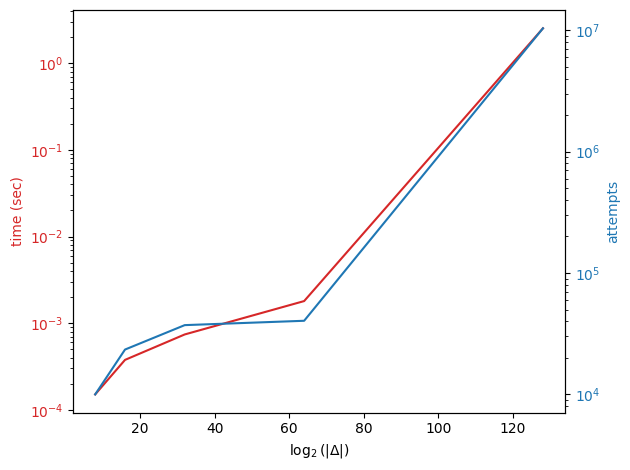

In [102]:
## Let us plot the number attempts on one of the y-axis, while on the other, we plot
## the number it took on average to hash using Wesolowski's hash to BQForm construction
# Create some mock data
t = np.array([8,16,32,64,128])
data1 = [0.00015062777996063231,0.00037699294090270995,0.0007411537885665893,0.0017984875917434692,2.5260379314422607] ##time to hash on average
data2 = [10000,23416,37214,40413,10363592] ##number of attempts

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('$\log_2(|\Delta|)$')
ax1.set_ylabel('time (sec)', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('attempts', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("./Figures/performanceWesolowskiTimevsAttempts.pdf")
plt.show()

In [231]:
## This hashing algorithm is inspired by the CSIDH construction
## See the original CSIDH paper here (page 13): https://eprint.iacr.org/2018/383.pdf
def random_ClassGroupElementCSIDH(discriminant, primeIdeals, seed):
    ## In our applications, the discriminant will always be a large odd prime
    ## We initialize the random form to be the identity element in the class group
    randomForm = BQuadForm(1,1, disc=discriminant)
    for i in range(len(primeIdeals)):
        if seed & (1 << i) != 0:
            randomForm = randomForm.__mul__(primeIdeals[i])
    return randomForm

In [ ]:
primes = []
with open('primes.json') as f:
   primes = json.load(f)

In [247]:
## Preprocessing step where we generate the random prime ideals that we will be using as generating set for the sampling of a random class group element.
bitLength = 2**64
myDiscriminant = -random_prime(bitLength)
print("My discriminant:", myDiscriminant)
primeIdeals = []
while len(primeIdeals)!=2*int(math.log(-myDiscriminant,2)):
    (a,b)=random_ClassGroupElement(myDiscriminant,random_prime(bitLength))
    if (a,b)!=(0,0):
        primeIdeals.append(BQuadForm(a,b, disc=myDiscriminant))
        print(len(primeIdeals),BQuadForm(a,b, disc=myDiscriminant))

My discriminant: -15024886940564752543
1 (569053279, -555687985, 6736485248) disc: -15024886940564752543
2 (224663776, -4069199, 16719321386) disc: -15024886940564752543
3 (1466310817, -26987295, 2561805976) disc: -15024886940564752543
4 (320789854, 132432689, 11722959104) disc: -15024886940564752543
5 (770464168, 6608273, 4875285326) disc: -15024886940564752543
6 (957249067, 922248357, 4146107194) disc: -15024886940564752543
7 (426615506, -210241729, 8830602916) disc: -15024886940564752543
8 (2006355812, 1599911471, 2191112308) disc: -15024886940564752543
9 (47096797, -14019823, 79756397744) disc: -15024886940564752543
10 (356828396, 134835401, 10539427141) disc: -15024886940564752543
11 (1601850116, 969227735, 2491539187) disc: -15024886940564752543
12 (1540709212, 305547505, 2453131016) disc: -15024886940564752543
13 (60259126, 26028397, 62337298163) disc: -15024886940564752543
14 (1547887292, -694897129, 2504667013) disc: -15024886940564752543
15 (1421849626, -324866441, 2660342006

In [248]:
howManyTimes = 100

# Start timer
start_time = time.time()
    
for i in range(howManyTimes):
    s = random.randint(0, (2**10)*bitLength - 1)
    a=random_ClassGroupElementCSIDH(myDiscriminant,primeIdeals,s)

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for sampling 1 random class group element with a "+str(math.log(bitLength,2))+"-bit discriminant: ", elapsed_time/howManyTimes) 

Elapsed time for sampling 1 random class group element with a 64.0-bit discriminant:  0.0009714698791503906


In [249]:
## Benjamin-Giacomo hash
# Elapsed time for sampling 1 random class group element with a 32.0-bit discriminant:  0.0010533094406127929
# Elapsed time for sampling 1 random class group element with a 64.0-bit discriminant:  0.008581995964050293
## CSIDH hash (Kutas Peti construction)
# Elapsed time for sampling 1 random class group element with a 32.0-bit discriminant:  0.0003685798645019531
# Elapsed time for sampling 1 random class group element with a 64.0-bit discriminant:  0.0009714698791503906